# net.py

In [0]:
! git clone https://github.com/gauravkuppa/DL4MIA.git

Cloning into 'DL4MIA'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 29 (delta 7), reused 26 (delta 4), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# custom_dataset_npy.py

In [6]:
import numpy as np
import pandas as pd
from PIL import Image
import torchvision
import torch
from torch.utils.data import *
import os
import random
import math

class CustomDatasetNPY(torch.utils.data.Dataset):

    def __init__(self, train_or_valid):
        """
        Args:
            path (string): path to root folder [axial]
        """
        
        train_path_X = "/content/drive/My Drive/MRNet-v1.0/train/coronal"
        valid_path_X = "/content/drive/My Drive/MRNet-v1.0/valid/coronal"
        train_path_Y = "/content/drive/My Drive/MRNet-v1.0/train-meniscus.csv"
        valid_path_Y = "/content/drive/My Drive/MRNet-v1.0/valid-meniscus.csv"
        self.train_or_valid = train_or_valid
        paths = {"train":[train_path_X, train_path_Y],"valid":[valid_path_X, valid_path_Y]}
        x_path, y_path = paths[train_or_valid]
        self.X = list()
        self.X_slices = list()
        self.Y = None
        #dataset processing
        self.Y = np.genfromtxt(y_path, delimiter=",")

        if train_or_valid == "valid":
            self.Y[:,0] = np.subtract(self.Y[:,0], 1130)    
            print(self.Y)
            
        
        # removing last four images from dataset
        # they do not add anything to the dataset bc not consistent with dimensions of other images
        
        for file in os.listdir(x_path):
            if file.endswith(".npy"):
                if int(file.split(".")[0]) not in list(range(1126, 1130)):
                    print("file:", file)
                    x = np.load(x_path + "/" + file)
                    # print(x.shape)
                    self.X.append(x)
            
        

        # for each (s, 256, 256) tensor, take the middle slice of the tensor and append to X_slices
        for img in self.X:
            x = img[math.floor(img.shape[0] / 2)]
            x = np.asarray(x)
            x = np.expand_dims(x, axis=0)
            self.X_slices.append(x)

        
        self.length = len(self.X_slices)

    def __getitem__(self, index):
        """
        Args:
        return (Image, Ground_truth)
        """
 
        print("index:", index)
        x_slice = self.X_slices[index]
        x = np.squeeze(x_slice, axis=0)
        pil_image = torchvision.transforms.functional.to_pil_image(x)
        tensor = torchvision.transforms.functional.to_tensor(pil_image)
        triple_tensor = torch.stack(list(tensor) * 3, dim=0)
        # normalize tensor given mean and std dev. from ResNet architecture
        transformed_tensor = torchvision.transforms.functional.normalize(triple_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        if self.train_or_valid == "valid" and index > 1129:
            y = self.Y[index - 1130]
        else:
            y = self.Y[index]

        return (transformed_tensor, y)

    def __len__(self):
        """
        Args: return length
        """
        return self.length

'''
def main():
    # Create Dataset and DataLoader for training and validation dataset
    
    dataset_train = CustomDatasetNPY("train")
    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=4, shuffle=True  # , num_workers=4
    )
    dataset_valid = CustomDatasetNPY("valid")
    valid_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=4, shuffle=True  # , num_workers=4
    )
    

    for index, (tensor, ground) in enumerate(valid_loader):
        print("index:", index)
        print("tensor:", tensor.shape)
        print("truth:", ground)

    loader_iter = iter(train_loader)
    dataset_iter = iter(dataset_train)

    print(next(loader_iter))
    print("#1:",next(dataset_iter))
    print("#2:",next(dataset_iter))
    print("#3:",next(dataset_iter))
    print("#4:",next(dataset_iter))

    


if __name__ == "__main__":
    main()
'''

'\ndef main():\n    # Create Dataset and DataLoader for training and validation dataset\n    \n    dataset_train = CustomDatasetNPY("train")\n    train_loader = torch.utils.data.DataLoader(\n        dataset_train, batch_size=4, shuffle=True  # , num_workers=4\n    )\n    dataset_valid = CustomDatasetNPY("valid")\n    valid_loader = torch.utils.data.DataLoader(\n        dataset_valid, batch_size=4, shuffle=True  # , num_workers=4\n    )\n    \n\n    for index, (tensor, ground) in enumerate(valid_loader):\n        print("index:", index)\n        print("tensor:", tensor.shape)\n        print("truth:", ground)\n\n    loader_iter = iter(train_loader)\n    dataset_iter = iter(dataset_train)\n\n    print(next(loader_iter))\n    print("#1:",next(dataset_iter))\n    print("#2:",next(dataset_iter))\n    print("#3:",next(dataset_iter))\n    print("#4:",next(dataset_iter))\n\n    \n\n\nif __name__ == "__main__":\n    main()\n'

# model.py


 29%|██▊       | 81/282 [02:02<05:02,  1.50s/it]

index: 312
index: 269
index: 1111
index: 4



 29%|██▉       | 82/282 [02:03<05:02,  1.51s/it]

index: 959
index: 989
index: 179
index: 217



 29%|██▉       | 83/282 [02:05<05:00,  1.51s/it]

index: 902
index: 521
index: 1
index: 1048



 30%|██▉       | 84/282 [02:06<05:00,  1.52s/it]

index: 1030
index: 291
index: 669
index: 794



 30%|███       | 85/282 [02:08<04:57,  1.51s/it]

index: 42
index: 751
index: 958
index: 918



 30%|███       | 86/282 [02:09<04:56,  1.51s/it]

index: 874
index: 741
index: 216
index: 950



 31%|███       | 87/282 [02:11<04:55,  1.51s/it]

index: 518
index: 642
index: 1041
index: 542



 31%|███       | 88/282 [02:12<04:52,  1.51s/it]

index: 737
index: 274
index: 551
index: 336



 32%|███▏      | 89/282 [02:14<04:51,  1.51s/it]

index: 1120
index: 368
index: 917
index: 83



 32%|███▏      | 90/282 [02:15<04:49,  1.51s/it]

index: 226
index: 179
index: 37
index: 461



 32%|███▏      | 91/282 [02:17<04:48,  1.51s/it]

index: 140
index: 625
index: 114
index: 1068



 33%|███▎      | 92/282 [02:18<04:45,  1.51s/it]

index: 356
index: 240
index: 617
index: 232



 33%|███▎      | 93/282 [02:20<04:44,  1.51s/it]

index: 302
index: 38
index: 1013
index: 749



 33%|███▎      | 94/282 [02:21<04:49,  1.54s/it]

index: 706
index: 879
index: 284
index: 896



 34%|███▎      | 95/282 [02:23<04:48,  1.54s/it]

index: 56
index: 1089
index: 723
index: 760



 34%|███▍      | 96/282 [02:24<04:46,  1.54s/it]

index: 443
index: 570
index: 313
index: 666



 34%|███▍      | 97/282 [02:26<04:48,  1.56s/it]

index: 596
index: 1047
index: 171
index: 1078



 35%|███▍      | 98/282 [02:27<04:46,  1.56s/it]

index: 789
index: 1093
index: 991
index: 307



 35%|███▌      | 99/282 [02:29<04:45,  1.56s/it]

index: 530
index: 210
index: 194
index: 842



 35%|███▌      | 100/282 [02:31<04:44,  1.57s/it]

index: 786
index: 278
index: 909
index: 995



 36%|███▌      | 101/282 [02:32<04:39,  1.54s/it]

index: 135
index: 169
index: 1110
index: 529



 36%|███▌      | 102/282 [02:34<04:35,  1.53s/it]

index: 428
index: 819
index: 27
index: 33



 37%|███▋      | 103/282 [02:35<04:32,  1.52s/it]

index: 522
index: 221
index: 155
index: 444



 37%|███▋      | 104/282 [02:37<04:29,  1.51s/it]

index: 456
index: 450
index: 361
index: 459



 37%|███▋      | 105/282 [02:38<04:27,  1.51s/it]

index: 522
index: 1052
index: 6
index: 969



 38%|███▊      | 106/282 [02:40<04:24,  1.51s/it]

index: 72
index: 812
index: 1109
index: 5



 38%|███▊      | 107/282 [02:41<04:23,  1.50s/it]

index: 178
index: 972
index: 355
index: 563



 38%|███▊      | 108/282 [02:43<04:21,  1.50s/it]

index: 804
index: 927
index: 54
index: 363



 39%|███▊      | 109/282 [02:44<04:20,  1.50s/it]

index: 175
index: 900
index: 143
index: 138



 39%|███▉      | 110/282 [02:46<04:18,  1.50s/it]

index: 883
index: 545
index: 230
index: 890



 39%|███▉      | 111/282 [02:47<04:16,  1.50s/it]

index: 806
index: 909
index: 390
index: 763



 40%|███▉      | 112/282 [02:49<04:14,  1.50s/it]

index: 923
index: 421
index: 1048
index: 434



 40%|████      | 113/282 [02:50<04:13,  1.50s/it]

index: 476
index: 1
index: 1077
index: 831



 40%|████      | 114/282 [02:52<04:11,  1.50s/it]

index: 739
index: 1000
index: 271
index: 922



 41%|████      | 115/282 [02:53<04:10,  1.50s/it]

index: 450
index: 657
index: 149
index: 317



 41%|████      | 116/282 [02:55<04:08,  1.50s/it]

index: 136
index: 941
index: 1080
index: 259



 41%|████▏     | 117/282 [02:56<04:07,  1.50s/it]

index: 629
index: 935
index: 38
index: 618



 42%|████▏     | 118/282 [02:58<04:06,  1.50s/it]

index: 931
index: 589
index: 742
index: 781



 42%|████▏     | 119/282 [02:59<04:04,  1.50s/it]

index: 356
index: 693
index: 576
index: 552



 43%|████▎     | 120/282 [03:01<04:03,  1.50s/it]

index: 1060
index: 748
index: 693
index: 1009



 43%|████▎     | 121/282 [03:02<04:01,  1.50s/it]

index: 1
index: 721
index: 1034
index: 166



 43%|████▎     | 122/282 [03:04<04:00,  1.50s/it]

index: 75
index: 204
index: 76
index: 345



 44%|████▎     | 123/282 [03:05<04:00,  1.51s/it]

index: 298
index: 235
index: 388
index: 921



 44%|████▍     | 124/282 [03:07<04:01,  1.53s/it]

index: 1012
index: 337
index: 628
index: 255



 44%|████▍     | 125/282 [03:08<03:59,  1.53s/it]

index: 500
index: 838
index: 862
index: 1068



 45%|████▍     | 126/282 [03:10<03:58,  1.53s/it]

index: 1116
index: 550
index: 112
index: 120



 45%|████▌     | 127/282 [03:11<03:56,  1.53s/it]

index: 136
index: 576
index: 778
index: 930



 45%|████▌     | 128/282 [03:13<03:55,  1.53s/it]

index: 35
index: 217
index: 289
index: 460



 46%|████▌     | 129/282 [03:14<03:53,  1.53s/it]

index: 975
index: 70
index: 472
index: 337



 46%|████▌     | 130/282 [03:16<03:50,  1.52s/it]

index: 61
index: 132
index: 366
index: 92



 46%|████▋     | 131/282 [03:17<03:47,  1.51s/it]

index: 364
index: 443
index: 1078
index: 46



 47%|████▋     | 132/282 [03:19<03:45,  1.51s/it]

index: 859
index: 330
index: 273
index: 587



 47%|████▋     | 133/282 [03:20<03:44,  1.50s/it]

index: 250
index: 566
index: 1056
index: 186



 48%|████▊     | 134/282 [03:22<03:42,  1.50s/it]

index: 743
index: 1024
index: 744
index: 550



 48%|████▊     | 135/282 [03:23<03:40,  1.50s/it]

index: 789
index: 171
index: 674
index: 8



 48%|████▊     | 136/282 [03:25<03:39,  1.50s/it]

index: 653
index: 22
index: 453
index: 529



 49%|████▊     | 137/282 [03:26<03:38,  1.50s/it]

index: 260
index: 279
index: 648
index: 691



 49%|████▉     | 138/282 [03:28<03:37,  1.51s/it]

index: 801
index: 114
index: 560
index: 1053



 49%|████▉     | 139/282 [03:29<03:34,  1.50s/it]

index: 948
index: 654
index: 691
index: 600



 50%|████▉     | 140/282 [03:31<03:33,  1.51s/it]

index: 482
index: 1109
index: 1052
index: 9



 50%|█████     | 141/282 [03:32<03:31,  1.50s/it]

index: 225
index: 427
index: 106
index: 999



 50%|█████     | 142/282 [03:34<03:29,  1.50s/it]

index: 75
index: 864
index: 367
index: 997



 51%|█████     | 143/282 [03:35<03:27,  1.50s/it]

index: 345
index: 311
index: 370
index: 1016



 51%|█████     | 144/282 [03:37<03:26,  1.49s/it]

index: 200
index: 125
index: 60
index: 904



 51%|█████▏    | 145/282 [03:38<03:25,  1.50s/it]

index: 894
index: 453
index: 905
index: 433



 52%|█████▏    | 146/282 [03:40<03:24,  1.50s/it]

index: 583
index: 7
index: 592
index: 668



 52%|█████▏    | 147/282 [03:41<03:22,  1.50s/it]

index: 43
index: 100
index: 543
index: 1080



 52%|█████▏    | 148/282 [03:43<03:21,  1.50s/it]

index: 380
index: 236
index: 106
index: 755



 53%|█████▎    | 149/282 [03:44<03:19,  1.50s/it]

index: 880
index: 335
index: 1069
index: 225



 53%|█████▎    | 150/282 [03:46<03:18,  1.50s/it]

index: 781
index: 547
index: 450
index: 633



 54%|█████▎    | 151/282 [03:47<03:16,  1.50s/it]

index: 65
index: 509
index: 26
index: 212



 54%|█████▍    | 152/282 [03:49<03:14,  1.50s/it]

index: 117
index: 1111
index: 932
index: 632



 54%|█████▍    | 153/282 [03:50<03:13,  1.50s/it]

index: 894
index: 103
index: 79
index: 83



 55%|█████▍    | 154/282 [03:52<03:11,  1.50s/it]

index: 193
index: 234
index: 23
index: 321



 55%|█████▍    | 155/282 [03:53<03:10,  1.50s/it]

index: 457
index: 999
index: 672
index: 684



 55%|█████▌    | 156/282 [03:55<03:08,  1.50s/it]

index: 1022
index: 1100
index: 338
index: 44



 56%|█████▌    | 157/282 [03:56<03:07,  1.50s/it]

index: 1077
index: 421
index: 143
index: 1039



 56%|█████▌    | 158/282 [03:58<03:05,  1.49s/it]

index: 1097
index: 43
index: 438
index: 424



 56%|█████▋    | 159/282 [03:59<03:04,  1.50s/it]

index: 866
index: 104
index: 16
index: 287



 57%|█████▋    | 160/282 [04:01<03:02,  1.49s/it]

index: 827
index: 1040
index: 353
index: 934



 57%|█████▋    | 161/282 [04:02<03:01,  1.50s/it]

index: 4
index: 683
index: 905
index: 339



 57%|█████▋    | 162/282 [04:04<02:59,  1.50s/it]

index: 488
index: 147
index: 617
index: 469



 58%|█████▊    | 163/282 [04:05<02:58,  1.50s/it]

index: 441
index: 659
index: 947
index: 126



 58%|█████▊    | 164/282 [04:07<02:58,  1.51s/it]

index: 967
index: 275
index: 48
index: 682



 59%|█████▊    | 165/282 [04:08<02:57,  1.52s/it]

index: 543
index: 506
index: 721
index: 779



 59%|█████▉    | 166/282 [04:10<02:56,  1.52s/it]

index: 172
index: 527
index: 472
index: 211



 59%|█████▉    | 167/282 [04:12<02:55,  1.53s/it]

index: 750
index: 323
index: 984
index: 348



 60%|█████▉    | 168/282 [04:13<02:55,  1.54s/it]

index: 95
index: 565
index: 752
index: 126



 60%|█████▉    | 169/282 [04:15<02:53,  1.54s/it]

index: 646
index: 698
index: 809
index: 776



 60%|██████    | 170/282 [04:16<02:51,  1.53s/it]

index: 69
index: 610
index: 848
index: 513



 61%|██████    | 171/282 [04:18<02:50,  1.54s/it]

index: 1061
index: 958
index: 813
index: 180



 61%|██████    | 172/282 [04:19<02:48,  1.53s/it]

index: 397
index: 273
index: 142
index: 570



 61%|██████▏   | 173/282 [04:21<02:47,  1.54s/it]

index: 79
index: 186
index: 328
index: 323



 62%|██████▏   | 174/282 [04:22<02:45,  1.53s/it]

index: 995
index: 118
index: 169
index: 569



 62%|██████▏   | 175/282 [04:24<02:44,  1.54s/it]

index: 577
index: 941
index: 899
index: 1006



 62%|██████▏   | 176/282 [04:25<02:43,  1.55s/it]

index: 731
index: 405
index: 1018
index: 153



 63%|██████▎   | 177/282 [04:27<02:43,  1.56s/it]

index: 323
index: 484
index: 453
index: 487



 63%|██████▎   | 178/282 [04:29<02:42,  1.56s/it]

index: 412
index: 231
index: 934
index: 984



 63%|██████▎   | 179/282 [04:30<02:41,  1.57s/it]

index: 875
index: 531
index: 420
index: 922



 64%|██████▍   | 180/282 [04:32<02:39,  1.56s/it]

index: 814
index: 67
index: 268
index: 587



 64%|██████▍   | 181/282 [04:33<02:38,  1.57s/it]

index: 433
index: 551
index: 426
index: 930



 65%|██████▍   | 182/282 [04:35<02:36,  1.56s/it]

index: 351
index: 462
index: 885
index: 401



 65%|██████▍   | 183/282 [04:36<02:32,  1.54s/it]

index: 47
index: 18
index: 633
index: 290



 65%|██████▌   | 184/282 [04:38<02:30,  1.53s/it]

index: 95
index: 185
index: 123
index: 505



 66%|██████▌   | 185/282 [04:39<02:27,  1.52s/it]

index: 301
index: 984
index: 319
index: 857



 66%|██████▌   | 186/282 [04:41<02:26,  1.52s/it]

index: 352
index: 1047
index: 498
index: 384



 66%|██████▋   | 187/282 [04:42<02:24,  1.53s/it]

index: 448
index: 821
index: 814
index: 338



 67%|██████▋   | 188/282 [04:44<02:23,  1.53s/it]

index: 566
index: 790
index: 704
index: 330



 67%|██████▋   | 189/282 [04:45<02:23,  1.54s/it]

index: 95
index: 36
index: 1118
index: 385



 67%|██████▋   | 190/282 [04:47<02:21,  1.54s/it]

index: 1115
index: 506
index: 316
index: 424



 68%|██████▊   | 191/282 [04:48<02:19,  1.53s/it]

index: 620
index: 465
index: 556
index: 109



 68%|██████▊   | 192/282 [04:50<02:16,  1.52s/it]

index: 961
index: 414
index: 658
index: 290



 68%|██████▊   | 193/282 [04:51<02:14,  1.51s/it]

index: 554
index: 1034
index: 147
index: 277



 69%|██████▉   | 194/282 [04:53<02:13,  1.51s/it]

index: 221
index: 316
index: 196
index: 761



 69%|██████▉   | 195/282 [04:55<02:11,  1.52s/it]

index: 382
index: 999
index: 681
index: 968



 70%|██████▉   | 196/282 [04:56<02:10,  1.52s/it]

index: 453
index: 981
index: 459
index: 187



 70%|██████▉   | 197/282 [04:58<02:09,  1.52s/it]

index: 276
index: 458
index: 481
index: 430



 70%|███████   | 198/282 [04:59<02:07,  1.51s/it]

index: 788
index: 471
index: 619
index: 350



 71%|███████   | 199/282 [05:01<02:05,  1.52s/it]

index: 828
index: 472
index: 488
index: 957



 71%|███████   | 200/282 [05:02<02:04,  1.52s/it]

index: 395
index: 310
index: 442
index: 1116



 71%|███████▏  | 201/282 [05:04<02:03,  1.52s/it]

index: 680
index: 554
index: 441
index: 674



 72%|███████▏  | 202/282 [05:05<02:02,  1.53s/it]

index: 66
index: 719
index: 1076
index: 422



 72%|███████▏  | 203/282 [05:07<02:01,  1.54s/it]

index: 853
index: 939
index: 922
index: 570



 72%|███████▏  | 204/282 [05:08<01:59,  1.53s/it]

index: 21
index: 221
index: 701
index: 200



 73%|███████▎  | 205/282 [05:10<01:58,  1.53s/it]

index: 388
index: 511
index: 368
index: 1077



 73%|███████▎  | 206/282 [05:11<01:56,  1.53s/it]

index: 103
index: 531
index: 640
index: 829



 73%|███████▎  | 207/282 [05:13<01:54,  1.52s/it]

index: 815
index: 514
index: 421
index: 911



 74%|███████▍  | 208/282 [05:14<01:52,  1.52s/it]

index: 998
index: 952
index: 1040
index: 301



 74%|███████▍  | 209/282 [05:16<01:50,  1.52s/it]

index: 910
index: 234
index: 769
index: 800



 74%|███████▍  | 210/282 [05:17<01:49,  1.52s/it]

index: 752
index: 477
index: 515
index: 760



 75%|███████▍  | 211/282 [05:19<01:48,  1.52s/it]

index: 766
index: 96
index: 474
index: 1123



 75%|███████▌  | 212/282 [05:20<01:47,  1.53s/it]

index: 607
index: 215
index: 381
index: 548



 76%|███████▌  | 213/282 [05:22<01:45,  1.53s/it]

index: 346
index: 473
index: 734
index: 329



 76%|███████▌  | 214/282 [05:24<01:43,  1.52s/it]

index: 382
index: 715
index: 938
index: 1048



 76%|███████▌  | 215/282 [05:25<01:42,  1.53s/it]

index: 442
index: 317
index: 165
index: 134



 77%|███████▋  | 216/282 [05:27<01:40,  1.53s/it]

index: 403
index: 274
index: 947
index: 426



 77%|███████▋  | 217/282 [05:28<01:39,  1.53s/it]

index: 568
index: 606
index: 251
index: 515



 77%|███████▋  | 218/282 [05:30<01:37,  1.53s/it]

index: 204
index: 52
index: 921
index: 657



 78%|███████▊  | 219/282 [05:31<01:36,  1.53s/it]

index: 712
index: 1093
index: 954
index: 61



 78%|███████▊  | 220/282 [05:33<01:35,  1.53s/it]

index: 1029
index: 684
index: 758
index: 491



 78%|███████▊  | 221/282 [05:34<01:33,  1.53s/it]

index: 610
index: 337
index: 324
index: 525



 79%|███████▊  | 222/282 [05:36<01:32,  1.54s/it]

index: 998
index: 465
index: 755
index: 80



 79%|███████▉  | 223/282 [05:37<01:30,  1.53s/it]

index: 239
index: 198
index: 839
index: 705



 79%|███████▉  | 224/282 [05:39<01:29,  1.54s/it]

index: 237
index: 475
index: 628
index: 363



 80%|███████▉  | 225/282 [05:40<01:27,  1.53s/it]

index: 1028
index: 81
index: 393
index: 689



 80%|████████  | 226/282 [05:42<01:25,  1.54s/it]

index: 743
index: 261
index: 735
index: 685



 80%|████████  | 227/282 [05:43<01:24,  1.53s/it]

index: 836
index: 386
index: 309
index: 1116



 81%|████████  | 228/282 [05:45<01:23,  1.55s/it]

index: 293
index: 1113
index: 387
index: 492



 81%|████████  | 229/282 [05:47<01:22,  1.55s/it]

index: 993
index: 836
index: 508
index: 755



 82%|████████▏ | 230/282 [05:48<01:20,  1.56s/it]

index: 468
index: 720
index: 841
index: 473



 82%|████████▏ | 231/282 [05:50<01:19,  1.56s/it]

index: 328
index: 644
index: 819
index: 692



 82%|████████▏ | 232/282 [05:51<01:17,  1.55s/it]

index: 123
index: 647
index: 271
index: 573



 83%|████████▎ | 233/282 [05:53<01:15,  1.54s/it]

index: 187
index: 523
index: 576
index: 563



 83%|████████▎ | 234/282 [05:54<01:14,  1.55s/it]

index: 45
index: 142
index: 1028
index: 494



 83%|████████▎ | 235/282 [05:56<01:12,  1.55s/it]

index: 221
index: 132
index: 797
index: 595



 84%|████████▎ | 236/282 [05:57<01:11,  1.54s/it]

index: 600
index: 349
index: 6
index: 2



 84%|████████▍ | 237/282 [05:59<01:09,  1.55s/it]

index: 691
index: 194
index: 963
index: 495



 84%|████████▍ | 238/282 [06:01<01:07,  1.55s/it]

index: 1123
index: 394
index: 226
index: 528



 85%|████████▍ | 239/282 [06:02<01:06,  1.54s/it]

index: 712
index: 1046
index: 74
index: 1073



 85%|████████▌ | 240/282 [06:04<01:04,  1.54s/it]

index: 341
index: 281
index: 671
index: 431



 85%|████████▌ | 241/282 [06:05<01:03,  1.54s/it]

index: 515
index: 121
index: 772
index: 1122



 86%|████████▌ | 242/282 [06:07<01:01,  1.55s/it]

index: 191
index: 63
index: 1073
index: 565



 86%|████████▌ | 243/282 [06:08<01:00,  1.55s/it]

index: 628
index: 721
index: 295
index: 716



 87%|████████▋ | 244/282 [06:10<00:58,  1.54s/it]

index: 618
index: 23
index: 46
index: 122



 87%|████████▋ | 245/282 [06:11<00:56,  1.54s/it]

index: 618
index: 578
index: 1097
index: 304



 87%|████████▋ | 246/282 [06:13<00:55,  1.54s/it]

index: 200
index: 158
index: 162
index: 526



 88%|████████▊ | 247/282 [06:14<00:53,  1.54s/it]

index: 780
index: 121
index: 301
index: 328



 88%|████████▊ | 248/282 [06:16<00:52,  1.54s/it]

index: 845
index: 1119
index: 159
index: 502



 88%|████████▊ | 249/282 [06:17<00:50,  1.53s/it]

index: 752
index: 1114
index: 394
index: 1090



 89%|████████▊ | 250/282 [06:19<00:48,  1.52s/it]

index: 947
index: 193
index: 782
index: 486



 89%|████████▉ | 251/282 [06:20<00:47,  1.52s/it]

index: 831
index: 534
index: 426
index: 1033



 89%|████████▉ | 252/282 [06:22<00:45,  1.52s/it]

index: 404
index: 865
index: 527
index: 811



 90%|████████▉ | 253/282 [06:23<00:43,  1.52s/it]

index: 194
index: 65
index: 29
index: 117



 90%|█████████ | 254/282 [06:25<00:42,  1.52s/it]

index: 132
index: 72
index: 681
index: 275



 90%|█████████ | 255/282 [06:27<00:40,  1.52s/it]

index: 16
index: 590
index: 884
index: 1089



 91%|█████████ | 256/282 [06:28<00:39,  1.51s/it]

index: 313
index: 833
index: 163
index: 464



 91%|█████████ | 257/282 [06:30<00:37,  1.51s/it]

index: 1117
index: 429
index: 151
index: 177



 91%|█████████▏| 258/282 [06:31<00:36,  1.51s/it]

index: 672
index: 986
index: 322
index: 340



 92%|█████████▏| 259/282 [06:33<00:34,  1.51s/it]

index: 654
index: 687
index: 659
index: 796



 92%|█████████▏| 260/282 [06:34<00:33,  1.51s/it]

index: 742
index: 709
index: 287
index: 930



 93%|█████████▎| 261/282 [06:36<00:31,  1.51s/it]

index: 782
index: 968
index: 213
index: 809



 93%|█████████▎| 262/282 [06:37<00:30,  1.51s/it]

index: 806
index: 581
index: 472
index: 663



 93%|█████████▎| 263/282 [06:39<00:28,  1.51s/it]

index: 523
index: 789
index: 387
index: 700



 94%|█████████▎| 264/282 [06:40<00:27,  1.51s/it]

index: 516
index: 100
index: 366
index: 575



 94%|█████████▍| 265/282 [06:42<00:25,  1.52s/it]

index: 606
index: 381
index: 428
index: 489



 94%|█████████▍| 266/282 [06:43<00:24,  1.51s/it]

index: 237
index: 840
index: 1051
index: 584



 95%|█████████▍| 267/282 [06:45<00:22,  1.52s/it]

index: 86
index: 945
index: 528
index: 1050



 95%|█████████▌| 268/282 [06:46<00:21,  1.52s/it]

index: 124
index: 970
index: 887
index: 251



 95%|█████████▌| 269/282 [06:48<00:19,  1.53s/it]

index: 890
index: 291
index: 947
index: 204



 96%|█████████▌| 270/282 [06:49<00:18,  1.53s/it]

index: 1026
index: 1015
index: 85
index: 434



 96%|█████████▌| 271/282 [06:51<00:16,  1.53s/it]

index: 656
index: 205
index: 491
index: 720



 96%|█████████▋| 272/282 [06:52<00:15,  1.52s/it]

index: 117
index: 167
index: 1098
index: 609



 97%|█████████▋| 273/282 [06:54<00:13,  1.51s/it]

index: 481
index: 10
index: 889
index: 133



 97%|█████████▋| 274/282 [06:55<00:12,  1.51s/it]

index: 111
index: 316
index: 1053
index: 749



 98%|█████████▊| 275/282 [06:57<00:10,  1.51s/it]

index: 710
index: 1112
index: 468
index: 1029



 98%|█████████▊| 276/282 [06:58<00:09,  1.52s/it]

index: 76
index: 1123
index: 219
index: 371



 98%|█████████▊| 277/282 [07:00<00:07,  1.52s/it]

index: 1022
index: 600
index: 1062
index: 603



 99%|█████████▊| 278/282 [07:01<00:06,  1.52s/it]

index: 859
index: 288
index: 551
index: 291



 99%|█████████▉| 279/282 [07:03<00:04,  1.52s/it]

index: 772
index: 675
index: 225
index: 137



 99%|█████████▉| 280/282 [07:04<00:03,  1.52s/it]

index: 57
index: 982
index: 770
index: 630



100%|█████████▉| 281/282 [07:06<00:01,  1.54s/it]

index: 549
index: 507
index: 38
index: 384



100%|██████████| 282/282 [07:08<00:00,  1.54s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.2159 Acc: 0.9227
index: 55
index: 35
index: 34
index: 4



  3%|▎         | 1/30 [00:00<00:12,  2.38it/s]

index: 41
index: 7
index: 107
index: 37



  7%|▋         | 2/30 [00:00<00:11,  2.37it/s]

index: 55
index: 100
index: 69
index: 22



 10%|█         | 3/30 [00:01<00:11,  2.40it/s]

index: 59
index: 78
index: 84
index: 21



 13%|█▎        | 4/30 [00:01<00:10,  2.38it/s]

index: 88
index: 113
index: 20
index: 83



 17%|█▋        | 5/30 [00:02<00:10,  2.39it/s]

index: 31
index: 56
index: 114
index: 26



 20%|██        | 6/30 [00:02<00:09,  2.40it/s]

index: 57
index: 72
index: 9
index: 111



 23%|██▎       | 7/30 [00:02<00:09,  2.41it/s]

index: 68
index: 57
index: 89
index: 58



 27%|██▋       | 8/30 [00:03<00:09,  2.44it/s]

index: 95
index: 86
index: 35
index: 1



 30%|███       | 9/30 [00:03<00:08,  2.44it/s]

index: 55
index: 103
index: 36
index: 2



 33%|███▎      | 10/30 [00:04<00:08,  2.44it/s]

index: 64
index: 90
index: 32
index: 93



 37%|███▋      | 11/30 [00:04<00:07,  2.44it/s]

index: 73
index: 66
index: 71
index: 93



 40%|████      | 12/30 [00:04<00:07,  2.43it/s]

index: 85
index: 92
index: 69
index: 21



 43%|████▎     | 13/30 [00:05<00:06,  2.45it/s]

index: 119
index: 118
index: 27
index: 75



 47%|████▋     | 14/30 [00:05<00:06,  2.43it/s]

index: 87
index: 84
index: 85
index: 40



 50%|█████     | 15/30 [00:06<00:06,  2.43it/s]

index: 0
index: 29
index: 113
index: 17



 53%|█████▎    | 16/30 [00:06<00:05,  2.44it/s]

index: 108
index: 102
index: 68
index: 10



 57%|█████▋    | 17/30 [00:07<00:05,  2.40it/s]

index: 28
index: 47
index: 21
index: 64



 60%|██████    | 18/30 [00:07<00:04,  2.43it/s]

index: 15
index: 63
index: 39
index: 97



 63%|██████▎   | 19/30 [00:07<00:04,  2.42it/s]

index: 0
index: 26
index: 71
index: 114



 67%|██████▋   | 20/30 [00:08<00:04,  2.45it/s]

index: 79
index: 118
index: 28
index: 19



 70%|███████   | 21/30 [00:08<00:03,  2.48it/s]

index: 22
index: 57
index: 62
index: 54



 73%|███████▎  | 22/30 [00:09<00:03,  2.47it/s]

index: 91
index: 72
index: 41
index: 31



 77%|███████▋  | 23/30 [00:09<00:02,  2.50it/s]

index: 99
index: 65
index: 48
index: 21



 80%|████████  | 24/30 [00:09<00:02,  2.50it/s]

index: 76
index: 107
index: 8
index: 102



 83%|████████▎ | 25/30 [00:10<00:01,  2.51it/s]

index: 39
index: 44
index: 54
index: 90



 87%|████████▋ | 26/30 [00:10<00:01,  2.52it/s]

index: 42
index: 31
index: 91
index: 75



 90%|█████████ | 27/30 [00:11<00:01,  2.51it/s]

index: 88
index: 11
index: 80
index: 99



 93%|█████████▎| 28/30 [00:11<00:00,  2.52it/s]

index: 72
index: 53
index: 99
index: 48



 97%|█████████▋| 29/30 [00:11<00:00,  2.53it/s]

index: 72
index: 70
index: 15
index: 36



100%|██████████| 30/30 [00:12<00:00,  2.52it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.5055 Acc: 0.5500

Epoch 11/24
----------
index: 251
index: 350
index: 463
index: 1110



  0%|          | 1/282 [00:01<06:58,  1.49s/it]

index: 722
index: 368
index: 41
index: 876



  1%|          | 2/282 [00:03<06:59,  1.50s/it]

index: 954
index: 542
index: 84
index: 721



  1%|          | 3/282 [00:04<06:57,  1.50s/it]

index: 925
index: 267
index: 689
index: 886



  1%|▏         | 4/282 [00:06<06:56,  1.50s/it]

index: 1018
index: 95
index: 534
index: 840



  2%|▏         | 5/282 [00:07<06:54,  1.50s/it]

index: 730
index: 965
index: 1123
index: 1075



  2%|▏         | 6/282 [00:08<06:53,  1.50s/it]

index: 650
index: 387
index: 452
index: 127



  2%|▏         | 7/282 [00:10<06:51,  1.50s/it]

index: 79
index: 685
index: 205
index: 1124



  3%|▎         | 8/282 [00:12<07:04,  1.55s/it]

index: 105
index: 723
index: 572
index: 798



  3%|▎         | 9/282 [00:13<07:01,  1.54s/it]

index: 989
index: 675
index: 1039
index: 246



  4%|▎         | 10/282 [00:15<07:00,  1.55s/it]

index: 908
index: 763
index: 436
index: 721



  4%|▍         | 11/282 [00:16<07:01,  1.55s/it]

index: 221
index: 605
index: 25
index: 904



  4%|▍         | 12/282 [00:18<06:59,  1.55s/it]

index: 10
index: 415
index: 982
index: 404



  5%|▍         | 13/282 [00:19<06:58,  1.56s/it]

index: 504
index: 306
index: 764
index: 1091



  5%|▍         | 14/282 [00:21<06:58,  1.56s/it]

index: 375
index: 1011
index: 737
index: 47



  5%|▌         | 15/282 [00:23<06:52,  1.54s/it]

index: 972
index: 692
index: 1060
index: 266



  6%|▌         | 16/282 [00:24<06:47,  1.53s/it]

index: 111
index: 375
index: 386
index: 984



  6%|▌         | 17/282 [00:26<06:43,  1.52s/it]

index: 233
index: 254
index: 717
index: 1078



  6%|▋         | 18/282 [00:27<06:39,  1.51s/it]

index: 355
index: 1068
index: 255
index: 216



  7%|▋         | 19/282 [00:29<06:36,  1.51s/it]

index: 872
index: 334
index: 985
index: 592



  7%|▋         | 20/282 [00:30<06:35,  1.51s/it]

index: 173
index: 876
index: 424
index: 1122



  7%|▋         | 21/282 [00:31<06:31,  1.50s/it]

index: 81
index: 204
index: 97
index: 19



  8%|▊         | 22/282 [00:33<06:30,  1.50s/it]

index: 95
index: 541
index: 536
index: 651



  8%|▊         | 23/282 [00:34<06:28,  1.50s/it]

index: 444
index: 332
index: 951
index: 916



  9%|▊         | 24/282 [00:36<06:27,  1.50s/it]

index: 918
index: 1065
index: 402
index: 226



  9%|▉         | 25/282 [00:38<06:26,  1.50s/it]

index: 958
index: 991
index: 331
index: 936



  9%|▉         | 26/282 [00:39<06:24,  1.50s/it]

index: 740
index: 55
index: 588
index: 946



 10%|▉         | 27/282 [00:41<06:22,  1.50s/it]

index: 579
index: 5
index: 933
index: 395



 10%|▉         | 28/282 [00:42<06:20,  1.50s/it]

index: 27
index: 17
index: 44
index: 277



 10%|█         | 29/282 [00:43<06:18,  1.50s/it]

index: 1016
index: 642
index: 866
index: 657



 11%|█         | 30/282 [00:45<06:17,  1.50s/it]

index: 118
index: 775
index: 1095
index: 517



 11%|█         | 31/282 [00:47<06:17,  1.50s/it]

index: 961
index: 974
index: 1042
index: 221



 11%|█▏        | 32/282 [00:48<06:16,  1.51s/it]

index: 1074
index: 238
index: 641
index: 1037



 12%|█▏        | 33/282 [00:50<06:14,  1.50s/it]

index: 1081
index: 367
index: 561
index: 961



 12%|█▏        | 34/282 [00:51<06:12,  1.50s/it]

index: 913
index: 841
index: 33
index: 792



 12%|█▏        | 35/282 [00:53<06:11,  1.50s/it]

index: 3
index: 347
index: 653
index: 237



 13%|█▎        | 36/282 [00:54<06:09,  1.50s/it]

index: 863
index: 235
index: 583
index: 1087



 13%|█▎        | 37/282 [00:56<06:09,  1.51s/it]

index: 0
index: 84
index: 346
index: 8



 13%|█▎        | 38/282 [00:57<06:06,  1.50s/it]

index: 157
index: 1069
index: 645
index: 880



 14%|█▍        | 39/282 [00:59<06:05,  1.51s/it]

index: 81
index: 322
index: 1087
index: 108



 14%|█▍        | 40/282 [01:00<06:04,  1.51s/it]

index: 575
index: 450
index: 682
index: 559



 15%|█▍        | 41/282 [01:02<06:02,  1.50s/it]

index: 945
index: 1009
index: 531
index: 674



 15%|█▍        | 42/282 [01:03<06:00,  1.50s/it]

index: 60
index: 996
index: 576
index: 660



 15%|█▌        | 43/282 [01:05<05:59,  1.51s/it]

index: 714
index: 725
index: 749
index: 430



 16%|█▌        | 44/282 [01:06<06:00,  1.52s/it]

index: 260
index: 696
index: 304
index: 182



 16%|█▌        | 45/282 [01:08<05:59,  1.52s/it]

index: 219
index: 646
index: 73
index: 508



 16%|█▋        | 46/282 [01:09<05:59,  1.52s/it]

index: 1013
index: 617
index: 1062
index: 236



 17%|█▋        | 47/282 [01:11<05:58,  1.53s/it]

index: 800
index: 122
index: 348
index: 539



 17%|█▋        | 48/282 [01:12<05:58,  1.53s/it]

index: 898
index: 1004
index: 859
index: 765



 17%|█▋        | 49/282 [01:14<05:56,  1.53s/it]

index: 817
index: 299
index: 1078
index: 619



 18%|█▊        | 50/282 [01:15<05:55,  1.53s/it]

index: 1087
index: 214
index: 1032
index: 406



 18%|█▊        | 51/282 [01:17<05:52,  1.52s/it]

index: 87
index: 575
index: 159
index: 432



 18%|█▊        | 52/282 [01:18<05:49,  1.52s/it]

index: 639
index: 431
index: 704
index: 864



 19%|█▉        | 53/282 [01:20<05:47,  1.52s/it]

index: 647
index: 928
index: 1013
index: 577



 19%|█▉        | 54/282 [01:21<05:45,  1.52s/it]

index: 418
index: 565
index: 71
index: 827



 20%|█▉        | 55/282 [01:23<05:42,  1.51s/it]

index: 1070
index: 715
index: 752
index: 119



 20%|█▉        | 56/282 [01:24<05:41,  1.51s/it]

index: 1036
index: 857
index: 882
index: 976



 20%|██        | 57/282 [01:26<05:39,  1.51s/it]

index: 578
index: 269
index: 794
index: 692



 21%|██        | 58/282 [01:27<05:37,  1.51s/it]

index: 291
index: 148
index: 124
index: 315



 21%|██        | 59/282 [01:29<05:35,  1.50s/it]

index: 726
index: 197
index: 374
index: 419



 21%|██▏       | 60/282 [01:30<05:33,  1.50s/it]

index: 70
index: 945
index: 687
index: 982



 22%|██▏       | 61/282 [01:32<05:31,  1.50s/it]

index: 603
index: 806
index: 508
index: 689



 22%|██▏       | 62/282 [01:33<05:31,  1.51s/it]

index: 774
index: 907
index: 876
index: 684



 22%|██▏       | 63/282 [01:35<05:30,  1.51s/it]

index: 725
index: 378
index: 274
index: 568



 23%|██▎       | 64/282 [01:36<05:29,  1.51s/it]

index: 938
index: 642
index: 672
index: 382



 23%|██▎       | 65/282 [01:38<05:28,  1.51s/it]

index: 714
index: 30
index: 931
index: 411



 23%|██▎       | 66/282 [01:39<05:26,  1.51s/it]

index: 109
index: 598
index: 208
index: 995



 24%|██▍       | 67/282 [01:41<05:24,  1.51s/it]

index: 710
index: 709
index: 847
index: 160



 24%|██▍       | 68/282 [01:42<05:23,  1.51s/it]

index: 710
index: 578
index: 622
index: 188



 24%|██▍       | 69/282 [01:44<05:20,  1.50s/it]

index: 46
index: 568
index: 745
index: 451



 25%|██▍       | 70/282 [01:45<05:21,  1.51s/it]

index: 149
index: 873
index: 910
index: 29



 25%|██▌       | 71/282 [01:47<05:18,  1.51s/it]

index: 119
index: 1041
index: 261
index: 417



 26%|██▌       | 72/282 [01:48<05:16,  1.51s/it]

index: 713
index: 642
index: 519
index: 756



 26%|██▌       | 73/282 [01:50<05:15,  1.51s/it]

index: 538
index: 396
index: 1068
index: 1061



 26%|██▌       | 74/282 [01:52<05:14,  1.51s/it]

index: 460
index: 867
index: 789
index: 888



 27%|██▋       | 75/282 [01:53<05:14,  1.52s/it]

index: 206
index: 1080
index: 367
index: 978



 27%|██▋       | 76/282 [01:55<05:12,  1.52s/it]

index: 249
index: 742
index: 295
index: 779



 27%|██▋       | 77/282 [01:56<05:10,  1.52s/it]

index: 41
index: 554
index: 720
index: 491



 28%|██▊       | 78/282 [01:58<05:08,  1.51s/it]

index: 440
index: 781
index: 766
index: 859



 28%|██▊       | 79/282 [01:59<05:07,  1.51s/it]

index: 373
index: 846
index: 134
index: 378



 28%|██▊       | 80/282 [02:01<05:04,  1.51s/it]

index: 1110
index: 91
index: 370
index: 174



 29%|██▊       | 81/282 [02:02<05:03,  1.51s/it]

index: 922
index: 404
index: 982
index: 600



 29%|██▉       | 82/282 [02:04<05:00,  1.50s/it]

index: 119
index: 293
index: 830
index: 268



 29%|██▉       | 83/282 [02:05<04:59,  1.50s/it]

index: 950
index: 517
index: 835
index: 224



 30%|██▉       | 84/282 [02:07<04:57,  1.50s/it]

index: 585
index: 754
index: 620
index: 645



 30%|███       | 85/282 [02:08<04:55,  1.50s/it]

index: 2
index: 1075
index: 974
index: 1099



 30%|███       | 86/282 [02:10<04:54,  1.50s/it]

index: 101
index: 515
index: 56
index: 585



 31%|███       | 87/282 [02:11<04:52,  1.50s/it]

index: 867
index: 981
index: 933
index: 420



 31%|███       | 88/282 [02:13<04:49,  1.49s/it]

index: 814
index: 57
index: 916
index: 475



 32%|███▏      | 89/282 [02:14<04:48,  1.50s/it]

index: 674
index: 582
index: 798
index: 917



 32%|███▏      | 90/282 [02:16<04:46,  1.49s/it]

index: 38
index: 837
index: 194
index: 804



 32%|███▏      | 91/282 [02:17<04:46,  1.50s/it]

index: 818
index: 666
index: 43
index: 1004



 33%|███▎      | 92/282 [02:19<04:46,  1.51s/it]

index: 1099
index: 564
index: 377
index: 1094



 33%|███▎      | 93/282 [02:20<04:45,  1.51s/it]

index: 1070
index: 914
index: 947
index: 448



 33%|███▎      | 94/282 [02:22<04:44,  1.51s/it]

index: 93
index: 243
index: 700
index: 362



 34%|███▎      | 95/282 [02:23<04:43,  1.52s/it]

index: 1084
index: 1012
index: 415
index: 624



 34%|███▍      | 96/282 [02:25<04:41,  1.51s/it]

index: 453
index: 845
index: 689
index: 130



 34%|███▍      | 97/282 [02:26<04:41,  1.52s/it]

index: 1037
index: 526
index: 1122
index: 956



 35%|███▍      | 98/282 [02:28<04:41,  1.53s/it]

index: 579
index: 510
index: 74
index: 891



 35%|███▌      | 99/282 [02:29<04:40,  1.53s/it]

index: 788
index: 146
index: 622
index: 885



 35%|███▌      | 100/282 [02:31<04:39,  1.54s/it]

index: 815
index: 172
index: 30
index: 251



 36%|███▌      | 101/282 [02:32<04:38,  1.54s/it]

index: 224
index: 333
index: 1015
index: 661



 36%|███▌      | 102/282 [02:34<04:37,  1.54s/it]

index: 970
index: 1081
index: 318
index: 359



 37%|███▋      | 103/282 [02:35<04:36,  1.54s/it]

index: 301
index: 351
index: 665
index: 140



 37%|███▋      | 104/282 [02:37<04:33,  1.54s/it]

index: 590
index: 401
index: 126
index: 175



 37%|███▋      | 105/282 [02:39<04:30,  1.53s/it]

index: 556
index: 663
index: 576
index: 22



 38%|███▊      | 106/282 [02:40<04:27,  1.52s/it]

index: 770
index: 127
index: 470
index: 117



 38%|███▊      | 107/282 [02:42<04:25,  1.51s/it]

index: 50
index: 670
index: 906
index: 970



 38%|███▊      | 108/282 [02:43<04:23,  1.51s/it]

index: 794
index: 496
index: 64
index: 674



 39%|███▊      | 109/282 [02:45<04:21,  1.51s/it]

index: 201
index: 471
index: 827
index: 663



 39%|███▉      | 110/282 [02:46<04:21,  1.52s/it]

index: 263
index: 311
index: 1094
index: 373



 39%|███▉      | 111/282 [02:48<04:18,  1.51s/it]

index: 37
index: 418
index: 39
index: 221



 40%|███▉      | 112/282 [02:49<04:17,  1.51s/it]

index: 154
index: 913
index: 678
index: 633



 40%|████      | 113/282 [02:51<04:14,  1.51s/it]

index: 327
index: 384
index: 240
index: 236



 40%|████      | 114/282 [02:52<04:13,  1.51s/it]

index: 420
index: 1112
index: 1034
index: 367



 41%|████      | 115/282 [02:54<04:11,  1.50s/it]

index: 334
index: 184
index: 1056
index: 206



 41%|████      | 116/282 [02:55<04:10,  1.51s/it]

index: 230
index: 510
index: 654
index: 9



 41%|████▏     | 117/282 [02:57<04:08,  1.51s/it]

index: 753
index: 325
index: 566
index: 942



 42%|████▏     | 118/282 [02:58<04:06,  1.51s/it]

index: 838
index: 1107
index: 194
index: 568



 42%|████▏     | 119/282 [03:00<04:04,  1.50s/it]

index: 649
index: 177
index: 946
index: 1029



 43%|████▎     | 120/282 [03:01<04:03,  1.50s/it]

index: 544
index: 602
index: 533
index: 1023



 43%|████▎     | 121/282 [03:03<04:01,  1.50s/it]

index: 598
index: 852
index: 819
index: 289



 43%|████▎     | 122/282 [03:04<04:00,  1.50s/it]

index: 920
index: 767
index: 147
index: 661



 44%|████▎     | 123/282 [03:06<03:59,  1.51s/it]

index: 565
index: 969
index: 815
index: 856



 44%|████▍     | 124/282 [03:07<03:58,  1.51s/it]

index: 822
index: 510
index: 740
index: 754



 44%|████▍     | 125/282 [03:09<03:57,  1.51s/it]

index: 276
index: 827
index: 1019
index: 108



 45%|████▍     | 126/282 [03:10<03:55,  1.51s/it]

index: 234
index: 808
index: 987
index: 1049



 45%|████▌     | 127/282 [03:12<03:53,  1.51s/it]

index: 902
index: 1070
index: 638
index: 1045



 45%|████▌     | 128/282 [03:13<03:51,  1.51s/it]

index: 305
index: 684
index: 930
index: 69



 46%|████▌     | 129/282 [03:15<03:50,  1.51s/it]

index: 138
index: 73
index: 698
index: 497



 46%|████▌     | 130/282 [03:16<03:48,  1.50s/it]

index: 49
index: 1042
index: 1096
index: 890



 46%|████▋     | 131/282 [03:18<03:46,  1.50s/it]

index: 384
index: 219
index: 1020
index: 1004



 47%|████▋     | 132/282 [03:19<03:45,  1.50s/it]

index: 703
index: 985
index: 114
index: 572



 47%|████▋     | 133/282 [03:21<03:44,  1.51s/it]

index: 630
index: 797
index: 217
index: 271



 48%|████▊     | 134/282 [03:22<03:42,  1.51s/it]

index: 920
index: 1025
index: 435
index: 1057



 48%|████▊     | 135/282 [03:24<03:41,  1.51s/it]

index: 234
index: 531
index: 465
index: 328



 48%|████▊     | 136/282 [03:25<03:41,  1.51s/it]

index: 374
index: 142
index: 504
index: 733



 49%|████▊     | 137/282 [03:27<03:40,  1.52s/it]

index: 162
index: 736
index: 277
index: 880



 49%|████▉     | 138/282 [03:28<03:37,  1.51s/it]

index: 70
index: 168
index: 177
index: 594



 49%|████▉     | 139/282 [03:30<03:36,  1.51s/it]

index: 1064
index: 1123
index: 909
index: 269



 50%|████▉     | 140/282 [03:31<03:33,  1.51s/it]

index: 904
index: 115
index: 468
index: 697



 50%|█████     | 141/282 [03:33<03:32,  1.51s/it]

index: 24
index: 1105
index: 239
index: 728



 50%|█████     | 142/282 [03:34<03:30,  1.50s/it]

index: 148
index: 874
index: 131
index: 809



 51%|█████     | 143/282 [03:36<03:28,  1.50s/it]

index: 677
index: 388
index: 240
index: 794



 51%|█████     | 144/282 [03:37<03:27,  1.50s/it]

index: 1012
index: 58
index: 601
index: 859



 51%|█████▏    | 145/282 [03:39<03:25,  1.50s/it]

index: 64
index: 448
index: 869
index: 123



 52%|█████▏    | 146/282 [03:40<03:24,  1.50s/it]

index: 627
index: 1115
index: 206
index: 837



 52%|█████▏    | 147/282 [03:42<03:23,  1.50s/it]

index: 804
index: 166
index: 896
index: 697



 52%|█████▏    | 148/282 [03:43<03:21,  1.50s/it]

index: 783
index: 50
index: 85
index: 56



 53%|█████▎    | 149/282 [03:45<03:19,  1.50s/it]

index: 1048
index: 395
index: 105
index: 59



 53%|█████▎    | 150/282 [03:46<03:20,  1.52s/it]

index: 1088
index: 506
index: 19
index: 511



 54%|█████▎    | 151/282 [03:48<03:19,  1.52s/it]

index: 460
index: 303
index: 654
index: 1011



 54%|█████▍    | 152/282 [03:49<03:18,  1.53s/it]

index: 214
index: 158
index: 174
index: 641



 54%|█████▍    | 153/282 [03:51<03:17,  1.53s/it]

index: 1075
index: 358
index: 100
index: 1097



 55%|█████▍    | 154/282 [03:52<03:16,  1.53s/it]

index: 273
index: 949
index: 886
index: 475



 55%|█████▍    | 155/282 [03:54<03:14,  1.53s/it]

index: 587
index: 1042
index: 1044
index: 290



 55%|█████▌    | 156/282 [03:56<03:13,  1.54s/it]

index: 932
index: 910
index: 107
index: 1007



 56%|█████▌    | 157/282 [03:57<03:12,  1.54s/it]

index: 864
index: 258
index: 533
index: 764



 56%|█████▌    | 158/282 [03:59<03:09,  1.53s/it]

index: 334
index: 771
index: 429
index: 717



 56%|█████▋    | 159/282 [04:00<03:06,  1.52s/it]

index: 256
index: 72
index: 43
index: 328



 57%|█████▋    | 160/282 [04:02<03:04,  1.51s/it]

index: 850
index: 96
index: 773
index: 631



 57%|█████▋    | 161/282 [04:03<03:02,  1.51s/it]

index: 553
index: 749
index: 185
index: 1052



 57%|█████▋    | 162/282 [04:05<03:00,  1.51s/it]

index: 1012
index: 478
index: 816
index: 268



 58%|█████▊    | 163/282 [04:06<02:58,  1.50s/it]

index: 653
index: 111
index: 95
index: 794



 58%|█████▊    | 164/282 [04:08<02:57,  1.50s/it]

index: 1069
index: 386
index: 1039
index: 743



 59%|█████▊    | 165/282 [04:09<02:55,  1.50s/it]

index: 105
index: 1052
index: 789
index: 342



 59%|█████▉    | 166/282 [04:11<02:53,  1.50s/it]

index: 480
index: 103
index: 17
index: 32



 59%|█████▉    | 167/282 [04:12<02:52,  1.50s/it]

index: 834
index: 81
index: 717
index: 1042



 60%|█████▉    | 168/282 [04:14<02:51,  1.50s/it]

index: 253
index: 1057
index: 910
index: 166



 60%|█████▉    | 169/282 [04:15<02:49,  1.50s/it]

index: 56
index: 96
index: 476
index: 61



 60%|██████    | 170/282 [04:17<02:48,  1.50s/it]

index: 742
index: 819
index: 554
index: 818



 61%|██████    | 171/282 [04:18<02:46,  1.50s/it]

index: 459
index: 87
index: 744
index: 250



 61%|██████    | 172/282 [04:20<02:45,  1.51s/it]

index: 965
index: 961
index: 252
index: 609



 61%|██████▏   | 173/282 [04:21<02:44,  1.51s/it]

index: 137
index: 775
index: 186
index: 315



 62%|██████▏   | 174/282 [04:23<02:42,  1.51s/it]

index: 484
index: 586
index: 638
index: 1079



 62%|██████▏   | 175/282 [04:24<02:42,  1.52s/it]

index: 706
index: 356
index: 1100
index: 850



 62%|██████▏   | 176/282 [04:26<02:41,  1.52s/it]

index: 1098
index: 1050
index: 428
index: 710



 63%|██████▎   | 177/282 [04:27<02:40,  1.53s/it]

index: 466
index: 148
index: 783
index: 422



 63%|██████▎   | 178/282 [04:29<02:38,  1.52s/it]

index: 874
index: 1042
index: 267
index: 931



 63%|██████▎   | 179/282 [04:30<02:36,  1.52s/it]

index: 766
index: 482
index: 458
index: 761



 64%|██████▍   | 180/282 [04:32<02:34,  1.51s/it]

index: 638
index: 983
index: 252
index: 589



 64%|██████▍   | 181/282 [04:33<02:32,  1.51s/it]

index: 200
index: 947
index: 965
index: 510



 65%|██████▍   | 182/282 [04:35<02:31,  1.51s/it]

index: 21
index: 654
index: 283
index: 944



 65%|██████▍   | 183/282 [04:36<02:29,  1.51s/it]

index: 990
index: 370
index: 721
index: 455



 65%|██████▌   | 184/282 [04:38<02:27,  1.51s/it]

index: 64
index: 879
index: 1026
index: 20



 66%|██████▌   | 185/282 [04:39<02:26,  1.51s/it]

index: 1025
index: 932
index: 172
index: 58



 66%|██████▌   | 186/282 [04:41<02:24,  1.50s/it]

index: 747
index: 188
index: 685
index: 124



 66%|██████▋   | 187/282 [04:42<02:22,  1.50s/it]

index: 464
index: 386
index: 877
index: 858



 67%|██████▋   | 188/282 [04:44<02:20,  1.50s/it]

index: 613
index: 222
index: 59
index: 109



 67%|██████▋   | 189/282 [04:45<02:19,  1.50s/it]

index: 248
index: 117
index: 167
index: 847



 67%|██████▋   | 190/282 [04:47<02:18,  1.50s/it]

index: 209
index: 157
index: 877
index: 353



 68%|██████▊   | 191/282 [04:48<02:16,  1.50s/it]

index: 804
index: 301
index: 107
index: 653



 68%|██████▊   | 192/282 [04:50<02:15,  1.50s/it]

index: 32
index: 986
index: 1013
index: 404



 68%|██████▊   | 193/282 [04:51<02:14,  1.51s/it]

index: 903
index: 1062
index: 872
index: 361



 69%|██████▉   | 194/282 [04:53<02:12,  1.51s/it]

index: 205
index: 350
index: 626
index: 607



 69%|██████▉   | 195/282 [04:54<02:11,  1.51s/it]

index: 187
index: 719
index: 246
index: 313



 70%|██████▉   | 196/282 [04:56<02:09,  1.50s/it]

index: 883
index: 231
index: 800
index: 1016



 70%|██████▉   | 197/282 [04:57<02:07,  1.50s/it]

index: 458
index: 888
index: 531
index: 225



 70%|███████   | 198/282 [04:59<02:06,  1.51s/it]

index: 1004
index: 27
index: 831
index: 438



 71%|███████   | 199/282 [05:00<02:04,  1.51s/it]

index: 270
index: 865
index: 195
index: 363



 71%|███████   | 200/282 [05:02<02:03,  1.50s/it]

index: 575
index: 417
index: 507
index: 1118



 71%|███████▏  | 201/282 [05:03<02:01,  1.50s/it]

index: 417
index: 808
index: 530
index: 847



 72%|███████▏  | 202/282 [05:05<02:00,  1.50s/it]

index: 513
index: 146
index: 97
index: 452



 72%|███████▏  | 203/282 [05:06<01:58,  1.51s/it]

index: 970
index: 262
index: 45
index: 1045



 72%|███████▏  | 204/282 [05:08<01:58,  1.51s/it]

index: 1036
index: 953
index: 46
index: 254



 73%|███████▎  | 205/282 [05:09<01:57,  1.52s/it]

index: 442
index: 685
index: 1078
index: 236



 73%|███████▎  | 206/282 [05:11<01:55,  1.52s/it]

index: 18
index: 210
index: 917
index: 393



 73%|███████▎  | 207/282 [05:13<01:54,  1.52s/it]

index: 742
index: 562
index: 273
index: 326



 74%|███████▍  | 208/282 [05:14<01:52,  1.52s/it]

index: 231
index: 203
index: 634
index: 520



 74%|███████▍  | 209/282 [05:16<01:51,  1.53s/it]

index: 20
index: 611
index: 765
index: 263



 74%|███████▍  | 210/282 [05:17<01:50,  1.53s/it]

index: 991
index: 745
index: 549
index: 235



 75%|███████▍  | 211/282 [05:19<01:48,  1.53s/it]

index: 688
index: 155
index: 580
index: 1023



 75%|███████▌  | 212/282 [05:20<01:47,  1.54s/it]

index: 792
index: 146
index: 462
index: 383



 76%|███████▌  | 213/282 [05:22<01:47,  1.56s/it]

index: 941
index: 235
index: 361
index: 421



 76%|███████▌  | 214/282 [05:23<01:46,  1.56s/it]

index: 855
index: 533
index: 208
index: 277



 76%|███████▌  | 215/282 [05:25<01:44,  1.56s/it]

index: 390
index: 417
index: 364
index: 93



 77%|███████▋  | 216/282 [05:26<01:42,  1.56s/it]

index: 1033
index: 349
index: 254
index: 503



 77%|███████▋  | 217/282 [05:28<01:41,  1.56s/it]

index: 1030
index: 529
index: 716
index: 884



 77%|███████▋  | 218/282 [05:30<01:40,  1.56s/it]

index: 515
index: 1050
index: 118
index: 200



 78%|███████▊  | 219/282 [05:31<01:38,  1.56s/it]

index: 856
index: 109
index: 1048
index: 946



 78%|███████▊  | 220/282 [05:33<01:36,  1.55s/it]

index: 550
index: 262
index: 620
index: 469



 78%|███████▊  | 221/282 [05:34<01:33,  1.54s/it]

index: 482
index: 25
index: 250
index: 357



 79%|███████▊  | 222/282 [05:36<01:31,  1.53s/it]

index: 202
index: 962
index: 255
index: 530



 79%|███████▉  | 223/282 [05:37<01:29,  1.52s/it]

index: 323
index: 93
index: 333
index: 64



 79%|███████▉  | 224/282 [05:39<01:27,  1.52s/it]

index: 1021
index: 185
index: 402
index: 61



 80%|███████▉  | 225/282 [05:40<01:26,  1.52s/it]

index: 440
index: 698
index: 1077
index: 572



 80%|████████  | 226/282 [05:42<01:24,  1.51s/it]

index: 1096
index: 373
index: 781
index: 812



 80%|████████  | 227/282 [05:43<01:23,  1.51s/it]

index: 298
index: 876
index: 228
index: 622



 81%|████████  | 228/282 [05:45<01:21,  1.51s/it]

index: 416
index: 839
index: 817
index: 847



 81%|████████  | 229/282 [05:46<01:20,  1.52s/it]

index: 409
index: 504
index: 1108
index: 873



 82%|████████▏ | 230/282 [05:48<01:18,  1.52s/it]

index: 780
index: 27
index: 196
index: 480



 82%|████████▏ | 231/282 [05:49<01:17,  1.52s/it]

index: 61
index: 224
index: 110
index: 543



 82%|████████▏ | 232/282 [05:51<01:15,  1.52s/it]

index: 486
index: 908
index: 887
index: 743



 83%|████████▎ | 233/282 [05:52<01:14,  1.51s/it]

index: 295
index: 579
index: 37
index: 319



 83%|████████▎ | 234/282 [05:54<01:12,  1.51s/it]

index: 848
index: 570
index: 1071
index: 844



 83%|████████▎ | 235/282 [05:55<01:11,  1.51s/it]

index: 602
index: 1115
index: 371
index: 35



 84%|████████▎ | 236/282 [05:57<01:09,  1.51s/it]

index: 731
index: 918
index: 655
index: 841



 84%|████████▍ | 237/282 [05:58<01:07,  1.51s/it]

index: 1028
index: 957
index: 980
index: 331



 84%|████████▍ | 238/282 [06:00<01:06,  1.52s/it]

index: 248
index: 719
index: 456
index: 894



 85%|████████▍ | 239/282 [06:01<01:05,  1.52s/it]

index: 444
index: 1070
index: 230
index: 1098



 85%|████████▌ | 240/282 [06:03<01:03,  1.52s/it]

index: 612
index: 18
index: 367
index: 380



 85%|████████▌ | 241/282 [06:04<01:02,  1.51s/it]

index: 396
index: 361
index: 648
index: 229



 86%|████████▌ | 242/282 [06:06<01:00,  1.51s/it]

index: 479
index: 690
index: 45
index: 261



 86%|████████▌ | 243/282 [06:07<00:59,  1.51s/it]

index: 1066
index: 765
index: 627
index: 466



 87%|████████▋ | 244/282 [06:09<00:57,  1.51s/it]

index: 1108
index: 882
index: 99
index: 932



 87%|████████▋ | 245/282 [06:11<00:56,  1.51s/it]

index: 572
index: 866
index: 112
index: 1027



 87%|████████▋ | 246/282 [06:12<00:54,  1.51s/it]

index: 727
index: 1055
index: 253
index: 43



 88%|████████▊ | 247/282 [06:14<00:52,  1.51s/it]

index: 199
index: 329
index: 1005
index: 734



 88%|████████▊ | 248/282 [06:15<00:51,  1.51s/it]

index: 955
index: 321
index: 721
index: 50



 88%|████████▊ | 249/282 [06:17<00:49,  1.51s/it]

index: 866
index: 154
index: 521
index: 102



 89%|████████▊ | 250/282 [06:18<00:48,  1.51s/it]

index: 47
index: 749
index: 102
index: 532



 89%|████████▉ | 251/282 [06:20<00:46,  1.51s/it]

index: 588
index: 1000
index: 1031
index: 799



 89%|████████▉ | 252/282 [06:21<00:45,  1.50s/it]

index: 1120
index: 964
index: 118
index: 265



 90%|████████▉ | 253/282 [06:23<00:43,  1.51s/it]

index: 398
index: 381
index: 291
index: 1063



 90%|█████████ | 254/282 [06:24<00:42,  1.50s/it]

index: 398
index: 240
index: 992
index: 114



 90%|█████████ | 255/282 [06:26<00:40,  1.51s/it]

index: 743
index: 748
index: 994
index: 209



 91%|█████████ | 256/282 [06:27<00:39,  1.52s/it]

index: 159
index: 693
index: 629
index: 726



 91%|█████████ | 257/282 [06:29<00:38,  1.53s/it]

index: 245
index: 554
index: 465
index: 470



 91%|█████████▏| 258/282 [06:30<00:36,  1.52s/it]

index: 1014
index: 1121
index: 847
index: 97



 92%|█████████▏| 259/282 [06:32<00:35,  1.53s/it]

index: 1121
index: 524
index: 772
index: 556



 92%|█████████▏| 260/282 [06:33<00:33,  1.54s/it]

index: 764
index: 843
index: 899
index: 850



 93%|█████████▎| 261/282 [06:35<00:32,  1.54s/it]

index: 517
index: 273
index: 286
index: 657



 93%|█████████▎| 262/282 [06:36<00:30,  1.54s/it]

index: 805
index: 36
index: 973
index: 969



 93%|█████████▎| 263/282 [06:38<00:29,  1.53s/it]

index: 690
index: 718
index: 741
index: 558



 94%|█████████▎| 264/282 [06:39<00:27,  1.52s/it]

index: 54
index: 241
index: 1039
index: 730



 94%|█████████▍| 265/282 [06:41<00:25,  1.51s/it]

index: 80
index: 928
index: 612
index: 491



 94%|█████████▍| 266/282 [06:42<00:24,  1.51s/it]

index: 506
index: 357
index: 865
index: 821



 95%|█████████▍| 267/282 [06:44<00:22,  1.51s/it]

index: 170
index: 398
index: 816
index: 419



 95%|█████████▌| 268/282 [06:45<00:21,  1.51s/it]

index: 946
index: 93
index: 2
index: 1069



 95%|█████████▌| 269/282 [06:47<00:19,  1.51s/it]

index: 490
index: 761
index: 474
index: 108



 96%|█████████▌| 270/282 [06:48<00:18,  1.51s/it]

index: 636
index: 911
index: 230
index: 142



 96%|█████████▌| 271/282 [06:50<00:16,  1.51s/it]

index: 635
index: 825
index: 710
index: 839



 96%|█████████▋| 272/282 [06:51<00:15,  1.50s/it]

index: 209
index: 515
index: 608
index: 750



 97%|█████████▋| 273/282 [06:53<00:13,  1.51s/it]

index: 798
index: 635
index: 1073
index: 980



 97%|█████████▋| 274/282 [06:54<00:12,  1.50s/it]

index: 774
index: 115
index: 900
index: 788



 98%|█████████▊| 275/282 [06:56<00:10,  1.50s/it]

index: 428
index: 325
index: 1003
index: 25



 98%|█████████▊| 276/282 [06:57<00:08,  1.50s/it]

index: 633
index: 459
index: 1092
index: 375



 98%|█████████▊| 277/282 [06:59<00:07,  1.49s/it]

index: 316
index: 231
index: 682
index: 106



 99%|█████████▊| 278/282 [07:00<00:05,  1.49s/it]

index: 1072
index: 662
index: 865
index: 273



 99%|█████████▉| 279/282 [07:02<00:04,  1.51s/it]

index: 381
index: 942
index: 844
index: 137



 99%|█████████▉| 280/282 [07:03<00:03,  1.51s/it]

index: 479
index: 662
index: 576
index: 1007



100%|█████████▉| 281/282 [07:05<00:01,  1.52s/it]

index: 899
index: 746
index: 631
index: 359



100%|██████████| 282/282 [07:07<00:00,  1.52s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1752 Acc: 0.9423
index: 47
index: 95
index: 40
index: 65



  3%|▎         | 1/30 [00:00<00:11,  2.48it/s]

index: 37
index: 5
index: 51
index: 108



  7%|▋         | 2/30 [00:00<00:11,  2.47it/s]

index: 7
index: 97
index: 91
index: 84



 10%|█         | 3/30 [00:01<00:10,  2.48it/s]

index: 107
index: 100
index: 73
index: 37



 13%|█▎        | 4/30 [00:01<00:10,  2.48it/s]

index: 62
index: 18
index: 112
index: 60



 17%|█▋        | 5/30 [00:02<00:10,  2.46it/s]

index: 90
index: 112
index: 39
index: 36



 20%|██        | 6/30 [00:02<00:09,  2.47it/s]

index: 39
index: 3
index: 24
index: 107



 23%|██▎       | 7/30 [00:02<00:09,  2.46it/s]

index: 93
index: 1
index: 59
index: 47



 27%|██▋       | 8/30 [00:03<00:08,  2.47it/s]

index: 2
index: 22
index: 9
index: 55



 30%|███       | 9/30 [00:03<00:08,  2.48it/s]

index: 28
index: 27
index: 97
index: 107



 33%|███▎      | 10/30 [00:04<00:08,  2.49it/s]

index: 89
index: 55
index: 34
index: 52



 37%|███▋      | 11/30 [00:04<00:07,  2.50it/s]

index: 110
index: 39
index: 45
index: 119



 40%|████      | 12/30 [00:04<00:07,  2.49it/s]

index: 55
index: 87
index: 75
index: 24



 43%|████▎     | 13/30 [00:05<00:06,  2.49it/s]

index: 59
index: 117
index: 58
index: 63



 47%|████▋     | 14/30 [00:05<00:06,  2.50it/s]

index: 40
index: 109
index: 22
index: 42



 50%|█████     | 15/30 [00:06<00:06,  2.49it/s]

index: 117
index: 75
index: 116
index: 68



 53%|█████▎    | 16/30 [00:06<00:05,  2.50it/s]

index: 15
index: 55
index: 90
index: 104



 57%|█████▋    | 17/30 [00:06<00:05,  2.47it/s]

index: 104
index: 25
index: 56
index: 48



 60%|██████    | 18/30 [00:07<00:04,  2.51it/s]

index: 108
index: 84
index: 64
index: 115



 63%|██████▎   | 19/30 [00:07<00:04,  2.51it/s]

index: 116
index: 14
index: 26
index: 86



 67%|██████▋   | 20/30 [00:08<00:04,  2.50it/s]

index: 31
index: 82
index: 114
index: 61



 70%|███████   | 21/30 [00:08<00:03,  2.51it/s]

index: 15
index: 23
index: 20
index: 75



 73%|███████▎  | 22/30 [00:08<00:03,  2.51it/s]

index: 93
index: 65
index: 64
index: 100



 77%|███████▋  | 23/30 [00:09<00:02,  2.52it/s]

index: 109
index: 87
index: 7
index: 45



 80%|████████  | 24/30 [00:09<00:02,  2.53it/s]

index: 69
index: 22
index: 51
index: 73



 83%|████████▎ | 25/30 [00:10<00:01,  2.50it/s]

index: 5
index: 101
index: 55
index: 108



 87%|████████▋ | 26/30 [00:10<00:01,  2.52it/s]

index: 76
index: 32
index: 69
index: 107



 90%|█████████ | 27/30 [00:10<00:01,  2.53it/s]

index: 24
index: 19
index: 114
index: 46



 93%|█████████▎| 28/30 [00:11<00:00,  2.51it/s]

index: 36
index: 86
index: 62
index: 11



 97%|█████████▋| 29/30 [00:11<00:00,  2.52it/s]

index: 95
index: 69
index: 37
index: 11



100%|██████████| 30/30 [00:12<00:00,  2.51it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.1145 Acc: 0.4250

Epoch 12/24
----------
index: 221
index: 412
index: 687
index: 510



  0%|          | 1/282 [00:01<07:04,  1.51s/it]

index: 124
index: 761
index: 592
index: 149



  1%|          | 2/282 [00:03<07:01,  1.51s/it]

index: 892
index: 18
index: 233
index: 79



  1%|          | 3/282 [00:04<07:01,  1.51s/it]

index: 748
index: 242
index: 994
index: 931



  1%|▏         | 4/282 [00:06<06:59,  1.51s/it]

index: 265
index: 682
index: 188
index: 1077



  2%|▏         | 5/282 [00:07<06:58,  1.51s/it]

index: 294
index: 440
index: 237
index: 1104



  2%|▏         | 6/282 [00:09<06:56,  1.51s/it]

index: 641
index: 74
index: 92
index: 451



  2%|▏         | 7/282 [00:10<06:54,  1.51s/it]

index: 137
index: 248
index: 746
index: 81



  3%|▎         | 8/282 [00:12<06:52,  1.51s/it]

index: 760
index: 435
index: 1019
index: 232



  3%|▎         | 9/282 [00:13<06:50,  1.50s/it]

index: 411
index: 1013
index: 740
index: 553



  4%|▎         | 10/282 [00:15<06:51,  1.51s/it]

index: 646
index: 191
index: 222
index: 1025



  4%|▍         | 11/282 [00:16<06:49,  1.51s/it]

index: 109
index: 972
index: 77
index: 763



  4%|▍         | 12/282 [00:18<06:47,  1.51s/it]

index: 527
index: 891
index: 907
index: 692



  5%|▍         | 13/282 [00:19<06:46,  1.51s/it]

index: 225
index: 1051
index: 1052
index: 733



  5%|▍         | 14/282 [00:21<06:44,  1.51s/it]

index: 1099
index: 965
index: 1006
index: 873



  5%|▌         | 15/282 [00:22<06:42,  1.51s/it]

index: 743
index: 681
index: 27
index: 480



  6%|▌         | 16/282 [00:24<06:40,  1.51s/it]

index: 984
index: 655
index: 615
index: 964



  6%|▌         | 17/282 [00:25<06:39,  1.51s/it]

index: 490
index: 677
index: 1007
index: 809



  6%|▋         | 18/282 [00:27<06:38,  1.51s/it]

index: 935
index: 262
index: 759
index: 917



  7%|▋         | 19/282 [00:28<06:39,  1.52s/it]

index: 667
index: 488
index: 104
index: 136



  7%|▋         | 20/282 [00:30<06:38,  1.52s/it]

index: 620
index: 808
index: 665
index: 113



  7%|▋         | 21/282 [00:31<06:39,  1.53s/it]

index: 215
index: 711
index: 587
index: 726



  8%|▊         | 22/282 [00:33<06:37,  1.53s/it]

index: 455
index: 1054
index: 724
index: 610



  8%|▊         | 23/282 [00:34<06:37,  1.54s/it]

index: 529
index: 685
index: 784
index: 194



  9%|▊         | 24/282 [00:36<06:36,  1.54s/it]

index: 244
index: 795
index: 577
index: 779



  9%|▉         | 25/282 [00:37<06:34,  1.54s/it]

index: 157
index: 396
index: 256
index: 834



  9%|▉         | 26/282 [00:39<06:30,  1.53s/it]

index: 898
index: 182
index: 407
index: 539



 10%|▉         | 27/282 [00:40<06:27,  1.52s/it]

index: 925
index: 285
index: 988
index: 723



 10%|▉         | 28/282 [00:42<06:24,  1.51s/it]

index: 276
index: 993
index: 942
index: 977



 10%|█         | 29/282 [00:43<06:22,  1.51s/it]

index: 258
index: 556
index: 158
index: 808



 11%|█         | 30/282 [00:45<06:23,  1.52s/it]

index: 901
index: 744
index: 374
index: 143



 11%|█         | 31/282 [00:47<06:21,  1.52s/it]

index: 523
index: 504
index: 806
index: 770



 11%|█▏        | 32/282 [00:48<06:17,  1.51s/it]

index: 147
index: 1108
index: 136
index: 1063



 12%|█▏        | 33/282 [00:50<06:17,  1.52s/it]

index: 722
index: 341
index: 38
index: 680



 12%|█▏        | 34/282 [00:51<06:13,  1.51s/it]

index: 37
index: 1124
index: 427
index: 344



 12%|█▏        | 35/282 [00:53<06:12,  1.51s/it]

index: 939
index: 1086
index: 783
index: 888



 13%|█▎        | 36/282 [00:54<06:09,  1.50s/it]

index: 1068
index: 743
index: 1114
index: 631



 13%|█▎        | 37/282 [00:56<06:07,  1.50s/it]

index: 706
index: 189
index: 500
index: 874



 13%|█▎        | 38/282 [00:57<06:05,  1.50s/it]

index: 380
index: 17
index: 336
index: 1043



 14%|█▍        | 39/282 [00:58<06:04,  1.50s/it]

index: 265
index: 760
index: 1027
index: 229



 14%|█▍        | 40/282 [01:00<06:02,  1.50s/it]

index: 532
index: 828
index: 654
index: 83



 15%|█▍        | 41/282 [01:01<06:00,  1.50s/it]

index: 289
index: 908
index: 344
index: 142



 15%|█▍        | 42/282 [01:03<05:58,  1.50s/it]

index: 162
index: 346
index: 552
index: 471



 15%|█▌        | 43/282 [01:04<05:58,  1.50s/it]

index: 425
index: 1028
index: 349
index: 785



 16%|█▌        | 44/282 [01:06<05:57,  1.50s/it]

index: 381
index: 690
index: 193
index: 975



 16%|█▌        | 45/282 [01:07<05:55,  1.50s/it]

index: 474
index: 215
index: 608
index: 413



 16%|█▋        | 46/282 [01:09<05:53,  1.50s/it]

index: 254
index: 1109
index: 1073
index: 932



 17%|█▋        | 47/282 [01:10<05:52,  1.50s/it]

index: 885
index: 309
index: 599
index: 419



 17%|█▋        | 48/282 [01:12<05:50,  1.50s/it]

index: 17
index: 602
index: 264
index: 911



 17%|█▋        | 49/282 [01:13<05:49,  1.50s/it]

index: 778
index: 1084
index: 411
index: 564



 18%|█▊        | 50/282 [01:15<05:47,  1.50s/it]

index: 1055
index: 83
index: 959
index: 190



 18%|█▊        | 51/282 [01:17<05:49,  1.51s/it]

index: 114
index: 146
index: 156
index: 812



 18%|█▊        | 52/282 [01:18<05:46,  1.51s/it]

index: 1089
index: 433
index: 624
index: 782



 19%|█▉        | 53/282 [01:20<05:45,  1.51s/it]

index: 342
index: 289
index: 243
index: 604



 19%|█▉        | 54/282 [01:21<05:42,  1.50s/it]

index: 745
index: 605
index: 902
index: 525



 20%|█▉        | 55/282 [01:23<05:41,  1.50s/it]

index: 200
index: 969
index: 848
index: 962



 20%|█▉        | 56/282 [01:24<05:39,  1.50s/it]

index: 430
index: 563
index: 872
index: 1097



 20%|██        | 57/282 [01:26<05:37,  1.50s/it]

index: 857
index: 624
index: 143
index: 212



 21%|██        | 58/282 [01:27<05:37,  1.51s/it]

index: 230
index: 851
index: 456
index: 808



 21%|██        | 59/282 [01:29<05:36,  1.51s/it]

index: 572
index: 145
index: 784
index: 778



 21%|██▏       | 60/282 [01:30<05:33,  1.50s/it]

index: 1088
index: 774
index: 414
index: 516



 22%|██▏       | 61/282 [01:32<05:32,  1.50s/it]

index: 974
index: 878
index: 851
index: 943



 22%|██▏       | 62/282 [01:33<05:29,  1.50s/it]

index: 910
index: 683
index: 754
index: 777



 22%|██▏       | 63/282 [01:35<05:29,  1.51s/it]

index: 647
index: 862
index: 726
index: 61



 23%|██▎       | 64/282 [01:36<05:27,  1.50s/it]

index: 527
index: 429
index: 356
index: 551



 23%|██▎       | 65/282 [01:38<05:26,  1.50s/it]

index: 120
index: 459
index: 110
index: 473



 23%|██▎       | 66/282 [01:39<05:24,  1.50s/it]

index: 91
index: 370
index: 550
index: 479



 24%|██▍       | 67/282 [01:41<05:23,  1.51s/it]

index: 365
index: 408
index: 952
index: 391



 24%|██▍       | 68/282 [01:42<05:22,  1.51s/it]

index: 380
index: 365
index: 115
index: 250



 24%|██▍       | 69/282 [01:44<05:21,  1.51s/it]

index: 377
index: 232
index: 660
index: 920



 25%|██▍       | 70/282 [01:45<05:19,  1.51s/it]

index: 479
index: 882
index: 656
index: 1089



 25%|██▌       | 71/282 [01:47<05:17,  1.51s/it]

index: 201
index: 495
index: 447
index: 435



 26%|██▌       | 72/282 [01:48<05:17,  1.51s/it]

index: 210
index: 1046
index: 678
index: 598



 26%|██▌       | 73/282 [01:50<05:18,  1.52s/it]

index: 1075
index: 265
index: 1084
index: 520



 26%|██▌       | 74/282 [01:51<05:16,  1.52s/it]

index: 536
index: 407
index: 195
index: 442



 27%|██▋       | 75/282 [01:53<05:15,  1.53s/it]

index: 663
index: 1015
index: 195
index: 664



 27%|██▋       | 76/282 [01:54<05:14,  1.53s/it]

index: 46
index: 341
index: 144
index: 816



 27%|██▋       | 77/282 [01:56<05:12,  1.53s/it]

index: 647
index: 15
index: 588
index: 60



 28%|██▊       | 78/282 [01:57<05:12,  1.53s/it]

index: 907
index: 121
index: 254
index: 661



 28%|██▊       | 79/282 [01:59<05:09,  1.53s/it]

index: 54
index: 1060
index: 700
index: 778



 28%|██▊       | 80/282 [02:00<05:06,  1.52s/it]

index: 344
index: 592
index: 563
index: 580



 29%|██▊       | 81/282 [02:02<05:05,  1.52s/it]

index: 625
index: 407
index: 366
index: 23



 29%|██▉       | 82/282 [02:03<05:02,  1.51s/it]

index: 303
index: 98
index: 297
index: 710



 29%|██▉       | 83/282 [02:05<05:01,  1.51s/it]

index: 3
index: 344
index: 396
index: 335



 30%|██▉       | 84/282 [02:06<04:59,  1.51s/it]

index: 553
index: 709
index: 987
index: 842



 30%|███       | 85/282 [02:08<04:57,  1.51s/it]

index: 963
index: 776
index: 6
index: 297



 30%|███       | 86/282 [02:09<04:55,  1.51s/it]

index: 146
index: 298
index: 225
index: 1089



 31%|███       | 87/282 [02:11<04:54,  1.51s/it]

index: 179
index: 513
index: 410
index: 339



 31%|███       | 88/282 [02:12<04:52,  1.51s/it]

index: 714
index: 717
index: 57
index: 631



 32%|███▏      | 89/282 [02:14<04:50,  1.50s/it]

index: 524
index: 300
index: 517
index: 130



 32%|███▏      | 90/282 [02:15<04:49,  1.51s/it]

index: 379
index: 965
index: 709
index: 484



 32%|███▏      | 91/282 [02:17<04:47,  1.51s/it]

index: 653
index: 629
index: 136
index: 100



 33%|███▎      | 92/282 [02:18<04:48,  1.52s/it]

index: 703
index: 449
index: 970
index: 146



 33%|███▎      | 93/282 [02:20<04:45,  1.51s/it]

index: 887
index: 254
index: 854
index: 862



 33%|███▎      | 94/282 [02:21<04:44,  1.51s/it]

index: 102
index: 137
index: 671
index: 786



 34%|███▎      | 95/282 [02:23<04:43,  1.51s/it]

index: 401
index: 1103
index: 1069
index: 762



 34%|███▍      | 96/282 [02:24<04:40,  1.51s/it]

index: 308
index: 845
index: 709
index: 282



 34%|███▍      | 97/282 [02:26<04:38,  1.51s/it]

index: 366
index: 661
index: 1024
index: 146



 35%|███▍      | 98/282 [02:28<04:38,  1.51s/it]

index: 343
index: 1011
index: 707
index: 98



 35%|███▌      | 99/282 [02:29<04:36,  1.51s/it]

index: 171
index: 1101
index: 1122
index: 959



 35%|███▌      | 100/282 [02:31<04:35,  1.51s/it]

index: 625
index: 1087
index: 631
index: 66



 36%|███▌      | 101/282 [02:32<04:33,  1.51s/it]

index: 218
index: 1046
index: 1102
index: 1109



 36%|███▌      | 102/282 [02:34<04:32,  1.52s/it]

index: 1010
index: 650
index: 347
index: 326



 37%|███▋      | 103/282 [02:35<04:31,  1.51s/it]

index: 1018
index: 466
index: 1101
index: 263



 37%|███▋      | 104/282 [02:37<04:30,  1.52s/it]

index: 1081
index: 75
index: 673
index: 955



 37%|███▋      | 105/282 [02:38<04:27,  1.51s/it]

index: 536
index: 876
index: 900
index: 996



 38%|███▊      | 106/282 [02:40<04:26,  1.52s/it]

index: 83
index: 982
index: 645
index: 899



 38%|███▊      | 107/282 [02:41<04:25,  1.52s/it]

index: 148
index: 662
index: 479
index: 429



 38%|███▊      | 108/282 [02:43<04:23,  1.51s/it]

index: 636
index: 787
index: 1092
index: 105



 39%|███▊      | 109/282 [02:44<04:21,  1.51s/it]

index: 805
index: 780
index: 937
index: 380



 39%|███▉      | 110/282 [02:46<04:19,  1.51s/it]

index: 733
index: 210
index: 112
index: 655



 39%|███▉      | 111/282 [02:47<04:18,  1.51s/it]

index: 196
index: 337
index: 937
index: 393



 40%|███▉      | 112/282 [02:49<04:15,  1.51s/it]

index: 606
index: 1118
index: 171
index: 25



 40%|████      | 113/282 [02:50<04:15,  1.51s/it]

index: 639
index: 496
index: 981
index: 475



 40%|████      | 114/282 [02:52<04:13,  1.51s/it]

index: 948
index: 372
index: 370
index: 1017



 41%|████      | 115/282 [02:53<04:11,  1.51s/it]

index: 662
index: 613
index: 615
index: 179



 41%|████      | 116/282 [02:55<04:09,  1.50s/it]

index: 235
index: 841
index: 1088
index: 730



 41%|████▏     | 117/282 [02:56<04:07,  1.50s/it]

index: 1030
index: 311
index: 997
index: 592



 42%|████▏     | 118/282 [02:58<04:06,  1.50s/it]

index: 526
index: 701
index: 515
index: 832



 42%|████▏     | 119/282 [02:59<04:06,  1.51s/it]

index: 1008
index: 494
index: 977
index: 874



 43%|████▎     | 120/282 [03:01<04:04,  1.51s/it]

index: 432
index: 719
index: 626
index: 646



 43%|████▎     | 121/282 [03:02<04:03,  1.51s/it]

index: 221
index: 756
index: 550
index: 83



 43%|████▎     | 122/282 [03:04<04:02,  1.52s/it]

index: 44
index: 728
index: 237
index: 19



 44%|████▎     | 123/282 [03:05<04:02,  1.53s/it]

index: 933
index: 799
index: 761
index: 374



 44%|████▍     | 124/282 [03:07<04:01,  1.53s/it]

index: 619
index: 385
index: 148
index: 634



 44%|████▍     | 125/282 [03:08<03:58,  1.52s/it]

index: 703
index: 438
index: 153
index: 532



 45%|████▍     | 126/282 [03:10<03:57,  1.53s/it]

index: 585
index: 63
index: 384
index: 320



 45%|████▌     | 127/282 [03:11<03:57,  1.53s/it]

index: 38
index: 756
index: 59
index: 883



 45%|████▌     | 128/282 [03:13<03:59,  1.55s/it]

index: 1013
index: 903
index: 801
index: 734



 46%|████▌     | 129/282 [03:15<03:57,  1.55s/it]

index: 883
index: 3
index: 2
index: 1115



 46%|████▌     | 130/282 [03:16<03:56,  1.55s/it]

index: 933
index: 476
index: 173
index: 111



 46%|████▋     | 131/282 [03:18<03:54,  1.56s/it]

index: 338
index: 1067
index: 928
index: 418



 47%|████▋     | 132/282 [03:19<03:52,  1.55s/it]

index: 105
index: 1022
index: 604
index: 941



 47%|████▋     | 133/282 [03:21<03:51,  1.56s/it]

index: 427
index: 1044
index: 1036
index: 466



 48%|████▊     | 134/282 [03:22<03:49,  1.55s/it]

index: 986
index: 713
index: 822
index: 176



 48%|████▊     | 135/282 [03:24<03:47,  1.55s/it]

index: 208
index: 377
index: 81
index: 547



 48%|████▊     | 136/282 [03:25<03:44,  1.54s/it]

index: 606
index: 544
index: 279
index: 145



 49%|████▊     | 137/282 [03:27<03:42,  1.53s/it]

index: 677
index: 366
index: 272
index: 722



 49%|████▉     | 138/282 [03:28<03:39,  1.53s/it]

index: 345
index: 268
index: 1020
index: 505



 49%|████▉     | 139/282 [03:30<03:37,  1.52s/it]

index: 574
index: 278
index: 1104
index: 123



 50%|████▉     | 140/282 [03:31<03:35,  1.52s/it]

index: 756
index: 700
index: 74
index: 1016



 50%|█████     | 141/282 [03:33<03:33,  1.51s/it]

index: 401
index: 781
index: 308
index: 585



 50%|█████     | 142/282 [03:34<03:31,  1.51s/it]

index: 48
index: 470
index: 406
index: 39



 51%|█████     | 143/282 [03:36<03:29,  1.51s/it]

index: 460
index: 568
index: 809
index: 1108



 51%|█████     | 144/282 [03:37<03:27,  1.50s/it]

index: 753
index: 710
index: 318
index: 1030



 51%|█████▏    | 145/282 [03:39<03:26,  1.50s/it]

index: 630
index: 13
index: 1020
index: 1063



 52%|█████▏    | 146/282 [03:40<03:24,  1.50s/it]

index: 986
index: 531
index: 1017
index: 597



 52%|█████▏    | 147/282 [03:42<03:23,  1.51s/it]

index: 585
index: 1033
index: 66
index: 710



 52%|█████▏    | 148/282 [03:44<03:21,  1.50s/it]

index: 143
index: 855
index: 477
index: 646



 53%|█████▎    | 149/282 [03:45<03:19,  1.50s/it]

index: 88
index: 102
index: 279
index: 161



 53%|█████▎    | 150/282 [03:47<03:18,  1.50s/it]

index: 366
index: 344
index: 281
index: 858



 54%|█████▎    | 151/282 [03:48<03:16,  1.50s/it]

index: 954
index: 206
index: 1062
index: 1040



 54%|█████▍    | 152/282 [03:50<03:15,  1.50s/it]

index: 911
index: 364
index: 369
index: 724



 54%|█████▍    | 153/282 [03:51<03:14,  1.51s/it]

index: 1050
index: 497
index: 327
index: 945



 55%|█████▍    | 154/282 [03:53<03:13,  1.51s/it]

index: 392
index: 677
index: 817
index: 952



 55%|█████▍    | 155/282 [03:54<03:11,  1.51s/it]

index: 684
index: 898
index: 560
index: 217



 55%|█████▌    | 156/282 [03:56<03:09,  1.50s/it]

index: 162
index: 427
index: 1051
index: 401



 56%|█████▌    | 157/282 [03:57<03:07,  1.50s/it]

index: 580
index: 956
index: 894
index: 770



 56%|█████▌    | 158/282 [03:59<03:05,  1.50s/it]

index: 919
index: 996
index: 699
index: 167



 56%|█████▋    | 159/282 [04:00<03:04,  1.50s/it]

index: 606
index: 1053
index: 760
index: 886



 57%|█████▋    | 160/282 [04:02<03:02,  1.50s/it]

index: 342
index: 80
index: 534
index: 630



 57%|█████▋    | 161/282 [04:03<03:00,  1.49s/it]

index: 268
index: 290
index: 533
index: 676



 57%|█████▋    | 162/282 [04:05<03:00,  1.50s/it]

index: 907
index: 1026
index: 247
index: 239



 58%|█████▊    | 163/282 [04:06<02:58,  1.50s/it]

index: 21
index: 581
index: 414
index: 719



 58%|█████▊    | 164/282 [04:08<02:57,  1.50s/it]

index: 159
index: 902
index: 1095
index: 474



 59%|█████▊    | 165/282 [04:09<02:55,  1.50s/it]

index: 461
index: 650
index: 743
index: 965



 59%|█████▉    | 166/282 [04:11<02:54,  1.51s/it]

index: 158
index: 240
index: 819
index: 1018



 59%|█████▉    | 167/282 [04:12<02:53,  1.51s/it]

index: 958
index: 360
index: 265
index: 802



 60%|█████▉    | 168/282 [04:14<02:51,  1.51s/it]

index: 335
index: 835
index: 357
index: 1116



 60%|█████▉    | 169/282 [04:15<02:50,  1.51s/it]

index: 590
index: 700
index: 191
index: 519



 60%|██████    | 170/282 [04:17<02:48,  1.51s/it]

index: 797
index: 845
index: 220
index: 690



 61%|██████    | 171/282 [04:18<02:47,  1.51s/it]

index: 978
index: 669
index: 815
index: 1076



 61%|██████    | 172/282 [04:20<02:45,  1.51s/it]

index: 863
index: 997
index: 172
index: 1081



 61%|██████▏   | 173/282 [04:21<02:44,  1.51s/it]

index: 173
index: 18
index: 770
index: 486



 62%|██████▏   | 174/282 [04:23<02:43,  1.51s/it]

index: 932
index: 116
index: 1000
index: 906



 62%|██████▏   | 175/282 [04:24<02:41,  1.51s/it]

index: 140
index: 856
index: 1064
index: 695



 62%|██████▏   | 176/282 [04:26<02:39,  1.51s/it]

index: 348
index: 915
index: 634
index: 390



 63%|██████▎   | 177/282 [04:27<02:38,  1.51s/it]

index: 468
index: 393
index: 1106
index: 44



 63%|██████▎   | 178/282 [04:29<02:36,  1.51s/it]

index: 505
index: 1118
index: 680
index: 184



 63%|██████▎   | 179/282 [04:30<02:36,  1.52s/it]

index: 748
index: 1016
index: 1086
index: 995



 64%|██████▍   | 180/282 [04:32<02:35,  1.52s/it]

index: 219
index: 294
index: 417
index: 319



 64%|██████▍   | 181/282 [04:33<02:33,  1.52s/it]

index: 340
index: 925
index: 581
index: 451



 65%|██████▍   | 182/282 [04:35<02:32,  1.52s/it]

index: 356
index: 785
index: 227
index: 730



 65%|██████▍   | 183/282 [04:36<02:30,  1.53s/it]

index: 967
index: 736
index: 530
index: 182



 65%|██████▌   | 184/282 [04:38<02:29,  1.52s/it]

index: 40
index: 1096
index: 732
index: 725



 66%|██████▌   | 185/282 [04:39<02:27,  1.52s/it]

index: 255
index: 173
index: 438
index: 163



 66%|██████▌   | 186/282 [04:41<02:25,  1.52s/it]

index: 1077
index: 687
index: 946
index: 948



 66%|██████▋   | 187/282 [04:42<02:23,  1.51s/it]

index: 630
index: 1017
index: 838
index: 821



 67%|██████▋   | 188/282 [04:44<02:21,  1.51s/it]

index: 47
index: 399
index: 541
index: 1125



 67%|██████▋   | 189/282 [04:45<02:19,  1.50s/it]

index: 494
index: 681
index: 246
index: 348



 67%|██████▋   | 190/282 [04:47<02:17,  1.50s/it]

index: 410
index: 513
index: 464
index: 344



 68%|██████▊   | 191/282 [04:48<02:15,  1.49s/it]

index: 752
index: 436
index: 94
index: 120



 68%|██████▊   | 192/282 [04:50<02:14,  1.50s/it]

index: 676
index: 752
index: 749
index: 680



 68%|██████▊   | 193/282 [04:51<02:13,  1.50s/it]

index: 232
index: 1078
index: 615
index: 385



 69%|██████▉   | 194/282 [04:53<02:11,  1.50s/it]

index: 240
index: 344
index: 183
index: 382



 69%|██████▉   | 195/282 [04:54<02:10,  1.50s/it]

index: 829
index: 1032
index: 955
index: 63



 70%|██████▉   | 196/282 [04:56<02:09,  1.50s/it]

index: 308
index: 1088
index: 945
index: 874



 70%|██████▉   | 197/282 [04:57<02:07,  1.50s/it]

index: 1100
index: 923
index: 184
index: 611



 70%|███████   | 198/282 [04:59<02:06,  1.50s/it]

index: 615
index: 976
index: 458
index: 566



 71%|███████   | 199/282 [05:00<02:05,  1.51s/it]

index: 130
index: 342
index: 104
index: 932



 71%|███████   | 200/282 [05:02<02:03,  1.50s/it]

index: 959
index: 897
index: 747
index: 72



 71%|███████▏  | 201/282 [05:03<02:01,  1.50s/it]

index: 835
index: 630
index: 483
index: 37



 72%|███████▏  | 202/282 [05:05<02:00,  1.50s/it]

index: 324
index: 51
index: 277
index: 115



 72%|███████▏  | 203/282 [05:06<01:58,  1.50s/it]

index: 365
index: 216
index: 28
index: 235



 72%|███████▏  | 204/282 [05:08<01:57,  1.50s/it]

index: 223
index: 110
index: 22
index: 582



 73%|███████▎  | 205/282 [05:09<01:55,  1.50s/it]

index: 116
index: 331
index: 814
index: 299



 73%|███████▎  | 206/282 [05:11<01:54,  1.50s/it]

index: 17
index: 350
index: 491
index: 13



 73%|███████▎  | 207/282 [05:12<01:52,  1.50s/it]

index: 838
index: 179
index: 637
index: 19



 74%|███████▍  | 208/282 [05:14<01:51,  1.50s/it]

index: 494
index: 647
index: 699
index: 684



 74%|███████▍  | 209/282 [05:15<01:49,  1.50s/it]

index: 512
index: 653
index: 856
index: 106



 74%|███████▍  | 210/282 [05:17<01:47,  1.50s/it]

index: 46
index: 340
index: 610
index: 69



 75%|███████▍  | 211/282 [05:18<01:46,  1.50s/it]

index: 1014
index: 63
index: 852
index: 268



 75%|███████▌  | 212/282 [05:20<01:44,  1.49s/it]

index: 632
index: 392
index: 980
index: 54



 76%|███████▌  | 213/282 [05:21<01:42,  1.49s/it]

index: 871
index: 613
index: 301
index: 693



 76%|███████▌  | 214/282 [05:23<01:41,  1.49s/it]

index: 1000
index: 317
index: 1053
index: 731



 76%|███████▌  | 215/282 [05:24<01:40,  1.50s/it]

index: 1085
index: 541
index: 1040
index: 1020



 77%|███████▋  | 216/282 [05:26<01:38,  1.49s/it]

index: 689
index: 614
index: 37
index: 555



 77%|███████▋  | 217/282 [05:27<01:37,  1.50s/it]

index: 448
index: 262
index: 250
index: 597



 77%|███████▋  | 218/282 [05:29<01:35,  1.49s/it]

index: 724
index: 1037
index: 360
index: 1114



 78%|███████▊  | 219/282 [05:30<01:34,  1.50s/it]

index: 895
index: 684
index: 1018
index: 707



 78%|███████▊  | 220/282 [05:32<01:32,  1.50s/it]

index: 369
index: 928
index: 967
index: 81



 78%|███████▊  | 221/282 [05:33<01:31,  1.50s/it]

index: 723
index: 663
index: 202
index: 680



 79%|███████▊  | 222/282 [05:35<01:30,  1.51s/it]

index: 57
index: 572
index: 550
index: 402



 79%|███████▉  | 223/282 [05:36<01:28,  1.51s/it]

index: 910
index: 633
index: 930
index: 611



 79%|███████▉  | 224/282 [05:38<01:27,  1.51s/it]

index: 349
index: 291
index: 464
index: 140



 80%|███████▉  | 225/282 [05:39<01:25,  1.50s/it]

index: 647
index: 692
index: 1118
index: 475



 80%|████████  | 226/282 [05:41<01:23,  1.50s/it]

index: 219
index: 240
index: 992
index: 392



 80%|████████  | 227/282 [05:42<01:22,  1.49s/it]

index: 79
index: 402
index: 825
index: 128



 81%|████████  | 228/282 [05:44<01:20,  1.49s/it]

index: 380
index: 674
index: 542
index: 773



 81%|████████  | 229/282 [05:45<01:19,  1.49s/it]

index: 733
index: 893
index: 703
index: 49



 82%|████████▏ | 230/282 [05:47<01:17,  1.49s/it]

index: 748
index: 662
index: 425
index: 1009



 82%|████████▏ | 231/282 [05:48<01:16,  1.49s/it]

index: 597
index: 386
index: 78
index: 1049



 82%|████████▏ | 232/282 [05:50<01:15,  1.50s/it]

index: 709
index: 399
index: 951
index: 416



 83%|████████▎ | 233/282 [05:51<01:13,  1.51s/it]

index: 872
index: 558
index: 135
index: 65



 83%|████████▎ | 234/282 [05:53<01:12,  1.51s/it]

index: 802
index: 445
index: 233
index: 134



 83%|████████▎ | 235/282 [05:54<01:11,  1.52s/it]

index: 475
index: 459
index: 723
index: 540



 84%|████████▎ | 236/282 [05:56<01:10,  1.53s/it]

index: 371
index: 158
index: 18
index: 140



 84%|████████▍ | 237/282 [05:57<01:08,  1.52s/it]

index: 183
index: 331
index: 359
index: 1109



 84%|████████▍ | 238/282 [05:59<01:06,  1.52s/it]

index: 867
index: 1009
index: 73
index: 570



 85%|████████▍ | 239/282 [06:00<01:05,  1.52s/it]

index: 939
index: 604
index: 1001
index: 225



 85%|████████▌ | 240/282 [06:02<01:03,  1.51s/it]

index: 728
index: 903
index: 569
index: 388



 85%|████████▌ | 241/282 [06:03<01:01,  1.50s/it]

index: 682
index: 192
index: 51
index: 867



 86%|████████▌ | 242/282 [06:05<01:00,  1.50s/it]

index: 579
index: 562
index: 452
index: 49



 86%|████████▌ | 243/282 [06:06<00:58,  1.50s/it]

index: 814
index: 750
index: 770
index: 19



 87%|████████▋ | 244/282 [06:08<00:56,  1.50s/it]

index: 950
index: 879
index: 331
index: 62



 87%|████████▋ | 245/282 [06:09<00:55,  1.50s/it]

index: 240
index: 325
index: 550
index: 678



 87%|████████▋ | 246/282 [06:11<00:53,  1.50s/it]

index: 574
index: 623
index: 986
index: 562



 88%|████████▊ | 247/282 [06:12<00:52,  1.50s/it]

index: 254
index: 332
index: 908
index: 860



 88%|████████▊ | 248/282 [06:14<00:50,  1.49s/it]

index: 423
index: 970
index: 447
index: 937



 88%|████████▊ | 249/282 [06:15<00:49,  1.49s/it]

index: 35
index: 753
index: 1014
index: 673



 89%|████████▊ | 250/282 [06:17<00:47,  1.49s/it]

index: 108
index: 413
index: 436
index: 1078



 89%|████████▉ | 251/282 [06:18<00:46,  1.49s/it]

index: 238
index: 227
index: 396
index: 626



 89%|████████▉ | 252/282 [06:20<00:44,  1.49s/it]

index: 223
index: 695
index: 148
index: 826



 90%|████████▉ | 253/282 [06:21<00:43,  1.50s/it]

index: 634
index: 146
index: 768
index: 689



 90%|█████████ | 254/282 [06:23<00:41,  1.50s/it]

index: 910
index: 554
index: 33
index: 268



 90%|█████████ | 255/282 [06:24<00:40,  1.50s/it]

index: 176
index: 148
index: 513
index: 492



 91%|█████████ | 256/282 [06:26<00:38,  1.50s/it]

index: 434
index: 136
index: 82
index: 1084



 91%|█████████ | 257/282 [06:27<00:37,  1.51s/it]

index: 89
index: 1029
index: 226
index: 401



 91%|█████████▏| 258/282 [06:29<00:36,  1.50s/it]

index: 1097
index: 545
index: 635
index: 371



 92%|█████████▏| 259/282 [06:30<00:34,  1.50s/it]

index: 337
index: 985
index: 321
index: 924



 92%|█████████▏| 260/282 [06:32<00:32,  1.50s/it]

index: 528
index: 318
index: 745
index: 57



 93%|█████████▎| 261/282 [06:33<00:31,  1.50s/it]

index: 581
index: 649
index: 466
index: 461



 93%|█████████▎| 262/282 [06:35<00:29,  1.50s/it]

index: 561
index: 205
index: 307
index: 471



 93%|█████████▎| 263/282 [06:36<00:28,  1.50s/it]

index: 465
index: 77
index: 638
index: 248



 94%|█████████▎| 264/282 [06:38<00:27,  1.50s/it]

index: 273
index: 337
index: 542
index: 1060



 94%|█████████▍| 265/282 [06:39<00:25,  1.50s/it]

index: 1104
index: 109
index: 842
index: 1091



 94%|█████████▍| 266/282 [06:41<00:23,  1.50s/it]

index: 989
index: 726
index: 648
index: 696



 95%|█████████▍| 267/282 [06:42<00:22,  1.49s/it]

index: 279
index: 381
index: 1102
index: 45



 95%|█████████▌| 268/282 [06:44<00:20,  1.50s/it]

index: 926
index: 713
index: 954
index: 707



 95%|█████████▌| 269/282 [06:45<00:19,  1.50s/it]

index: 486
index: 244
index: 539
index: 651



 96%|█████████▌| 270/282 [06:47<00:18,  1.50s/it]

index: 841
index: 1042
index: 733
index: 266



 96%|█████████▌| 271/282 [06:48<00:16,  1.50s/it]

index: 848
index: 688
index: 1051
index: 606



 96%|█████████▋| 272/282 [06:50<00:14,  1.50s/it]

index: 762
index: 206
index: 786
index: 690



 97%|█████████▋| 273/282 [06:51<00:13,  1.50s/it]

index: 940
index: 197
index: 547
index: 771



 97%|█████████▋| 274/282 [06:53<00:11,  1.50s/it]

index: 221
index: 418
index: 826
index: 184



 98%|█████████▊| 275/282 [06:54<00:10,  1.50s/it]

index: 1102
index: 490
index: 1100
index: 519



 98%|█████████▊| 276/282 [06:56<00:08,  1.49s/it]

index: 1116
index: 434
index: 529
index: 631



 98%|█████████▊| 277/282 [06:57<00:07,  1.50s/it]

index: 590
index: 465
index: 136
index: 146



 99%|█████████▊| 278/282 [06:59<00:05,  1.50s/it]

index: 201
index: 473
index: 867
index: 307



 99%|█████████▉| 279/282 [07:00<00:04,  1.50s/it]

index: 1028
index: 844
index: 790
index: 293



 99%|█████████▉| 280/282 [07:02<00:02,  1.50s/it]

index: 170
index: 629
index: 125
index: 543



100%|█████████▉| 281/282 [07:03<00:01,  1.50s/it]

index: 782
index: 658
index: 828
index: 693



100%|██████████| 282/282 [07:05<00:00,  1.50s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.0998 Acc: 0.9734
index: 0
index: 91
index: 43
index: 37



  3%|▎         | 1/30 [00:00<00:12,  2.40it/s]

index: 93
index: 12
index: 67
index: 26



  7%|▋         | 2/30 [00:00<00:11,  2.44it/s]

index: 29
index: 76
index: 1
index: 81



 10%|█         | 3/30 [00:01<00:11,  2.44it/s]

index: 79
index: 114
index: 45
index: 60



 13%|█▎        | 4/30 [00:01<00:10,  2.45it/s]

index: 103
index: 60
index: 102
index: 63



 17%|█▋        | 5/30 [00:02<00:10,  2.48it/s]

index: 55
index: 20
index: 71
index: 119



 20%|██        | 6/30 [00:02<00:09,  2.51it/s]

index: 15
index: 82
index: 72
index: 115



 23%|██▎       | 7/30 [00:02<00:09,  2.51it/s]

index: 15
index: 41
index: 97
index: 7



 27%|██▋       | 8/30 [00:03<00:08,  2.52it/s]

index: 31
index: 107
index: 56
index: 40



 30%|███       | 9/30 [00:03<00:08,  2.50it/s]

index: 10
index: 58
index: 96
index: 0



 33%|███▎      | 10/30 [00:03<00:07,  2.50it/s]

index: 23
index: 94
index: 4
index: 67



 37%|███▋      | 11/30 [00:04<00:07,  2.52it/s]

index: 18
index: 107
index: 41
index: 62



 40%|████      | 12/30 [00:04<00:07,  2.47it/s]

index: 91
index: 43
index: 82
index: 8



 43%|████▎     | 13/30 [00:05<00:06,  2.47it/s]

index: 112
index: 27
index: 114
index: 37



 47%|████▋     | 14/30 [00:05<00:06,  2.46it/s]

index: 36
index: 18
index: 115
index: 71



 50%|█████     | 15/30 [00:06<00:06,  2.45it/s]

index: 118
index: 92
index: 116
index: 38



 53%|█████▎    | 16/30 [00:06<00:05,  2.46it/s]

index: 32
index: 69
index: 105
index: 67



 57%|█████▋    | 17/30 [00:06<00:05,  2.43it/s]

index: 29
index: 15
index: 85
index: 57



 60%|██████    | 18/30 [00:07<00:04,  2.44it/s]

index: 92
index: 2
index: 16
index: 93



 63%|██████▎   | 19/30 [00:07<00:04,  2.45it/s]

index: 1
index: 44
index: 22
index: 100



 67%|██████▋   | 20/30 [00:08<00:04,  2.44it/s]

index: 94
index: 3
index: 61
index: 17



 70%|███████   | 21/30 [00:08<00:03,  2.46it/s]

index: 80
index: 70
index: 13
index: 109



 73%|███████▎  | 22/30 [00:08<00:03,  2.43it/s]

index: 69
index: 79
index: 89
index: 9



 77%|███████▋  | 23/30 [00:09<00:02,  2.45it/s]

index: 84
index: 35
index: 2
index: 105



 80%|████████  | 24/30 [00:09<00:02,  2.44it/s]

index: 56
index: 39
index: 13
index: 53



 83%|████████▎ | 25/30 [00:10<00:02,  2.45it/s]

index: 111
index: 78
index: 100
index: 23



 87%|████████▋ | 26/30 [00:10<00:01,  2.45it/s]

index: 12
index: 25
index: 85
index: 112



 90%|█████████ | 27/30 [00:10<00:01,  2.44it/s]

index: 48
index: 60
index: 80
index: 49



 93%|█████████▎| 28/30 [00:11<00:00,  2.43it/s]

index: 69
index: 88
index: 41
index: 27



 97%|█████████▋| 29/30 [00:11<00:00,  2.44it/s]

index: 62
index: 110
index: 0
index: 96



100%|██████████| 30/30 [00:12<00:00,  2.44it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.2028 Acc: 0.5833

Epoch 13/24
----------
index: 1017
index: 508
index: 141
index: 198



  0%|          | 1/282 [00:01<07:10,  1.53s/it]

index: 755
index: 976
index: 643
index: 693



  1%|          | 2/282 [00:03<07:08,  1.53s/it]

index: 55
index: 552
index: 164
index: 936



  1%|          | 3/282 [00:04<07:04,  1.52s/it]

index: 185
index: 252
index: 858
index: 888



  1%|▏         | 4/282 [00:06<07:00,  1.51s/it]

index: 251
index: 482
index: 760
index: 556



  2%|▏         | 5/282 [00:07<06:58,  1.51s/it]

index: 335
index: 305
index: 471
index: 14



  2%|▏         | 6/282 [00:09<06:55,  1.51s/it]

index: 111
index: 553
index: 914
index: 370



  2%|▏         | 7/282 [00:10<06:56,  1.52s/it]

index: 1098
index: 294
index: 1079
index: 340



  3%|▎         | 8/282 [00:12<06:53,  1.51s/it]

index: 726
index: 137
index: 684
index: 28



  3%|▎         | 9/282 [00:13<06:51,  1.51s/it]

index: 187
index: 876
index: 555
index: 167



  4%|▎         | 10/282 [00:15<06:50,  1.51s/it]

index: 1
index: 312
index: 1125
index: 561



  4%|▍         | 11/282 [00:16<06:48,  1.51s/it]

index: 36
index: 231
index: 748
index: 524



  4%|▍         | 12/282 [00:18<06:47,  1.51s/it]

index: 964
index: 611
index: 752
index: 343



  5%|▍         | 13/282 [00:19<06:44,  1.50s/it]

index: 70
index: 646
index: 668
index: 299



  5%|▍         | 14/282 [00:21<06:42,  1.50s/it]

index: 744
index: 693
index: 1078
index: 64



  5%|▌         | 15/282 [00:22<06:39,  1.50s/it]

index: 399
index: 160
index: 169
index: 1008



  6%|▌         | 16/282 [00:24<06:38,  1.50s/it]

index: 812
index: 308
index: 863
index: 410



  6%|▌         | 17/282 [00:25<06:37,  1.50s/it]

index: 421
index: 165
index: 772
index: 494



  6%|▋         | 18/282 [00:27<06:35,  1.50s/it]

index: 144
index: 608
index: 271
index: 657



  7%|▋         | 19/282 [00:28<06:34,  1.50s/it]

index: 426
index: 67
index: 738
index: 1104



  7%|▋         | 20/282 [00:30<06:33,  1.50s/it]

index: 271
index: 179
index: 1065
index: 954



  7%|▋         | 21/282 [00:31<06:30,  1.50s/it]

index: 376
index: 1099
index: 991
index: 647



  8%|▊         | 22/282 [00:33<06:28,  1.50s/it]

index: 483
index: 836
index: 795
index: 290



  8%|▊         | 23/282 [00:34<06:27,  1.50s/it]

index: 521
index: 896
index: 542
index: 998



  9%|▊         | 24/282 [00:36<06:26,  1.50s/it]

index: 133
index: 613
index: 1125
index: 864



  9%|▉         | 25/282 [00:37<06:26,  1.50s/it]

index: 1059
index: 440
index: 433
index: 237



  9%|▉         | 26/282 [00:39<06:24,  1.50s/it]

index: 756
index: 921
index: 340
index: 835



 10%|▉         | 27/282 [00:40<06:22,  1.50s/it]

index: 1042
index: 746
index: 1123
index: 725



 10%|▉         | 28/282 [00:42<06:23,  1.51s/it]

index: 953
index: 454
index: 501
index: 148



 10%|█         | 29/282 [00:43<06:21,  1.51s/it]

index: 803
index: 609
index: 729
index: 919



 11%|█         | 30/282 [00:45<06:18,  1.50s/it]

index: 235
index: 900
index: 230
index: 767



 11%|█         | 31/282 [00:46<06:18,  1.51s/it]

index: 873
index: 22
index: 220
index: 461



 11%|█▏        | 32/282 [00:48<06:15,  1.50s/it]

index: 577
index: 31
index: 618
index: 711



 12%|█▏        | 33/282 [00:49<06:15,  1.51s/it]

index: 961
index: 1083
index: 1086
index: 980



 12%|█▏        | 34/282 [00:51<06:20,  1.53s/it]

index: 1061
index: 347
index: 457
index: 438



 12%|█▏        | 35/282 [00:52<06:19,  1.54s/it]

index: 1080
index: 1091
index: 168
index: 1089



 13%|█▎        | 36/282 [00:54<06:17,  1.53s/it]

index: 791
index: 81
index: 190
index: 625



 13%|█▎        | 37/282 [00:55<06:16,  1.53s/it]

index: 125
index: 1014
index: 258
index: 591



 13%|█▎        | 38/282 [00:57<06:11,  1.52s/it]

index: 1007
index: 653
index: 216
index: 969



 14%|█▍        | 39/282 [00:58<06:10,  1.52s/it]

index: 876
index: 338
index: 153
index: 487



 14%|█▍        | 40/282 [01:00<06:06,  1.52s/it]

index: 451
index: 111
index: 586
index: 143



 15%|█▍        | 41/282 [01:01<06:04,  1.51s/it]

index: 700
index: 1018
index: 874
index: 714



 15%|█▍        | 42/282 [01:03<06:01,  1.51s/it]

index: 905
index: 1086
index: 274
index: 626



 15%|█▌        | 43/282 [01:04<05:59,  1.50s/it]

index: 278
index: 109
index: 533
index: 437



 16%|█▌        | 44/282 [01:06<06:03,  1.53s/it]

index: 700
index: 600
index: 685
index: 674



 16%|█▌        | 45/282 [01:07<06:03,  1.53s/it]

index: 874
index: 1004
index: 1062
index: 1111



 16%|█▋        | 46/282 [01:09<06:02,  1.54s/it]

index: 589
index: 463
index: 548
index: 907



 17%|█▋        | 47/282 [01:11<06:04,  1.55s/it]

index: 169
index: 571
index: 509
index: 1073



 17%|█▋        | 48/282 [01:12<06:03,  1.55s/it]

index: 696
index: 549
index: 261
index: 42



 17%|█▋        | 49/282 [01:14<06:02,  1.56s/it]

index: 487
index: 708
index: 146
index: 500



 18%|█▊        | 50/282 [01:15<05:59,  1.55s/it]

index: 1064
index: 52
index: 902
index: 710



 18%|█▊        | 51/282 [01:17<06:01,  1.56s/it]

index: 947
index: 971
index: 268
index: 112



 18%|█▊        | 52/282 [01:18<05:57,  1.55s/it]

index: 16
index: 1065
index: 227
index: 955



 19%|█▉        | 53/282 [01:20<05:54,  1.55s/it]

index: 1109
index: 1050
index: 543
index: 418



 19%|█▉        | 54/282 [01:21<05:52,  1.54s/it]

index: 541
index: 874
index: 879
index: 1051



 20%|█▉        | 55/282 [01:23<05:50,  1.54s/it]

index: 311
index: 1096
index: 1074
index: 576



 20%|█▉        | 56/282 [01:25<05:46,  1.53s/it]

index: 286
index: 1026
index: 994
index: 212



 20%|██        | 57/282 [01:26<05:42,  1.52s/it]

index: 947
index: 771
index: 506
index: 652



 21%|██        | 58/282 [01:28<05:40,  1.52s/it]

index: 359
index: 535
index: 904
index: 218



 21%|██        | 59/282 [01:29<05:38,  1.52s/it]

index: 252
index: 665
index: 290
index: 23



 21%|██▏       | 60/282 [01:31<05:36,  1.51s/it]

index: 403
index: 407
index: 319
index: 609



 22%|██▏       | 61/282 [01:32<05:34,  1.51s/it]

index: 298
index: 47
index: 724
index: 282



 22%|██▏       | 62/282 [01:34<05:32,  1.51s/it]

index: 787
index: 559
index: 78
index: 445



 22%|██▏       | 63/282 [01:35<05:30,  1.51s/it]

index: 137
index: 809
index: 258
index: 207



 23%|██▎       | 64/282 [01:37<05:27,  1.50s/it]

index: 674
index: 496
index: 1017
index: 471



 23%|██▎       | 65/282 [01:38<05:25,  1.50s/it]

index: 759
index: 40
index: 239
index: 427



 23%|██▎       | 66/282 [01:40<05:23,  1.50s/it]

index: 416
index: 189
index: 784
index: 259



 24%|██▍       | 67/282 [01:41<05:23,  1.50s/it]

index: 164
index: 812
index: 1079
index: 228



 24%|██▍       | 68/282 [01:43<05:21,  1.50s/it]

index: 666
index: 620
index: 1078
index: 316



 24%|██▍       | 69/282 [01:44<05:20,  1.50s/it]

index: 720
index: 511
index: 399
index: 171



 25%|██▍       | 70/282 [01:46<05:18,  1.50s/it]

index: 234
index: 257
index: 276
index: 755



 25%|██▌       | 71/282 [01:47<05:16,  1.50s/it]

index: 847
index: 579
index: 285
index: 485



 26%|██▌       | 72/282 [01:49<05:15,  1.50s/it]

index: 331
index: 764
index: 608
index: 258



 26%|██▌       | 73/282 [01:50<05:13,  1.50s/it]

index: 332
index: 379
index: 1044
index: 437



 26%|██▌       | 74/282 [01:52<05:12,  1.50s/it]

index: 1082
index: 829
index: 372
index: 537



 27%|██▋       | 75/282 [01:53<05:11,  1.50s/it]

index: 254
index: 238
index: 884
index: 649



 27%|██▋       | 76/282 [01:55<05:09,  1.50s/it]

index: 394
index: 140
index: 1057
index: 215



 27%|██▋       | 77/282 [01:56<05:07,  1.50s/it]

index: 218
index: 750
index: 886
index: 833



 28%|██▊       | 78/282 [01:58<05:05,  1.50s/it]

index: 471
index: 684
index: 1113
index: 103



 28%|██▊       | 79/282 [01:59<05:03,  1.50s/it]

index: 746
index: 500
index: 23
index: 398



 28%|██▊       | 80/282 [02:01<05:01,  1.49s/it]

index: 468
index: 503
index: 879
index: 520



 29%|██▊       | 81/282 [02:02<05:00,  1.50s/it]

index: 944
index: 906
index: 262
index: 423



 29%|██▉       | 82/282 [02:04<04:59,  1.50s/it]

index: 791
index: 531
index: 710
index: 994



 29%|██▉       | 83/282 [02:05<04:57,  1.50s/it]

index: 835
index: 538
index: 96
index: 74



 30%|██▉       | 84/282 [02:07<04:56,  1.50s/it]

index: 234
index: 108
index: 982
index: 1096



 30%|███       | 85/282 [02:08<04:54,  1.50s/it]

index: 243
index: 712
index: 144
index: 17



 30%|███       | 86/282 [02:10<04:53,  1.50s/it]

index: 169
index: 943
index: 118
index: 110



 31%|███       | 87/282 [02:11<04:52,  1.50s/it]

index: 953
index: 957
index: 546
index: 1069



 31%|███       | 88/282 [02:13<04:51,  1.50s/it]

index: 382
index: 572
index: 533
index: 720



 32%|███▏      | 89/282 [02:14<04:51,  1.51s/it]

index: 216
index: 924
index: 772
index: 137



 32%|███▏      | 90/282 [02:16<04:48,  1.50s/it]

index: 634
index: 717
index: 254
index: 131



 32%|███▏      | 91/282 [02:17<04:48,  1.51s/it]

index: 185
index: 559
index: 166
index: 329



 33%|███▎      | 92/282 [02:19<04:45,  1.50s/it]

index: 349
index: 63
index: 92
index: 46



 33%|███▎      | 93/282 [02:20<04:44,  1.50s/it]

index: 418
index: 979
index: 572
index: 174



 33%|███▎      | 94/282 [02:22<04:42,  1.50s/it]

index: 611
index: 627
index: 820
index: 547



 34%|███▎      | 95/282 [02:23<04:41,  1.50s/it]

index: 875
index: 112
index: 803
index: 1028



 34%|███▍      | 96/282 [02:25<04:39,  1.50s/it]

index: 1024
index: 236
index: 1125
index: 770



 34%|███▍      | 97/282 [02:26<04:37,  1.50s/it]

index: 157
index: 920
index: 865
index: 551



 35%|███▍      | 98/282 [02:28<04:36,  1.50s/it]

index: 327
index: 334
index: 1097
index: 145



 35%|███▌      | 99/282 [02:29<04:34,  1.50s/it]

index: 354
index: 773
index: 125
index: 881



 35%|███▌      | 100/282 [02:31<04:33,  1.50s/it]

index: 316
index: 1048
index: 754
index: 699



 36%|███▌      | 101/282 [02:32<04:31,  1.50s/it]

index: 477
index: 512
index: 156
index: 782



 36%|███▌      | 102/282 [02:34<04:32,  1.51s/it]

index: 438
index: 726
index: 1089
index: 510



 37%|███▋      | 103/282 [02:35<04:32,  1.52s/it]

index: 825
index: 838
index: 319
index: 920



 37%|███▋      | 104/282 [02:37<04:31,  1.53s/it]

index: 923
index: 1096
index: 830
index: 1072



 37%|███▋      | 105/282 [02:38<04:31,  1.53s/it]

index: 659
index: 779
index: 379
index: 77



 38%|███▊      | 106/282 [02:40<04:30,  1.54s/it]

index: 197
index: 1113
index: 1079
index: 417



 38%|███▊      | 107/282 [02:41<04:29,  1.54s/it]

index: 625
index: 784
index: 238
index: 149



 38%|███▊      | 108/282 [02:43<04:27,  1.54s/it]

index: 276
index: 64
index: 398
index: 621



 39%|███▊      | 109/282 [02:44<04:24,  1.53s/it]

index: 928
index: 683
index: 857
index: 579



 39%|███▉      | 110/282 [02:46<04:21,  1.52s/it]

index: 242
index: 560
index: 27
index: 1058



 39%|███▉      | 111/282 [02:47<04:18,  1.51s/it]

index: 236
index: 377
index: 1013
index: 660



 40%|███▉      | 112/282 [02:49<04:16,  1.51s/it]

index: 77
index: 1085
index: 91
index: 464



 40%|████      | 113/282 [02:50<04:13,  1.50s/it]

index: 727
index: 178
index: 844
index: 342



 40%|████      | 114/282 [02:52<04:11,  1.49s/it]

index: 685
index: 252
index: 1045
index: 85



 41%|████      | 115/282 [02:53<04:09,  1.49s/it]

index: 747
index: 623
index: 1109
index: 427



 41%|████      | 116/282 [02:55<04:07,  1.49s/it]

index: 75
index: 700
index: 690
index: 609



 41%|████▏     | 117/282 [02:56<04:06,  1.49s/it]

index: 611
index: 958
index: 1061
index: 547



 42%|████▏     | 118/282 [02:58<04:05,  1.50s/it]

index: 87
index: 183
index: 28
index: 421



 42%|████▏     | 119/282 [02:59<04:03,  1.50s/it]

index: 909
index: 798
index: 855
index: 454



 43%|████▎     | 120/282 [03:01<04:02,  1.50s/it]

index: 137
index: 705
index: 104
index: 573



 43%|████▎     | 121/282 [03:02<04:01,  1.50s/it]

index: 227
index: 140
index: 782
index: 356



 43%|████▎     | 122/282 [03:04<04:00,  1.50s/it]

index: 917
index: 21
index: 113
index: 306



 44%|████▎     | 123/282 [03:05<03:58,  1.50s/it]

index: 189
index: 1074
index: 297
index: 1018



 44%|████▍     | 124/282 [03:07<03:57,  1.51s/it]

index: 577
index: 985
index: 152
index: 46



 44%|████▍     | 125/282 [03:08<03:56,  1.50s/it]

index: 1018
index: 209
index: 90
index: 486



 45%|████▍     | 126/282 [03:10<03:55,  1.51s/it]

index: 507
index: 231
index: 1106
index: 730



 45%|████▌     | 127/282 [03:11<03:53,  1.51s/it]

index: 822
index: 1059
index: 134
index: 606



 45%|████▌     | 128/282 [03:13<03:52,  1.51s/it]

index: 642
index: 866
index: 571
index: 249



 46%|████▌     | 129/282 [03:14<03:50,  1.51s/it]

index: 220
index: 123
index: 178
index: 753



 46%|████▌     | 130/282 [03:16<03:50,  1.52s/it]

index: 370
index: 42
index: 956
index: 372



 46%|████▋     | 131/282 [03:17<03:49,  1.52s/it]

index: 419
index: 99
index: 721
index: 882



 47%|████▋     | 132/282 [03:19<03:47,  1.51s/it]

index: 691
index: 455
index: 43
index: 493



 47%|████▋     | 133/282 [03:20<03:45,  1.51s/it]

index: 780
index: 10
index: 408
index: 72



 48%|████▊     | 134/282 [03:22<03:43,  1.51s/it]

index: 424
index: 14
index: 695
index: 848



 48%|████▊     | 135/282 [03:23<03:41,  1.51s/it]

index: 756
index: 1091
index: 804
index: 148



 48%|████▊     | 136/282 [03:25<03:40,  1.51s/it]

index: 83
index: 97
index: 790
index: 238



 49%|████▊     | 137/282 [03:26<03:38,  1.51s/it]

index: 62
index: 873
index: 91
index: 948



 49%|████▉     | 138/282 [03:28<03:36,  1.50s/it]

index: 266
index: 946
index: 727
index: 186



 49%|████▉     | 139/282 [03:29<03:35,  1.50s/it]

index: 297
index: 945
index: 36
index: 947



 50%|████▉     | 140/282 [03:31<03:32,  1.50s/it]

index: 275
index: 690
index: 317
index: 667



 50%|█████     | 141/282 [03:32<03:30,  1.50s/it]

index: 978
index: 73
index: 972
index: 1066



 50%|█████     | 142/282 [03:34<03:29,  1.49s/it]

index: 708
index: 807
index: 146
index: 306



 51%|█████     | 143/282 [03:35<03:28,  1.50s/it]

index: 367
index: 115
index: 227
index: 113



 51%|█████     | 144/282 [03:37<03:26,  1.50s/it]

index: 419
index: 1024
index: 767
index: 97



 51%|█████▏    | 145/282 [03:38<03:25,  1.50s/it]

index: 610
index: 844
index: 349
index: 735



 52%|█████▏    | 146/282 [03:40<03:23,  1.50s/it]

index: 267
index: 729
index: 710
index: 828



 52%|█████▏    | 147/282 [03:41<03:21,  1.49s/it]

index: 337
index: 97
index: 1083
index: 405



 52%|█████▏    | 148/282 [03:43<03:20,  1.50s/it]

index: 154
index: 216
index: 705
index: 636



 53%|█████▎    | 149/282 [03:44<03:18,  1.50s/it]

index: 845
index: 228
index: 1025
index: 443



 53%|█████▎    | 150/282 [03:46<03:17,  1.50s/it]

index: 940
index: 1066
index: 212
index: 756



 54%|█████▎    | 151/282 [03:47<03:17,  1.50s/it]

index: 899
index: 67
index: 392
index: 919



 54%|█████▍    | 152/282 [03:49<03:15,  1.51s/it]

index: 241
index: 765
index: 746
index: 113



 54%|█████▍    | 153/282 [03:50<03:14,  1.51s/it]

index: 1111
index: 1125
index: 731
index: 183



 55%|█████▍    | 154/282 [03:52<03:12,  1.51s/it]

index: 421
index: 605
index: 614
index: 504



 55%|█████▍    | 155/282 [03:54<03:12,  1.52s/it]

index: 332
index: 283
index: 990
index: 85



 55%|█████▌    | 156/282 [03:55<03:12,  1.53s/it]

index: 1013
index: 580
index: 899
index: 300



 56%|█████▌    | 157/282 [03:57<03:11,  1.53s/it]

index: 977
index: 328
index: 64
index: 1009



 56%|█████▌    | 158/282 [03:58<03:10,  1.53s/it]

index: 600
index: 1098
index: 504
index: 310



 56%|█████▋    | 159/282 [04:00<03:09,  1.54s/it]

index: 179
index: 1037
index: 187
index: 1105



 57%|█████▋    | 160/282 [04:01<03:07,  1.54s/it]

index: 331
index: 1084
index: 458
index: 284



 57%|█████▋    | 161/282 [04:03<03:05,  1.54s/it]

index: 257
index: 306
index: 611
index: 986



 57%|█████▋    | 162/282 [04:04<03:03,  1.53s/it]

index: 528
index: 987
index: 801
index: 296



 58%|█████▊    | 163/282 [04:06<03:01,  1.52s/it]

index: 216
index: 463
index: 1071
index: 878



 58%|█████▊    | 164/282 [04:07<02:59,  1.52s/it]

index: 979
index: 777
index: 63
index: 742



 59%|█████▊    | 165/282 [04:09<02:58,  1.52s/it]

index: 790
index: 904
index: 354
index: 310



 59%|█████▉    | 166/282 [04:10<02:56,  1.52s/it]

index: 166
index: 129
index: 1061
index: 873



 59%|█████▉    | 167/282 [04:12<02:54,  1.52s/it]

index: 937
index: 141
index: 1109
index: 577



 60%|█████▉    | 168/282 [04:13<02:52,  1.51s/it]

index: 121
index: 413
index: 75
index: 830



 60%|█████▉    | 169/282 [04:15<02:50,  1.51s/it]

index: 550
index: 720
index: 962
index: 664



 60%|██████    | 170/282 [04:16<02:48,  1.50s/it]

index: 991
index: 692
index: 444
index: 732



 61%|██████    | 171/282 [04:18<02:48,  1.52s/it]

index: 553
index: 974
index: 515
index: 881



 61%|██████    | 172/282 [04:19<02:46,  1.51s/it]

index: 456
index: 33
index: 571
index: 596



 61%|██████▏   | 173/282 [04:21<02:44,  1.51s/it]

index: 48
index: 804
index: 105
index: 452



 62%|██████▏   | 174/282 [04:22<02:42,  1.51s/it]

index: 58
index: 947
index: 116
index: 485



 62%|██████▏   | 175/282 [04:24<02:40,  1.50s/it]

index: 350
index: 236
index: 898
index: 239



 62%|██████▏   | 176/282 [04:25<02:38,  1.50s/it]

index: 966
index: 306
index: 146
index: 237



 63%|██████▎   | 177/282 [04:27<02:36,  1.49s/it]

index: 1059
index: 422
index: 1048
index: 451



 63%|██████▎   | 178/282 [04:28<02:35,  1.49s/it]

index: 172
index: 895
index: 165
index: 951



 63%|██████▎   | 179/282 [04:30<02:33,  1.49s/it]

index: 918
index: 502
index: 612
index: 146



 64%|██████▍   | 180/282 [04:31<02:32,  1.49s/it]

index: 880
index: 449
index: 764
index: 741



 64%|██████▍   | 181/282 [04:33<02:30,  1.49s/it]

index: 65
index: 18
index: 648
index: 644



 65%|██████▍   | 182/282 [04:34<02:29,  1.49s/it]

index: 125
index: 892
index: 522
index: 1119



 65%|██████▍   | 183/282 [04:36<02:28,  1.50s/it]

index: 785
index: 117
index: 48
index: 744



 65%|██████▌   | 184/282 [04:37<02:26,  1.50s/it]

index: 68
index: 463
index: 945
index: 577



 66%|██████▌   | 185/282 [04:39<02:25,  1.50s/it]

index: 239
index: 1019
index: 338
index: 237



 66%|██████▌   | 186/282 [04:40<02:24,  1.50s/it]

index: 237
index: 990
index: 616
index: 473



 66%|██████▋   | 187/282 [04:42<02:22,  1.50s/it]

index: 263
index: 244
index: 317
index: 672



 67%|██████▋   | 188/282 [04:43<02:21,  1.50s/it]

index: 1046
index: 346
index: 714
index: 1091



 67%|██████▋   | 189/282 [04:45<02:19,  1.50s/it]

index: 384
index: 10
index: 241
index: 57



 67%|██████▋   | 190/282 [04:46<02:18,  1.50s/it]

index: 899
index: 450
index: 292
index: 842



 68%|██████▊   | 191/282 [04:48<02:16,  1.50s/it]

index: 204
index: 267
index: 263
index: 838



 68%|██████▊   | 192/282 [04:49<02:15,  1.51s/it]

index: 1098
index: 623
index: 340
index: 944



 68%|██████▊   | 193/282 [04:51<02:14,  1.51s/it]

index: 931
index: 175
index: 260
index: 944



 69%|██████▉   | 194/282 [04:52<02:12,  1.51s/it]

index: 970
index: 425
index: 943
index: 811



 69%|██████▉   | 195/282 [04:54<02:10,  1.50s/it]

index: 947
index: 1022
index: 747
index: 174



 70%|██████▉   | 196/282 [04:55<02:08,  1.50s/it]

index: 124
index: 852
index: 17
index: 1117



 70%|██████▉   | 197/282 [04:57<02:07,  1.50s/it]

index: 862
index: 64
index: 624
index: 513



 70%|███████   | 198/282 [04:58<02:05,  1.50s/it]

index: 650
index: 384
index: 907
index: 824



 71%|███████   | 199/282 [05:00<02:04,  1.50s/it]

index: 900
index: 1124
index: 781
index: 676



 71%|███████   | 200/282 [05:01<02:03,  1.50s/it]

index: 795
index: 659
index: 359
index: 720



 71%|███████▏  | 201/282 [05:03<02:01,  1.50s/it]

index: 260
index: 463
index: 253
index: 1017



 72%|███████▏  | 202/282 [05:04<02:00,  1.50s/it]

index: 780
index: 76
index: 1056
index: 356



 72%|███████▏  | 203/282 [05:06<01:58,  1.50s/it]

index: 698
index: 92
index: 417
index: 189



 72%|███████▏  | 204/282 [05:07<01:57,  1.50s/it]

index: 3
index: 244
index: 1080
index: 432



 73%|███████▎  | 205/282 [05:09<01:55,  1.50s/it]

index: 683
index: 1072
index: 447
index: 661



 73%|███████▎  | 206/282 [05:10<01:54,  1.51s/it]

index: 252
index: 198
index: 431
index: 870



 73%|███████▎  | 207/282 [05:12<01:52,  1.50s/it]

index: 579
index: 679
index: 183
index: 30



 74%|███████▍  | 208/282 [05:13<01:51,  1.50s/it]

index: 313
index: 325
index: 170
index: 382



 74%|███████▍  | 209/282 [05:15<01:50,  1.51s/it]

index: 513
index: 688
index: 733
index: 435



 74%|███████▍  | 210/282 [05:16<01:49,  1.52s/it]

index: 698
index: 339
index: 239
index: 1000



 75%|███████▍  | 211/282 [05:18<01:48,  1.52s/it]

index: 1110
index: 107
index: 761
index: 204



 75%|███████▌  | 212/282 [05:20<01:47,  1.54s/it]

index: 1086
index: 768
index: 110
index: 593



 76%|███████▌  | 213/282 [05:21<01:45,  1.53s/it]

index: 938
index: 1046
index: 135
index: 954



 76%|███████▌  | 214/282 [05:23<01:44,  1.53s/it]

index: 105
index: 930
index: 546
index: 463



 76%|███████▌  | 215/282 [05:24<01:42,  1.53s/it]

index: 298
index: 67
index: 115
index: 650



 77%|███████▋  | 216/282 [05:26<01:40,  1.52s/it]

index: 228
index: 553
index: 571
index: 294



 77%|███████▋  | 217/282 [05:27<01:38,  1.51s/it]

index: 826
index: 1078
index: 933
index: 991



 77%|███████▋  | 218/282 [05:29<01:36,  1.51s/it]

index: 118
index: 1106
index: 422
index: 41



 78%|███████▊  | 219/282 [05:30<01:34,  1.51s/it]

index: 367
index: 1112
index: 3
index: 453



 78%|███████▊  | 220/282 [05:32<01:33,  1.50s/it]

index: 319
index: 34
index: 777
index: 1098



 78%|███████▊  | 221/282 [05:33<01:31,  1.50s/it]

index: 22
index: 320
index: 203
index: 192



 79%|███████▊  | 222/282 [05:35<01:30,  1.50s/it]

index: 366
index: 296
index: 286
index: 788



 79%|███████▉  | 223/282 [05:36<01:28,  1.50s/it]

index: 1034
index: 904
index: 628
index: 252



 79%|███████▉  | 224/282 [05:38<01:26,  1.50s/it]

index: 586
index: 495
index: 1048
index: 126



 80%|███████▉  | 225/282 [05:39<01:25,  1.50s/it]

index: 12
index: 1076
index: 1064
index: 763



 80%|████████  | 226/282 [05:41<01:24,  1.50s/it]

index: 501
index: 654
index: 227
index: 534



 80%|████████  | 227/282 [05:42<01:22,  1.50s/it]

index: 339
index: 413
index: 557
index: 1064



 81%|████████  | 228/282 [05:44<01:21,  1.50s/it]

index: 453
index: 480
index: 103
index: 801



 81%|████████  | 229/282 [05:45<01:19,  1.50s/it]

index: 1112
index: 325
index: 292
index: 632



 82%|████████▏ | 230/282 [05:47<01:17,  1.50s/it]

index: 274
index: 477
index: 437
index: 67



 82%|████████▏ | 231/282 [05:48<01:16,  1.49s/it]

index: 1062
index: 876
index: 653
index: 339



 82%|████████▏ | 232/282 [05:50<01:14,  1.49s/it]

index: 941
index: 439
index: 371
index: 355



 83%|████████▎ | 233/282 [05:51<01:13,  1.49s/it]

index: 219
index: 436
index: 184
index: 1111



 83%|████████▎ | 234/282 [05:53<01:11,  1.50s/it]

index: 1060
index: 212
index: 850
index: 316



 83%|████████▎ | 235/282 [05:54<01:10,  1.49s/it]

index: 757
index: 821
index: 963
index: 493



 84%|████████▎ | 236/282 [05:56<01:10,  1.52s/it]

index: 965
index: 259
index: 603
index: 804



 84%|████████▍ | 237/282 [05:57<01:08,  1.53s/it]

index: 151
index: 640
index: 935
index: 973



 84%|████████▍ | 238/282 [05:59<01:07,  1.54s/it]

index: 385
index: 440
index: 564
index: 422



 85%|████████▍ | 239/282 [06:00<01:06,  1.54s/it]

index: 280
index: 316
index: 901
index: 859



 85%|████████▌ | 240/282 [06:02<01:04,  1.52s/it]

index: 770
index: 252
index: 416
index: 974



 85%|████████▌ | 241/282 [06:03<01:02,  1.52s/it]

index: 664
index: 587
index: 621
index: 675



 86%|████████▌ | 242/282 [06:05<01:00,  1.51s/it]

index: 285
index: 477
index: 899
index: 930



 86%|████████▌ | 243/282 [06:06<00:58,  1.51s/it]

index: 68
index: 447
index: 453
index: 115



 87%|████████▋ | 244/282 [06:08<00:57,  1.51s/it]

index: 92
index: 1062
index: 285
index: 484



 87%|████████▋ | 245/282 [06:09<00:55,  1.50s/it]

index: 637
index: 555
index: 1101
index: 662



 87%|████████▋ | 246/282 [06:11<00:54,  1.51s/it]

index: 447
index: 1103
index: 1095
index: 225



 88%|████████▊ | 247/282 [06:12<00:52,  1.50s/it]

index: 335
index: 600
index: 1069
index: 315



 88%|████████▊ | 248/282 [06:14<00:50,  1.50s/it]

index: 931
index: 134
index: 28
index: 630



 88%|████████▊ | 249/282 [06:15<00:49,  1.49s/it]

index: 830
index: 1022
index: 783
index: 1



 89%|████████▊ | 250/282 [06:17<00:48,  1.52s/it]

index: 1120
index: 816
index: 338
index: 582



 89%|████████▉ | 251/282 [06:18<00:47,  1.52s/it]

index: 980
index: 263
index: 118
index: 613



 89%|████████▉ | 252/282 [06:20<00:45,  1.52s/it]

index: 219
index: 346
index: 81
index: 216



 90%|████████▉ | 253/282 [06:22<00:44,  1.53s/it]

index: 884
index: 229
index: 753
index: 674



 90%|█████████ | 254/282 [06:23<00:42,  1.53s/it]

index: 776
index: 586
index: 373
index: 621



 90%|█████████ | 255/282 [06:25<00:41,  1.53s/it]

index: 736
index: 639
index: 1011
index: 999



 91%|█████████ | 256/282 [06:26<00:39,  1.54s/it]

index: 891
index: 704
index: 405
index: 593



 91%|█████████ | 257/282 [06:28<00:38,  1.53s/it]

index: 907
index: 686
index: 129
index: 1049



 91%|█████████▏| 258/282 [06:29<00:36,  1.52s/it]

index: 228
index: 75
index: 878
index: 975



 92%|█████████▏| 259/282 [06:31<00:34,  1.51s/it]

index: 313
index: 1042
index: 222
index: 259



 92%|█████████▏| 260/282 [06:32<00:33,  1.51s/it]

index: 25
index: 1099
index: 63
index: 393



 93%|█████████▎| 261/282 [06:34<00:31,  1.50s/it]

index: 603
index: 485
index: 21
index: 443



 93%|█████████▎| 262/282 [06:35<00:30,  1.51s/it]

index: 360
index: 108
index: 937
index: 748



 93%|█████████▎| 263/282 [06:37<00:28,  1.52s/it]

index: 91
index: 943
index: 958
index: 222



 94%|█████████▎| 264/282 [06:38<00:27,  1.51s/it]

index: 657
index: 100
index: 242
index: 146



 94%|█████████▍| 265/282 [06:40<00:25,  1.52s/it]

index: 618
index: 700
index: 211
index: 237



 94%|█████████▍| 266/282 [06:41<00:24,  1.52s/it]

index: 317
index: 350
index: 469
index: 15



 95%|█████████▍| 267/282 [06:43<00:22,  1.52s/it]

index: 477
index: 692
index: 208
index: 1089



 95%|█████████▌| 268/282 [06:44<00:21,  1.52s/it]

index: 120
index: 23
index: 938
index: 475



 95%|█████████▌| 269/282 [06:46<00:19,  1.52s/it]

index: 100
index: 785
index: 988
index: 919



 96%|█████████▌| 270/282 [06:47<00:18,  1.51s/it]

index: 497
index: 411
index: 312
index: 568



 96%|█████████▌| 271/282 [06:49<00:16,  1.51s/it]

index: 729
index: 373
index: 508
index: 906



 96%|█████████▋| 272/282 [06:50<00:15,  1.51s/it]

index: 1068
index: 287
index: 325
index: 440



 97%|█████████▋| 273/282 [06:52<00:13,  1.51s/it]

index: 229
index: 304
index: 393
index: 324



 97%|█████████▋| 274/282 [06:53<00:12,  1.51s/it]

index: 730
index: 762
index: 433
index: 553



 98%|█████████▊| 275/282 [06:55<00:10,  1.51s/it]

index: 405
index: 538
index: 583
index: 946



 98%|█████████▊| 276/282 [06:56<00:09,  1.51s/it]

index: 773
index: 539
index: 695
index: 448



 98%|█████████▊| 277/282 [06:58<00:07,  1.51s/it]

index: 855
index: 6
index: 1114
index: 436



 99%|█████████▊| 278/282 [06:59<00:06,  1.51s/it]

index: 89
index: 592
index: 1057
index: 848



 99%|█████████▉| 279/282 [07:01<00:04,  1.51s/it]

index: 226
index: 5
index: 567
index: 1042



 99%|█████████▉| 280/282 [07:02<00:03,  1.50s/it]

index: 143
index: 1121
index: 198
index: 472



100%|█████████▉| 281/282 [07:04<00:01,  1.50s/it]

index: 302
index: 714
index: 386
index: 163



100%|██████████| 282/282 [07:05<00:00,  1.50s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1455 Acc: 0.9556
index: 89
index: 106
index: 99
index: 82



  3%|▎         | 1/30 [00:00<00:11,  2.53it/s]

index: 7
index: 91
index: 71
index: 34



  7%|▋         | 2/30 [00:00<00:11,  2.52it/s]

index: 118
index: 73
index: 65
index: 24



 10%|█         | 3/30 [00:01<00:10,  2.53it/s]

index: 85
index: 72
index: 37
index: 116



 13%|█▎        | 4/30 [00:01<00:10,  2.53it/s]

index: 99
index: 23
index: 32
index: 71



 17%|█▋        | 5/30 [00:01<00:09,  2.51it/s]

index: 60
index: 102
index: 115
index: 14



 20%|██        | 6/30 [00:02<00:09,  2.52it/s]

index: 16
index: 4
index: 93
index: 10



 23%|██▎       | 7/30 [00:02<00:09,  2.50it/s]

index: 21
index: 27
index: 47
index: 13



 27%|██▋       | 8/30 [00:03<00:08,  2.48it/s]

index: 30
index: 38
index: 36
index: 13



 30%|███       | 9/30 [00:03<00:08,  2.46it/s]

index: 103
index: 5
index: 11
index: 17



 33%|███▎      | 10/30 [00:04<00:08,  2.47it/s]

index: 100
index: 43
index: 17
index: 28



 37%|███▋      | 11/30 [00:04<00:07,  2.48it/s]

index: 10
index: 41
index: 98
index: 72



 40%|████      | 12/30 [00:04<00:07,  2.47it/s]

index: 62
index: 65
index: 14
index: 18



 43%|████▎     | 13/30 [00:05<00:06,  2.46it/s]

index: 66
index: 49
index: 50
index: 36



 47%|████▋     | 14/30 [00:05<00:06,  2.47it/s]

index: 87
index: 109
index: 60
index: 33



 50%|█████     | 15/30 [00:06<00:06,  2.47it/s]

index: 110
index: 58
index: 115
index: 26



 53%|█████▎    | 16/30 [00:06<00:05,  2.49it/s]

index: 48
index: 86
index: 20
index: 1



 57%|█████▋    | 17/30 [00:06<00:05,  2.48it/s]

index: 2
index: 86
index: 29
index: 83



 60%|██████    | 18/30 [00:07<00:04,  2.48it/s]

index: 11
index: 106
index: 91
index: 113



 63%|██████▎   | 19/30 [00:07<00:04,  2.48it/s]

index: 34
index: 115
index: 93
index: 10



 67%|██████▋   | 20/30 [00:08<00:04,  2.49it/s]

index: 2
index: 1
index: 32
index: 116



 70%|███████   | 21/30 [00:08<00:03,  2.51it/s]

index: 78
index: 61
index: 4
index: 119



 73%|███████▎  | 22/30 [00:08<00:03,  2.52it/s]

index: 102
index: 56
index: 25
index: 16



 77%|███████▋  | 23/30 [00:09<00:02,  2.51it/s]

index: 103
index: 59
index: 100
index: 96



 80%|████████  | 24/30 [00:09<00:02,  2.52it/s]

index: 30
index: 72
index: 115
index: 95



 83%|████████▎ | 25/30 [00:10<00:01,  2.52it/s]

index: 115
index: 70
index: 30
index: 7



 87%|████████▋ | 26/30 [00:10<00:01,  2.52it/s]

index: 117
index: 59
index: 83
index: 7



 90%|█████████ | 27/30 [00:10<00:01,  2.52it/s]

index: 9
index: 79
index: 104
index: 55



 93%|█████████▎| 28/30 [00:11<00:00,  2.51it/s]

index: 53
index: 7
index: 102
index: 32



 97%|█████████▋| 29/30 [00:11<00:00,  2.52it/s]

index: 78
index: 93
index: 8
index: 110



100%|██████████| 30/30 [00:12<00:00,  2.51it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.6718 Acc: 0.5333

Epoch 14/24
----------
index: 198
index: 876
index: 292
index: 258



  0%|          | 1/282 [00:01<07:08,  1.52s/it]

index: 579
index: 1039
index: 1074
index: 205



  1%|          | 2/282 [00:03<07:04,  1.52s/it]

index: 147
index: 87
index: 804
index: 384



  1%|          | 3/282 [00:04<07:00,  1.51s/it]

index: 583
index: 316
index: 650
index: 1050



  1%|▏         | 4/282 [00:06<06:59,  1.51s/it]

index: 564
index: 764
index: 805
index: 303



  2%|▏         | 5/282 [00:07<06:56,  1.50s/it]

index: 266
index: 432
index: 997
index: 245



  2%|▏         | 6/282 [00:09<06:54,  1.50s/it]

index: 886
index: 332
index: 863
index: 462



  2%|▏         | 7/282 [00:10<06:51,  1.50s/it]

index: 972
index: 772
index: 565
index: 321



  3%|▎         | 8/282 [00:12<06:51,  1.50s/it]

index: 49
index: 716
index: 837
index: 1036



  3%|▎         | 9/282 [00:13<06:49,  1.50s/it]

index: 172
index: 478
index: 651
index: 522



  4%|▎         | 10/282 [00:15<06:48,  1.50s/it]

index: 572
index: 782
index: 34
index: 959



  4%|▍         | 11/282 [00:16<06:46,  1.50s/it]

index: 1003
index: 175
index: 573
index: 591



  4%|▍         | 12/282 [00:17<06:43,  1.50s/it]

index: 25
index: 893
index: 869
index: 694



  5%|▍         | 13/282 [00:19<06:42,  1.50s/it]

index: 903
index: 1010
index: 901
index: 460



  5%|▍         | 14/282 [00:20<06:41,  1.50s/it]

index: 224
index: 899
index: 255
index: 863



  5%|▌         | 15/282 [00:22<06:39,  1.50s/it]

index: 1048
index: 775
index: 416
index: 273



  6%|▌         | 16/282 [00:23<06:37,  1.49s/it]

index: 801
index: 265
index: 73
index: 1075



  6%|▌         | 17/282 [00:25<06:35,  1.49s/it]

index: 502
index: 962
index: 33
index: 668



  6%|▋         | 18/282 [00:26<06:34,  1.49s/it]

index: 1003
index: 613
index: 182
index: 1008



  7%|▋         | 19/282 [00:28<06:32,  1.49s/it]

index: 600
index: 350
index: 817
index: 430



  7%|▋         | 20/282 [00:29<06:31,  1.50s/it]

index: 738
index: 163
index: 307
index: 883



  7%|▋         | 21/282 [00:31<06:30,  1.50s/it]

index: 228
index: 518
index: 803
index: 401



  8%|▊         | 22/282 [00:32<06:28,  1.49s/it]

index: 617
index: 375
index: 1108
index: 1034



  8%|▊         | 23/282 [00:34<06:27,  1.50s/it]

index: 557
index: 85
index: 610
index: 948



  9%|▊         | 24/282 [00:35<06:25,  1.49s/it]

index: 394
index: 338
index: 375
index: 860



  9%|▉         | 25/282 [00:37<06:25,  1.50s/it]

index: 1076
index: 1122
index: 676
index: 559



  9%|▉         | 26/282 [00:38<06:27,  1.51s/it]

index: 527
index: 354
index: 1065
index: 244



 10%|▉         | 27/282 [00:40<06:27,  1.52s/it]

index: 854
index: 268
index: 1023
index: 772



 10%|▉         | 28/282 [00:42<06:27,  1.52s/it]

index: 1032
index: 416
index: 767
index: 538



 10%|█         | 29/282 [00:43<06:25,  1.52s/it]

index: 988
index: 370
index: 663
index: 19



 11%|█         | 30/282 [00:45<06:23,  1.52s/it]

index: 1025
index: 805
index: 1041
index: 196



 11%|█         | 31/282 [00:46<06:22,  1.52s/it]

index: 817
index: 78
index: 159
index: 214



 11%|█▏        | 32/282 [00:48<06:19,  1.52s/it]

index: 325
index: 614
index: 400
index: 629



 12%|█▏        | 33/282 [00:49<06:16,  1.51s/it]

index: 122
index: 61
index: 806
index: 924



 12%|█▏        | 34/282 [00:51<06:14,  1.51s/it]

index: 671
index: 991
index: 624
index: 383



 12%|█▏        | 35/282 [00:52<06:11,  1.50s/it]

index: 21
index: 715
index: 959
index: 744



 13%|█▎        | 36/282 [00:54<06:09,  1.50s/it]

index: 717
index: 940
index: 234
index: 962



 13%|█▎        | 37/282 [00:55<06:07,  1.50s/it]

index: 226
index: 151
index: 602
index: 149



 13%|█▎        | 38/282 [00:57<06:04,  1.50s/it]

index: 867
index: 565
index: 40
index: 999



 14%|█▍        | 39/282 [00:58<06:03,  1.50s/it]

index: 560
index: 1024
index: 488
index: 1040



 14%|█▍        | 40/282 [01:00<06:02,  1.50s/it]

index: 856
index: 1103
index: 489
index: 917



 15%|█▍        | 41/282 [01:01<06:01,  1.50s/it]

index: 78
index: 790
index: 153
index: 205



 15%|█▍        | 42/282 [01:03<06:00,  1.50s/it]

index: 673
index: 234
index: 1098
index: 80



 15%|█▌        | 43/282 [01:04<05:57,  1.50s/it]

index: 572
index: 547
index: 681
index: 637



 16%|█▌        | 44/282 [01:06<05:55,  1.50s/it]

index: 186
index: 535
index: 612
index: 811



 16%|█▌        | 45/282 [01:07<05:53,  1.49s/it]

index: 248
index: 71
index: 1034
index: 21



 16%|█▋        | 46/282 [01:09<05:54,  1.50s/it]

index: 707
index: 398
index: 1091
index: 991



 17%|█▋        | 47/282 [01:10<05:52,  1.50s/it]

index: 433
index: 881
index: 640
index: 664



 17%|█▋        | 48/282 [01:12<05:50,  1.50s/it]

index: 791
index: 471
index: 455
index: 429



 17%|█▋        | 49/282 [01:13<05:48,  1.50s/it]

index: 626
index: 167
index: 278
index: 400



 18%|█▊        | 50/282 [01:15<05:46,  1.49s/it]

index: 1024
index: 818
index: 268
index: 792



 18%|█▊        | 51/282 [01:16<05:44,  1.49s/it]

index: 995
index: 443
index: 130
index: 1044



 18%|█▊        | 52/282 [01:18<05:42,  1.49s/it]

index: 597
index: 29
index: 704
index: 336



 19%|█▉        | 53/282 [01:19<05:41,  1.49s/it]

index: 538
index: 68
index: 343
index: 945



 19%|█▉        | 54/282 [01:21<05:40,  1.49s/it]

index: 464
index: 976
index: 834
index: 119



 20%|█▉        | 55/282 [01:22<05:40,  1.50s/it]

index: 218
index: 893
index: 921
index: 646



 20%|█▉        | 56/282 [01:24<05:37,  1.49s/it]

index: 57
index: 1017
index: 689
index: 385



 20%|██        | 57/282 [01:25<05:35,  1.49s/it]

index: 463
index: 915
index: 658
index: 1012



 21%|██        | 58/282 [01:26<05:33,  1.49s/it]

index: 77
index: 1068
index: 464
index: 692



 21%|██        | 59/282 [01:28<05:32,  1.49s/it]

index: 1014
index: 77
index: 652
index: 667



 21%|██▏       | 60/282 [01:29<05:31,  1.49s/it]

index: 135
index: 136
index: 782
index: 1076



 22%|██▏       | 61/282 [01:31<05:30,  1.49s/it]

index: 891
index: 12
index: 976
index: 88



 22%|██▏       | 62/282 [01:32<05:29,  1.50s/it]

index: 580
index: 631
index: 211
index: 446



 22%|██▏       | 63/282 [01:34<05:26,  1.49s/it]

index: 777
index: 531
index: 551
index: 1009



 23%|██▎       | 64/282 [01:35<05:25,  1.49s/it]

index: 291
index: 286
index: 149
index: 58



 23%|██▎       | 65/282 [01:37<05:23,  1.49s/it]

index: 197
index: 1044
index: 142
index: 742



 23%|██▎       | 66/282 [01:38<05:22,  1.49s/it]

index: 411
index: 786
index: 385
index: 965



 24%|██▍       | 67/282 [01:40<05:21,  1.50s/it]

index: 480
index: 267
index: 430
index: 907



 24%|██▍       | 68/282 [01:41<05:20,  1.50s/it]

index: 112
index: 966
index: 635
index: 176



 24%|██▍       | 69/282 [01:43<05:18,  1.50s/it]

index: 38
index: 854
index: 515
index: 365



 25%|██▍       | 70/282 [01:44<05:17,  1.50s/it]

index: 769
index: 559
index: 282
index: 199



 25%|██▌       | 71/282 [01:46<05:16,  1.50s/it]

index: 462
index: 40
index: 58
index: 393



 26%|██▌       | 72/282 [01:47<05:14,  1.50s/it]

index: 825
index: 701
index: 1089
index: 1072



 26%|██▌       | 73/282 [01:49<05:14,  1.50s/it]

index: 1116
index: 853
index: 84
index: 1030



 26%|██▌       | 74/282 [01:50<05:11,  1.50s/it]

index: 254
index: 407
index: 499
index: 463



 27%|██▋       | 75/282 [01:52<05:10,  1.50s/it]

index: 794
index: 1064
index: 129
index: 525



 27%|██▋       | 76/282 [01:53<05:10,  1.51s/it]

index: 292
index: 228
index: 731
index: 401



 27%|██▋       | 77/282 [01:55<05:08,  1.50s/it]

index: 142
index: 636
index: 765
index: 897



 28%|██▊       | 78/282 [01:56<05:05,  1.50s/it]

index: 278
index: 756
index: 922
index: 742



 28%|██▊       | 79/282 [01:58<05:06,  1.51s/it]

index: 810
index: 700
index: 280
index: 466



 28%|██▊       | 80/282 [02:00<05:06,  1.52s/it]

index: 765
index: 1073
index: 255
index: 293



 29%|██▊       | 81/282 [02:01<05:05,  1.52s/it]

index: 12
index: 883
index: 284
index: 1089



 29%|██▉       | 82/282 [02:03<05:04,  1.52s/it]

index: 1049
index: 1029
index: 898
index: 913



 29%|██▉       | 83/282 [02:04<05:03,  1.52s/it]

index: 491
index: 48
index: 535
index: 942



 30%|██▉       | 84/282 [02:06<05:02,  1.53s/it]

index: 279
index: 243
index: 120
index: 1100



 30%|███       | 85/282 [02:07<04:59,  1.52s/it]

index: 154
index: 521
index: 516
index: 135



 30%|███       | 86/282 [02:09<04:56,  1.51s/it]

index: 348
index: 1056
index: 1036
index: 54



 31%|███       | 87/282 [02:10<04:56,  1.52s/it]

index: 903
index: 830
index: 804
index: 182



 31%|███       | 88/282 [02:12<04:52,  1.51s/it]

index: 785
index: 774
index: 60
index: 306



 32%|███▏      | 89/282 [02:13<04:49,  1.50s/it]

index: 492
index: 645
index: 461
index: 212



 32%|███▏      | 90/282 [02:15<04:47,  1.50s/it]

index: 1121
index: 263
index: 1125
index: 719



 32%|███▏      | 91/282 [02:16<04:45,  1.50s/it]

index: 895
index: 541
index: 964
index: 216



 33%|███▎      | 92/282 [02:18<04:44,  1.50s/it]

index: 739
index: 243
index: 253
index: 864



 33%|███▎      | 93/282 [02:19<04:41,  1.49s/it]

index: 462
index: 162
index: 49
index: 1102



 33%|███▎      | 94/282 [02:21<04:41,  1.50s/it]

index: 885
index: 933
index: 219
index: 821



 34%|███▎      | 95/282 [02:22<04:39,  1.49s/it]

index: 624
index: 520
index: 574
index: 29



 34%|███▍      | 96/282 [02:24<04:37,  1.49s/it]

index: 739
index: 1030
index: 472
index: 901



 34%|███▍      | 97/282 [02:25<04:37,  1.50s/it]

index: 936
index: 352
index: 1080
index: 928



 35%|███▍      | 98/282 [02:27<04:34,  1.49s/it]

index: 574
index: 663
index: 60
index: 257



 35%|███▌      | 99/282 [02:28<04:33,  1.49s/it]

index: 445
index: 705
index: 824
index: 170



 35%|███▌      | 100/282 [02:30<04:32,  1.50s/it]

index: 242
index: 692
index: 856
index: 277



 36%|███▌      | 101/282 [02:31<04:30,  1.49s/it]

index: 498
index: 563
index: 781
index: 629



 36%|███▌      | 102/282 [02:33<04:28,  1.49s/it]

index: 824
index: 693
index: 311
index: 1030



 37%|███▋      | 103/282 [02:34<04:26,  1.49s/it]

index: 405
index: 197
index: 198
index: 564



 37%|███▋      | 104/282 [02:36<04:25,  1.49s/it]

index: 318
index: 344
index: 89
index: 347



 37%|███▋      | 105/282 [02:37<04:23,  1.49s/it]

index: 9
index: 434
index: 25
index: 528



 38%|███▊      | 106/282 [02:38<04:21,  1.48s/it]

index: 71
index: 1027
index: 328
index: 439



 38%|███▊      | 107/282 [02:40<04:21,  1.49s/it]

index: 504
index: 690
index: 1122
index: 42



 38%|███▊      | 108/282 [02:41<04:19,  1.49s/it]

index: 773
index: 474
index: 293
index: 325



 39%|███▊      | 109/282 [02:43<04:18,  1.49s/it]

index: 431
index: 353
index: 787
index: 544



 39%|███▉      | 110/282 [02:44<04:16,  1.49s/it]

index: 832
index: 872
index: 150
index: 686



 39%|███▉      | 111/282 [02:46<04:14,  1.49s/it]

index: 888
index: 922
index: 464
index: 756



 40%|███▉      | 112/282 [02:47<04:13,  1.49s/it]

index: 403
index: 489
index: 586
index: 435



 40%|████      | 113/282 [02:49<04:11,  1.49s/it]

index: 732
index: 504
index: 961
index: 997



 40%|████      | 114/282 [02:50<04:10,  1.49s/it]

index: 731
index: 381
index: 197
index: 672



 41%|████      | 115/282 [02:52<04:09,  1.49s/it]

index: 859
index: 328
index: 791
index: 860



 41%|████      | 116/282 [02:53<04:08,  1.50s/it]

index: 103
index: 427
index: 703
index: 1088



 41%|████▏     | 117/282 [02:55<04:06,  1.50s/it]

index: 358
index: 893
index: 94
index: 16



 42%|████▏     | 118/282 [02:56<04:05,  1.50s/it]

index: 985
index: 999
index: 236
index: 775



 42%|████▏     | 119/282 [02:58<04:03,  1.50s/it]

index: 392
index: 126
index: 422
index: 122



 43%|████▎     | 120/282 [02:59<04:03,  1.50s/it]

index: 819
index: 427
index: 554
index: 739



 43%|████▎     | 121/282 [03:01<04:02,  1.51s/it]

index: 778
index: 83
index: 740
index: 759



 43%|████▎     | 122/282 [03:02<04:00,  1.50s/it]

index: 724
index: 83
index: 646
index: 350



 44%|████▎     | 123/282 [03:04<03:57,  1.50s/it]

index: 103
index: 160
index: 72
index: 315



 44%|████▍     | 124/282 [03:05<03:56,  1.50s/it]

index: 267
index: 995
index: 832
index: 207



 44%|████▍     | 125/282 [03:07<03:54,  1.49s/it]

index: 668
index: 819
index: 419
index: 309



 45%|████▍     | 126/282 [03:08<03:52,  1.49s/it]

index: 1022
index: 637
index: 324
index: 727



 45%|████▌     | 127/282 [03:10<03:50,  1.49s/it]

index: 628
index: 341
index: 1095
index: 694



 45%|████▌     | 128/282 [03:11<03:49,  1.49s/it]

index: 962
index: 623
index: 202
index: 934



 46%|████▌     | 129/282 [03:13<03:47,  1.49s/it]

index: 270
index: 126
index: 340
index: 346



 46%|████▌     | 130/282 [03:14<03:46,  1.49s/it]

index: 862
index: 609
index: 737
index: 1034



 46%|████▋     | 131/282 [03:16<03:44,  1.49s/it]

index: 1039
index: 468
index: 691
index: 305



 47%|████▋     | 132/282 [03:17<03:44,  1.49s/it]

index: 956
index: 936
index: 156
index: 719



 47%|████▋     | 133/282 [03:19<03:44,  1.51s/it]

index: 1119
index: 298
index: 81
index: 640



 48%|████▊     | 134/282 [03:20<03:43,  1.51s/it]

index: 463
index: 75
index: 988
index: 1091



 48%|████▊     | 135/282 [03:22<03:42,  1.51s/it]

index: 331
index: 549
index: 342
index: 865



 48%|████▊     | 136/282 [03:23<03:41,  1.51s/it]

index: 1084
index: 541
index: 852
index: 510



 49%|████▊     | 137/282 [03:25<03:39,  1.52s/it]

index: 94
index: 812
index: 811
index: 512



 49%|████▉     | 138/282 [03:26<03:38,  1.52s/it]

index: 228
index: 282
index: 286
index: 465



 49%|████▉     | 139/282 [03:28<03:36,  1.51s/it]

index: 490
index: 527
index: 361
index: 831



 50%|████▉     | 140/282 [03:29<03:34,  1.51s/it]

index: 846
index: 88
index: 523
index: 712



 50%|█████     | 141/282 [03:31<03:32,  1.51s/it]

index: 1113
index: 448
index: 348
index: 521



 50%|█████     | 142/282 [03:32<03:30,  1.50s/it]

index: 358
index: 96
index: 512
index: 463



 51%|█████     | 143/282 [03:34<03:28,  1.50s/it]

index: 471
index: 67
index: 770
index: 1020



 51%|█████     | 144/282 [03:35<03:26,  1.50s/it]

index: 607
index: 855
index: 661
index: 596



 51%|█████▏    | 145/282 [03:37<03:24,  1.50s/it]

index: 924
index: 781
index: 968
index: 972



 52%|█████▏    | 146/282 [03:38<03:22,  1.49s/it]

index: 1062
index: 739
index: 723
index: 225



 52%|█████▏    | 147/282 [03:40<03:21,  1.50s/it]

index: 397
index: 1101
index: 46
index: 697



 52%|█████▏    | 148/282 [03:41<03:20,  1.49s/it]

index: 915
index: 256
index: 597
index: 541



 53%|█████▎    | 149/282 [03:43<03:21,  1.51s/it]

index: 408
index: 977
index: 548
index: 751



 53%|█████▎    | 150/282 [03:45<03:20,  1.52s/it]

index: 571
index: 528
index: 954
index: 630



 54%|█████▎    | 151/282 [03:46<03:19,  1.52s/it]

index: 862
index: 1046
index: 855
index: 882



 54%|█████▍    | 152/282 [03:48<03:18,  1.53s/it]

index: 176
index: 311
index: 277
index: 28



 54%|█████▍    | 153/282 [03:49<03:15,  1.52s/it]

index: 1049
index: 159
index: 716
index: 693



 55%|█████▍    | 154/282 [03:51<03:12,  1.51s/it]

index: 631
index: 937
index: 110
index: 532



 55%|█████▍    | 155/282 [03:52<03:10,  1.50s/it]

index: 238
index: 565
index: 286
index: 265



 55%|█████▌    | 156/282 [03:54<03:09,  1.50s/it]

index: 401
index: 309
index: 431
index: 1088



 56%|█████▌    | 157/282 [03:55<03:07,  1.50s/it]

index: 360
index: 816
index: 545
index: 578



 56%|█████▌    | 158/282 [03:57<03:05,  1.49s/it]

index: 244
index: 539
index: 693
index: 606



 56%|█████▋    | 159/282 [03:58<03:03,  1.49s/it]

index: 769
index: 0
index: 1081
index: 894



 57%|█████▋    | 160/282 [03:59<03:02,  1.49s/it]

index: 469
index: 557
index: 139
index: 620



 57%|█████▋    | 161/282 [04:01<03:00,  1.49s/it]

index: 1113
index: 198
index: 915
index: 640



 57%|█████▋    | 162/282 [04:02<02:58,  1.49s/it]

index: 974
index: 99
index: 455
index: 309



 58%|█████▊    | 163/282 [04:04<02:57,  1.49s/it]

index: 479
index: 103
index: 977
index: 534



 58%|█████▊    | 164/282 [04:05<02:55,  1.49s/it]

index: 455
index: 279
index: 1120
index: 416



 59%|█████▊    | 165/282 [04:07<02:54,  1.49s/it]

index: 16
index: 132
index: 610
index: 935



 59%|█████▉    | 166/282 [04:08<02:52,  1.49s/it]

index: 753
index: 468
index: 86
index: 467



 59%|█████▉    | 167/282 [04:10<02:55,  1.53s/it]

index: 756
index: 51
index: 552
index: 843



 60%|█████▉    | 168/282 [04:12<02:54,  1.53s/it]

index: 37
index: 887
index: 452
index: 1087



 60%|█████▉    | 169/282 [04:13<02:53,  1.53s/it]

index: 728
index: 899
index: 1050
index: 831



 60%|██████    | 170/282 [04:15<02:51,  1.53s/it]

index: 587
index: 1018
index: 842
index: 279



 61%|██████    | 171/282 [04:16<02:50,  1.53s/it]

index: 135
index: 197
index: 297
index: 233



 61%|██████    | 172/282 [04:18<02:48,  1.53s/it]

index: 302
index: 0
index: 711
index: 348



 61%|██████▏   | 173/282 [04:19<02:47,  1.54s/it]

index: 1067
index: 291
index: 48
index: 1122



 62%|██████▏   | 174/282 [04:21<02:44,  1.53s/it]

index: 369
index: 635
index: 471
index: 391



 62%|██████▏   | 175/282 [04:22<02:41,  1.51s/it]

index: 477
index: 262
index: 1017
index: 309



 62%|██████▏   | 176/282 [04:24<02:39,  1.50s/it]

index: 6
index: 1041
index: 326
index: 62



 63%|██████▎   | 177/282 [04:25<02:37,  1.50s/it]

index: 383
index: 334
index: 457
index: 128



 63%|██████▎   | 178/282 [04:27<02:35,  1.49s/it]

index: 544
index: 519
index: 226
index: 739



 63%|██████▎   | 179/282 [04:28<02:33,  1.49s/it]

index: 100
index: 972
index: 573
index: 378



 64%|██████▍   | 180/282 [04:30<02:32,  1.49s/it]

index: 833
index: 35
index: 1109
index: 209



 64%|██████▍   | 181/282 [04:31<02:30,  1.49s/it]

index: 12
index: 223
index: 375
index: 195



 65%|██████▍   | 182/282 [04:33<02:29,  1.49s/it]

index: 628
index: 980
index: 481
index: 334



 65%|██████▍   | 183/282 [04:34<02:27,  1.49s/it]

index: 1039
index: 979
index: 815
index: 575



 65%|██████▌   | 184/282 [04:36<02:25,  1.49s/it]

index: 276
index: 522
index: 551
index: 419



 66%|██████▌   | 185/282 [04:37<02:24,  1.49s/it]

index: 270
index: 507
index: 835
index: 50



 66%|██████▌   | 186/282 [04:39<02:24,  1.50s/it]

index: 379
index: 893
index: 998
index: 220



 66%|██████▋   | 187/282 [04:40<02:23,  1.51s/it]

index: 1041
index: 293
index: 216
index: 408



 67%|██████▋   | 188/282 [04:42<02:23,  1.53s/it]

index: 614
index: 176
index: 434
index: 680



 67%|██████▋   | 189/282 [04:43<02:22,  1.54s/it]

index: 782
index: 830
index: 576
index: 627



 67%|██████▋   | 190/282 [04:45<02:21,  1.54s/it]

index: 1007
index: 351
index: 795
index: 371



 68%|██████▊   | 191/282 [04:46<02:20,  1.55s/it]

index: 442
index: 594
index: 22
index: 942



 68%|██████▊   | 192/282 [04:48<02:18,  1.54s/it]

index: 75
index: 351
index: 0
index: 616



 68%|██████▊   | 193/282 [04:49<02:16,  1.54s/it]

index: 774
index: 563
index: 762
index: 914



 69%|██████▉   | 194/282 [04:51<02:14,  1.53s/it]

index: 171
index: 99
index: 986
index: 372



 69%|██████▉   | 195/282 [04:53<02:12,  1.52s/it]

index: 604
index: 759
index: 105
index: 77



 70%|██████▉   | 196/282 [04:54<02:10,  1.52s/it]

index: 1111
index: 391
index: 1120
index: 581



 70%|██████▉   | 197/282 [04:56<02:09,  1.52s/it]

index: 457
index: 401
index: 219
index: 131



 70%|███████   | 198/282 [04:57<02:07,  1.52s/it]

index: 307
index: 611
index: 67
index: 448



 71%|███████   | 199/282 [04:59<02:05,  1.52s/it]

index: 933
index: 194
index: 669
index: 175



 71%|███████   | 200/282 [05:00<02:04,  1.52s/it]

index: 1034
index: 714
index: 261
index: 584



 71%|███████▏  | 201/282 [05:02<02:03,  1.52s/it]

index: 713
index: 367
index: 64
index: 168



 72%|███████▏  | 202/282 [05:03<02:01,  1.52s/it]

index: 119
index: 519
index: 671
index: 1



 72%|███████▏  | 203/282 [05:05<02:00,  1.52s/it]

index: 508
index: 53
index: 1074
index: 1112



 72%|███████▏  | 204/282 [05:06<01:58,  1.52s/it]

index: 850
index: 466
index: 703
index: 787



 73%|███████▎  | 205/282 [05:08<01:56,  1.52s/it]

index: 113
index: 672
index: 753
index: 796



 73%|███████▎  | 206/282 [05:09<01:55,  1.52s/it]

index: 288
index: 182
index: 173
index: 277



 73%|███████▎  | 207/282 [05:11<01:53,  1.52s/it]

index: 554
index: 67
index: 935
index: 289



 74%|███████▍  | 208/282 [05:12<01:51,  1.51s/it]

index: 321
index: 759
index: 635
index: 307



 74%|███████▍  | 209/282 [05:14<01:50,  1.52s/it]

index: 382
index: 153
index: 652
index: 127



 74%|███████▍  | 210/282 [05:15<01:49,  1.52s/it]

index: 744
index: 507
index: 584
index: 1104



 75%|███████▍  | 211/282 [05:17<01:47,  1.51s/it]

index: 837
index: 1121
index: 110
index: 201



 75%|███████▌  | 212/282 [05:18<01:45,  1.51s/it]

index: 622
index: 229
index: 999
index: 335



 76%|███████▌  | 213/282 [05:20<01:43,  1.50s/it]

index: 278
index: 734
index: 217
index: 870



 76%|███████▌  | 214/282 [05:21<01:42,  1.50s/it]

index: 402
index: 206
index: 147
index: 1082



 76%|███████▌  | 215/282 [05:23<01:40,  1.50s/it]

index: 72
index: 142
index: 512
index: 496



 77%|███████▋  | 216/282 [05:24<01:38,  1.50s/it]

index: 707
index: 857
index: 577
index: 986



 77%|███████▋  | 217/282 [05:26<01:37,  1.50s/it]

index: 34
index: 667
index: 879
index: 326



 77%|███████▋  | 218/282 [05:27<01:35,  1.50s/it]

index: 1078
index: 268
index: 885
index: 680



 78%|███████▊  | 219/282 [05:29<01:34,  1.50s/it]

index: 939
index: 464
index: 1110
index: 974



 78%|███████▊  | 220/282 [05:30<01:33,  1.51s/it]

index: 670
index: 664
index: 226
index: 713



 78%|███████▊  | 221/282 [05:32<01:32,  1.51s/it]

index: 147
index: 344
index: 479
index: 891



 79%|███████▊  | 222/282 [05:33<01:30,  1.51s/it]

index: 949
index: 483
index: 692
index: 980



 79%|███████▉  | 223/282 [05:35<01:29,  1.51s/it]

index: 1120
index: 155
index: 416
index: 133



 79%|███████▉  | 224/282 [05:36<01:28,  1.52s/it]

index: 571
index: 527
index: 439
index: 169



 80%|███████▉  | 225/282 [05:38<01:26,  1.51s/it]

index: 7
index: 303
index: 297
index: 986



 80%|████████  | 226/282 [05:39<01:24,  1.51s/it]

index: 681
index: 10
index: 874
index: 1037



 80%|████████  | 227/282 [05:41<01:23,  1.51s/it]

index: 897
index: 573
index: 275
index: 200



 81%|████████  | 228/282 [05:42<01:21,  1.51s/it]

index: 48
index: 576
index: 872
index: 856



 81%|████████  | 229/282 [05:44<01:20,  1.51s/it]

index: 867
index: 690
index: 271
index: 130



 82%|████████▏ | 230/282 [05:45<01:18,  1.52s/it]

index: 485
index: 1012
index: 241
index: 655



 82%|████████▏ | 231/282 [05:47<01:17,  1.51s/it]

index: 607
index: 720
index: 751
index: 699



 82%|████████▏ | 232/282 [05:48<01:15,  1.51s/it]

index: 1119
index: 233
index: 494
index: 148



 83%|████████▎ | 233/282 [05:50<01:14,  1.52s/it]

index: 162
index: 710
index: 318
index: 890



 83%|████████▎ | 234/282 [05:52<01:13,  1.52s/it]

index: 840
index: 953
index: 1119
index: 495



 83%|████████▎ | 235/282 [05:53<01:11,  1.52s/it]

index: 1080
index: 85
index: 1097
index: 191



 84%|████████▎ | 236/282 [05:55<01:10,  1.52s/it]

index: 874
index: 658
index: 432
index: 700



 84%|████████▍ | 237/282 [05:56<01:08,  1.52s/it]

index: 201
index: 945
index: 39
index: 233



 84%|████████▍ | 238/282 [05:58<01:07,  1.52s/it]

index: 27
index: 525
index: 424
index: 592



 85%|████████▍ | 239/282 [05:59<01:06,  1.54s/it]

index: 866
index: 411
index: 354
index: 800



 85%|████████▌ | 240/282 [06:01<01:04,  1.54s/it]

index: 186
index: 913
index: 1107
index: 823



 85%|████████▌ | 241/282 [06:02<01:03,  1.55s/it]

index: 1022
index: 895
index: 167
index: 921



 86%|████████▌ | 242/282 [06:04<01:01,  1.55s/it]

index: 18
index: 276
index: 141
index: 1003



 86%|████████▌ | 243/282 [06:05<01:00,  1.55s/it]

index: 526
index: 683
index: 411
index: 282



 87%|████████▋ | 244/282 [06:07<00:58,  1.55s/it]

index: 860
index: 552
index: 143
index: 862



 87%|████████▋ | 245/282 [06:09<00:57,  1.55s/it]

index: 531
index: 399
index: 1039
index: 974



 87%|████████▋ | 246/282 [06:10<00:55,  1.54s/it]

index: 19
index: 949
index: 723
index: 131



 88%|████████▊ | 247/282 [06:12<00:53,  1.54s/it]

index: 1013
index: 244
index: 234
index: 319



 88%|████████▊ | 248/282 [06:13<00:52,  1.54s/it]

index: 974
index: 868
index: 57
index: 508



 88%|████████▊ | 249/282 [06:15<00:50,  1.53s/it]

index: 1062
index: 725
index: 194
index: 657



 89%|████████▊ | 250/282 [06:16<00:49,  1.53s/it]

index: 918
index: 179
index: 655
index: 951



 89%|████████▉ | 251/282 [06:18<00:47,  1.53s/it]

index: 22
index: 1004
index: 171
index: 666



 89%|████████▉ | 252/282 [06:19<00:45,  1.51s/it]

index: 63
index: 107
index: 605
index: 909



 90%|████████▉ | 253/282 [06:21<00:43,  1.51s/it]

index: 111
index: 932
index: 560
index: 326



 90%|█████████ | 254/282 [06:22<00:42,  1.51s/it]

index: 634
index: 965
index: 973
index: 1114



 90%|█████████ | 255/282 [06:24<00:40,  1.51s/it]

index: 624
index: 705
index: 602
index: 266



 91%|█████████ | 256/282 [06:25<00:39,  1.51s/it]

index: 465
index: 649
index: 859
index: 614



 91%|█████████ | 257/282 [06:27<00:37,  1.51s/it]

index: 176
index: 330
index: 518
index: 371



 91%|█████████▏| 258/282 [06:28<00:36,  1.51s/it]

index: 56
index: 633
index: 894
index: 878



 92%|█████████▏| 259/282 [06:30<00:34,  1.52s/it]

index: 663
index: 123
index: 7
index: 205



 92%|█████████▏| 260/282 [06:31<00:33,  1.52s/it]

index: 680
index: 186
index: 986
index: 1073



 93%|█████████▎| 261/282 [06:33<00:31,  1.52s/it]

index: 286
index: 862
index: 233
index: 567



 93%|█████████▎| 262/282 [06:34<00:30,  1.52s/it]

index: 981
index: 609
index: 389
index: 640



 93%|█████████▎| 263/282 [06:36<00:28,  1.53s/it]

index: 1047
index: 902
index: 459
index: 142



 94%|█████████▎| 264/282 [06:37<00:27,  1.52s/it]

index: 485
index: 1042
index: 31
index: 887



 94%|█████████▍| 265/282 [06:39<00:25,  1.53s/it]

index: 104
index: 157
index: 648
index: 1107



 94%|█████████▍| 266/282 [06:40<00:24,  1.53s/it]

index: 574
index: 870
index: 4
index: 184



 95%|█████████▍| 267/282 [06:42<00:22,  1.53s/it]

index: 904
index: 377
index: 973
index: 314



 95%|█████████▌| 268/282 [06:43<00:21,  1.52s/it]

index: 554
index: 362
index: 964
index: 1086



 95%|█████████▌| 269/282 [06:45<00:19,  1.51s/it]

index: 1049
index: 1122
index: 434
index: 22



 96%|█████████▌| 270/282 [06:46<00:18,  1.51s/it]

index: 465
index: 914
index: 435
index: 701



 96%|█████████▌| 271/282 [06:48<00:16,  1.51s/it]

index: 180
index: 1111
index: 159
index: 315



 96%|█████████▋| 272/282 [06:49<00:15,  1.52s/it]

index: 638
index: 1062
index: 105
index: 969



 97%|█████████▋| 273/282 [06:51<00:13,  1.51s/it]

index: 1085
index: 938
index: 387
index: 391



 97%|█████████▋| 274/282 [06:53<00:12,  1.52s/it]

index: 451
index: 826
index: 344
index: 713



 98%|█████████▊| 275/282 [06:54<00:10,  1.52s/it]

index: 739
index: 115
index: 835
index: 441



 98%|█████████▊| 276/282 [06:56<00:09,  1.52s/it]

index: 969
index: 875
index: 892
index: 636



 98%|█████████▊| 277/282 [06:57<00:07,  1.52s/it]

index: 382
index: 598
index: 817
index: 430



 99%|█████████▊| 278/282 [06:59<00:06,  1.52s/it]

index: 220
index: 604
index: 756
index: 472



 99%|█████████▉| 279/282 [07:00<00:04,  1.53s/it]

index: 125
index: 256
index: 1088
index: 600



 99%|█████████▉| 280/282 [07:02<00:03,  1.54s/it]

index: 138
index: 633
index: 423
index: 266



100%|█████████▉| 281/282 [07:03<00:01,  1.54s/it]

index: 777
index: 711
index: 624
index: 1107



100%|██████████| 282/282 [07:05<00:00,  1.54s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1205 Acc: 0.9698
index: 80
index: 54
index: 10
index: 42



  3%|▎         | 1/30 [00:00<00:12,  2.37it/s]

index: 5
index: 111
index: 47
index: 45



  7%|▋         | 2/30 [00:00<00:11,  2.41it/s]

index: 110
index: 59
index: 27
index: 23



 10%|█         | 3/30 [00:01<00:11,  2.42it/s]

index: 6
index: 94
index: 39
index: 8



 13%|█▎        | 4/30 [00:01<00:10,  2.45it/s]

index: 98
index: 45
index: 15
index: 75



 17%|█▋        | 5/30 [00:02<00:10,  2.46it/s]

index: 15
index: 57
index: 9
index: 118



 20%|██        | 6/30 [00:02<00:09,  2.46it/s]

index: 68
index: 31
index: 89
index: 74



 23%|██▎       | 7/30 [00:02<00:09,  2.45it/s]

index: 110
index: 38
index: 22
index: 46



 27%|██▋       | 8/30 [00:03<00:08,  2.46it/s]

index: 51
index: 110
index: 85
index: 45



 30%|███       | 9/30 [00:03<00:08,  2.46it/s]

index: 83
index: 102
index: 88
index: 75



 33%|███▎      | 10/30 [00:04<00:08,  2.46it/s]

index: 80
index: 66
index: 43
index: 103



 37%|███▋      | 11/30 [00:04<00:07,  2.45it/s]

index: 49
index: 4
index: 42
index: 117



 40%|████      | 12/30 [00:04<00:07,  2.45it/s]

index: 44
index: 61
index: 108
index: 57



 43%|████▎     | 13/30 [00:05<00:07,  2.42it/s]

index: 74
index: 22
index: 29
index: 89



 47%|████▋     | 14/30 [00:05<00:06,  2.44it/s]

index: 25
index: 72
index: 115
index: 6



 50%|█████     | 15/30 [00:06<00:06,  2.44it/s]

index: 66
index: 28
index: 95
index: 4



 53%|█████▎    | 16/30 [00:06<00:05,  2.44it/s]

index: 111
index: 13
index: 103
index: 42



 57%|█████▋    | 17/30 [00:06<00:05,  2.47it/s]

index: 77
index: 42
index: 57
index: 12



 60%|██████    | 18/30 [00:07<00:04,  2.47it/s]

index: 118
index: 7
index: 102
index: 91



 63%|██████▎   | 19/30 [00:07<00:04,  2.45it/s]

index: 37
index: 13
index: 114
index: 68



 67%|██████▋   | 20/30 [00:08<00:04,  2.44it/s]

index: 68
index: 118
index: 55
index: 22



 70%|███████   | 21/30 [00:08<00:03,  2.44it/s]

index: 64
index: 56
index: 24
index: 69



 73%|███████▎  | 22/30 [00:08<00:03,  2.46it/s]

index: 119
index: 76
index: 52
index: 46



 77%|███████▋  | 23/30 [00:09<00:02,  2.45it/s]

index: 48
index: 110
index: 19
index: 105



 80%|████████  | 24/30 [00:09<00:02,  2.45it/s]

index: 67
index: 101
index: 49
index: 118



 83%|████████▎ | 25/30 [00:10<00:02,  2.44it/s]

index: 118
index: 2
index: 116
index: 104



 87%|████████▋ | 26/30 [00:10<00:01,  2.45it/s]

index: 107
index: 106
index: 118
index: 77



 90%|█████████ | 27/30 [00:11<00:01,  2.47it/s]

index: 78
index: 68
index: 107
index: 39



 93%|█████████▎| 28/30 [00:11<00:00,  2.47it/s]

index: 6
index: 12
index: 96
index: 44



 97%|█████████▋| 29/30 [00:11<00:00,  2.46it/s]

index: 77
index: 93
index: 82
index: 86



100%|██████████| 30/30 [00:12<00:00,  2.46it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 2.1543 Acc: 0.4833

Epoch 15/24
----------
index: 1039
index: 625
index: 610
index: 1107



  0%|          | 1/282 [00:01<07:12,  1.54s/it]

index: 833
index: 167
index: 516
index: 407



  1%|          | 2/282 [00:03<07:12,  1.54s/it]

index: 833
index: 466
index: 648
index: 322



  1%|          | 3/282 [00:04<07:10,  1.54s/it]

index: 1039
index: 641
index: 378
index: 1058



  1%|▏         | 4/282 [00:06<07:08,  1.54s/it]

index: 523
index: 880
index: 911
index: 678



  2%|▏         | 5/282 [00:07<07:07,  1.54s/it]

index: 996
index: 411
index: 79
index: 613



  2%|▏         | 6/282 [00:09<07:06,  1.55s/it]

index: 921
index: 1042
index: 100
index: 195



  2%|▏         | 7/282 [00:10<07:06,  1.55s/it]

index: 278
index: 1049
index: 424
index: 870



  3%|▎         | 8/282 [00:12<07:02,  1.54s/it]

index: 1100
index: 203
index: 42
index: 456



  3%|▎         | 9/282 [00:13<06:59,  1.53s/it]

index: 722
index: 700
index: 464
index: 101



  4%|▎         | 10/282 [00:15<06:54,  1.52s/it]

index: 1114
index: 87
index: 321
index: 531



  4%|▍         | 11/282 [00:16<06:51,  1.52s/it]

index: 816
index: 970
index: 199
index: 1041



  4%|▍         | 12/282 [00:18<06:49,  1.52s/it]

index: 815
index: 818
index: 782
index: 374



  5%|▍         | 13/282 [00:19<06:47,  1.52s/it]

index: 185
index: 73
index: 254
index: 251



  5%|▍         | 14/282 [00:21<06:47,  1.52s/it]

index: 803
index: 114
index: 685
index: 834



  5%|▌         | 15/282 [00:22<06:45,  1.52s/it]

index: 992
index: 996
index: 286
index: 792



  6%|▌         | 16/282 [00:24<06:42,  1.51s/it]

index: 918
index: 731
index: 752
index: 72



  6%|▌         | 17/282 [00:25<06:41,  1.52s/it]

index: 734
index: 889
index: 862
index: 579



  6%|▋         | 18/282 [00:27<06:39,  1.51s/it]

index: 39
index: 778
index: 139
index: 188



  7%|▋         | 19/282 [00:28<06:37,  1.51s/it]

index: 209
index: 897
index: 27
index: 327



  7%|▋         | 20/282 [00:30<06:36,  1.51s/it]

index: 507
index: 588
index: 682
index: 1121



  7%|▋         | 21/282 [00:32<06:34,  1.51s/it]

index: 1026
index: 951
index: 336
index: 954



  8%|▊         | 22/282 [00:33<06:32,  1.51s/it]

index: 98
index: 715
index: 216
index: 452



  8%|▊         | 23/282 [00:35<06:33,  1.52s/it]

index: 160
index: 400
index: 1063
index: 1106



  9%|▊         | 24/282 [00:36<06:32,  1.52s/it]

index: 476
index: 443
index: 856
index: 744



  9%|▉         | 25/282 [00:38<06:30,  1.52s/it]

index: 29
index: 642
index: 1105
index: 854



  9%|▉         | 26/282 [00:39<06:28,  1.52s/it]

index: 517
index: 201
index: 186
index: 56



 10%|▉         | 27/282 [00:41<06:26,  1.52s/it]

index: 562
index: 827
index: 312
index: 522



 10%|▉         | 28/282 [00:42<06:26,  1.52s/it]

index: 414
index: 800
index: 20
index: 122



 10%|█         | 29/282 [00:44<06:24,  1.52s/it]

index: 912
index: 1115
index: 77
index: 363



 11%|█         | 30/282 [00:45<06:24,  1.53s/it]

index: 877
index: 467
index: 131
index: 278



 11%|█         | 31/282 [00:47<06:22,  1.52s/it]

index: 369
index: 702
index: 1061
index: 889



 11%|█▏        | 32/282 [00:48<06:20,  1.52s/it]

index: 692
index: 209
index: 158
index: 972



 12%|█▏        | 33/282 [00:50<06:19,  1.52s/it]

index: 407
index: 668
index: 49
index: 997



 12%|█▏        | 34/282 [00:51<06:17,  1.52s/it]

index: 131
index: 898
index: 346
index: 504



 12%|█▏        | 35/282 [00:53<06:14,  1.51s/it]

index: 182
index: 1028
index: 596
index: 115



 13%|█▎        | 36/282 [00:54<06:13,  1.52s/it]

index: 999
index: 495
index: 369
index: 817



 13%|█▎        | 37/282 [00:56<06:09,  1.51s/it]

index: 509
index: 970
index: 576
index: 248



 13%|█▎        | 38/282 [00:57<06:07,  1.50s/it]

index: 880
index: 562
index: 722
index: 191



 14%|█▍        | 39/282 [00:59<06:05,  1.50s/it]

index: 111
index: 224
index: 858
index: 1023



 14%|█▍        | 40/282 [01:00<06:03,  1.50s/it]

index: 654
index: 216
index: 144
index: 514



 15%|█▍        | 41/282 [01:02<06:01,  1.50s/it]

index: 1102
index: 483
index: 662
index: 724



 15%|█▍        | 42/282 [01:03<06:00,  1.50s/it]

index: 807
index: 423
index: 136
index: 71



 15%|█▌        | 43/282 [01:05<05:58,  1.50s/it]

index: 948
index: 781
index: 856
index: 79



 16%|█▌        | 44/282 [01:06<05:56,  1.50s/it]

index: 169
index: 314
index: 561
index: 794



 16%|█▌        | 45/282 [01:08<05:56,  1.51s/it]

index: 609
index: 836
index: 658
index: 464



 16%|█▋        | 46/282 [01:09<05:55,  1.50s/it]

index: 320
index: 1082
index: 249
index: 795



 17%|█▋        | 47/282 [01:11<05:54,  1.51s/it]

index: 999
index: 901
index: 1002
index: 844



 17%|█▋        | 48/282 [01:12<05:52,  1.51s/it]

index: 353
index: 233
index: 631
index: 120



 17%|█▋        | 49/282 [01:14<05:51,  1.51s/it]

index: 327
index: 855
index: 779
index: 1058



 18%|█▊        | 50/282 [01:15<05:48,  1.50s/it]

index: 505
index: 551
index: 1
index: 429



 18%|█▊        | 51/282 [01:17<05:46,  1.50s/it]

index: 1053
index: 274
index: 473
index: 18



 18%|█▊        | 52/282 [01:18<05:44,  1.50s/it]

index: 609
index: 1059
index: 725
index: 468



 19%|█▉        | 53/282 [01:20<05:42,  1.50s/it]

index: 58
index: 554
index: 187
index: 170



 19%|█▉        | 54/282 [01:21<05:42,  1.50s/it]

index: 1
index: 14
index: 17
index: 214



 20%|█▉        | 55/282 [01:23<05:43,  1.51s/it]

index: 110
index: 725
index: 1008
index: 579



 20%|█▉        | 56/282 [01:24<05:42,  1.52s/it]

index: 46
index: 146
index: 827
index: 516



 20%|██        | 57/282 [01:26<05:42,  1.52s/it]

index: 613
index: 711
index: 261
index: 218



 21%|██        | 58/282 [01:27<05:40,  1.52s/it]

index: 465
index: 1070
index: 344
index: 1048



 21%|██        | 59/282 [01:29<05:39,  1.52s/it]

index: 95
index: 597
index: 133
index: 311



 21%|██▏       | 60/282 [01:31<05:40,  1.53s/it]

index: 795
index: 514
index: 652
index: 1061



 22%|██▏       | 61/282 [01:32<05:39,  1.53s/it]

index: 15
index: 991
index: 374
index: 144



 22%|██▏       | 62/282 [01:34<05:38,  1.54s/it]

index: 458
index: 331
index: 147
index: 831



 22%|██▏       | 63/282 [01:35<05:38,  1.55s/it]

index: 204
index: 903
index: 755
index: 708



 23%|██▎       | 64/282 [01:37<05:34,  1.53s/it]

index: 207
index: 284
index: 195
index: 990



 23%|██▎       | 65/282 [01:38<05:30,  1.52s/it]

index: 914
index: 487
index: 152
index: 480



 23%|██▎       | 66/282 [01:40<05:25,  1.51s/it]

index: 677
index: 111
index: 836
index: 660



 24%|██▍       | 67/282 [01:41<05:23,  1.50s/it]

index: 176
index: 544
index: 199
index: 801



 24%|██▍       | 68/282 [01:43<05:20,  1.50s/it]

index: 944
index: 205
index: 252
index: 1086



 24%|██▍       | 69/282 [01:44<05:20,  1.50s/it]

index: 782
index: 79
index: 503
index: 585



 25%|██▍       | 70/282 [01:46<05:17,  1.50s/it]

index: 40
index: 492
index: 905
index: 1097



 25%|██▌       | 71/282 [01:47<05:16,  1.50s/it]

index: 759
index: 1009
index: 597
index: 679



 26%|██▌       | 72/282 [01:49<05:14,  1.50s/it]

index: 60
index: 152
index: 178
index: 534



 26%|██▌       | 73/282 [01:50<05:12,  1.49s/it]

index: 555
index: 466
index: 116
index: 1037



 26%|██▌       | 74/282 [01:52<05:10,  1.49s/it]

index: 79
index: 663
index: 93
index: 547



 27%|██▋       | 75/282 [01:53<05:09,  1.49s/it]

index: 619
index: 118
index: 505
index: 558



 27%|██▋       | 76/282 [01:55<05:08,  1.50s/it]

index: 504
index: 103
index: 248
index: 707



 27%|██▋       | 77/282 [01:56<05:06,  1.49s/it]

index: 103
index: 776
index: 846
index: 180



 28%|██▊       | 78/282 [01:58<05:05,  1.50s/it]

index: 991
index: 1002
index: 304
index: 137



 28%|██▊       | 79/282 [01:59<05:02,  1.49s/it]

index: 1111
index: 824
index: 1073
index: 994



 28%|██▊       | 80/282 [02:01<05:01,  1.49s/it]

index: 711
index: 997
index: 1021
index: 330



 29%|██▊       | 81/282 [02:02<05:04,  1.51s/it]

index: 214
index: 479
index: 942
index: 256



 29%|██▉       | 82/282 [02:04<05:04,  1.52s/it]

index: 760
index: 499
index: 934
index: 876



 29%|██▉       | 83/282 [02:05<05:03,  1.52s/it]

index: 13
index: 33
index: 165
index: 101



 30%|██▉       | 84/282 [02:07<05:02,  1.53s/it]

index: 463
index: 195
index: 951
index: 9



 30%|███       | 85/282 [02:08<05:00,  1.53s/it]

index: 995
index: 481
index: 1021
index: 518



 30%|███       | 86/282 [02:10<04:59,  1.53s/it]

index: 899
index: 575
index: 389
index: 461



 31%|███       | 87/282 [02:11<04:57,  1.53s/it]

index: 686
index: 369
index: 384
index: 596



 31%|███       | 88/282 [02:13<04:56,  1.53s/it]

index: 998
index: 15
index: 369
index: 862



 32%|███▏      | 89/282 [02:14<04:53,  1.52s/it]

index: 609
index: 473
index: 101
index: 430



 32%|███▏      | 90/282 [02:16<04:49,  1.51s/it]

index: 78
index: 800
index: 176
index: 644



 32%|███▏      | 91/282 [02:17<04:46,  1.50s/it]

index: 1120
index: 490
index: 21
index: 833



 33%|███▎      | 92/282 [02:19<04:44,  1.49s/it]

index: 974
index: 502
index: 427
index: 911



 33%|███▎      | 93/282 [02:20<04:42,  1.49s/it]

index: 27
index: 683
index: 1030
index: 945



 33%|███▎      | 94/282 [02:22<04:40,  1.49s/it]

index: 172
index: 937
index: 105
index: 818



 34%|███▎      | 95/282 [02:23<04:38,  1.49s/it]

index: 189
index: 1057
index: 1080
index: 323



 34%|███▍      | 96/282 [02:25<04:38,  1.50s/it]

index: 279
index: 394
index: 511
index: 767



 34%|███▍      | 97/282 [02:26<04:36,  1.49s/it]

index: 655
index: 680
index: 393
index: 622



 35%|███▍      | 98/282 [02:28<04:34,  1.49s/it]

index: 267
index: 250
index: 1057
index: 277



 35%|███▌      | 99/282 [02:29<04:33,  1.49s/it]

index: 153
index: 59
index: 342
index: 395



 35%|███▌      | 100/282 [02:31<04:31,  1.49s/it]

index: 560
index: 391
index: 619
index: 553



 36%|███▌      | 101/282 [02:32<04:30,  1.50s/it]

index: 1007
index: 642
index: 904
index: 221



 36%|███▌      | 102/282 [02:34<04:29,  1.50s/it]

index: 139
index: 690
index: 570
index: 490



 37%|███▋      | 103/282 [02:35<04:28,  1.50s/it]

index: 443
index: 263
index: 1000
index: 772



 37%|███▋      | 104/282 [02:37<04:27,  1.50s/it]

index: 532
index: 1013
index: 409
index: 143



 37%|███▋      | 105/282 [02:38<04:27,  1.51s/it]

index: 556
index: 1006
index: 34
index: 839



 38%|███▊      | 106/282 [02:40<04:24,  1.50s/it]

index: 69
index: 7
index: 954
index: 343



 38%|███▊      | 107/282 [02:41<04:23,  1.51s/it]

index: 46
index: 88
index: 461
index: 280



 38%|███▊      | 108/282 [02:43<04:22,  1.51s/it]

index: 294
index: 863
index: 703
index: 108



 39%|███▊      | 109/282 [02:44<04:21,  1.51s/it]

index: 437
index: 675
index: 112
index: 309



 39%|███▉      | 110/282 [02:46<04:19,  1.51s/it]

index: 357
index: 967
index: 885
index: 540



 39%|███▉      | 111/282 [02:47<04:18,  1.51s/it]

index: 290
index: 677
index: 537
index: 339



 40%|███▉      | 112/282 [02:49<04:17,  1.52s/it]

index: 637
index: 295
index: 479
index: 37



 40%|████      | 113/282 [02:50<04:16,  1.52s/it]

index: 828
index: 128
index: 124
index: 983



 40%|████      | 114/282 [02:52<04:14,  1.52s/it]

index: 788
index: 720
index: 577
index: 868



 41%|████      | 115/282 [02:53<04:11,  1.51s/it]

index: 631
index: 116
index: 1035
index: 1017



 41%|████      | 116/282 [02:55<04:10,  1.51s/it]

index: 805
index: 956
index: 418
index: 383



 41%|████▏     | 117/282 [02:56<04:07,  1.50s/it]

index: 940
index: 277
index: 866
index: 264



 42%|████▏     | 118/282 [02:58<04:06,  1.50s/it]

index: 178
index: 527
index: 203
index: 76



 42%|████▏     | 119/282 [02:59<04:04,  1.50s/it]

index: 87
index: 148
index: 891
index: 548



 43%|████▎     | 120/282 [03:01<04:02,  1.50s/it]

index: 962
index: 229
index: 896
index: 651



 43%|████▎     | 121/282 [03:02<04:00,  1.50s/it]

index: 565
index: 42
index: 904
index: 372



 43%|████▎     | 122/282 [03:04<03:59,  1.50s/it]

index: 433
index: 654
index: 963
index: 82



 44%|████▎     | 123/282 [03:05<03:57,  1.49s/it]

index: 364
index: 26
index: 272
index: 694



 44%|████▍     | 124/282 [03:07<03:56,  1.50s/it]

index: 931
index: 103
index: 293
index: 306



 44%|████▍     | 125/282 [03:08<03:56,  1.51s/it]

index: 580
index: 616
index: 823
index: 685



 45%|████▍     | 126/282 [03:10<03:54,  1.50s/it]

index: 690
index: 637
index: 1112
index: 393



 45%|████▌     | 127/282 [03:11<03:53,  1.50s/it]

index: 1007
index: 36
index: 678
index: 299



 45%|████▌     | 128/282 [03:13<03:51,  1.50s/it]

index: 420
index: 540
index: 648
index: 150



 46%|████▌     | 129/282 [03:14<03:48,  1.50s/it]

index: 307
index: 326
index: 988
index: 413



 46%|████▌     | 130/282 [03:16<03:47,  1.50s/it]

index: 183
index: 7
index: 775
index: 620



 46%|████▋     | 131/282 [03:17<03:45,  1.50s/it]

index: 676
index: 849
index: 747
index: 98



 47%|████▋     | 132/282 [03:19<03:44,  1.50s/it]

index: 424
index: 882
index: 931
index: 332



 47%|████▋     | 133/282 [03:20<03:43,  1.50s/it]

index: 553
index: 999
index: 165
index: 448



 48%|████▊     | 134/282 [03:22<03:40,  1.49s/it]

index: 775
index: 435
index: 393
index: 1008



 48%|████▊     | 135/282 [03:23<03:39,  1.49s/it]

index: 807
index: 1091
index: 100
index: 412



 48%|████▊     | 136/282 [03:25<03:38,  1.49s/it]

index: 635
index: 410
index: 139
index: 907



 49%|████▊     | 137/282 [03:26<03:36,  1.49s/it]

index: 379
index: 505
index: 736
index: 971



 49%|████▉     | 138/282 [03:28<03:35,  1.49s/it]

index: 983
index: 904
index: 144
index: 1006



 49%|████▉     | 139/282 [03:29<03:34,  1.50s/it]

index: 559
index: 733
index: 310
index: 402



 50%|████▉     | 140/282 [03:31<03:32,  1.50s/it]

index: 1122
index: 947
index: 937
index: 252



 50%|█████     | 141/282 [03:32<03:30,  1.49s/it]

index: 829
index: 121
index: 894
index: 108



 50%|█████     | 142/282 [03:34<03:30,  1.50s/it]

index: 812
index: 686
index: 711
index: 351



 51%|█████     | 143/282 [03:35<03:29,  1.50s/it]

index: 245
index: 1090
index: 931
index: 952



 51%|█████     | 144/282 [03:37<03:28,  1.51s/it]

index: 1009
index: 456
index: 796
index: 235



 51%|█████▏    | 145/282 [03:38<03:25,  1.50s/it]

index: 200
index: 505
index: 876
index: 561



 52%|█████▏    | 146/282 [03:40<03:24,  1.50s/it]

index: 453
index: 810
index: 1073
index: 383



 52%|█████▏    | 147/282 [03:41<03:22,  1.50s/it]

index: 865
index: 762
index: 781
index: 684



 52%|█████▏    | 148/282 [03:43<03:20,  1.50s/it]

index: 1016
index: 95
index: 80
index: 553



 53%|█████▎    | 149/282 [03:44<03:18,  1.49s/it]

index: 788
index: 641
index: 395
index: 654



 53%|█████▎    | 150/282 [03:46<03:17,  1.50s/it]

index: 29
index: 762
index: 148
index: 622



 54%|█████▎    | 151/282 [03:47<03:15,  1.49s/it]

index: 1064
index: 794
index: 66
index: 74



 54%|█████▍    | 152/282 [03:49<03:13,  1.49s/it]

index: 819
index: 40
index: 993
index: 148



 54%|█████▍    | 153/282 [03:50<03:11,  1.49s/it]

index: 476
index: 779
index: 252
index: 1043



 55%|█████▍    | 154/282 [03:52<03:10,  1.49s/it]

index: 202
index: 973
index: 200
index: 302



 55%|█████▍    | 155/282 [03:53<03:09,  1.49s/it]

index: 230
index: 986
index: 67
index: 256



 55%|█████▌    | 156/282 [03:55<03:07,  1.49s/it]

index: 913
index: 547
index: 589
index: 1088



 56%|█████▌    | 157/282 [03:56<03:06,  1.49s/it]

index: 983
index: 409
index: 1054
index: 400



 56%|█████▌    | 158/282 [03:58<03:05,  1.49s/it]

index: 106
index: 662
index: 734
index: 361



 56%|█████▋    | 159/282 [03:59<03:03,  1.49s/it]

index: 1108
index: 1088
index: 176
index: 328



 57%|█████▋    | 160/282 [04:01<03:01,  1.49s/it]

index: 783
index: 368
index: 60
index: 1085



 57%|█████▋    | 161/282 [04:02<03:01,  1.50s/it]

index: 669
index: 133
index: 964
index: 626



 57%|█████▋    | 162/282 [04:04<03:01,  1.51s/it]

index: 800
index: 302
index: 63
index: 710



 58%|█████▊    | 163/282 [04:05<03:00,  1.52s/it]

index: 128
index: 213
index: 201
index: 256



 58%|█████▊    | 164/282 [04:07<02:59,  1.52s/it]

index: 55
index: 793
index: 739
index: 1057



 59%|█████▊    | 165/282 [04:08<02:57,  1.52s/it]

index: 718
index: 935
index: 467
index: 858



 59%|█████▉    | 166/282 [04:10<02:56,  1.52s/it]

index: 18
index: 240
index: 810
index: 633



 59%|█████▉    | 167/282 [04:11<02:55,  1.53s/it]

index: 833
index: 979
index: 317
index: 14



 60%|█████▉    | 168/282 [04:13<02:52,  1.51s/it]

index: 1018
index: 427
index: 898
index: 251



 60%|█████▉    | 169/282 [04:14<02:50,  1.51s/it]

index: 121
index: 455
index: 1111
index: 21



 60%|██████    | 170/282 [04:16<02:49,  1.51s/it]

index: 91
index: 1077
index: 785
index: 555



 61%|██████    | 171/282 [04:17<02:47,  1.50s/it]

index: 1073
index: 818
index: 348
index: 867



 61%|██████    | 172/282 [04:19<02:44,  1.50s/it]

index: 762
index: 945
index: 256
index: 827



 61%|██████▏   | 173/282 [04:20<02:44,  1.51s/it]

index: 73
index: 438
index: 150
index: 308



 62%|██████▏   | 174/282 [04:22<02:42,  1.51s/it]

index: 467
index: 77
index: 1012
index: 1110



 62%|██████▏   | 175/282 [04:23<02:40,  1.50s/it]

index: 62
index: 850
index: 14
index: 241



 62%|██████▏   | 176/282 [04:25<02:38,  1.50s/it]

index: 582
index: 999
index: 765
index: 586



 63%|██████▎   | 177/282 [04:26<02:37,  1.50s/it]

index: 920
index: 29
index: 949
index: 705



 63%|██████▎   | 178/282 [04:28<02:35,  1.50s/it]

index: 945
index: 835
index: 193
index: 765



 63%|██████▎   | 179/282 [04:29<02:33,  1.49s/it]

index: 486
index: 4
index: 369
index: 509



 64%|██████▍   | 180/282 [04:31<02:32,  1.50s/it]

index: 131
index: 1053
index: 273
index: 776



 64%|██████▍   | 181/282 [04:32<02:31,  1.50s/it]

index: 932
index: 912
index: 870
index: 184



 65%|██████▍   | 182/282 [04:34<02:30,  1.50s/it]

index: 36
index: 941
index: 303
index: 235



 65%|██████▍   | 183/282 [04:35<02:28,  1.50s/it]

index: 1003
index: 66
index: 767
index: 956



 65%|██████▌   | 184/282 [04:37<02:26,  1.50s/it]

index: 105
index: 660
index: 279
index: 369



 66%|██████▌   | 185/282 [04:38<02:25,  1.50s/it]

index: 767
index: 454
index: 219
index: 170



 66%|██████▌   | 186/282 [04:40<02:23,  1.49s/it]

index: 503
index: 13
index: 521
index: 210



 66%|██████▋   | 187/282 [04:41<02:22,  1.50s/it]

index: 199
index: 780
index: 219
index: 720



 67%|██████▋   | 188/282 [04:43<02:20,  1.49s/it]

index: 214
index: 348
index: 637
index: 891



 67%|██████▋   | 189/282 [04:44<02:18,  1.49s/it]

index: 217
index: 322
index: 3
index: 497



 67%|██████▋   | 190/282 [04:46<02:17,  1.49s/it]

index: 315
index: 456
index: 889
index: 214



 68%|██████▊   | 191/282 [04:47<02:16,  1.50s/it]

index: 80
index: 627
index: 653
index: 1035



 68%|██████▊   | 192/282 [04:49<02:14,  1.50s/it]

index: 577
index: 95
index: 68
index: 1118



 68%|██████▊   | 193/282 [04:50<02:13,  1.50s/it]

index: 835
index: 526
index: 235
index: 893



 69%|██████▉   | 194/282 [04:52<02:11,  1.49s/it]

index: 160
index: 359
index: 571
index: 956



 69%|██████▉   | 195/282 [04:53<02:09,  1.49s/it]

index: 149
index: 88
index: 284
index: 1119



 70%|██████▉   | 196/282 [04:55<02:08,  1.49s/it]

index: 854
index: 11
index: 363
index: 544



 70%|██████▉   | 197/282 [04:56<02:07,  1.50s/it]

index: 51
index: 343
index: 767
index: 295



 70%|███████   | 198/282 [04:58<02:05,  1.50s/it]

index: 1000
index: 639
index: 1047
index: 5



 71%|███████   | 199/282 [04:59<02:04,  1.49s/it]

index: 489
index: 888
index: 343
index: 829



 71%|███████   | 200/282 [05:01<02:02,  1.49s/it]

index: 591
index: 952
index: 507
index: 566



 71%|███████▏  | 201/282 [05:02<02:00,  1.49s/it]

index: 100
index: 780
index: 152
index: 415



 72%|███████▏  | 202/282 [05:04<01:59,  1.50s/it]

index: 690
index: 524
index: 1061
index: 148



 72%|███████▏  | 203/282 [05:05<01:58,  1.50s/it]

index: 635
index: 918
index: 344
index: 1008



 72%|███████▏  | 204/282 [05:07<01:56,  1.50s/it]

index: 798
index: 954
index: 209
index: 746



 73%|███████▎  | 205/282 [05:08<01:55,  1.50s/it]

index: 113
index: 877
index: 611
index: 484



 73%|███████▎  | 206/282 [05:10<01:54,  1.50s/it]

index: 325
index: 853
index: 316
index: 315



 73%|███████▎  | 207/282 [05:11<01:53,  1.51s/it]

index: 920
index: 995
index: 988
index: 386



 74%|███████▍  | 208/282 [05:13<01:52,  1.52s/it]

index: 870
index: 245
index: 69
index: 633



 74%|███████▍  | 209/282 [05:14<01:50,  1.51s/it]

index: 690
index: 572
index: 392
index: 206



 74%|███████▍  | 210/282 [05:16<01:48,  1.51s/it]

index: 625
index: 9
index: 635
index: 337



 75%|███████▍  | 211/282 [05:17<01:47,  1.51s/it]

index: 1001
index: 1118
index: 83
index: 443



 75%|███████▌  | 212/282 [05:19<01:45,  1.50s/it]

index: 296
index: 799
index: 307
index: 112



 76%|███████▌  | 213/282 [05:20<01:43,  1.50s/it]

index: 329
index: 541
index: 375
index: 1110



 76%|███████▌  | 214/282 [05:22<01:42,  1.50s/it]

index: 366
index: 1098
index: 56
index: 817



 76%|███████▌  | 215/282 [05:23<01:41,  1.52s/it]

index: 786
index: 416
index: 596
index: 820



 77%|███████▋  | 216/282 [05:25<01:40,  1.53s/it]

index: 1045
index: 1026
index: 1014
index: 496



 77%|███████▋  | 217/282 [05:27<01:39,  1.54s/it]

index: 932
index: 807
index: 122
index: 1120



 77%|███████▋  | 218/282 [05:28<01:38,  1.54s/it]

index: 406
index: 1113
index: 138
index: 535



 78%|███████▊  | 219/282 [05:30<01:36,  1.54s/it]

index: 715
index: 203
index: 959
index: 183



 78%|███████▊  | 220/282 [05:31<01:35,  1.54s/it]

index: 53
index: 503
index: 525
index: 163



 78%|███████▊  | 221/282 [05:33<01:33,  1.53s/it]

index: 599
index: 409
index: 424
index: 548



 79%|███████▊  | 222/282 [05:34<01:31,  1.53s/it]

index: 534
index: 833
index: 224
index: 92



 79%|███████▉  | 223/282 [05:36<01:30,  1.53s/it]

index: 172
index: 1071
index: 332
index: 673



 79%|███████▉  | 224/282 [05:37<01:28,  1.53s/it]

index: 258
index: 74
index: 1001
index: 753



 80%|███████▉  | 225/282 [05:39<01:27,  1.53s/it]

index: 707
index: 815
index: 1023
index: 901



 80%|████████  | 226/282 [05:40<01:25,  1.52s/it]

index: 426
index: 155
index: 428
index: 201



 80%|████████  | 227/282 [05:42<01:23,  1.52s/it]

index: 680
index: 545
index: 44
index: 481



 81%|████████  | 228/282 [05:43<01:21,  1.52s/it]

index: 685
index: 859
index: 1016
index: 331



 81%|████████  | 229/282 [05:45<01:20,  1.52s/it]

index: 1049
index: 262
index: 292
index: 90



 82%|████████▏ | 230/282 [05:46<01:19,  1.52s/it]

index: 244
index: 295
index: 581
index: 885



 82%|████████▏ | 231/282 [05:48<01:17,  1.52s/it]

index: 42
index: 227
index: 1081
index: 656



 82%|████████▏ | 232/282 [05:49<01:15,  1.51s/it]

index: 744
index: 144
index: 1034
index: 706



 83%|████████▎ | 233/282 [05:51<01:13,  1.51s/it]

index: 913
index: 1084
index: 80
index: 771



 83%|████████▎ | 234/282 [05:52<01:12,  1.51s/it]

index: 127
index: 587
index: 273
index: 411



 83%|████████▎ | 235/282 [05:54<01:10,  1.50s/it]

index: 123
index: 435
index: 682
index: 901



 84%|████████▎ | 236/282 [05:55<01:08,  1.50s/it]

index: 414
index: 144
index: 850
index: 651



 84%|████████▍ | 237/282 [05:57<01:07,  1.50s/it]

index: 405
index: 23
index: 421
index: 344



 84%|████████▍ | 238/282 [05:58<01:05,  1.50s/it]

index: 257
index: 845
index: 179
index: 353



 85%|████████▍ | 239/282 [06:00<01:04,  1.50s/it]

index: 427
index: 482
index: 1015
index: 286



 85%|████████▌ | 240/282 [06:01<01:02,  1.50s/it]

index: 939
index: 513
index: 488
index: 186



 85%|████████▌ | 241/282 [06:03<01:01,  1.50s/it]

index: 797
index: 800
index: 684
index: 545



 86%|████████▌ | 242/282 [06:04<00:59,  1.50s/it]

index: 183
index: 366
index: 568
index: 556



 86%|████████▌ | 243/282 [06:06<00:58,  1.50s/it]

index: 701
index: 109
index: 702
index: 941



 87%|████████▋ | 244/282 [06:07<00:57,  1.50s/it]

index: 490
index: 741
index: 271
index: 600



 87%|████████▋ | 245/282 [06:09<00:55,  1.50s/it]

index: 905
index: 375
index: 551
index: 467



 87%|████████▋ | 246/282 [06:10<00:54,  1.50s/it]

index: 216
index: 450
index: 498
index: 657



 88%|████████▊ | 247/282 [06:12<00:52,  1.50s/it]

index: 662
index: 206
index: 83
index: 769



 88%|████████▊ | 248/282 [06:13<00:50,  1.50s/it]

index: 310
index: 628
index: 190
index: 483



 88%|████████▊ | 249/282 [06:15<00:49,  1.51s/it]

index: 1009
index: 966
index: 898
index: 599



 89%|████████▊ | 250/282 [06:16<00:48,  1.50s/it]

index: 1084
index: 946
index: 566
index: 456



 89%|████████▉ | 251/282 [06:18<00:46,  1.51s/it]

index: 807
index: 667
index: 318
index: 183



 89%|████████▉ | 252/282 [06:19<00:45,  1.50s/it]

index: 593
index: 819
index: 886
index: 986



 90%|████████▉ | 253/282 [06:21<00:43,  1.50s/it]

index: 559
index: 283
index: 440
index: 1001



 90%|█████████ | 254/282 [06:22<00:42,  1.50s/it]

index: 708
index: 820
index: 773
index: 100



 90%|█████████ | 255/282 [06:24<00:40,  1.50s/it]

index: 723
index: 86
index: 109
index: 589



 91%|█████████ | 256/282 [06:25<00:39,  1.50s/it]

index: 1044
index: 856
index: 252
index: 874



 91%|█████████ | 257/282 [06:27<00:37,  1.50s/it]

index: 397
index: 949
index: 850
index: 996



 91%|█████████▏| 258/282 [06:28<00:36,  1.50s/it]

index: 552
index: 679
index: 882
index: 891



 92%|█████████▏| 259/282 [06:30<00:34,  1.50s/it]

index: 1038
index: 350
index: 775
index: 382



 92%|█████████▏| 260/282 [06:31<00:33,  1.50s/it]

index: 1088
index: 855
index: 416
index: 875



 93%|█████████▎| 261/282 [06:33<00:31,  1.50s/it]

index: 1110
index: 849
index: 133
index: 216



 93%|█████████▎| 262/282 [06:34<00:30,  1.51s/it]

index: 137
index: 896
index: 290
index: 176



 93%|█████████▎| 263/282 [06:36<00:29,  1.53s/it]

index: 1056
index: 980
index: 144
index: 877



 94%|█████████▎| 264/282 [06:38<00:27,  1.54s/it]

index: 109
index: 318
index: 549
index: 404



 94%|█████████▍| 265/282 [06:39<00:26,  1.54s/it]

index: 126
index: 272
index: 867
index: 603



 94%|█████████▍| 266/282 [06:41<00:24,  1.54s/it]

index: 1040
index: 1026
index: 800
index: 939



 95%|█████████▍| 267/282 [06:42<00:22,  1.53s/it]

index: 954
index: 263
index: 111
index: 632



 95%|█████████▌| 268/282 [06:44<00:21,  1.54s/it]

index: 51
index: 626
index: 564
index: 526



 95%|█████████▌| 269/282 [06:45<00:20,  1.54s/it]

index: 461
index: 891
index: 19
index: 817



 96%|█████████▌| 270/282 [06:47<00:18,  1.54s/it]

index: 817
index: 824
index: 377
index: 820



 96%|█████████▌| 271/282 [06:48<00:16,  1.54s/it]

index: 165
index: 571
index: 372
index: 217



 96%|█████████▋| 272/282 [06:50<00:15,  1.54s/it]

index: 477
index: 799
index: 186
index: 760



 97%|█████████▋| 273/282 [06:51<00:13,  1.53s/it]

index: 654
index: 874
index: 462
index: 1012



 97%|█████████▋| 274/282 [06:53<00:12,  1.53s/it]

index: 354
index: 137
index: 287
index: 7



 98%|█████████▊| 275/282 [06:54<00:10,  1.52s/it]

index: 559
index: 263
index: 806
index: 278



 98%|█████████▊| 276/282 [06:56<00:09,  1.51s/it]

index: 59
index: 772
index: 844
index: 167



 98%|█████████▊| 277/282 [06:57<00:07,  1.50s/it]

index: 432
index: 912
index: 65
index: 737



 99%|█████████▊| 278/282 [06:59<00:06,  1.50s/it]

index: 118
index: 237
index: 1068
index: 758



 99%|█████████▉| 279/282 [07:00<00:04,  1.50s/it]

index: 182
index: 833
index: 45
index: 120



 99%|█████████▉| 280/282 [07:02<00:03,  1.50s/it]

index: 445
index: 404
index: 183
index: 440



100%|█████████▉| 281/282 [07:03<00:01,  1.50s/it]

index: 46
index: 538
index: 96
index: 523



100%|██████████| 282/282 [07:05<00:00,  1.50s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1310 Acc: 0.9663
index: 60
index: 55
index: 56
index: 14



  3%|▎         | 1/30 [00:00<00:11,  2.44it/s]

index: 5
index: 17
index: 61
index: 4



  7%|▋         | 2/30 [00:00<00:11,  2.47it/s]

index: 69
index: 29
index: 110
index: 66



 10%|█         | 3/30 [00:01<00:10,  2.48it/s]

index: 9
index: 33
index: 11
index: 66



 13%|█▎        | 4/30 [00:01<00:10,  2.49it/s]

index: 51
index: 82
index: 66
index: 32



 17%|█▋        | 5/30 [00:01<00:09,  2.50it/s]

index: 53
index: 17
index: 37
index: 12



 20%|██        | 6/30 [00:02<00:09,  2.51it/s]

index: 96
index: 24
index: 110
index: 69



 23%|██▎       | 7/30 [00:02<00:09,  2.49it/s]

index: 91
index: 113
index: 11
index: 74



 27%|██▋       | 8/30 [00:03<00:08,  2.50it/s]

index: 63
index: 28
index: 100
index: 72



 30%|███       | 9/30 [00:03<00:08,  2.48it/s]

index: 0
index: 107
index: 75
index: 117



 33%|███▎      | 10/30 [00:03<00:07,  2.51it/s]

index: 59
index: 42
index: 95
index: 54



 37%|███▋      | 11/30 [00:04<00:07,  2.52it/s]

index: 23
index: 47
index: 40
index: 110



 40%|████      | 12/30 [00:04<00:07,  2.51it/s]

index: 73
index: 37
index: 114
index: 23



 43%|████▎     | 13/30 [00:05<00:06,  2.51it/s]

index: 96
index: 13
index: 5
index: 56



 47%|████▋     | 14/30 [00:05<00:06,  2.53it/s]

index: 31
index: 106
index: 50
index: 68



 50%|█████     | 15/30 [00:05<00:05,  2.50it/s]

index: 107
index: 1
index: 41
index: 62



 53%|█████▎    | 16/30 [00:06<00:05,  2.51it/s]

index: 111
index: 46
index: 26
index: 75



 57%|█████▋    | 17/30 [00:06<00:05,  2.50it/s]

index: 36
index: 98
index: 118
index: 50



 60%|██████    | 18/30 [00:07<00:04,  2.51it/s]

index: 117
index: 56
index: 36
index: 52



 63%|██████▎   | 19/30 [00:07<00:04,  2.36it/s]

index: 22
index: 79
index: 0
index: 27



 67%|██████▋   | 20/30 [00:08<00:04,  2.39it/s]

index: 26
index: 61
index: 79
index: 25



 70%|███████   | 21/30 [00:08<00:03,  2.40it/s]

index: 114
index: 77
index: 60
index: 50



 73%|███████▎  | 22/30 [00:08<00:03,  2.40it/s]

index: 43
index: 74
index: 84
index: 77



 77%|███████▋  | 23/30 [00:09<00:02,  2.41it/s]

index: 103
index: 84
index: 13
index: 112



 80%|████████  | 24/30 [00:09<00:02,  2.43it/s]

index: 28
index: 86
index: 61
index: 69



 83%|████████▎ | 25/30 [00:10<00:02,  2.43it/s]

index: 60
index: 11
index: 94
index: 87



 87%|████████▋ | 26/30 [00:10<00:01,  2.44it/s]

index: 75
index: 32
index: 83
index: 44



 90%|█████████ | 27/30 [00:10<00:01,  2.44it/s]

index: 5
index: 76
index: 41
index: 84



 93%|█████████▎| 28/30 [00:11<00:00,  2.41it/s]

index: 29
index: 22
index: 118
index: 110



 97%|█████████▋| 29/30 [00:11<00:00,  2.43it/s]

index: 49
index: 15
index: 26
index: 22



100%|██████████| 30/30 [00:12<00:00,  2.42it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.4942 Acc: 0.5250

Epoch 16/24
----------
index: 995
index: 807
index: 294
index: 991



  0%|          | 1/282 [00:01<07:21,  1.57s/it]

index: 244
index: 597
index: 697
index: 784



  1%|          | 2/282 [00:03<07:16,  1.56s/it]

index: 485
index: 364
index: 103
index: 902



  1%|          | 3/282 [00:04<07:13,  1.55s/it]

index: 885
index: 107
index: 1093
index: 512



  1%|▏         | 4/282 [00:06<07:10,  1.55s/it]

index: 667
index: 60
index: 575
index: 538



  2%|▏         | 5/282 [00:07<07:05,  1.54s/it]

index: 757
index: 731
index: 326
index: 1063



  2%|▏         | 6/282 [00:09<06:59,  1.52s/it]

index: 39
index: 682
index: 1107
index: 724



  2%|▏         | 7/282 [00:10<06:57,  1.52s/it]

index: 1107
index: 1115
index: 609
index: 189



  3%|▎         | 8/282 [00:12<06:54,  1.51s/it]

index: 307
index: 635
index: 640
index: 557



  3%|▎         | 9/282 [00:13<06:53,  1.51s/it]

index: 979
index: 995
index: 683
index: 31



  4%|▎         | 10/282 [00:15<06:50,  1.51s/it]

index: 1019
index: 1018
index: 370
index: 723



  4%|▍         | 11/282 [00:16<06:50,  1.51s/it]

index: 248
index: 639
index: 281
index: 645



  4%|▍         | 12/282 [00:18<06:47,  1.51s/it]

index: 806
index: 837
index: 320
index: 711



  5%|▍         | 13/282 [00:19<06:46,  1.51s/it]

index: 553
index: 0
index: 670
index: 672



  5%|▍         | 14/282 [00:21<06:46,  1.52s/it]

index: 611
index: 616
index: 562
index: 300



  5%|▌         | 15/282 [00:22<06:42,  1.51s/it]

index: 561
index: 76
index: 641
index: 665



  6%|▌         | 16/282 [00:24<06:40,  1.50s/it]

index: 838
index: 1114
index: 198
index: 702



  6%|▌         | 17/282 [00:25<06:38,  1.50s/it]

index: 780
index: 535
index: 1086
index: 1063



  6%|▋         | 18/282 [00:27<06:36,  1.50s/it]

index: 811
index: 589
index: 369
index: 706



  7%|▋         | 19/282 [00:28<06:37,  1.51s/it]

index: 516
index: 761
index: 607
index: 548



  7%|▋         | 20/282 [00:30<06:33,  1.50s/it]

index: 254
index: 765
index: 7
index: 513



  7%|▋         | 21/282 [00:31<06:33,  1.51s/it]

index: 787
index: 286
index: 610
index: 15



  8%|▊         | 22/282 [00:33<06:31,  1.50s/it]

index: 656
index: 1081
index: 389
index: 256



  8%|▊         | 23/282 [00:34<06:28,  1.50s/it]

index: 101
index: 669
index: 1005
index: 282



  9%|▊         | 24/282 [00:36<06:28,  1.50s/it]

index: 761
index: 422
index: 271
index: 570



  9%|▉         | 25/282 [00:37<06:26,  1.50s/it]

index: 443
index: 191
index: 426
index: 1100



  9%|▉         | 26/282 [00:39<06:24,  1.50s/it]

index: 143
index: 955
index: 463
index: 1036



 10%|▉         | 27/282 [00:40<06:23,  1.50s/it]

index: 589
index: 924
index: 520
index: 485



 10%|▉         | 28/282 [00:42<06:22,  1.51s/it]

index: 537
index: 551
index: 570
index: 970



 10%|█         | 29/282 [00:43<06:20,  1.50s/it]

index: 88
index: 377
index: 181
index: 934



 11%|█         | 30/282 [00:45<06:19,  1.51s/it]

index: 293
index: 13
index: 576
index: 300



 11%|█         | 31/282 [00:46<06:19,  1.51s/it]

index: 624
index: 14
index: 629
index: 826



 11%|█▏        | 32/282 [00:48<06:19,  1.52s/it]

index: 436
index: 559
index: 721
index: 989



 12%|█▏        | 33/282 [00:49<06:18,  1.52s/it]

index: 115
index: 371
index: 861
index: 805



 12%|█▏        | 34/282 [00:51<06:18,  1.53s/it]

index: 66
index: 593
index: 982
index: 915



 12%|█▏        | 35/282 [00:52<06:17,  1.53s/it]

index: 260
index: 443
index: 169
index: 216



 13%|█▎        | 36/282 [00:54<06:16,  1.53s/it]

index: 686
index: 913
index: 1029
index: 679



 13%|█▎        | 37/282 [00:56<06:14,  1.53s/it]

index: 725
index: 790
index: 1012
index: 991



 13%|█▎        | 38/282 [00:57<06:10,  1.52s/it]

index: 899
index: 841
index: 588
index: 944



 14%|█▍        | 39/282 [00:59<06:06,  1.51s/it]

index: 685
index: 30
index: 682
index: 855



 14%|█▍        | 40/282 [01:00<06:04,  1.50s/it]

index: 719
index: 397
index: 735
index: 701



 15%|█▍        | 41/282 [01:02<06:01,  1.50s/it]

index: 1001
index: 138
index: 716
index: 140



 15%|█▍        | 42/282 [01:03<06:01,  1.51s/it]

index: 187
index: 1107
index: 425
index: 1048



 15%|█▌        | 43/282 [01:05<05:58,  1.50s/it]

index: 1015
index: 100
index: 791
index: 770



 16%|█▌        | 44/282 [01:06<05:57,  1.50s/it]

index: 227
index: 491
index: 138
index: 210



 16%|█▌        | 45/282 [01:08<05:55,  1.50s/it]

index: 967
index: 856
index: 33
index: 410



 16%|█▋        | 46/282 [01:09<05:53,  1.50s/it]

index: 672
index: 547
index: 306
index: 437



 17%|█▋        | 47/282 [01:11<05:52,  1.50s/it]

index: 309
index: 529
index: 355
index: 834



 17%|█▋        | 48/282 [01:12<05:49,  1.49s/it]

index: 611
index: 275
index: 879
index: 2



 17%|█▋        | 49/282 [01:14<05:49,  1.50s/it]

index: 76
index: 904
index: 57
index: 144



 18%|█▊        | 50/282 [01:15<05:47,  1.50s/it]

index: 947
index: 590
index: 484
index: 514



 18%|█▊        | 51/282 [01:17<05:46,  1.50s/it]

index: 538
index: 933
index: 201
index: 217



 18%|█▊        | 52/282 [01:18<05:45,  1.50s/it]

index: 70
index: 349
index: 298
index: 408



 19%|█▉        | 53/282 [01:20<05:43,  1.50s/it]

index: 282
index: 104
index: 522
index: 1068



 19%|█▉        | 54/282 [01:21<05:41,  1.50s/it]

index: 837
index: 818
index: 793
index: 1112



 20%|█▉        | 55/282 [01:22<05:39,  1.50s/it]

index: 84
index: 173
index: 1026
index: 548



 20%|█▉        | 56/282 [01:24<05:38,  1.50s/it]

index: 891
index: 682
index: 63
index: 352



 20%|██        | 57/282 [01:25<05:36,  1.50s/it]

index: 908
index: 385
index: 404
index: 1013



 21%|██        | 58/282 [01:27<05:34,  1.49s/it]

index: 925
index: 485
index: 885
index: 455



 21%|██        | 59/282 [01:28<05:33,  1.49s/it]

index: 1057
index: 1011
index: 473
index: 868



 21%|██▏       | 60/282 [01:30<05:31,  1.49s/it]

index: 855
index: 771
index: 564
index: 84



 22%|██▏       | 61/282 [01:31<05:29,  1.49s/it]

index: 985
index: 997
index: 488
index: 300



 22%|██▏       | 62/282 [01:33<05:28,  1.50s/it]

index: 40
index: 1018
index: 250
index: 891



 22%|██▏       | 63/282 [01:34<05:27,  1.49s/it]

index: 744
index: 754
index: 804
index: 280



 23%|██▎       | 64/282 [01:36<05:26,  1.50s/it]

index: 92
index: 28
index: 558
index: 594



 23%|██▎       | 65/282 [01:37<05:23,  1.49s/it]

index: 217
index: 333
index: 714
index: 0



 23%|██▎       | 66/282 [01:39<05:22,  1.49s/it]

index: 803
index: 702
index: 26
index: 946



 24%|██▍       | 67/282 [01:40<05:21,  1.50s/it]

index: 271
index: 1021
index: 429
index: 409



 24%|██▍       | 68/282 [01:42<05:20,  1.50s/it]

index: 220
index: 407
index: 353
index: 696



 24%|██▍       | 69/282 [01:43<05:18,  1.50s/it]

index: 482
index: 786
index: 376
index: 507



 25%|██▍       | 70/282 [01:45<05:16,  1.49s/it]

index: 345
index: 971
index: 442
index: 0



 25%|██▌       | 71/282 [01:46<05:14,  1.49s/it]

index: 17
index: 132
index: 1125
index: 488



 26%|██▌       | 72/282 [01:48<05:13,  1.49s/it]

index: 704
index: 740
index: 104
index: 387



 26%|██▌       | 73/282 [01:49<05:11,  1.49s/it]

index: 296
index: 110
index: 295
index: 493



 26%|██▌       | 74/282 [01:51<05:10,  1.49s/it]

index: 368
index: 218
index: 679
index: 746



 27%|██▋       | 75/282 [01:52<05:10,  1.50s/it]

index: 559
index: 291
index: 129
index: 755



 27%|██▋       | 76/282 [01:54<05:09,  1.50s/it]

index: 757
index: 314
index: 42
index: 684



 27%|██▋       | 77/282 [01:55<05:08,  1.50s/it]

index: 282
index: 323
index: 1060
index: 734



 28%|██▊       | 78/282 [01:57<05:06,  1.50s/it]

index: 25
index: 688
index: 796
index: 884



 28%|██▊       | 79/282 [01:58<05:03,  1.50s/it]

index: 435
index: 377
index: 606
index: 418



 28%|██▊       | 80/282 [02:00<05:01,  1.49s/it]

index: 1065
index: 890
index: 588
index: 226



 29%|██▊       | 81/282 [02:01<05:01,  1.50s/it]

index: 253
index: 254
index: 428
index: 676



 29%|██▉       | 82/282 [02:03<04:59,  1.50s/it]

index: 775
index: 302
index: 83
index: 676



 29%|██▉       | 83/282 [02:04<05:00,  1.51s/it]

index: 868
index: 135
index: 675
index: 103



 30%|██▉       | 84/282 [02:06<04:59,  1.51s/it]

index: 686
index: 973
index: 497
index: 126



 30%|███       | 85/282 [02:07<04:59,  1.52s/it]

index: 257
index: 1037
index: 739
index: 49



 30%|███       | 86/282 [02:09<04:57,  1.52s/it]

index: 1123
index: 594
index: 922
index: 623



 31%|███       | 87/282 [02:11<04:57,  1.53s/it]

index: 569
index: 571
index: 853
index: 659



 31%|███       | 88/282 [02:12<04:55,  1.53s/it]

index: 544
index: 112
index: 328
index: 341



 32%|███▏      | 89/282 [02:14<04:55,  1.53s/it]

index: 554
index: 573
index: 634
index: 124



 32%|███▏      | 90/282 [02:15<04:53,  1.53s/it]

index: 355
index: 250
index: 396
index: 1052



 32%|███▏      | 91/282 [02:17<04:51,  1.53s/it]

index: 51
index: 347
index: 358
index: 9



 33%|███▎      | 92/282 [02:18<04:48,  1.52s/it]

index: 28
index: 918
index: 76
index: 1023



 33%|███▎      | 93/282 [02:20<04:46,  1.52s/it]

index: 700
index: 148
index: 303
index: 549



 33%|███▎      | 94/282 [02:21<04:43,  1.51s/it]

index: 539
index: 327
index: 1005
index: 128



 34%|███▎      | 95/282 [02:23<04:41,  1.50s/it]

index: 945
index: 255
index: 259
index: 183



 34%|███▍      | 96/282 [02:24<04:38,  1.50s/it]

index: 757
index: 523
index: 906
index: 834



 34%|███▍      | 97/282 [02:26<04:37,  1.50s/it]

index: 606
index: 722
index: 366
index: 667



 35%|███▍      | 98/282 [02:27<04:35,  1.50s/it]

index: 756
index: 532
index: 427
index: 659



 35%|███▌      | 99/282 [02:29<04:33,  1.49s/it]

index: 247
index: 36
index: 991
index: 901



 35%|███▌      | 100/282 [02:30<04:32,  1.50s/it]

index: 973
index: 1019
index: 262
index: 1072



 36%|███▌      | 101/282 [02:32<04:30,  1.49s/it]

index: 984
index: 598
index: 300
index: 3



 36%|███▌      | 102/282 [02:33<04:28,  1.49s/it]

index: 717
index: 611
index: 87
index: 684



 37%|███▋      | 103/282 [02:35<04:27,  1.49s/it]

index: 77
index: 1103
index: 187
index: 565



 37%|███▋      | 104/282 [02:36<04:26,  1.50s/it]

index: 1072
index: 82
index: 730
index: 1105



 37%|███▋      | 105/282 [02:38<04:23,  1.49s/it]

index: 1012
index: 670
index: 929
index: 262



 38%|███▊      | 106/282 [02:39<04:22,  1.49s/it]

index: 525
index: 606
index: 334
index: 822



 38%|███▊      | 107/282 [02:41<04:21,  1.50s/it]

index: 867
index: 503
index: 54
index: 751



 38%|███▊      | 108/282 [02:42<04:19,  1.49s/it]

index: 1119
index: 895
index: 990
index: 1084



 39%|███▊      | 109/282 [02:44<04:18,  1.49s/it]

index: 310
index: 405
index: 778
index: 375



 39%|███▉      | 110/282 [02:45<04:16,  1.49s/it]

index: 819
index: 330
index: 648
index: 711



 39%|███▉      | 111/282 [02:47<04:15,  1.49s/it]

index: 687
index: 662
index: 652
index: 1085



 40%|███▉      | 112/282 [02:48<04:13,  1.49s/it]

index: 797
index: 719
index: 980
index: 660



 40%|████      | 113/282 [02:50<04:12,  1.49s/it]

index: 69
index: 679
index: 689
index: 444



 40%|████      | 114/282 [02:51<04:11,  1.49s/it]

index: 15
index: 288
index: 759
index: 1088



 41%|████      | 115/282 [02:53<04:09,  1.50s/it]

index: 375
index: 288
index: 809
index: 804



 41%|████      | 116/282 [02:54<04:08,  1.49s/it]

index: 790
index: 767
index: 817
index: 728



 41%|████▏     | 117/282 [02:56<04:06,  1.50s/it]

index: 879
index: 1081
index: 355
index: 257



 42%|████▏     | 118/282 [02:57<04:04,  1.49s/it]

index: 337
index: 584
index: 294
index: 1010



 42%|████▏     | 119/282 [02:58<04:03,  1.49s/it]

index: 367
index: 439
index: 52
index: 341



 43%|████▎     | 120/282 [03:00<04:01,  1.49s/it]

index: 956
index: 392
index: 131
index: 678



 43%|████▎     | 121/282 [03:01<04:01,  1.50s/it]

index: 414
index: 331
index: 95
index: 501



 43%|████▎     | 122/282 [03:03<03:59,  1.49s/it]

index: 614
index: 538
index: 624
index: 283



 44%|████▎     | 123/282 [03:04<03:56,  1.49s/it]

index: 386
index: 377
index: 353
index: 1046



 44%|████▍     | 124/282 [03:06<03:56,  1.49s/it]

index: 983
index: 122
index: 364
index: 559



 44%|████▍     | 125/282 [03:07<03:54,  1.50s/it]

index: 487
index: 870
index: 374
index: 945



 45%|████▍     | 126/282 [03:09<03:53,  1.50s/it]

index: 31
index: 377
index: 298
index: 15



 45%|████▌     | 127/282 [03:10<03:52,  1.50s/it]

index: 1038
index: 304
index: 599
index: 148



 45%|████▌     | 128/282 [03:12<03:50,  1.49s/it]

index: 520
index: 597
index: 293
index: 702



 46%|████▌     | 129/282 [03:13<03:49,  1.50s/it]

index: 897
index: 24
index: 691
index: 75



 46%|████▌     | 130/282 [03:15<03:47,  1.50s/it]

index: 845
index: 102
index: 793
index: 987



 46%|████▋     | 131/282 [03:16<03:47,  1.51s/it]

index: 566
index: 51
index: 45
index: 757



 47%|████▋     | 132/282 [03:18<03:45,  1.50s/it]

index: 331
index: 517
index: 124
index: 523



 47%|████▋     | 133/282 [03:19<03:44,  1.51s/it]

index: 826
index: 429
index: 90
index: 723



 48%|████▊     | 134/282 [03:21<03:43,  1.51s/it]

index: 315
index: 980
index: 141
index: 122



 48%|████▊     | 135/282 [03:22<03:40,  1.50s/it]

index: 553
index: 690
index: 709
index: 89



 48%|████▊     | 136/282 [03:24<03:40,  1.51s/it]

index: 946
index: 856
index: 972
index: 711



 49%|████▊     | 137/282 [03:26<03:38,  1.51s/it]

index: 797
index: 565
index: 60
index: 69



 49%|████▉     | 138/282 [03:27<03:38,  1.52s/it]

index: 252
index: 736
index: 500
index: 649



 49%|████▉     | 139/282 [03:29<03:37,  1.52s/it]

index: 929
index: 292
index: 523
index: 736



 50%|████▉     | 140/282 [03:30<03:37,  1.53s/it]

index: 504
index: 200
index: 301
index: 1114



 50%|█████     | 141/282 [03:32<03:35,  1.53s/it]

index: 246
index: 734
index: 928
index: 757



 50%|█████     | 142/282 [03:33<03:33,  1.53s/it]

index: 710
index: 235
index: 661
index: 582



 51%|█████     | 143/282 [03:35<03:32,  1.53s/it]

index: 440
index: 536
index: 262
index: 512



 51%|█████     | 144/282 [03:36<03:30,  1.52s/it]

index: 601
index: 918
index: 253
index: 817



 51%|█████▏    | 145/282 [03:38<03:28,  1.52s/it]

index: 1048
index: 24
index: 683
index: 418



 52%|█████▏    | 146/282 [03:39<03:25,  1.51s/it]

index: 362
index: 268
index: 882
index: 237



 52%|█████▏    | 147/282 [03:41<03:24,  1.51s/it]

index: 783
index: 413
index: 157
index: 1028



 52%|█████▏    | 148/282 [03:42<03:22,  1.51s/it]

index: 375
index: 882
index: 434
index: 1049



 53%|█████▎    | 149/282 [03:44<03:20,  1.51s/it]

index: 735
index: 944
index: 911
index: 764



 53%|█████▎    | 150/282 [03:45<03:18,  1.50s/it]

index: 80
index: 577
index: 898
index: 470



 54%|█████▎    | 151/282 [03:47<03:16,  1.50s/it]

index: 81
index: 115
index: 988
index: 327



 54%|█████▍    | 152/282 [03:48<03:14,  1.50s/it]

index: 771
index: 40
index: 852
index: 1100



 54%|█████▍    | 153/282 [03:50<03:12,  1.49s/it]

index: 56
index: 934
index: 978
index: 609



 55%|█████▍    | 154/282 [03:51<03:11,  1.50s/it]

index: 395
index: 553
index: 791
index: 1050



 55%|█████▍    | 155/282 [03:53<03:10,  1.50s/it]

index: 295
index: 437
index: 516
index: 481



 55%|█████▌    | 156/282 [03:54<03:08,  1.49s/it]

index: 593
index: 1016
index: 181
index: 298



 56%|█████▌    | 157/282 [03:56<03:06,  1.50s/it]

index: 660
index: 66
index: 27
index: 414



 56%|█████▌    | 158/282 [03:57<03:05,  1.49s/it]

index: 822
index: 361
index: 202
index: 77



 56%|█████▋    | 159/282 [03:59<03:03,  1.49s/it]

index: 541
index: 491
index: 533
index: 55



 57%|█████▋    | 160/282 [04:00<03:02,  1.49s/it]

index: 239
index: 888
index: 667
index: 920



 57%|█████▋    | 161/282 [04:02<03:00,  1.49s/it]

index: 1120
index: 509
index: 462
index: 354



 57%|█████▋    | 162/282 [04:03<02:59,  1.49s/it]

index: 1083
index: 497
index: 901
index: 544



 58%|█████▊    | 163/282 [04:05<02:57,  1.49s/it]

index: 942
index: 215
index: 299
index: 870



 58%|█████▊    | 164/282 [04:06<02:57,  1.50s/it]

index: 439
index: 881
index: 163
index: 711



 59%|█████▊    | 165/282 [04:08<02:55,  1.50s/it]

index: 366
index: 578
index: 447
index: 320



 59%|█████▉    | 166/282 [04:09<02:54,  1.50s/it]

index: 226
index: 268
index: 259
index: 782



 59%|█████▉    | 167/282 [04:11<02:53,  1.50s/it]

index: 959
index: 1089
index: 293
index: 424



 60%|█████▉    | 168/282 [04:12<02:51,  1.50s/it]

index: 1024
index: 767
index: 880
index: 967



 60%|█████▉    | 169/282 [04:14<02:50,  1.51s/it]

index: 105
index: 261
index: 1043
index: 1124



 60%|██████    | 170/282 [04:15<02:48,  1.51s/it]

index: 619
index: 543
index: 1116
index: 969



 61%|██████    | 171/282 [04:17<02:47,  1.51s/it]

index: 716
index: 918
index: 624
index: 838



 61%|██████    | 172/282 [04:18<02:45,  1.51s/it]

index: 429
index: 288
index: 705
index: 538



 61%|██████▏   | 173/282 [04:20<02:44,  1.51s/it]

index: 403
index: 21
index: 401
index: 138



 62%|██████▏   | 174/282 [04:21<02:42,  1.51s/it]

index: 116
index: 356
index: 714
index: 112



 62%|██████▏   | 175/282 [04:23<02:40,  1.50s/it]

index: 190
index: 1014
index: 610
index: 535



 62%|██████▏   | 176/282 [04:24<02:41,  1.52s/it]

index: 33
index: 472
index: 320
index: 272



 63%|██████▎   | 177/282 [04:26<02:39,  1.52s/it]

index: 528
index: 798
index: 1102
index: 33



 63%|██████▎   | 178/282 [04:27<02:38,  1.53s/it]

index: 641
index: 452
index: 615
index: 117



 63%|██████▎   | 179/282 [04:29<02:37,  1.53s/it]

index: 667
index: 943
index: 257
index: 71



 64%|██████▍   | 180/282 [04:30<02:35,  1.53s/it]

index: 1111
index: 125
index: 1025
index: 645



 64%|██████▍   | 181/282 [04:32<02:33,  1.52s/it]

index: 1038
index: 823
index: 1054
index: 540



 65%|██████▍   | 182/282 [04:33<02:30,  1.51s/it]

index: 251
index: 949
index: 0
index: 474



 65%|██████▍   | 183/282 [04:35<02:29,  1.51s/it]

index: 224
index: 1071
index: 949
index: 823



 65%|██████▌   | 184/282 [04:36<02:27,  1.50s/it]

index: 850
index: 873
index: 442
index: 974



 66%|██████▌   | 185/282 [04:38<02:25,  1.50s/it]

index: 261
index: 1125
index: 708
index: 477



 66%|██████▌   | 186/282 [04:39<02:24,  1.51s/it]

index: 430
index: 74
index: 997
index: 839



 66%|██████▋   | 187/282 [04:41<02:23,  1.51s/it]

index: 626
index: 1043
index: 910
index: 811



 67%|██████▋   | 188/282 [04:42<02:20,  1.50s/it]

index: 197
index: 875
index: 431
index: 451



 67%|██████▋   | 189/282 [04:44<02:19,  1.50s/it]

index: 764
index: 908
index: 1122
index: 8



 67%|██████▋   | 190/282 [04:45<02:17,  1.49s/it]

index: 834
index: 682
index: 490
index: 639



 68%|██████▊   | 191/282 [04:47<02:16,  1.50s/it]

index: 154
index: 937
index: 568
index: 385



 68%|██████▊   | 192/282 [04:48<02:15,  1.51s/it]

index: 696
index: 860
index: 1093
index: 1043



 68%|██████▊   | 193/282 [04:50<02:14,  1.51s/it]

index: 687
index: 712
index: 205
index: 666



 69%|██████▉   | 194/282 [04:51<02:13,  1.51s/it]

index: 1032
index: 1053
index: 174
index: 501



 69%|██████▉   | 195/282 [04:53<02:12,  1.52s/it]

index: 219
index: 515
index: 168
index: 969



 70%|██████▉   | 196/282 [04:55<02:10,  1.52s/it]

index: 155
index: 504
index: 345
index: 720



 70%|██████▉   | 197/282 [04:56<02:09,  1.53s/it]

index: 186
index: 706
index: 332
index: 776



 70%|███████   | 198/282 [04:58<02:07,  1.52s/it]

index: 65
index: 303
index: 530
index: 1035



 71%|███████   | 199/282 [04:59<02:05,  1.51s/it]

index: 519
index: 173
index: 245
index: 387



 71%|███████   | 200/282 [05:01<02:03,  1.50s/it]

index: 269
index: 1089
index: 873
index: 962



 71%|███████▏  | 201/282 [05:02<02:01,  1.50s/it]

index: 241
index: 754
index: 672
index: 558



 72%|███████▏  | 202/282 [05:04<01:59,  1.50s/it]

index: 609
index: 714
index: 964
index: 745



 72%|███████▏  | 203/282 [05:05<01:58,  1.50s/it]

index: 830
index: 1067
index: 38
index: 724



 72%|███████▏  | 204/282 [05:07<01:58,  1.53s/it]

index: 264
index: 1045
index: 752
index: 616



 73%|███████▎  | 205/282 [05:08<01:57,  1.52s/it]

index: 242
index: 384
index: 73
index: 924



 73%|███████▎  | 206/282 [05:10<01:56,  1.53s/it]

index: 556
index: 923
index: 175
index: 816



 73%|███████▎  | 207/282 [05:11<01:55,  1.54s/it]

index: 182
index: 705
index: 881
index: 995



 74%|███████▍  | 208/282 [05:13<01:53,  1.54s/it]

index: 432
index: 190
index: 7
index: 1125



 74%|███████▍  | 209/282 [05:14<01:52,  1.54s/it]

index: 648
index: 867
index: 481
index: 21



 74%|███████▍  | 210/282 [05:16<01:51,  1.55s/it]

index: 631
index: 795
index: 542
index: 147



 75%|███████▍  | 211/282 [05:17<01:48,  1.53s/it]

index: 926
index: 57
index: 758
index: 244



 75%|███████▌  | 212/282 [05:19<01:46,  1.52s/it]

index: 374
index: 868
index: 1018
index: 378



 76%|███████▌  | 213/282 [05:20<01:44,  1.52s/it]

index: 0
index: 423
index: 582
index: 633



 76%|███████▌  | 214/282 [05:22<01:42,  1.51s/it]

index: 1085
index: 700
index: 976
index: 480



 76%|███████▌  | 215/282 [05:23<01:41,  1.51s/it]

index: 842
index: 1092
index: 687
index: 14



 77%|███████▋  | 216/282 [05:25<01:39,  1.51s/it]

index: 106
index: 971
index: 1048
index: 923



 77%|███████▋  | 217/282 [05:26<01:37,  1.51s/it]

index: 979
index: 809
index: 974
index: 169



 77%|███████▋  | 218/282 [05:28<01:36,  1.50s/it]

index: 595
index: 306
index: 879
index: 335



 78%|███████▊  | 219/282 [05:29<01:34,  1.50s/it]

index: 1051
index: 1099
index: 343
index: 349



 78%|███████▊  | 220/282 [05:31<01:33,  1.50s/it]

index: 1120
index: 1090
index: 97
index: 939



 78%|███████▊  | 221/282 [05:32<01:31,  1.49s/it]

index: 767
index: 501
index: 1059
index: 990



 79%|███████▊  | 222/282 [05:34<01:29,  1.49s/it]

index: 42
index: 59
index: 271
index: 982



 79%|███████▉  | 223/282 [05:35<01:28,  1.50s/it]

index: 336
index: 235
index: 198
index: 678



 79%|███████▉  | 224/282 [05:37<01:26,  1.50s/it]

index: 709
index: 221
index: 777
index: 360



 80%|███████▉  | 225/282 [05:38<01:25,  1.49s/it]

index: 1009
index: 18
index: 925
index: 765



 80%|████████  | 226/282 [05:40<01:23,  1.49s/it]

index: 523
index: 826
index: 117
index: 1104



 80%|████████  | 227/282 [05:41<01:22,  1.50s/it]

index: 607
index: 646
index: 1007
index: 562



 81%|████████  | 228/282 [05:43<01:20,  1.50s/it]

index: 890
index: 747
index: 353
index: 681



 81%|████████  | 229/282 [05:44<01:19,  1.49s/it]

index: 357
index: 177
index: 884
index: 676



 82%|████████▏ | 230/282 [05:46<01:17,  1.49s/it]

index: 131
index: 903
index: 54
index: 137



 82%|████████▏ | 231/282 [05:47<01:16,  1.49s/it]

index: 418
index: 612
index: 477
index: 424



 82%|████████▏ | 232/282 [05:49<01:14,  1.49s/it]

index: 103
index: 347
index: 862
index: 1078



 83%|████████▎ | 233/282 [05:50<01:13,  1.49s/it]

index: 1052
index: 535
index: 1003
index: 1085



 83%|████████▎ | 234/282 [05:52<01:11,  1.49s/it]

index: 1064
index: 164
index: 462
index: 70



 83%|████████▎ | 235/282 [05:53<01:10,  1.49s/it]

index: 553
index: 36
index: 852
index: 245



 84%|████████▎ | 236/282 [05:55<01:08,  1.49s/it]

index: 478
index: 823
index: 897
index: 722



 84%|████████▍ | 237/282 [05:56<01:07,  1.50s/it]

index: 764
index: 33
index: 298
index: 98



 84%|████████▍ | 238/282 [05:58<01:05,  1.49s/it]

index: 969
index: 570
index: 704
index: 60



 85%|████████▍ | 239/282 [05:59<01:04,  1.49s/it]

index: 728
index: 128
index: 131
index: 1088



 85%|████████▌ | 240/282 [06:01<01:02,  1.50s/it]

index: 142
index: 1057
index: 900
index: 323



 85%|████████▌ | 241/282 [06:02<01:01,  1.50s/it]

index: 1077
index: 315
index: 1000
index: 637



 86%|████████▌ | 242/282 [06:04<00:59,  1.50s/it]

index: 49
index: 1
index: 379
index: 1048



 86%|████████▌ | 243/282 [06:05<00:58,  1.49s/it]

index: 126
index: 651
index: 1004
index: 1015



 87%|████████▋ | 244/282 [06:07<00:56,  1.50s/it]

index: 235
index: 391
index: 856
index: 1065



 87%|████████▋ | 245/282 [06:08<00:55,  1.51s/it]

index: 393
index: 351
index: 860
index: 730



 87%|████████▋ | 246/282 [06:10<00:54,  1.51s/it]

index: 751
index: 33
index: 87
index: 691



 88%|████████▊ | 247/282 [06:11<00:53,  1.52s/it]

index: 819
index: 982
index: 498
index: 20



 88%|████████▊ | 248/282 [06:13<00:52,  1.53s/it]

index: 980
index: 838
index: 390
index: 694



 88%|████████▊ | 249/282 [06:14<00:50,  1.53s/it]

index: 793
index: 463
index: 81
index: 741



 89%|████████▊ | 250/282 [06:16<00:49,  1.53s/it]

index: 399
index: 705
index: 195
index: 144



 89%|████████▉ | 251/282 [06:17<00:47,  1.53s/it]

index: 74
index: 893
index: 380
index: 463



 89%|████████▉ | 252/282 [06:19<00:45,  1.52s/it]

index: 427
index: 918
index: 833
index: 167



 90%|████████▉ | 253/282 [06:20<00:43,  1.52s/it]

index: 363
index: 515
index: 1109
index: 506



 90%|█████████ | 254/282 [06:22<00:42,  1.51s/it]

index: 190
index: 504
index: 849
index: 785



 90%|█████████ | 255/282 [06:23<00:40,  1.50s/it]

index: 172
index: 1012
index: 562
index: 951



 91%|█████████ | 256/282 [06:25<00:39,  1.50s/it]

index: 973
index: 981
index: 779
index: 808



 91%|█████████ | 257/282 [06:26<00:37,  1.50s/it]

index: 490
index: 198
index: 206
index: 1101



 91%|█████████▏| 258/282 [06:28<00:35,  1.50s/it]

index: 209
index: 425
index: 195
index: 276



 92%|█████████▏| 259/282 [06:29<00:34,  1.50s/it]

index: 139
index: 39
index: 1076
index: 1110



 92%|█████████▏| 260/282 [06:31<00:33,  1.50s/it]

index: 193
index: 554
index: 224
index: 469



 93%|█████████▎| 261/282 [06:32<00:31,  1.50s/it]

index: 595
index: 1045
index: 712
index: 782



 93%|█████████▎| 262/282 [06:34<00:29,  1.50s/it]

index: 489
index: 638
index: 614
index: 138



 93%|█████████▎| 263/282 [06:35<00:28,  1.50s/it]

index: 603
index: 353
index: 45
index: 137



 94%|█████████▎| 264/282 [06:37<00:26,  1.50s/it]

index: 728
index: 522
index: 742
index: 40



 94%|█████████▍| 265/282 [06:38<00:25,  1.50s/it]

index: 69
index: 565
index: 584
index: 528



 94%|█████████▍| 266/282 [06:40<00:23,  1.49s/it]

index: 110
index: 258
index: 186
index: 868



 95%|█████████▍| 267/282 [06:41<00:22,  1.49s/it]

index: 137
index: 342
index: 255
index: 817



 95%|█████████▌| 268/282 [06:43<00:20,  1.50s/it]

index: 1002
index: 430
index: 454
index: 775



 95%|█████████▌| 269/282 [06:44<00:19,  1.49s/it]

index: 494
index: 387
index: 354
index: 674



 96%|█████████▌| 270/282 [06:46<00:17,  1.49s/it]

index: 316
index: 918
index: 336
index: 603



 96%|█████████▌| 271/282 [06:47<00:16,  1.49s/it]

index: 193
index: 292
index: 295
index: 171



 96%|█████████▋| 272/282 [06:49<00:14,  1.49s/it]

index: 774
index: 198
index: 714
index: 317



 97%|█████████▋| 273/282 [06:50<00:13,  1.50s/it]

index: 93
index: 511
index: 749
index: 792



 97%|█████████▋| 274/282 [06:52<00:11,  1.49s/it]

index: 153
index: 70
index: 842
index: 93



 98%|█████████▊| 275/282 [06:53<00:10,  1.50s/it]

index: 437
index: 1097
index: 672
index: 564



 98%|█████████▊| 276/282 [06:55<00:08,  1.50s/it]

index: 73
index: 1013
index: 845
index: 900



 98%|█████████▊| 277/282 [06:56<00:07,  1.50s/it]

index: 203
index: 354
index: 328
index: 575



 99%|█████████▊| 278/282 [06:58<00:06,  1.50s/it]

index: 846
index: 157
index: 824
index: 774



 99%|█████████▉| 279/282 [06:59<00:04,  1.50s/it]

index: 763
index: 522
index: 278
index: 1005



 99%|█████████▉| 280/282 [07:01<00:02,  1.50s/it]

index: 784
index: 266
index: 907
index: 434



100%|█████████▉| 281/282 [07:02<00:01,  1.50s/it]

index: 249
index: 698
index: 45
index: 452



100%|██████████| 282/282 [07:04<00:00,  1.50s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1024 Acc: 0.9760
index: 115
index: 109
index: 93
index: 114



  3%|▎         | 1/30 [00:00<00:11,  2.51it/s]

index: 75
index: 25
index: 68
index: 82



  7%|▋         | 2/30 [00:00<00:11,  2.51it/s]

index: 16
index: 39
index: 40
index: 117



 10%|█         | 3/30 [00:01<00:10,  2.50it/s]

index: 42
index: 8
index: 52
index: 43



 13%|█▎        | 4/30 [00:01<00:10,  2.53it/s]

index: 22
index: 94
index: 8
index: 56



 17%|█▋        | 5/30 [00:01<00:09,  2.52it/s]

index: 59
index: 99
index: 4
index: 65



 20%|██        | 6/30 [00:02<00:09,  2.53it/s]

index: 37
index: 32
index: 27
index: 68



 23%|██▎       | 7/30 [00:02<00:09,  2.51it/s]

index: 67
index: 70
index: 95
index: 89



 27%|██▋       | 8/30 [00:03<00:08,  2.51it/s]

index: 30
index: 16
index: 38
index: 33



 30%|███       | 9/30 [00:03<00:08,  2.53it/s]

index: 32
index: 66
index: 4
index: 84



 33%|███▎      | 10/30 [00:03<00:07,  2.52it/s]

index: 27
index: 118
index: 95
index: 61



 37%|███▋      | 11/30 [00:04<00:07,  2.51it/s]

index: 99
index: 84
index: 79
index: 87



 40%|████      | 12/30 [00:04<00:07,  2.53it/s]

index: 32
index: 2
index: 109
index: 27



 43%|████▎     | 13/30 [00:05<00:06,  2.52it/s]

index: 113
index: 13
index: 92
index: 64



 47%|████▋     | 14/30 [00:05<00:06,  2.52it/s]

index: 39
index: 24
index: 60
index: 23



 50%|█████     | 15/30 [00:05<00:05,  2.52it/s]

index: 85
index: 48
index: 55
index: 87



 53%|█████▎    | 16/30 [00:06<00:05,  2.52it/s]

index: 5
index: 107
index: 110
index: 69



 57%|█████▋    | 17/30 [00:06<00:05,  2.51it/s]

index: 115
index: 27
index: 2
index: 12



 60%|██████    | 18/30 [00:07<00:04,  2.51it/s]

index: 94
index: 60
index: 91
index: 58



 63%|██████▎   | 19/30 [00:07<00:04,  2.51it/s]

index: 119
index: 74
index: 60
index: 39



 67%|██████▋   | 20/30 [00:07<00:03,  2.50it/s]

index: 117
index: 16
index: 20
index: 70



 70%|███████   | 21/30 [00:08<00:03,  2.51it/s]

index: 113
index: 34
index: 72
index: 68



 73%|███████▎  | 22/30 [00:08<00:03,  2.50it/s]

index: 81
index: 82
index: 105
index: 62



 77%|███████▋  | 23/30 [00:09<00:02,  2.49it/s]

index: 32
index: 18
index: 89
index: 6



 80%|████████  | 24/30 [00:09<00:02,  2.49it/s]

index: 103
index: 56
index: 34
index: 74



 83%|████████▎ | 25/30 [00:09<00:02,  2.49it/s]

index: 80
index: 34
index: 60
index: 91



 87%|████████▋ | 26/30 [00:10<00:01,  2.47it/s]

index: 69
index: 6
index: 14
index: 7



 90%|█████████ | 27/30 [00:10<00:01,  2.47it/s]

index: 20
index: 93
index: 28
index: 19



 93%|█████████▎| 28/30 [00:11<00:00,  2.47it/s]

index: 91
index: 93
index: 47
index: 28



 97%|█████████▋| 29/30 [00:11<00:00,  2.48it/s]

index: 38
index: 69
index: 44
index: 91



100%|██████████| 30/30 [00:12<00:00,  2.46it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.4710 Acc: 0.5750

Epoch 17/24
----------
index: 844
index: 437
index: 66
index: 525



  0%|          | 1/282 [00:01<06:59,  1.49s/it]

index: 145
index: 887
index: 137
index: 404



  1%|          | 2/282 [00:03<06:59,  1.50s/it]

index: 360
index: 658
index: 31
index: 807



  1%|          | 3/282 [00:04<07:00,  1.51s/it]

index: 893
index: 568
index: 406
index: 676



  1%|▏         | 4/282 [00:06<06:58,  1.50s/it]

index: 635
index: 864
index: 886
index: 426



  2%|▏         | 5/282 [00:07<06:57,  1.51s/it]

index: 125
index: 822
index: 1118
index: 1116



  2%|▏         | 6/282 [00:09<06:55,  1.50s/it]

index: 284
index: 86
index: 718
index: 1093



  2%|▏         | 7/282 [00:10<06:54,  1.51s/it]

index: 185
index: 641
index: 495
index: 492



  3%|▎         | 8/282 [00:12<06:54,  1.51s/it]

index: 223
index: 669
index: 703
index: 743



  3%|▎         | 9/282 [00:13<06:56,  1.52s/it]

index: 56
index: 897
index: 1089
index: 938



  4%|▎         | 10/282 [00:15<06:55,  1.53s/it]

index: 12
index: 30
index: 798
index: 368



  4%|▍         | 11/282 [00:16<06:54,  1.53s/it]

index: 231
index: 734
index: 702
index: 1025



  4%|▍         | 12/282 [00:18<06:52,  1.53s/it]

index: 222
index: 112
index: 520
index: 403



  5%|▍         | 13/282 [00:19<06:51,  1.53s/it]

index: 1094
index: 133
index: 56
index: 311



  5%|▍         | 14/282 [00:21<06:48,  1.52s/it]

index: 694
index: 396
index: 245
index: 1120



  5%|▌         | 15/282 [00:22<06:44,  1.52s/it]

index: 365
index: 805
index: 913
index: 435



  6%|▌         | 16/282 [00:24<06:40,  1.51s/it]

index: 153
index: 1062
index: 570
index: 71



  6%|▌         | 17/282 [00:25<06:37,  1.50s/it]

index: 876
index: 630
index: 960
index: 558



  6%|▋         | 18/282 [00:27<06:36,  1.50s/it]

index: 1064
index: 463
index: 1120
index: 46



  7%|▋         | 19/282 [00:28<06:34,  1.50s/it]

index: 223
index: 692
index: 865
index: 367



  7%|▋         | 20/282 [00:30<06:32,  1.50s/it]

index: 223
index: 298
index: 168
index: 213



  7%|▋         | 21/282 [00:31<06:31,  1.50s/it]

index: 1117
index: 896
index: 762
index: 1103



  8%|▊         | 22/282 [00:33<06:28,  1.50s/it]

index: 502
index: 918
index: 242
index: 832



  8%|▊         | 23/282 [00:34<06:29,  1.50s/it]

index: 622
index: 423
index: 965
index: 686



  9%|▊         | 24/282 [00:36<06:28,  1.51s/it]

index: 743
index: 939
index: 590
index: 820



  9%|▉         | 25/282 [00:37<06:26,  1.50s/it]

index: 357
index: 677
index: 491
index: 446



  9%|▉         | 26/282 [00:39<06:25,  1.51s/it]

index: 797
index: 540
index: 507
index: 950



 10%|▉         | 27/282 [00:40<06:25,  1.51s/it]

index: 635
index: 1072
index: 833
index: 408



 10%|▉         | 28/282 [00:42<06:23,  1.51s/it]

index: 295
index: 853
index: 490
index: 769



 10%|█         | 29/282 [00:43<06:20,  1.50s/it]

index: 500
index: 32
index: 748
index: 172



 11%|█         | 30/282 [00:45<06:19,  1.50s/it]

index: 35
index: 364
index: 1047
index: 774



 11%|█         | 31/282 [00:46<06:16,  1.50s/it]

index: 23
index: 1067
index: 578
index: 139



 11%|█▏        | 32/282 [00:48<06:14,  1.50s/it]

index: 1051
index: 861
index: 911
index: 917



 12%|█▏        | 33/282 [00:49<06:14,  1.50s/it]

index: 284
index: 499
index: 1026
index: 482



 12%|█▏        | 34/282 [00:51<06:13,  1.50s/it]

index: 239
index: 68
index: 478
index: 275



 12%|█▏        | 35/282 [00:52<06:11,  1.50s/it]

index: 372
index: 805
index: 898
index: 642



 13%|█▎        | 36/282 [00:54<06:09,  1.50s/it]

index: 562
index: 501
index: 275
index: 920



 13%|█▎        | 37/282 [00:55<06:07,  1.50s/it]

index: 442
index: 695
index: 35
index: 137



 13%|█▎        | 38/282 [00:57<06:07,  1.51s/it]

index: 646
index: 766
index: 584
index: 374



 14%|█▍        | 39/282 [00:58<06:05,  1.50s/it]

index: 264
index: 1075
index: 1000
index: 392



 14%|█▍        | 40/282 [01:00<06:04,  1.51s/it]

index: 198
index: 934
index: 296
index: 936



 15%|█▍        | 41/282 [01:01<06:02,  1.50s/it]

index: 701
index: 407
index: 980
index: 773



 15%|█▍        | 42/282 [01:03<06:00,  1.50s/it]

index: 694
index: 748
index: 733
index: 99



 15%|█▌        | 43/282 [01:04<06:01,  1.51s/it]

index: 429
index: 729
index: 154
index: 484



 16%|█▌        | 44/282 [01:06<05:58,  1.51s/it]

index: 934
index: 182
index: 581
index: 627



 16%|█▌        | 45/282 [01:07<05:56,  1.50s/it]

index: 992
index: 674
index: 939
index: 365



 16%|█▋        | 46/282 [01:09<05:54,  1.50s/it]

index: 736
index: 1006
index: 30
index: 1035



 17%|█▋        | 47/282 [01:10<05:53,  1.50s/it]

index: 611
index: 240
index: 1089
index: 783



 17%|█▋        | 48/282 [01:12<05:50,  1.50s/it]

index: 29
index: 519
index: 453
index: 112



 17%|█▋        | 49/282 [01:13<05:49,  1.50s/it]

index: 523
index: 821
index: 740
index: 875



 18%|█▊        | 50/282 [01:15<05:47,  1.50s/it]

index: 551
index: 344
index: 749
index: 702



 18%|█▊        | 51/282 [01:16<05:45,  1.50s/it]

index: 87
index: 1018
index: 332
index: 901



 18%|█▊        | 52/282 [01:18<05:43,  1.49s/it]

index: 910
index: 491
index: 154
index: 848



 19%|█▉        | 53/282 [01:19<05:42,  1.49s/it]

index: 889
index: 55
index: 492
index: 261



 19%|█▉        | 54/282 [01:21<05:40,  1.49s/it]

index: 182
index: 660
index: 317
index: 548



 20%|█▉        | 55/282 [01:22<05:39,  1.50s/it]

index: 560
index: 606
index: 22
index: 709



 20%|█▉        | 56/282 [01:24<05:39,  1.50s/it]

index: 850
index: 685
index: 79
index: 908



 20%|██        | 57/282 [01:25<05:37,  1.50s/it]

index: 814
index: 64
index: 768
index: 532



 21%|██        | 58/282 [01:27<05:36,  1.50s/it]

index: 1106
index: 653
index: 901
index: 354



 21%|██        | 59/282 [01:28<05:34,  1.50s/it]

index: 813
index: 494
index: 916
index: 628



 21%|██▏       | 60/282 [01:30<05:33,  1.50s/it]

index: 994
index: 1066
index: 1118
index: 508



 22%|██▏       | 61/282 [01:31<05:35,  1.52s/it]

index: 530
index: 281
index: 341
index: 857



 22%|██▏       | 62/282 [01:33<05:35,  1.52s/it]

index: 235
index: 356
index: 1039
index: 699



 22%|██▏       | 63/282 [01:34<05:34,  1.53s/it]

index: 828
index: 913
index: 753
index: 542



 23%|██▎       | 64/282 [01:36<05:33,  1.53s/it]

index: 131
index: 486
index: 108
index: 678



 23%|██▎       | 65/282 [01:38<05:32,  1.53s/it]

index: 350
index: 1048
index: 115
index: 265



 23%|██▎       | 66/282 [01:39<05:31,  1.53s/it]

index: 579
index: 1063
index: 211
index: 2



 24%|██▍       | 67/282 [01:41<05:29,  1.53s/it]

index: 1110
index: 290
index: 190
index: 328



 24%|██▍       | 68/282 [01:42<05:26,  1.53s/it]

index: 1084
index: 1002
index: 83
index: 618



 24%|██▍       | 69/282 [01:44<05:24,  1.52s/it]

index: 263
index: 804
index: 640
index: 107



 25%|██▍       | 70/282 [01:45<05:21,  1.52s/it]

index: 783
index: 1012
index: 205
index: 952



 25%|██▌       | 71/282 [01:47<05:18,  1.51s/it]

index: 521
index: 145
index: 575
index: 565



 26%|██▌       | 72/282 [01:48<05:16,  1.51s/it]

index: 665
index: 163
index: 373
index: 860



 26%|██▌       | 73/282 [01:50<05:15,  1.51s/it]

index: 532
index: 297
index: 954
index: 480



 26%|██▌       | 74/282 [01:51<05:12,  1.50s/it]

index: 893
index: 517
index: 1062
index: 867



 27%|██▋       | 75/282 [01:53<05:11,  1.50s/it]

index: 383
index: 295
index: 645
index: 566



 27%|██▋       | 76/282 [01:54<05:09,  1.50s/it]

index: 1001
index: 751
index: 944
index: 942



 27%|██▋       | 77/282 [01:56<05:07,  1.50s/it]

index: 669
index: 195
index: 106
index: 639



 28%|██▊       | 78/282 [01:57<05:07,  1.51s/it]

index: 868
index: 253
index: 162
index: 221



 28%|██▊       | 79/282 [01:59<05:05,  1.51s/it]

index: 778
index: 861
index: 1059
index: 875



 28%|██▊       | 80/282 [02:00<05:05,  1.51s/it]

index: 733
index: 446
index: 471
index: 757



 29%|██▊       | 81/282 [02:02<05:03,  1.51s/it]

index: 904
index: 386
index: 454
index: 53



 29%|██▉       | 82/282 [02:03<05:01,  1.51s/it]

index: 165
index: 421
index: 940
index: 492



 29%|██▉       | 83/282 [02:05<05:01,  1.51s/it]

index: 612
index: 1117
index: 905
index: 232



 30%|██▉       | 84/282 [02:06<04:58,  1.51s/it]

index: 654
index: 791
index: 824
index: 551



 30%|███       | 85/282 [02:08<04:57,  1.51s/it]

index: 254
index: 115
index: 1039
index: 743



 30%|███       | 86/282 [02:09<04:54,  1.50s/it]

index: 678
index: 52
index: 716
index: 410



 31%|███       | 87/282 [02:11<04:53,  1.50s/it]

index: 538
index: 1101
index: 435
index: 239



 31%|███       | 88/282 [02:12<04:54,  1.52s/it]

index: 759
index: 905
index: 636
index: 256



 32%|███▏      | 89/282 [02:14<04:53,  1.52s/it]

index: 709
index: 689
index: 761
index: 764



 32%|███▏      | 90/282 [02:15<04:52,  1.52s/it]

index: 617
index: 646
index: 444
index: 1012



 32%|███▏      | 91/282 [02:17<04:51,  1.53s/it]

index: 398
index: 987
index: 671
index: 489



 33%|███▎      | 92/282 [02:18<04:49,  1.52s/it]

index: 769
index: 44
index: 347
index: 381



 33%|███▎      | 93/282 [02:20<04:46,  1.51s/it]

index: 760
index: 1078
index: 953
index: 437



 33%|███▎      | 94/282 [02:21<04:43,  1.51s/it]

index: 571
index: 177
index: 361
index: 525



 34%|███▎      | 95/282 [02:23<04:41,  1.51s/it]

index: 750
index: 461
index: 927
index: 622



 34%|███▍      | 96/282 [02:24<04:39,  1.50s/it]

index: 493
index: 411
index: 667
index: 385



 34%|███▍      | 97/282 [02:26<04:37,  1.50s/it]

index: 162
index: 319
index: 519
index: 601



 35%|███▍      | 98/282 [02:27<04:36,  1.50s/it]

index: 432
index: 333
index: 1079
index: 314



 35%|███▌      | 99/282 [02:29<04:34,  1.50s/it]

index: 899
index: 384
index: 819
index: 993



 35%|███▌      | 100/282 [02:30<04:33,  1.50s/it]

index: 923
index: 1023
index: 162
index: 60



 36%|███▌      | 101/282 [02:32<04:31,  1.50s/it]

index: 805
index: 229
index: 1009
index: 354



 36%|███▌      | 102/282 [02:33<04:30,  1.50s/it]

index: 745
index: 7
index: 544
index: 291



 37%|███▋      | 103/282 [02:35<04:28,  1.50s/it]

index: 1113
index: 724
index: 954
index: 550



 37%|███▋      | 104/282 [02:36<04:26,  1.50s/it]

index: 298
index: 1016
index: 879
index: 578



 37%|███▋      | 105/282 [02:38<04:25,  1.50s/it]

index: 550
index: 160
index: 601
index: 480



 38%|███▊      | 106/282 [02:39<04:23,  1.50s/it]

index: 882
index: 513
index: 298
index: 548



 38%|███▊      | 107/282 [02:41<04:22,  1.50s/it]

index: 349
index: 572
index: 633
index: 1000



 38%|███▊      | 108/282 [02:42<04:21,  1.50s/it]

index: 589
index: 294
index: 326
index: 449



 39%|███▊      | 109/282 [02:44<04:18,  1.50s/it]

index: 194
index: 565
index: 1111
index: 413



 39%|███▉      | 110/282 [02:45<04:17,  1.50s/it]

index: 1045
index: 162
index: 312
index: 88



 39%|███▉      | 111/282 [02:47<04:15,  1.50s/it]

index: 414
index: 519
index: 490
index: 967



 40%|███▉      | 112/282 [02:48<04:14,  1.50s/it]

index: 324
index: 409
index: 13
index: 307



 40%|████      | 113/282 [02:50<04:12,  1.50s/it]

index: 92
index: 657
index: 339
index: 652



 40%|████      | 114/282 [02:51<04:12,  1.51s/it]

index: 979
index: 236
index: 433
index: 1095



 41%|████      | 115/282 [02:53<04:13,  1.52s/it]

index: 411
index: 69
index: 837
index: 935



 41%|████      | 116/282 [02:54<04:12,  1.52s/it]

index: 1105
index: 122
index: 699
index: 184



 41%|████▏     | 117/282 [02:56<04:11,  1.53s/it]

index: 914
index: 792
index: 738
index: 419



 42%|████▏     | 118/282 [02:58<04:10,  1.53s/it]

index: 589
index: 59
index: 686
index: 94



 42%|████▏     | 119/282 [02:59<04:09,  1.53s/it]

index: 37
index: 347
index: 359
index: 569



 43%|████▎     | 120/282 [03:01<04:11,  1.55s/it]

index: 94
index: 1121
index: 830
index: 604



 43%|████▎     | 121/282 [03:02<04:09,  1.55s/it]

index: 336
index: 1042
index: 1043
index: 1050



 43%|████▎     | 122/282 [03:04<04:08,  1.55s/it]

index: 994
index: 831
index: 232
index: 787



 44%|████▎     | 123/282 [03:05<04:05,  1.54s/it]

index: 335
index: 154
index: 224
index: 84



 44%|████▍     | 124/282 [03:07<04:04,  1.55s/it]

index: 155
index: 588
index: 1084
index: 852



 44%|████▍     | 125/282 [03:08<04:02,  1.54s/it]

index: 459
index: 37
index: 877
index: 304



 45%|████▍     | 126/282 [03:10<04:01,  1.55s/it]

index: 444
index: 292
index: 66
index: 1053



 45%|████▌     | 127/282 [03:11<03:57,  1.53s/it]

index: 779
index: 1030
index: 279
index: 829



 45%|████▌     | 128/282 [03:13<03:54,  1.52s/it]

index: 1044
index: 725
index: 74
index: 649



 46%|████▌     | 129/282 [03:14<03:52,  1.52s/it]

index: 19
index: 787
index: 947
index: 15



 46%|████▌     | 130/282 [03:16<03:49,  1.51s/it]

index: 1040
index: 320
index: 379
index: 89



 46%|████▋     | 131/282 [03:17<03:47,  1.51s/it]

index: 444
index: 918
index: 123
index: 474



 47%|████▋     | 132/282 [03:19<03:45,  1.50s/it]

index: 957
index: 494
index: 905
index: 592



 47%|████▋     | 133/282 [03:20<03:43,  1.50s/it]

index: 644
index: 965
index: 395
index: 503



 48%|████▊     | 134/282 [03:22<03:41,  1.50s/it]

index: 648
index: 409
index: 831
index: 795



 48%|████▊     | 135/282 [03:23<03:39,  1.49s/it]

index: 276
index: 400
index: 108
index: 179



 48%|████▊     | 136/282 [03:25<03:38,  1.50s/it]

index: 504
index: 777
index: 325
index: 915



 49%|████▊     | 137/282 [03:26<03:36,  1.50s/it]

index: 401
index: 1053
index: 35
index: 188



 49%|████▉     | 138/282 [03:28<03:35,  1.49s/it]

index: 337
index: 660
index: 972
index: 1108



 49%|████▉     | 139/282 [03:29<03:33,  1.49s/it]

index: 1013
index: 409
index: 983
index: 7



 50%|████▉     | 140/282 [03:31<03:31,  1.49s/it]

index: 871
index: 43
index: 442
index: 152



 50%|█████     | 141/282 [03:32<03:30,  1.50s/it]

index: 617
index: 17
index: 163
index: 79



 50%|█████     | 142/282 [03:34<03:28,  1.49s/it]

index: 366
index: 712
index: 1074
index: 1048



 51%|█████     | 143/282 [03:35<03:28,  1.50s/it]

index: 793
index: 218
index: 995
index: 207



 51%|█████     | 144/282 [03:37<03:26,  1.50s/it]

index: 62
index: 354
index: 220
index: 205



 51%|█████▏    | 145/282 [03:38<03:25,  1.50s/it]

index: 923
index: 899
index: 15
index: 436



 52%|█████▏    | 146/282 [03:40<03:23,  1.50s/it]

index: 949
index: 796
index: 747
index: 125



 52%|█████▏    | 147/282 [03:41<03:21,  1.50s/it]

index: 221
index: 1035
index: 477
index: 887



 52%|█████▏    | 148/282 [03:43<03:20,  1.49s/it]

index: 108
index: 603
index: 291
index: 77



 53%|█████▎    | 149/282 [03:44<03:19,  1.50s/it]

index: 265
index: 158
index: 744
index: 54



 53%|█████▎    | 150/282 [03:46<03:17,  1.50s/it]

index: 93
index: 969
index: 846
index: 457



 54%|█████▎    | 151/282 [03:47<03:15,  1.49s/it]

index: 507
index: 75
index: 229
index: 39



 54%|█████▍    | 152/282 [03:49<03:13,  1.49s/it]

index: 107
index: 328
index: 870
index: 930



 54%|█████▍    | 153/282 [03:50<03:12,  1.49s/it]

index: 414
index: 546
index: 67
index: 246



 55%|█████▍    | 154/282 [03:52<03:10,  1.49s/it]

index: 25
index: 898
index: 859
index: 77



 55%|█████▍    | 155/282 [03:53<03:09,  1.49s/it]

index: 855
index: 762
index: 497
index: 112



 55%|█████▌    | 156/282 [03:55<03:08,  1.50s/it]

index: 80
index: 623
index: 5
index: 559



 56%|█████▌    | 157/282 [03:56<03:07,  1.50s/it]

index: 127
index: 736
index: 1035
index: 744



 56%|█████▌    | 158/282 [03:58<03:06,  1.50s/it]

index: 287
index: 649
index: 570
index: 1092



 56%|█████▋    | 159/282 [03:59<03:04,  1.50s/it]

index: 88
index: 681
index: 325
index: 356



 57%|█████▋    | 160/282 [04:01<03:03,  1.50s/it]

index: 561
index: 1059
index: 927
index: 242



 57%|█████▋    | 161/282 [04:02<03:02,  1.50s/it]

index: 1085
index: 317
index: 220
index: 24



 57%|█████▋    | 162/282 [04:04<03:01,  1.51s/it]

index: 61
index: 701
index: 753
index: 162



 58%|█████▊    | 163/282 [04:05<02:58,  1.50s/it]

index: 887
index: 58
index: 870
index: 40



 58%|█████▊    | 164/282 [04:07<02:57,  1.51s/it]

index: 492
index: 577
index: 808
index: 1049



 59%|█████▊    | 165/282 [04:08<02:55,  1.50s/it]

index: 1062
index: 223
index: 427
index: 1005



 59%|█████▉    | 166/282 [04:10<02:53,  1.50s/it]

index: 788
index: 99
index: 328
index: 122



 59%|█████▉    | 167/282 [04:11<02:52,  1.50s/it]

index: 212
index: 1028
index: 144
index: 201



 60%|█████▉    | 168/282 [04:13<02:51,  1.51s/it]

index: 725
index: 972
index: 570
index: 572



 60%|█████▉    | 169/282 [04:14<02:51,  1.52s/it]

index: 886
index: 890
index: 687
index: 303



 60%|██████    | 170/282 [04:16<02:50,  1.52s/it]

index: 509
index: 957
index: 272
index: 639



 61%|██████    | 171/282 [04:17<02:49,  1.52s/it]

index: 133
index: 1114
index: 840
index: 279



 61%|██████    | 172/282 [04:19<02:47,  1.52s/it]

index: 19
index: 817
index: 23
index: 995



 61%|██████▏   | 173/282 [04:20<02:45,  1.52s/it]

index: 595
index: 271
index: 821
index: 269



 62%|██████▏   | 174/282 [04:22<02:43,  1.52s/it]

index: 737
index: 193
index: 361
index: 728



 62%|██████▏   | 175/282 [04:23<02:41,  1.51s/it]

index: 920
index: 959
index: 1064
index: 403



 62%|██████▏   | 176/282 [04:25<02:39,  1.50s/it]

index: 451
index: 720
index: 884
index: 940



 63%|██████▎   | 177/282 [04:26<02:37,  1.50s/it]

index: 36
index: 737
index: 983
index: 199



 63%|██████▎   | 178/282 [04:28<02:35,  1.50s/it]

index: 793
index: 123
index: 302
index: 310



 63%|██████▎   | 179/282 [04:29<02:33,  1.49s/it]

index: 987
index: 25
index: 1112
index: 26



 64%|██████▍   | 180/282 [04:31<02:32,  1.50s/it]

index: 314
index: 711
index: 97
index: 350



 64%|██████▍   | 181/282 [04:32<02:31,  1.50s/it]

index: 93
index: 892
index: 452
index: 169



 65%|██████▍   | 182/282 [04:34<02:29,  1.49s/it]

index: 476
index: 683
index: 693
index: 454



 65%|██████▍   | 183/282 [04:35<02:27,  1.49s/it]

index: 180
index: 740
index: 55
index: 638



 65%|██████▌   | 184/282 [04:37<02:27,  1.50s/it]

index: 649
index: 90
index: 509
index: 504



 66%|██████▌   | 185/282 [04:38<02:25,  1.50s/it]

index: 725
index: 969
index: 155
index: 410



 66%|██████▌   | 186/282 [04:40<02:23,  1.50s/it]

index: 543
index: 230
index: 852
index: 505



 66%|██████▋   | 187/282 [04:41<02:21,  1.49s/it]

index: 965
index: 420
index: 652
index: 576



 67%|██████▋   | 188/282 [04:43<02:20,  1.49s/it]

index: 541
index: 21
index: 1012
index: 937



 67%|██████▋   | 189/282 [04:44<02:18,  1.49s/it]

index: 396
index: 469
index: 208
index: 591



 67%|██████▋   | 190/282 [04:46<02:17,  1.49s/it]

index: 693
index: 785
index: 906
index: 656



 68%|██████▊   | 191/282 [04:47<02:15,  1.49s/it]

index: 672
index: 897
index: 510
index: 1003



 68%|██████▊   | 192/282 [04:49<02:14,  1.49s/it]

index: 399
index: 995
index: 796
index: 609



 68%|██████▊   | 193/282 [04:50<02:12,  1.49s/it]

index: 1117
index: 188
index: 480
index: 686



 69%|██████▉   | 194/282 [04:52<02:11,  1.49s/it]

index: 151
index: 601
index: 193
index: 194



 69%|██████▉   | 195/282 [04:53<02:09,  1.49s/it]

index: 758
index: 862
index: 333
index: 1056



 70%|██████▉   | 196/282 [04:55<02:08,  1.50s/it]

index: 383
index: 566
index: 293
index: 1077



 70%|██████▉   | 197/282 [04:56<02:07,  1.50s/it]

index: 1029
index: 1022
index: 560
index: 785



 70%|███████   | 198/282 [04:58<02:06,  1.50s/it]

index: 27
index: 1093
index: 229
index: 974



 71%|███████   | 199/282 [04:59<02:04,  1.50s/it]

index: 553
index: 325
index: 343
index: 731



 71%|███████   | 200/282 [05:01<02:03,  1.50s/it]

index: 582
index: 577
index: 1115
index: 937



 71%|███████▏  | 201/282 [05:02<02:01,  1.50s/it]

index: 820
index: 743
index: 338
index: 565



 72%|███████▏  | 202/282 [05:04<02:00,  1.51s/it]

index: 382
index: 1019
index: 520
index: 423



 72%|███████▏  | 203/282 [05:05<01:59,  1.51s/it]

index: 764
index: 550
index: 382
index: 280



 72%|███████▏  | 204/282 [05:07<01:57,  1.50s/it]

index: 828
index: 844
index: 463
index: 187



 73%|███████▎  | 205/282 [05:08<01:56,  1.51s/it]

index: 543
index: 292
index: 919
index: 186



 73%|███████▎  | 206/282 [05:10<01:54,  1.51s/it]

index: 372
index: 460
index: 953
index: 393



 73%|███████▎  | 207/282 [05:11<01:53,  1.51s/it]

index: 799
index: 815
index: 1024
index: 288



 74%|███████▍  | 208/282 [05:13<01:52,  1.52s/it]

index: 431
index: 802
index: 370
index: 182



 74%|███████▍  | 209/282 [05:14<01:50,  1.52s/it]

index: 716
index: 537
index: 1014
index: 465



 74%|███████▍  | 210/282 [05:16<01:49,  1.52s/it]

index: 493
index: 1066
index: 330
index: 84



 75%|███████▍  | 211/282 [05:18<01:47,  1.52s/it]

index: 1017
index: 97
index: 781
index: 589



 75%|███████▌  | 212/282 [05:19<01:46,  1.52s/it]

index: 176
index: 1112
index: 515
index: 156



 76%|███████▌  | 213/282 [05:21<01:44,  1.51s/it]

index: 731
index: 34
index: 846
index: 673



 76%|███████▌  | 214/282 [05:22<01:42,  1.51s/it]

index: 632
index: 1113
index: 745
index: 224



 76%|███████▌  | 215/282 [05:24<01:41,  1.51s/it]

index: 982
index: 310
index: 556
index: 636



 77%|███████▋  | 216/282 [05:25<01:39,  1.51s/it]

index: 947
index: 23
index: 1108
index: 519



 77%|███████▋  | 217/282 [05:27<01:38,  1.51s/it]

index: 239
index: 865
index: 862
index: 637



 77%|███████▋  | 218/282 [05:28<01:36,  1.51s/it]

index: 993
index: 434
index: 669
index: 68



 78%|███████▊  | 219/282 [05:30<01:35,  1.51s/it]

index: 360
index: 512
index: 984
index: 671



 78%|███████▊  | 220/282 [05:31<01:33,  1.51s/it]

index: 78
index: 1122
index: 437
index: 170



 78%|███████▊  | 221/282 [05:33<01:32,  1.52s/it]

index: 157
index: 88
index: 1034
index: 640



 79%|███████▊  | 222/282 [05:34<01:31,  1.53s/it]

index: 446
index: 412
index: 300
index: 268



 79%|███████▉  | 223/282 [05:36<01:30,  1.54s/it]

index: 737
index: 286
index: 106
index: 707



 79%|███████▉  | 224/282 [05:37<01:29,  1.54s/it]

index: 256
index: 486
index: 338
index: 577



 80%|███████▉  | 225/282 [05:39<01:28,  1.55s/it]

index: 99
index: 476
index: 810
index: 454



 80%|████████  | 226/282 [05:40<01:26,  1.55s/it]

index: 881
index: 880
index: 533
index: 582



 80%|████████  | 227/282 [05:42<01:25,  1.55s/it]

index: 570
index: 1038
index: 1004
index: 223



 81%|████████  | 228/282 [05:43<01:22,  1.54s/it]

index: 1014
index: 653
index: 143
index: 563



 81%|████████  | 229/282 [05:45<01:21,  1.53s/it]

index: 1071
index: 142
index: 911
index: 225



 82%|████████▏ | 230/282 [05:46<01:19,  1.52s/it]

index: 729
index: 895
index: 820
index: 740



 82%|████████▏ | 231/282 [05:48<01:17,  1.52s/it]

index: 208
index: 867
index: 785
index: 1072



 82%|████████▏ | 232/282 [05:50<01:15,  1.51s/it]

index: 276
index: 105
index: 791
index: 1105



 83%|████████▎ | 233/282 [05:51<01:14,  1.52s/it]

index: 845
index: 107
index: 396
index: 146



 83%|████████▎ | 234/282 [05:53<01:12,  1.51s/it]

index: 136
index: 1022
index: 115
index: 826



 83%|████████▎ | 235/282 [05:54<01:11,  1.52s/it]

index: 816
index: 455
index: 418
index: 483



 84%|████████▎ | 236/282 [05:56<01:09,  1.52s/it]

index: 402
index: 199
index: 961
index: 52



 84%|████████▍ | 237/282 [05:57<01:08,  1.52s/it]

index: 359
index: 1005
index: 472
index: 887



 84%|████████▍ | 238/282 [05:59<01:06,  1.52s/it]

index: 399
index: 236
index: 228
index: 534



 85%|████████▍ | 239/282 [06:00<01:05,  1.52s/it]

index: 554
index: 645
index: 681
index: 216



 85%|████████▌ | 240/282 [06:02<01:03,  1.52s/it]

index: 43
index: 445
index: 817
index: 919



 85%|████████▌ | 241/282 [06:03<01:02,  1.52s/it]

index: 583
index: 589
index: 238
index: 280



 86%|████████▌ | 242/282 [06:05<01:01,  1.53s/it]

index: 618
index: 232
index: 609
index: 1107



 86%|████████▌ | 243/282 [06:06<00:59,  1.52s/it]

index: 247
index: 782
index: 445
index: 91



 87%|████████▋ | 244/282 [06:08<00:57,  1.53s/it]

index: 104
index: 385
index: 422
index: 512



 87%|████████▋ | 245/282 [06:09<00:56,  1.52s/it]

index: 281
index: 362
index: 86
index: 842



 87%|████████▋ | 246/282 [06:11<00:54,  1.52s/it]

index: 272
index: 191
index: 1017
index: 721



 88%|████████▊ | 247/282 [06:12<00:53,  1.52s/it]

index: 621
index: 277
index: 853
index: 1041



 88%|████████▊ | 248/282 [06:14<00:51,  1.52s/it]

index: 154
index: 258
index: 559
index: 308



 88%|████████▊ | 249/282 [06:15<00:50,  1.52s/it]

index: 394
index: 894
index: 560
index: 899



 89%|████████▊ | 250/282 [06:17<00:48,  1.52s/it]

index: 384
index: 126
index: 186
index: 660



 89%|████████▉ | 251/282 [06:18<00:46,  1.52s/it]

index: 834
index: 154
index: 358
index: 156



 89%|████████▉ | 252/282 [06:20<00:45,  1.52s/it]

index: 767
index: 515
index: 470
index: 75



 90%|████████▉ | 253/282 [06:21<00:43,  1.51s/it]

index: 71
index: 930
index: 118
index: 273



 90%|█████████ | 254/282 [06:23<00:42,  1.52s/it]

index: 34
index: 690
index: 865
index: 772



 90%|█████████ | 255/282 [06:24<00:40,  1.51s/it]

index: 1047
index: 214
index: 338
index: 928



 91%|█████████ | 256/282 [06:26<00:39,  1.52s/it]

index: 1081
index: 101
index: 291
index: 382



 91%|█████████ | 257/282 [06:27<00:37,  1.51s/it]

index: 79
index: 924
index: 807
index: 752



 91%|█████████▏| 258/282 [06:29<00:36,  1.52s/it]

index: 478
index: 546
index: 129
index: 285



 92%|█████████▏| 259/282 [06:31<00:34,  1.52s/it]

index: 1120
index: 1123
index: 679
index: 695



 92%|█████████▏| 260/282 [06:32<00:33,  1.52s/it]

index: 293
index: 276
index: 950
index: 934



 93%|█████████▎| 261/282 [06:34<00:31,  1.51s/it]

index: 533
index: 1018
index: 514
index: 347



 93%|█████████▎| 262/282 [06:35<00:30,  1.52s/it]

index: 889
index: 1078
index: 499
index: 85



 93%|█████████▎| 263/282 [06:37<00:28,  1.51s/it]

index: 1103
index: 355
index: 992
index: 207



 94%|█████████▎| 264/282 [06:38<00:27,  1.51s/it]

index: 63
index: 700
index: 460
index: 594



 94%|█████████▍| 265/282 [06:40<00:25,  1.52s/it]

index: 936
index: 667
index: 726
index: 377



 94%|█████████▍| 266/282 [06:41<00:24,  1.52s/it]

index: 262
index: 753
index: 673
index: 506



 95%|█████████▍| 267/282 [06:43<00:22,  1.51s/it]

index: 712
index: 626
index: 570
index: 907



 95%|█████████▌| 268/282 [06:44<00:21,  1.51s/it]

index: 1072
index: 905
index: 215
index: 409



 95%|█████████▌| 269/282 [06:46<00:19,  1.51s/it]

index: 468
index: 700
index: 153
index: 752



 96%|█████████▌| 270/282 [06:47<00:18,  1.51s/it]

index: 986
index: 159
index: 1123
index: 23



 96%|█████████▌| 271/282 [06:49<00:16,  1.51s/it]

index: 1050
index: 755
index: 757
index: 936



 96%|█████████▋| 272/282 [06:50<00:15,  1.51s/it]

index: 939
index: 203
index: 280
index: 807



 97%|█████████▋| 273/282 [06:52<00:13,  1.51s/it]

index: 863
index: 161
index: 350
index: 277



 97%|█████████▋| 274/282 [06:53<00:12,  1.51s/it]

index: 81
index: 356
index: 106
index: 258



 98%|█████████▊| 275/282 [06:55<00:10,  1.52s/it]

index: 24
index: 315
index: 772
index: 655



 98%|█████████▊| 276/282 [06:56<00:09,  1.52s/it]

index: 558
index: 901
index: 118
index: 6



 98%|█████████▊| 277/282 [06:58<00:07,  1.53s/it]

index: 352
index: 1055
index: 1021
index: 297



 99%|█████████▊| 278/282 [06:59<00:06,  1.53s/it]

index: 122
index: 514
index: 404
index: 483



 99%|█████████▉| 279/282 [07:01<00:04,  1.54s/it]

index: 551
index: 836
index: 379
index: 1046



 99%|█████████▉| 280/282 [07:02<00:03,  1.53s/it]

index: 1095
index: 3
index: 1013
index: 1101



100%|█████████▉| 281/282 [07:04<00:01,  1.52s/it]

index: 271
index: 949
index: 199
index: 57



100%|██████████| 282/282 [07:05<00:00,  1.52s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.0723 Acc: 0.9858
index: 87
index: 98
index: 76
index: 79



  3%|▎         | 1/30 [00:00<00:12,  2.40it/s]

index: 19
index: 84
index: 109
index: 104



  7%|▋         | 2/30 [00:00<00:11,  2.43it/s]

index: 58
index: 25
index: 96
index: 106



 10%|█         | 3/30 [00:01<00:11,  2.43it/s]

index: 50
index: 43
index: 72
index: 24



 13%|█▎        | 4/30 [00:01<00:10,  2.42it/s]

index: 53
index: 105
index: 91
index: 49



 17%|█▋        | 5/30 [00:02<00:10,  2.45it/s]

index: 45
index: 24
index: 112
index: 29



 20%|██        | 6/30 [00:02<00:09,  2.47it/s]

index: 0
index: 104
index: 91
index: 64



 23%|██▎       | 7/30 [00:02<00:09,  2.48it/s]

index: 20
index: 57
index: 15
index: 71



 27%|██▋       | 8/30 [00:03<00:08,  2.50it/s]

index: 73
index: 42
index: 64
index: 67



 30%|███       | 9/30 [00:03<00:08,  2.48it/s]

index: 0
index: 110
index: 118
index: 56



 33%|███▎      | 10/30 [00:04<00:08,  2.49it/s]

index: 95
index: 51
index: 20
index: 5



 37%|███▋      | 11/30 [00:04<00:07,  2.48it/s]

index: 77
index: 14
index: 67
index: 19



 40%|████      | 12/30 [00:04<00:07,  2.49it/s]

index: 107
index: 16
index: 106
index: 104



 43%|████▎     | 13/30 [00:05<00:06,  2.48it/s]

index: 105
index: 67
index: 1
index: 68



 47%|████▋     | 14/30 [00:05<00:06,  2.50it/s]

index: 89
index: 53
index: 10
index: 39



 50%|█████     | 15/30 [00:06<00:06,  2.48it/s]

index: 5
index: 55
index: 45
index: 46



 53%|█████▎    | 16/30 [00:06<00:05,  2.48it/s]

index: 31
index: 35
index: 78
index: 77



 57%|█████▋    | 17/30 [00:06<00:05,  2.47it/s]

index: 115
index: 104
index: 34
index: 18



 60%|██████    | 18/30 [00:07<00:04,  2.46it/s]

index: 99
index: 119
index: 70
index: 45



 63%|██████▎   | 19/30 [00:07<00:04,  2.47it/s]

index: 34
index: 78
index: 115
index: 10



 67%|██████▋   | 20/30 [00:08<00:04,  2.46it/s]

index: 21
index: 2
index: 72
index: 119



 70%|███████   | 21/30 [00:08<00:03,  2.47it/s]

index: 108
index: 30
index: 109
index: 20



 73%|███████▎  | 22/30 [00:08<00:03,  2.50it/s]

index: 25
index: 80
index: 76
index: 32



 77%|███████▋  | 23/30 [00:09<00:02,  2.48it/s]

index: 17
index: 91
index: 90
index: 42



 80%|████████  | 24/30 [00:09<00:02,  2.46it/s]

index: 23
index: 31
index: 115
index: 62



 83%|████████▎ | 25/30 [00:10<00:02,  2.46it/s]

index: 117
index: 110
index: 2
index: 115



 87%|████████▋ | 26/30 [00:10<00:01,  2.47it/s]

index: 49
index: 105
index: 75
index: 68



 90%|█████████ | 27/30 [00:10<00:01,  2.48it/s]

index: 97
index: 20
index: 18
index: 71



 93%|█████████▎| 28/30 [00:11<00:00,  2.47it/s]

index: 89
index: 6
index: 77
index: 62



 97%|█████████▋| 29/30 [00:11<00:00,  2.46it/s]

index: 101
index: 52
index: 47
index: 15



100%|██████████| 30/30 [00:12<00:00,  2.38it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.3233 Acc: 0.5250

Epoch 18/24
----------
index: 425
index: 63
index: 466
index: 726



  0%|          | 1/282 [00:01<07:14,  1.55s/it]

index: 766
index: 91
index: 284
index: 104



  1%|          | 2/282 [00:03<07:12,  1.54s/it]

index: 1047
index: 651
index: 435
index: 1111



  1%|          | 3/282 [00:04<07:11,  1.55s/it]

index: 606
index: 39
index: 465
index: 167



  1%|▏         | 4/282 [00:06<07:07,  1.54s/it]

index: 1022
index: 1066
index: 781
index: 131



  2%|▏         | 5/282 [00:07<07:03,  1.53s/it]

index: 932
index: 168
index: 329
index: 718



  2%|▏         | 6/282 [00:09<06:59,  1.52s/it]

index: 1020
index: 336
index: 1110
index: 702



  2%|▏         | 7/282 [00:10<06:58,  1.52s/it]

index: 708
index: 15
index: 1033
index: 571



  3%|▎         | 8/282 [00:12<06:54,  1.51s/it]

index: 570
index: 1017
index: 654
index: 262



  3%|▎         | 9/282 [00:13<06:51,  1.51s/it]

index: 74
index: 901
index: 463
index: 780



  4%|▎         | 10/282 [00:15<06:49,  1.51s/it]

index: 595
index: 1117
index: 538
index: 182



  4%|▍         | 11/282 [00:16<06:48,  1.51s/it]

index: 1005
index: 763
index: 103
index: 949



  4%|▍         | 12/282 [00:18<06:45,  1.50s/it]

index: 599
index: 342
index: 421
index: 921



  5%|▍         | 13/282 [00:19<06:44,  1.50s/it]

index: 171
index: 255
index: 231
index: 1034



  5%|▍         | 14/282 [00:21<06:42,  1.50s/it]

index: 129
index: 267
index: 1005
index: 693



  5%|▌         | 15/282 [00:22<06:41,  1.51s/it]

index: 144
index: 149
index: 308
index: 611



  6%|▌         | 16/282 [00:24<06:40,  1.50s/it]

index: 841
index: 380
index: 933
index: 1005



  6%|▌         | 17/282 [00:25<06:38,  1.50s/it]

index: 456
index: 1033
index: 302
index: 668



  6%|▋         | 18/282 [00:27<06:37,  1.51s/it]

index: 694
index: 481
index: 869
index: 573



  7%|▋         | 19/282 [00:28<06:36,  1.51s/it]

index: 574
index: 1089
index: 157
index: 465



  7%|▋         | 20/282 [00:30<06:34,  1.51s/it]

index: 436
index: 863
index: 1041
index: 7



  7%|▋         | 21/282 [00:31<06:33,  1.51s/it]

index: 660
index: 839
index: 22
index: 485



  8%|▊         | 22/282 [00:33<06:32,  1.51s/it]

index: 157
index: 301
index: 78
index: 474



  8%|▊         | 23/282 [00:34<06:30,  1.51s/it]

index: 162
index: 594
index: 517
index: 736



  9%|▊         | 24/282 [00:36<06:29,  1.51s/it]

index: 374
index: 828
index: 842
index: 608



  9%|▉         | 25/282 [00:37<06:27,  1.51s/it]

index: 846
index: 1092
index: 864
index: 330



  9%|▉         | 26/282 [00:39<06:28,  1.52s/it]

index: 711
index: 892
index: 179
index: 318



 10%|▉         | 27/282 [00:40<06:25,  1.51s/it]

index: 180
index: 343
index: 464
index: 645



 10%|▉         | 28/282 [00:42<06:25,  1.52s/it]

index: 328
index: 1042
index: 457
index: 468



 10%|█         | 29/282 [00:43<06:23,  1.52s/it]

index: 894
index: 958
index: 540
index: 633



 11%|█         | 30/282 [00:45<06:22,  1.52s/it]

index: 512
index: 227
index: 436
index: 623



 11%|█         | 31/282 [00:46<06:22,  1.52s/it]

index: 436
index: 742
index: 368
index: 1005



 11%|█▏        | 32/282 [00:48<06:18,  1.52s/it]

index: 431
index: 381
index: 580
index: 714



 12%|█▏        | 33/282 [00:49<06:16,  1.51s/it]

index: 71
index: 376
index: 49
index: 622



 12%|█▏        | 34/282 [00:51<06:14,  1.51s/it]

index: 1078
index: 528
index: 169
index: 340



 12%|█▏        | 35/282 [00:53<06:19,  1.54s/it]

index: 536
index: 581
index: 250
index: 656



 13%|█▎        | 36/282 [00:54<06:19,  1.54s/it]

index: 246
index: 228
index: 280
index: 858



 13%|█▎        | 37/282 [00:56<06:17,  1.54s/it]

index: 870
index: 766
index: 82
index: 571



 13%|█▎        | 38/282 [00:57<06:17,  1.55s/it]

index: 476
index: 1001
index: 647
index: 534



 14%|█▍        | 39/282 [00:59<06:16,  1.55s/it]

index: 684
index: 417
index: 797
index: 1101



 14%|█▍        | 40/282 [01:00<06:14,  1.55s/it]

index: 775
index: 627
index: 692
index: 852



 15%|█▍        | 41/282 [01:02<06:13,  1.55s/it]

index: 633
index: 196
index: 684
index: 1070



 15%|█▍        | 42/282 [01:03<06:10,  1.54s/it]

index: 1117
index: 557
index: 896
index: 332



 15%|█▌        | 43/282 [01:05<06:06,  1.53s/it]

index: 80
index: 648
index: 1095
index: 271



 16%|█▌        | 44/282 [01:06<06:02,  1.52s/it]

index: 479
index: 904
index: 1018
index: 367



 16%|█▌        | 45/282 [01:08<05:58,  1.51s/it]

index: 62
index: 309
index: 521
index: 133



 16%|█▋        | 46/282 [01:09<05:55,  1.51s/it]

index: 292
index: 945
index: 136
index: 335



 17%|█▋        | 47/282 [01:11<05:53,  1.50s/it]

index: 828
index: 353
index: 51
index: 712



 17%|█▋        | 48/282 [01:12<05:51,  1.50s/it]

index: 108
index: 473
index: 102
index: 271



 17%|█▋        | 49/282 [01:14<05:49,  1.50s/it]

index: 303
index: 1110
index: 244
index: 170



 18%|█▊        | 50/282 [01:15<05:48,  1.50s/it]

index: 1071
index: 1002
index: 102
index: 168



 18%|█▊        | 51/282 [01:17<05:47,  1.50s/it]

index: 307
index: 966
index: 560
index: 344



 18%|█▊        | 52/282 [01:18<05:45,  1.50s/it]

index: 1070
index: 968
index: 1077
index: 645



 19%|█▉        | 53/282 [01:20<05:44,  1.50s/it]

index: 865
index: 208
index: 166
index: 181



 19%|█▉        | 54/282 [01:21<05:41,  1.50s/it]

index: 1062
index: 836
index: 612
index: 1093



 20%|█▉        | 55/282 [01:23<05:40,  1.50s/it]

index: 883
index: 383
index: 1054
index: 482



 20%|█▉        | 56/282 [01:24<05:38,  1.50s/it]

index: 941
index: 826
index: 803
index: 146



 20%|██        | 57/282 [01:26<05:37,  1.50s/it]

index: 440
index: 12
index: 183
index: 145



 21%|██        | 58/282 [01:27<05:35,  1.50s/it]

index: 1016
index: 789
index: 343
index: 670



 21%|██        | 59/282 [01:29<05:35,  1.50s/it]

index: 891
index: 578
index: 997
index: 771



 21%|██▏       | 60/282 [01:30<05:33,  1.50s/it]

index: 649
index: 876
index: 926
index: 48



 22%|██▏       | 61/282 [01:32<05:32,  1.50s/it]

index: 895
index: 386
index: 349
index: 283



 22%|██▏       | 62/282 [01:33<05:29,  1.50s/it]

index: 638
index: 368
index: 373
index: 655



 22%|██▏       | 63/282 [01:35<05:28,  1.50s/it]

index: 631
index: 966
index: 777
index: 112



 23%|██▎       | 64/282 [01:36<05:26,  1.50s/it]

index: 626
index: 317
index: 179
index: 858



 23%|██▎       | 65/282 [01:38<05:25,  1.50s/it]

index: 333
index: 955
index: 107
index: 436



 23%|██▎       | 66/282 [01:39<05:23,  1.50s/it]

index: 584
index: 875
index: 224
index: 156



 24%|██▍       | 67/282 [01:41<05:22,  1.50s/it]

index: 954
index: 971
index: 405
index: 184



 24%|██▍       | 68/282 [01:42<05:21,  1.50s/it]

index: 415
index: 639
index: 735
index: 163



 24%|██▍       | 69/282 [01:44<05:19,  1.50s/it]

index: 893
index: 940
index: 75
index: 727



 25%|██▍       | 70/282 [01:45<05:16,  1.49s/it]

index: 506
index: 467
index: 258
index: 1104



 25%|██▌       | 71/282 [01:47<05:16,  1.50s/it]

index: 641
index: 582
index: 722
index: 400



 26%|██▌       | 72/282 [01:48<05:15,  1.50s/it]

index: 273
index: 123
index: 52
index: 217



 26%|██▌       | 73/282 [01:50<05:14,  1.50s/it]

index: 574
index: 374
index: 862
index: 672



 26%|██▌       | 74/282 [01:51<05:12,  1.50s/it]

index: 272
index: 690
index: 58
index: 1120



 27%|██▋       | 75/282 [01:53<05:11,  1.50s/it]

index: 963
index: 228
index: 967
index: 63



 27%|██▋       | 76/282 [01:54<05:08,  1.50s/it]

index: 20
index: 174
index: 163
index: 939



 27%|██▋       | 77/282 [01:56<05:06,  1.50s/it]

index: 13
index: 600
index: 702
index: 917



 28%|██▊       | 78/282 [01:57<05:06,  1.50s/it]

index: 555
index: 486
index: 182
index: 690



 28%|██▊       | 79/282 [01:59<05:05,  1.50s/it]

index: 127
index: 547
index: 341
index: 628



 28%|██▊       | 80/282 [02:00<05:04,  1.51s/it]

index: 121
index: 738
index: 446
index: 819



 29%|██▊       | 81/282 [02:02<05:02,  1.50s/it]

index: 496
index: 162
index: 245
index: 253



 29%|██▉       | 82/282 [02:03<04:59,  1.50s/it]

index: 490
index: 410
index: 962
index: 897



 29%|██▉       | 83/282 [02:05<04:58,  1.50s/it]

index: 264
index: 411
index: 703
index: 1090



 30%|██▉       | 84/282 [02:06<04:56,  1.49s/it]

index: 1073
index: 778
index: 9
index: 427



 30%|███       | 85/282 [02:08<04:54,  1.49s/it]

index: 147
index: 916
index: 1052
index: 503



 30%|███       | 86/282 [02:09<04:52,  1.49s/it]

index: 188
index: 360
index: 431
index: 372



 31%|███       | 87/282 [02:11<04:51,  1.50s/it]

index: 26
index: 706
index: 5
index: 258



 31%|███       | 88/282 [02:12<04:49,  1.49s/it]

index: 318
index: 333
index: 549
index: 379



 32%|███▏      | 89/282 [02:14<04:48,  1.50s/it]

index: 272
index: 279
index: 204
index: 243



 32%|███▏      | 90/282 [02:15<04:48,  1.50s/it]

index: 870
index: 368
index: 906
index: 808



 32%|███▏      | 91/282 [02:17<04:48,  1.51s/it]

index: 1039
index: 109
index: 54
index: 198



 33%|███▎      | 92/282 [02:18<04:47,  1.51s/it]

index: 324
index: 1122
index: 970
index: 306



 33%|███▎      | 93/282 [02:20<04:46,  1.52s/it]

index: 21
index: 684
index: 951
index: 725



 33%|███▎      | 94/282 [02:21<04:46,  1.52s/it]

index: 215
index: 565
index: 817
index: 584



 34%|███▎      | 95/282 [02:23<04:44,  1.52s/it]

index: 371
index: 539
index: 254
index: 244



 34%|███▍      | 96/282 [02:24<04:42,  1.52s/it]

index: 17
index: 229
index: 570
index: 95



 34%|███▍      | 97/282 [02:26<04:39,  1.51s/it]

index: 108
index: 475
index: 275
index: 1016



 35%|███▍      | 98/282 [02:27<04:36,  1.50s/it]

index: 1075
index: 202
index: 564
index: 911



 35%|███▌      | 99/282 [02:29<04:33,  1.50s/it]

index: 157
index: 262
index: 608
index: 357



 35%|███▌      | 100/282 [02:30<04:33,  1.50s/it]

index: 388
index: 274
index: 532
index: 811



 36%|███▌      | 101/282 [02:32<04:31,  1.50s/it]

index: 822
index: 19
index: 1064
index: 310



 36%|███▌      | 102/282 [02:33<04:29,  1.50s/it]

index: 325
index: 892
index: 308
index: 910



 37%|███▋      | 103/282 [02:35<04:27,  1.49s/it]

index: 70
index: 438
index: 11
index: 521



 37%|███▋      | 104/282 [02:36<04:26,  1.50s/it]

index: 346
index: 1085
index: 112
index: 5



 37%|███▋      | 105/282 [02:38<04:24,  1.49s/it]

index: 722
index: 432
index: 658
index: 371



 38%|███▊      | 106/282 [02:39<04:23,  1.50s/it]

index: 493
index: 321
index: 576
index: 65



 38%|███▊      | 107/282 [02:41<04:22,  1.50s/it]

index: 1125
index: 745
index: 430
index: 331



 38%|███▊      | 108/282 [02:42<04:21,  1.50s/it]

index: 604
index: 103
index: 621
index: 142



 39%|███▊      | 109/282 [02:44<04:18,  1.50s/it]

index: 326
index: 60
index: 55
index: 616



 39%|███▉      | 110/282 [02:45<04:16,  1.49s/it]

index: 893
index: 983
index: 462
index: 624



 39%|███▉      | 111/282 [02:47<04:15,  1.50s/it]

index: 459
index: 4
index: 612
index: 652



 40%|███▉      | 112/282 [02:48<04:13,  1.49s/it]

index: 249
index: 246
index: 61
index: 853



 40%|████      | 113/282 [02:50<04:12,  1.49s/it]

index: 727
index: 869
index: 152
index: 726



 40%|████      | 114/282 [02:51<04:10,  1.49s/it]

index: 483
index: 940
index: 376
index: 950



 41%|████      | 115/282 [02:53<04:09,  1.49s/it]

index: 951
index: 973
index: 53
index: 786



 41%|████      | 116/282 [02:54<04:07,  1.49s/it]

index: 656
index: 273
index: 190
index: 800



 41%|████▏     | 117/282 [02:56<04:06,  1.49s/it]

index: 877
index: 53
index: 80
index: 1028



 42%|████▏     | 118/282 [02:57<04:04,  1.49s/it]

index: 465
index: 1037
index: 805
index: 561



 42%|████▏     | 119/282 [02:59<04:03,  1.49s/it]

index: 728
index: 161
index: 788
index: 933



 43%|████▎     | 120/282 [03:00<04:01,  1.49s/it]

index: 859
index: 136
index: 262
index: 1022



 43%|████▎     | 121/282 [03:02<04:01,  1.50s/it]

index: 572
index: 66
index: 529
index: 727



 43%|████▎     | 122/282 [03:03<03:59,  1.50s/it]

index: 284
index: 917
index: 868
index: 624



 44%|████▎     | 123/282 [03:05<03:58,  1.50s/it]

index: 1018
index: 1092
index: 515
index: 748



 44%|████▍     | 124/282 [03:06<03:55,  1.49s/it]

index: 28
index: 948
index: 907
index: 1083



 44%|████▍     | 125/282 [03:08<03:53,  1.49s/it]

index: 717
index: 900
index: 413
index: 896



 45%|████▍     | 126/282 [03:09<03:52,  1.49s/it]

index: 420
index: 651
index: 339
index: 328



 45%|████▌     | 127/282 [03:11<03:51,  1.49s/it]

index: 114
index: 455
index: 510
index: 838



 45%|████▌     | 128/282 [03:12<03:50,  1.49s/it]

index: 652
index: 46
index: 681
index: 409



 46%|████▌     | 129/282 [03:14<03:48,  1.49s/it]

index: 561
index: 407
index: 522
index: 39



 46%|████▌     | 130/282 [03:15<03:46,  1.49s/it]

index: 12
index: 540
index: 49
index: 1025



 46%|████▋     | 131/282 [03:17<03:45,  1.50s/it]

index: 907
index: 326
index: 1056
index: 519



 47%|████▋     | 132/282 [03:18<03:44,  1.50s/it]

index: 618
index: 563
index: 373
index: 719



 47%|████▋     | 133/282 [03:20<03:43,  1.50s/it]

index: 7
index: 763
index: 276
index: 1014



 48%|████▊     | 134/282 [03:21<03:41,  1.49s/it]

index: 1012
index: 904
index: 35
index: 419



 48%|████▊     | 135/282 [03:23<03:39,  1.49s/it]

index: 45
index: 336
index: 300
index: 833



 48%|████▊     | 136/282 [03:24<03:37,  1.49s/it]

index: 327
index: 915
index: 524
index: 951



 49%|████▊     | 137/282 [03:26<03:35,  1.49s/it]

index: 552
index: 720
index: 782
index: 493



 49%|████▉     | 138/282 [03:27<03:34,  1.49s/it]

index: 67
index: 816
index: 935
index: 1022



 49%|████▉     | 139/282 [03:29<03:33,  1.49s/it]

index: 596
index: 139
index: 843
index: 38



 50%|████▉     | 140/282 [03:30<03:32,  1.49s/it]

index: 239
index: 215
index: 869
index: 1061



 50%|█████     | 141/282 [03:32<03:30,  1.49s/it]

index: 487
index: 624
index: 761
index: 764



 50%|█████     | 142/282 [03:33<03:29,  1.49s/it]

index: 21
index: 34
index: 514
index: 150



 51%|█████     | 143/282 [03:35<03:28,  1.50s/it]

index: 10
index: 409
index: 183
index: 883



 51%|█████     | 144/282 [03:36<03:27,  1.50s/it]

index: 456
index: 232
index: 893
index: 883



 51%|█████▏    | 145/282 [03:38<03:26,  1.51s/it]

index: 40
index: 1107
index: 482
index: 571



 52%|█████▏    | 146/282 [03:39<03:25,  1.51s/it]

index: 237
index: 1037
index: 176
index: 809



 52%|█████▏    | 147/282 [03:41<03:24,  1.52s/it]

index: 532
index: 143
index: 55
index: 975



 52%|█████▏    | 148/282 [03:42<03:22,  1.51s/it]

index: 655
index: 472
index: 897
index: 531



 53%|█████▎    | 149/282 [03:44<03:22,  1.52s/it]

index: 318
index: 807
index: 653
index: 467



 53%|█████▎    | 150/282 [03:45<03:20,  1.52s/it]

index: 913
index: 474
index: 490
index: 584



 54%|█████▎    | 151/282 [03:47<03:18,  1.52s/it]

index: 1074
index: 272
index: 403
index: 942



 54%|█████▍    | 152/282 [03:48<03:16,  1.51s/it]

index: 942
index: 525
index: 73
index: 580



 54%|█████▍    | 153/282 [03:50<03:14,  1.51s/it]

index: 989
index: 505
index: 938
index: 552



 55%|█████▍    | 154/282 [03:51<03:12,  1.50s/it]

index: 674
index: 971
index: 165
index: 1037



 55%|█████▍    | 155/282 [03:53<03:09,  1.50s/it]

index: 349
index: 180
index: 498
index: 100



 55%|█████▌    | 156/282 [03:54<03:07,  1.49s/it]

index: 478
index: 168
index: 755
index: 159



 56%|█████▌    | 157/282 [03:56<03:06,  1.49s/it]

index: 67
index: 299
index: 1048
index: 765



 56%|█████▌    | 158/282 [03:57<03:04,  1.49s/it]

index: 835
index: 625
index: 1004
index: 1016



 56%|█████▋    | 159/282 [03:59<03:03,  1.49s/it]

index: 298
index: 1037
index: 340
index: 1020



 57%|█████▋    | 160/282 [04:00<03:01,  1.49s/it]

index: 785
index: 442
index: 271
index: 841



 57%|█████▋    | 161/282 [04:02<03:00,  1.49s/it]

index: 849
index: 126
index: 1065
index: 431



 57%|█████▋    | 162/282 [04:03<02:59,  1.50s/it]

index: 321
index: 1088
index: 1095
index: 1056



 58%|█████▊    | 163/282 [04:05<02:57,  1.49s/it]

index: 880
index: 615
index: 307
index: 528



 58%|█████▊    | 164/282 [04:06<02:56,  1.49s/it]

index: 327
index: 585
index: 588
index: 224



 59%|█████▊    | 165/282 [04:08<02:54,  1.49s/it]

index: 810
index: 980
index: 372
index: 60



 59%|█████▉    | 166/282 [04:09<02:52,  1.49s/it]

index: 100
index: 175
index: 76
index: 940



 59%|█████▉    | 167/282 [04:11<02:51,  1.49s/it]

index: 48
index: 871
index: 819
index: 861



 60%|█████▉    | 168/282 [04:12<02:49,  1.48s/it]

index: 282
index: 463
index: 1084
index: 486



 60%|█████▉    | 169/282 [04:14<02:48,  1.49s/it]

index: 913
index: 1052
index: 111
index: 46



 60%|██████    | 170/282 [04:15<02:46,  1.49s/it]

index: 384
index: 823
index: 827
index: 385



 61%|██████    | 171/282 [04:17<02:45,  1.49s/it]

index: 256
index: 28
index: 892
index: 360



 61%|██████    | 172/282 [04:18<02:43,  1.49s/it]

index: 165
index: 351
index: 324
index: 683



 61%|██████▏   | 173/282 [04:20<02:43,  1.50s/it]

index: 502
index: 455
index: 606
index: 1019



 62%|██████▏   | 174/282 [04:21<02:41,  1.50s/it]

index: 1016
index: 697
index: 18
index: 980



 62%|██████▏   | 175/282 [04:23<02:40,  1.50s/it]

index: 576
index: 400
index: 1064
index: 495



 62%|██████▏   | 176/282 [04:24<02:38,  1.50s/it]

index: 234
index: 137
index: 44
index: 1011



 63%|██████▎   | 177/282 [04:26<02:37,  1.50s/it]

index: 528
index: 237
index: 203
index: 229



 63%|██████▎   | 178/282 [04:27<02:35,  1.49s/it]

index: 55
index: 489
index: 1098
index: 37



 63%|██████▎   | 179/282 [04:29<02:34,  1.50s/it]

index: 731
index: 609
index: 259
index: 516



 64%|██████▍   | 180/282 [04:30<02:32,  1.50s/it]

index: 769
index: 1038
index: 954
index: 983



 64%|██████▍   | 181/282 [04:32<02:31,  1.50s/it]

index: 602
index: 471
index: 830
index: 134



 65%|██████▍   | 182/282 [04:33<02:29,  1.50s/it]

index: 34
index: 641
index: 254
index: 808



 65%|██████▍   | 183/282 [04:35<02:28,  1.50s/it]

index: 10
index: 802
index: 156
index: 940



 65%|██████▌   | 184/282 [04:36<02:26,  1.50s/it]

index: 290
index: 469
index: 820
index: 383



 66%|██████▌   | 185/282 [04:38<02:25,  1.50s/it]

index: 608
index: 315
index: 943
index: 119



 66%|██████▌   | 186/282 [04:39<02:23,  1.50s/it]

index: 672
index: 177
index: 556
index: 722



 66%|██████▋   | 187/282 [04:41<02:22,  1.50s/it]

index: 864
index: 611
index: 35
index: 63



 67%|██████▋   | 188/282 [04:42<02:20,  1.50s/it]

index: 891
index: 571
index: 335
index: 192



 67%|██████▋   | 189/282 [04:44<02:19,  1.50s/it]

index: 173
index: 559
index: 951
index: 779



 67%|██████▋   | 190/282 [04:45<02:17,  1.50s/it]

index: 7
index: 1
index: 842
index: 796



 68%|██████▊   | 191/282 [04:47<02:16,  1.50s/it]

index: 353
index: 61
index: 510
index: 1022



 68%|██████▊   | 192/282 [04:48<02:14,  1.50s/it]

index: 795
index: 603
index: 119
index: 96



 68%|██████▊   | 193/282 [04:50<02:13,  1.50s/it]

index: 951
index: 1027
index: 830
index: 553



 69%|██████▉   | 194/282 [04:51<02:11,  1.49s/it]

index: 773
index: 866
index: 564
index: 908



 69%|██████▉   | 195/282 [04:53<02:09,  1.49s/it]

index: 480
index: 756
index: 495
index: 272



 70%|██████▉   | 196/282 [04:54<02:07,  1.49s/it]

index: 468
index: 777
index: 407
index: 524



 70%|██████▉   | 197/282 [04:56<02:07,  1.49s/it]

index: 889
index: 958
index: 307
index: 797



 70%|███████   | 198/282 [04:57<02:06,  1.50s/it]

index: 429
index: 502
index: 496
index: 795



 71%|███████   | 199/282 [04:59<02:04,  1.51s/it]

index: 754
index: 310
index: 894
index: 665



 71%|███████   | 200/282 [05:00<02:03,  1.51s/it]

index: 508
index: 226
index: 189
index: 917



 71%|███████▏  | 201/282 [05:02<02:02,  1.51s/it]

index: 324
index: 477
index: 242
index: 420



 72%|███████▏  | 202/282 [05:03<02:00,  1.51s/it]

index: 96
index: 922
index: 795
index: 99



 72%|███████▏  | 203/282 [05:05<02:00,  1.52s/it]

index: 347
index: 344
index: 330
index: 375



 72%|███████▏  | 204/282 [05:06<01:58,  1.52s/it]

index: 1038
index: 936
index: 528
index: 271



 73%|███████▎  | 205/282 [05:08<01:57,  1.52s/it]

index: 525
index: 226
index: 310
index: 1123



 73%|███████▎  | 206/282 [05:09<01:55,  1.52s/it]

index: 464
index: 586
index: 900
index: 620



 73%|███████▎  | 207/282 [05:11<01:54,  1.52s/it]

index: 1011
index: 551
index: 1003
index: 716



 74%|███████▍  | 208/282 [05:12<01:51,  1.51s/it]

index: 740
index: 835
index: 420
index: 323



 74%|███████▍  | 209/282 [05:14<01:49,  1.50s/it]

index: 361
index: 244
index: 229
index: 213



 74%|███████▍  | 210/282 [05:15<01:47,  1.50s/it]

index: 1072
index: 406
index: 486
index: 476



 75%|███████▍  | 211/282 [05:17<01:46,  1.50s/it]

index: 634
index: 1090
index: 637
index: 584



 75%|███████▌  | 212/282 [05:18<01:44,  1.50s/it]

index: 37
index: 371
index: 672
index: 91



 76%|███████▌  | 213/282 [05:20<01:43,  1.50s/it]

index: 101
index: 1057
index: 374
index: 950



 76%|███████▌  | 214/282 [05:21<01:41,  1.49s/it]

index: 831
index: 818
index: 205
index: 659



 76%|███████▌  | 215/282 [05:23<01:40,  1.50s/it]

index: 364
index: 1112
index: 633
index: 499



 77%|███████▋  | 216/282 [05:24<01:39,  1.51s/it]

index: 827
index: 1066
index: 700
index: 1080



 77%|███████▋  | 217/282 [05:26<01:38,  1.51s/it]

index: 49
index: 165
index: 1069
index: 468



 77%|███████▋  | 218/282 [05:27<01:36,  1.51s/it]

index: 1008
index: 700
index: 223
index: 162



 78%|███████▊  | 219/282 [05:29<01:35,  1.51s/it]

index: 815
index: 543
index: 414
index: 765



 78%|███████▊  | 220/282 [05:30<01:33,  1.51s/it]

index: 753
index: 613
index: 568
index: 1116



 78%|███████▊  | 221/282 [05:32<01:32,  1.51s/it]

index: 187
index: 61
index: 647
index: 284



 79%|███████▊  | 222/282 [05:33<01:30,  1.51s/it]

index: 629
index: 1097
index: 161
index: 321



 79%|███████▉  | 223/282 [05:35<01:29,  1.51s/it]

index: 131
index: 706
index: 850
index: 217



 79%|███████▉  | 224/282 [05:36<01:28,  1.52s/it]

index: 54
index: 15
index: 759
index: 665



 80%|███████▉  | 225/282 [05:38<01:26,  1.52s/it]

index: 614
index: 699
index: 497
index: 829



 80%|████████  | 226/282 [05:39<01:25,  1.52s/it]

index: 579
index: 416
index: 498
index: 1052



 80%|████████  | 227/282 [05:41<01:23,  1.52s/it]

index: 91
index: 358
index: 413
index: 190



 81%|████████  | 228/282 [05:42<01:22,  1.52s/it]

index: 6
index: 91
index: 786
index: 830



 81%|████████  | 229/282 [05:44<01:20,  1.52s/it]

index: 1047
index: 323
index: 986
index: 879



 82%|████████▏ | 230/282 [05:46<01:19,  1.52s/it]

index: 417
index: 312
index: 700
index: 1012



 82%|████████▏ | 231/282 [05:47<01:17,  1.53s/it]

index: 39
index: 945
index: 872
index: 160



 82%|████████▏ | 232/282 [05:49<01:16,  1.52s/it]

index: 126
index: 806
index: 114
index: 327



 83%|████████▎ | 233/282 [05:50<01:14,  1.53s/it]

index: 1020
index: 203
index: 746
index: 619



 83%|████████▎ | 234/282 [05:52<01:13,  1.53s/it]

index: 280
index: 628
index: 212
index: 279



 83%|████████▎ | 235/282 [05:53<01:11,  1.53s/it]

index: 840
index: 794
index: 107
index: 524



 84%|████████▎ | 236/282 [05:55<01:09,  1.52s/it]

index: 228
index: 212
index: 529
index: 472



 84%|████████▍ | 237/282 [05:56<01:07,  1.51s/it]

index: 10
index: 1058
index: 127
index: 391



 84%|████████▍ | 238/282 [05:58<01:06,  1.51s/it]

index: 558
index: 1075
index: 941
index: 93



 85%|████████▍ | 239/282 [05:59<01:04,  1.51s/it]

index: 321
index: 952
index: 719
index: 485



 85%|████████▌ | 240/282 [06:01<01:03,  1.50s/it]

index: 118
index: 609
index: 262
index: 660



 85%|████████▌ | 241/282 [06:02<01:01,  1.50s/it]

index: 515
index: 840
index: 945
index: 915



 86%|████████▌ | 242/282 [06:04<01:01,  1.53s/it]

index: 95
index: 178
index: 143
index: 557



 86%|████████▌ | 243/282 [06:05<00:59,  1.53s/it]

index: 1036
index: 202
index: 996
index: 1092



 87%|████████▋ | 244/282 [06:07<00:58,  1.53s/it]

index: 232
index: 38
index: 1047
index: 734



 87%|████████▋ | 245/282 [06:08<00:56,  1.53s/it]

index: 217
index: 666
index: 1015
index: 644



 87%|████████▋ | 246/282 [06:10<00:55,  1.53s/it]

index: 63
index: 213
index: 262
index: 620



 88%|████████▊ | 247/282 [06:11<00:53,  1.54s/it]

index: 634
index: 59
index: 881
index: 117



 88%|████████▊ | 248/282 [06:13<00:52,  1.54s/it]

index: 672
index: 878
index: 262
index: 649



 88%|████████▊ | 249/282 [06:14<00:50,  1.53s/it]

index: 71
index: 897
index: 244
index: 995



 89%|████████▊ | 250/282 [06:16<00:48,  1.53s/it]

index: 183
index: 340
index: 856
index: 182



 89%|████████▉ | 251/282 [06:18<00:47,  1.53s/it]

index: 51
index: 698
index: 946
index: 608



 89%|████████▉ | 252/282 [06:19<00:45,  1.53s/it]

index: 1040
index: 1081
index: 576
index: 741



 90%|████████▉ | 253/282 [06:21<00:44,  1.54s/it]

index: 386
index: 210
index: 1054
index: 622



 90%|█████████ | 254/282 [06:22<00:43,  1.55s/it]

index: 269
index: 55
index: 246
index: 719



 90%|█████████ | 255/282 [06:24<00:41,  1.54s/it]

index: 892
index: 105
index: 326
index: 339



 91%|█████████ | 256/282 [06:25<00:40,  1.54s/it]

index: 65
index: 871
index: 442
index: 174



 91%|█████████ | 257/282 [06:27<00:38,  1.53s/it]

index: 169
index: 693
index: 644
index: 989



 91%|█████████▏| 258/282 [06:28<00:36,  1.52s/it]

index: 318
index: 722
index: 212
index: 590



 92%|█████████▏| 259/282 [06:30<00:34,  1.52s/it]

index: 1044
index: 984
index: 526
index: 344



 92%|█████████▏| 260/282 [06:31<00:33,  1.52s/it]

index: 1051
index: 36
index: 749
index: 712



 93%|█████████▎| 261/282 [06:33<00:31,  1.51s/it]

index: 530
index: 509
index: 822
index: 102



 93%|█████████▎| 262/282 [06:34<00:30,  1.51s/it]

index: 1066
index: 634
index: 875
index: 592



 93%|█████████▎| 263/282 [06:36<00:28,  1.51s/it]

index: 644
index: 680
index: 1040
index: 245



 94%|█████████▎| 264/282 [06:37<00:27,  1.51s/it]

index: 776
index: 803
index: 881
index: 612



 94%|█████████▍| 265/282 [06:39<00:25,  1.52s/it]

index: 904
index: 130
index: 746
index: 204



 94%|█████████▍| 266/282 [06:40<00:24,  1.51s/it]

index: 1118
index: 419
index: 822
index: 1113



 95%|█████████▍| 267/282 [06:42<00:22,  1.52s/it]

index: 946
index: 345
index: 834
index: 634



 95%|█████████▌| 268/282 [06:43<00:21,  1.52s/it]

index: 334
index: 266
index: 1062
index: 370



 95%|█████████▌| 269/282 [06:45<00:19,  1.52s/it]

index: 1082
index: 216
index: 585
index: 144



 96%|█████████▌| 270/282 [06:46<00:18,  1.52s/it]

index: 639
index: 525
index: 756
index: 601



 96%|█████████▌| 271/282 [06:48<00:16,  1.52s/it]

index: 448
index: 691
index: 1019
index: 41



 96%|█████████▋| 272/282 [06:49<00:15,  1.52s/it]

index: 526
index: 197
index: 540
index: 927



 97%|█████████▋| 273/282 [06:51<00:13,  1.51s/it]

index: 30
index: 581
index: 87
index: 359



 97%|█████████▋| 274/282 [06:52<00:12,  1.50s/it]

index: 154
index: 989
index: 374
index: 453



 98%|█████████▊| 275/282 [06:54<00:10,  1.50s/it]

index: 74
index: 528
index: 252
index: 76



 98%|█████████▊| 276/282 [06:55<00:09,  1.51s/it]

index: 547
index: 454
index: 288
index: 812



 98%|█████████▊| 277/282 [06:57<00:07,  1.51s/it]

index: 962
index: 98
index: 282
index: 764



 99%|█████████▊| 278/282 [06:58<00:06,  1.51s/it]

index: 937
index: 613
index: 641
index: 451



 99%|█████████▉| 279/282 [07:00<00:04,  1.51s/it]

index: 732
index: 375
index: 309
index: 976



 99%|█████████▉| 280/282 [07:01<00:03,  1.51s/it]

index: 801
index: 502
index: 679
index: 830



100%|█████████▉| 281/282 [07:03<00:01,  1.51s/it]

index: 201
index: 556
index: 478
index: 145



100%|██████████| 282/282 [07:04<00:00,  1.50s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.0871 Acc: 0.9813
index: 119
index: 52
index: 16
index: 12



  3%|▎         | 1/30 [00:00<00:11,  2.56it/s]

index: 21
index: 65
index: 23
index: 1



  7%|▋         | 2/30 [00:00<00:11,  2.52it/s]

index: 27
index: 115
index: 114
index: 68



 10%|█         | 3/30 [00:01<00:10,  2.52it/s]

index: 57
index: 73
index: 56
index: 15



 13%|█▎        | 4/30 [00:01<00:10,  2.51it/s]

index: 40
index: 69
index: 3
index: 22



 17%|█▋        | 5/30 [00:01<00:09,  2.52it/s]

index: 96
index: 60
index: 49
index: 105



 20%|██        | 6/30 [00:02<00:09,  2.52it/s]

index: 13
index: 23
index: 48
index: 8



 23%|██▎       | 7/30 [00:02<00:09,  2.51it/s]

index: 13
index: 3
index: 39
index: 86



 27%|██▋       | 8/30 [00:03<00:08,  2.52it/s]

index: 31
index: 17
index: 75
index: 87



 30%|███       | 9/30 [00:03<00:08,  2.53it/s]

index: 29
index: 85
index: 6
index: 59



 33%|███▎      | 10/30 [00:04<00:08,  2.48it/s]

index: 29
index: 40
index: 85
index: 66



 37%|███▋      | 11/30 [00:04<00:07,  2.51it/s]

index: 36
index: 23
index: 87
index: 49



 40%|████      | 12/30 [00:04<00:07,  2.52it/s]

index: 57
index: 110
index: 86
index: 96



 43%|████▎     | 13/30 [00:05<00:06,  2.52it/s]

index: 75
index: 92
index: 69
index: 31



 47%|████▋     | 14/30 [00:05<00:06,  2.53it/s]

index: 44
index: 85
index: 48
index: 108



 50%|█████     | 15/30 [00:05<00:05,  2.52it/s]

index: 11
index: 66
index: 64
index: 49



 53%|█████▎    | 16/30 [00:06<00:05,  2.55it/s]

index: 84
index: 61
index: 54
index: 37



 57%|█████▋    | 17/30 [00:06<00:05,  2.54it/s]

index: 32
index: 47
index: 35
index: 52



 60%|██████    | 18/30 [00:07<00:04,  2.52it/s]

index: 28
index: 63
index: 112
index: 58



 63%|██████▎   | 19/30 [00:07<00:04,  2.52it/s]

index: 116
index: 38
index: 55
index: 13



 67%|██████▋   | 20/30 [00:07<00:03,  2.52it/s]

index: 12
index: 58
index: 75
index: 40



 70%|███████   | 21/30 [00:08<00:03,  2.53it/s]

index: 101
index: 107
index: 60
index: 104



 73%|███████▎  | 22/30 [00:08<00:03,  2.53it/s]

index: 115
index: 17
index: 51
index: 3



 77%|███████▋  | 23/30 [00:09<00:02,  2.53it/s]

index: 31
index: 90
index: 96
index: 64



 80%|████████  | 24/30 [00:09<00:02,  2.53it/s]

index: 75
index: 108
index: 57
index: 29



 83%|████████▎ | 25/30 [00:09<00:01,  2.52it/s]

index: 7
index: 119
index: 96
index: 76



 87%|████████▋ | 26/30 [00:10<00:01,  2.53it/s]

index: 15
index: 16
index: 75
index: 51



 90%|█████████ | 27/30 [00:10<00:01,  2.54it/s]

index: 68
index: 79
index: 100
index: 4



 93%|█████████▎| 28/30 [00:11<00:00,  2.50it/s]

index: 9
index: 117
index: 113
index: 11



 97%|█████████▋| 29/30 [00:11<00:00,  2.52it/s]

index: 111
index: 39
index: 115
index: 70



100%|██████████| 30/30 [00:11<00:00,  2.50it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.5878 Acc: 0.5167

Epoch 19/24
----------
index: 169
index: 67
index: 278
index: 915



  0%|          | 1/282 [00:01<07:06,  1.52s/it]

index: 984
index: 65
index: 474
index: 264



  1%|          | 2/282 [00:03<07:06,  1.52s/it]

index: 794
index: 839
index: 554
index: 294



  1%|          | 3/282 [00:04<07:04,  1.52s/it]

index: 197
index: 528
index: 832
index: 746



  1%|▏         | 4/282 [00:06<07:02,  1.52s/it]

index: 315
index: 667
index: 1074
index: 675



  2%|▏         | 5/282 [00:07<06:59,  1.51s/it]

index: 1018
index: 1077
index: 844
index: 35



  2%|▏         | 6/282 [00:09<06:58,  1.52s/it]

index: 408
index: 442
index: 919
index: 963



  2%|▏         | 7/282 [00:10<06:57,  1.52s/it]

index: 748
index: 381
index: 31
index: 314



  3%|▎         | 8/282 [00:12<06:53,  1.51s/it]

index: 444
index: 1000
index: 1087
index: 1098



  3%|▎         | 9/282 [00:13<06:50,  1.50s/it]

index: 1116
index: 879
index: 161
index: 492



  4%|▎         | 10/282 [00:15<06:50,  1.51s/it]

index: 785
index: 278
index: 922
index: 1090



  4%|▍         | 11/282 [00:16<06:48,  1.51s/it]

index: 870
index: 923
index: 31
index: 174



  4%|▍         | 12/282 [00:18<06:46,  1.51s/it]

index: 501
index: 421
index: 1052
index: 452



  5%|▍         | 13/282 [00:19<06:48,  1.52s/it]

index: 444
index: 613
index: 120
index: 92



  5%|▍         | 14/282 [00:21<06:48,  1.52s/it]

index: 837
index: 285
index: 652
index: 911



  5%|▌         | 15/282 [00:22<06:50,  1.54s/it]

index: 490
index: 494
index: 796
index: 945



  6%|▌         | 16/282 [00:24<06:49,  1.54s/it]

index: 614
index: 629
index: 1086
index: 559



  6%|▌         | 17/282 [00:25<06:48,  1.54s/it]

index: 413
index: 917
index: 973
index: 940



  6%|▋         | 18/282 [00:27<06:44,  1.53s/it]

index: 836
index: 902
index: 206
index: 450



  7%|▋         | 19/282 [00:28<06:43,  1.54s/it]

index: 9
index: 737
index: 61
index: 377



  7%|▋         | 20/282 [00:30<06:42,  1.54s/it]

index: 507
index: 541
index: 536
index: 193



  7%|▋         | 21/282 [00:31<06:39,  1.53s/it]

index: 288
index: 585
index: 731
index: 459



  8%|▊         | 22/282 [00:33<06:37,  1.53s/it]

index: 154
index: 98
index: 504
index: 1105



  8%|▊         | 23/282 [00:34<06:32,  1.52s/it]

index: 237
index: 823
index: 392
index: 273



  9%|▊         | 24/282 [00:36<06:30,  1.51s/it]

index: 178
index: 607
index: 1007
index: 890



  9%|▉         | 25/282 [00:37<06:27,  1.51s/it]

index: 821
index: 55
index: 413
index: 985



  9%|▉         | 26/282 [00:39<06:24,  1.50s/it]

index: 32
index: 547
index: 1008
index: 940



 10%|▉         | 27/282 [00:40<06:21,  1.50s/it]

index: 1018
index: 59
index: 366
index: 352



 10%|▉         | 28/282 [00:42<06:20,  1.50s/it]

index: 18
index: 956
index: 1075
index: 681



 10%|█         | 29/282 [00:43<06:19,  1.50s/it]

index: 1101
index: 325
index: 252
index: 613



 11%|█         | 30/282 [00:45<06:16,  1.49s/it]

index: 839
index: 825
index: 182
index: 11



 11%|█         | 31/282 [00:46<06:17,  1.50s/it]

index: 978
index: 703
index: 887
index: 504



 11%|█▏        | 32/282 [00:48<06:17,  1.51s/it]

index: 1009
index: 1067
index: 731
index: 1056



 12%|█▏        | 33/282 [00:50<06:15,  1.51s/it]

index: 1
index: 484
index: 723
index: 594



 12%|█▏        | 34/282 [00:51<06:13,  1.51s/it]

index: 1104
index: 964
index: 776
index: 1086



 12%|█▏        | 35/282 [00:53<06:11,  1.50s/it]

index: 296
index: 544
index: 390
index: 884



 13%|█▎        | 36/282 [00:54<06:10,  1.51s/it]

index: 1004
index: 907
index: 556
index: 710



 13%|█▎        | 37/282 [00:56<06:10,  1.51s/it]

index: 341
index: 890
index: 862
index: 641



 13%|█▎        | 38/282 [00:57<06:09,  1.52s/it]

index: 328
index: 36
index: 499
index: 609



 14%|█▍        | 39/282 [00:59<06:06,  1.51s/it]

index: 536
index: 266
index: 1053
index: 727



 14%|█▍        | 40/282 [01:00<06:05,  1.51s/it]

index: 74
index: 273
index: 626
index: 672



 15%|█▍        | 41/282 [01:02<06:06,  1.52s/it]

index: 189
index: 469
index: 534
index: 194



 15%|█▍        | 42/282 [01:03<06:06,  1.53s/it]

index: 856
index: 686
index: 6
index: 785



 15%|█▌        | 43/282 [01:05<06:05,  1.53s/it]

index: 911
index: 645
index: 556
index: 847



 16%|█▌        | 44/282 [01:06<06:03,  1.53s/it]

index: 622
index: 640
index: 153
index: 714



 16%|█▌        | 45/282 [01:08<06:01,  1.52s/it]

index: 491
index: 541
index: 447
index: 794



 16%|█▋        | 46/282 [01:09<05:59,  1.52s/it]

index: 767
index: 323
index: 246
index: 402



 17%|█▋        | 47/282 [01:11<05:56,  1.52s/it]

index: 1039
index: 1010
index: 731
index: 569



 17%|█▋        | 48/282 [01:12<05:55,  1.52s/it]

index: 896
index: 847
index: 113
index: 801



 17%|█▋        | 49/282 [01:14<05:53,  1.52s/it]

index: 993
index: 612
index: 487
index: 721



 18%|█▊        | 50/282 [01:15<05:51,  1.52s/it]

index: 1112
index: 944
index: 539
index: 728



 18%|█▊        | 51/282 [01:17<05:49,  1.51s/it]

index: 603
index: 920
index: 721
index: 213



 18%|█▊        | 52/282 [01:18<05:47,  1.51s/it]

index: 818
index: 1080
index: 599
index: 11



 19%|█▉        | 53/282 [01:20<05:46,  1.51s/it]

index: 959
index: 566
index: 303
index: 282



 19%|█▉        | 54/282 [01:21<05:44,  1.51s/it]

index: 65
index: 993
index: 870
index: 1047



 20%|█▉        | 55/282 [01:23<05:41,  1.50s/it]

index: 452
index: 693
index: 957
index: 752



 20%|█▉        | 56/282 [01:24<05:41,  1.51s/it]

index: 149
index: 139
index: 1063
index: 470



 20%|██        | 57/282 [01:26<05:42,  1.52s/it]

index: 320
index: 42
index: 742
index: 165



 21%|██        | 58/282 [01:27<05:42,  1.53s/it]

index: 968
index: 364
index: 1017
index: 788



 21%|██        | 59/282 [01:29<05:39,  1.52s/it]

index: 832
index: 432
index: 1119
index: 918



 21%|██▏       | 60/282 [01:30<05:38,  1.53s/it]

index: 57
index: 518
index: 835
index: 850



 22%|██▏       | 61/282 [01:32<05:37,  1.53s/it]

index: 755
index: 238
index: 849
index: 494



 22%|██▏       | 62/282 [01:34<05:35,  1.53s/it]

index: 1122
index: 309
index: 1073
index: 289



 22%|██▏       | 63/282 [01:35<05:31,  1.51s/it]

index: 29
index: 83
index: 1041
index: 1089



 23%|██▎       | 64/282 [01:37<05:28,  1.51s/it]

index: 1091
index: 1033
index: 863
index: 222



 23%|██▎       | 65/282 [01:38<05:24,  1.50s/it]

index: 743
index: 1062
index: 167
index: 872



 23%|██▎       | 66/282 [01:40<05:24,  1.50s/it]

index: 918
index: 814
index: 1024
index: 273



 24%|██▍       | 67/282 [01:41<05:23,  1.51s/it]

index: 585
index: 404
index: 438
index: 1082



 24%|██▍       | 68/282 [01:43<05:22,  1.51s/it]

index: 1109
index: 1099
index: 96
index: 709



 24%|██▍       | 69/282 [01:44<05:21,  1.51s/it]

index: 876
index: 516
index: 596
index: 616



 25%|██▍       | 70/282 [01:46<05:20,  1.51s/it]

index: 1021
index: 289
index: 217
index: 71



 25%|██▌       | 71/282 [01:47<05:20,  1.52s/it]

index: 657
index: 788
index: 412
index: 337



 26%|██▌       | 72/282 [01:49<05:18,  1.52s/it]

index: 560
index: 52
index: 73
index: 111



 26%|██▌       | 73/282 [01:50<05:16,  1.51s/it]

index: 669
index: 501
index: 183
index: 579



 26%|██▌       | 74/282 [01:52<05:12,  1.50s/it]

index: 842
index: 225
index: 129
index: 357



 27%|██▋       | 75/282 [01:53<05:09,  1.50s/it]

index: 514
index: 736
index: 469
index: 665



 27%|██▋       | 76/282 [01:55<05:07,  1.49s/it]

index: 538
index: 429
index: 975
index: 969



 27%|██▋       | 77/282 [01:56<05:07,  1.50s/it]

index: 9
index: 416
index: 766
index: 298



 28%|██▊       | 78/282 [01:58<05:05,  1.50s/it]

index: 702
index: 73
index: 1028
index: 204



 28%|██▊       | 79/282 [01:59<05:03,  1.49s/it]

index: 934
index: 161
index: 282
index: 66



 28%|██▊       | 80/282 [02:01<05:01,  1.49s/it]

index: 681
index: 801
index: 187
index: 610



 29%|██▊       | 81/282 [02:02<05:00,  1.50s/it]

index: 430
index: 543
index: 111
index: 572



 29%|██▉       | 82/282 [02:04<04:58,  1.49s/it]

index: 329
index: 488
index: 1086
index: 907



 29%|██▉       | 83/282 [02:05<04:58,  1.50s/it]

index: 537
index: 771
index: 145
index: 718



 30%|██▉       | 84/282 [02:07<04:56,  1.50s/it]

index: 212
index: 506
index: 550
index: 299



 30%|███       | 85/282 [02:08<04:55,  1.50s/it]

index: 727
index: 640
index: 271
index: 920



 30%|███       | 86/282 [02:10<04:53,  1.50s/it]

index: 1057
index: 810
index: 410
index: 811



 31%|███       | 87/282 [02:11<04:51,  1.50s/it]

index: 86
index: 412
index: 179
index: 51



 31%|███       | 88/282 [02:13<04:50,  1.50s/it]

index: 506
index: 570
index: 407
index: 451



 32%|███▏      | 89/282 [02:14<04:49,  1.50s/it]

index: 199
index: 35
index: 640
index: 1059



 32%|███▏      | 90/282 [02:16<04:48,  1.50s/it]

index: 643
index: 512
index: 130
index: 467



 32%|███▏      | 91/282 [02:17<04:45,  1.50s/it]

index: 178
index: 338
index: 385
index: 902



 33%|███▎      | 92/282 [02:19<04:43,  1.49s/it]

index: 285
index: 1083
index: 1113
index: 802



 33%|███▎      | 93/282 [02:20<04:42,  1.49s/it]

index: 774
index: 1071
index: 370
index: 692



 33%|███▎      | 94/282 [02:22<04:40,  1.49s/it]

index: 74
index: 624
index: 958
index: 700



 34%|███▎      | 95/282 [02:23<04:38,  1.49s/it]

index: 680
index: 501
index: 236
index: 393



 34%|███▍      | 96/282 [02:24<04:37,  1.49s/it]

index: 293
index: 869
index: 492
index: 326



 34%|███▍      | 97/282 [02:26<04:36,  1.49s/it]

index: 56
index: 483
index: 153
index: 628



 35%|███▍      | 98/282 [02:28<04:36,  1.50s/it]

index: 1060
index: 800
index: 701
index: 460



 35%|███▌      | 99/282 [02:29<04:34,  1.50s/it]

index: 854
index: 655
index: 933
index: 1022



 35%|███▌      | 100/282 [02:31<04:33,  1.50s/it]

index: 152
index: 551
index: 337
index: 991



 36%|███▌      | 101/282 [02:32<04:31,  1.50s/it]

index: 1026
index: 413
index: 390
index: 709



 36%|███▌      | 102/282 [02:34<04:30,  1.50s/it]

index: 1072
index: 649
index: 1077
index: 844



 37%|███▋      | 103/282 [02:35<04:28,  1.50s/it]

index: 200
index: 466
index: 622
index: 141



 37%|███▋      | 104/282 [02:36<04:26,  1.50s/it]

index: 967
index: 254
index: 977
index: 119



 37%|███▋      | 105/282 [02:38<04:24,  1.50s/it]

index: 1072
index: 208
index: 738
index: 1062



 38%|███▊      | 106/282 [02:39<04:23,  1.50s/it]

index: 491
index: 695
index: 363
index: 14



 38%|███▊      | 107/282 [02:41<04:21,  1.50s/it]

index: 962
index: 818
index: 177
index: 126



 38%|███▊      | 108/282 [02:42<04:20,  1.50s/it]

index: 834
index: 31
index: 1030
index: 45



 39%|███▊      | 109/282 [02:44<04:18,  1.49s/it]

index: 304
index: 62
index: 736
index: 388



 39%|███▉      | 110/282 [02:45<04:17,  1.50s/it]

index: 546
index: 752
index: 559
index: 278



 39%|███▉      | 111/282 [02:47<04:15,  1.49s/it]

index: 928
index: 987
index: 821
index: 281



 40%|███▉      | 112/282 [02:48<04:13,  1.49s/it]

index: 965
index: 481
index: 401
index: 864



 40%|████      | 113/282 [02:50<04:12,  1.50s/it]

index: 1017
index: 454
index: 374
index: 807



 40%|████      | 114/282 [02:51<04:11,  1.50s/it]

index: 960
index: 12
index: 941
index: 498



 41%|████      | 115/282 [02:53<04:12,  1.51s/it]

index: 884
index: 666
index: 1059
index: 87



 41%|████      | 116/282 [02:55<04:11,  1.52s/it]

index: 904
index: 1037
index: 546
index: 855



 41%|████▏     | 117/282 [02:56<04:11,  1.52s/it]

index: 573
index: 510
index: 1055
index: 464



 42%|████▏     | 118/282 [02:58<04:10,  1.53s/it]

index: 1093
index: 281
index: 85
index: 1104



 42%|████▏     | 119/282 [02:59<04:09,  1.53s/it]

index: 974
index: 792
index: 11
index: 921



 43%|████▎     | 120/282 [03:01<04:08,  1.53s/it]

index: 788
index: 968
index: 765
index: 760



 43%|████▎     | 121/282 [03:02<04:07,  1.54s/it]

index: 206
index: 396
index: 349
index: 230



 43%|████▎     | 122/282 [03:04<04:06,  1.54s/it]

index: 980
index: 198
index: 1119
index: 1009



 44%|████▎     | 123/282 [03:05<04:04,  1.54s/it]

index: 823
index: 753
index: 272
index: 190



 44%|████▍     | 124/282 [03:07<04:03,  1.54s/it]

index: 187
index: 967
index: 867
index: 1074



 44%|████▍     | 125/282 [03:08<04:01,  1.54s/it]

index: 311
index: 1033
index: 675
index: 219



 45%|████▍     | 126/282 [03:10<03:58,  1.53s/it]

index: 237
index: 802
index: 852
index: 425



 45%|████▌     | 127/282 [03:11<03:55,  1.52s/it]

index: 412
index: 92
index: 845
index: 85



 45%|████▌     | 128/282 [03:13<03:52,  1.51s/it]

index: 184
index: 906
index: 1082
index: 313



 46%|████▌     | 129/282 [03:14<03:50,  1.50s/it]

index: 524
index: 380
index: 719
index: 136



 46%|████▌     | 130/282 [03:16<03:47,  1.50s/it]

index: 619
index: 1040
index: 350
index: 930



 46%|████▋     | 131/282 [03:17<03:45,  1.50s/it]

index: 176
index: 880
index: 108
index: 969



 47%|████▋     | 132/282 [03:19<03:44,  1.49s/it]

index: 302
index: 18
index: 918
index: 936



 47%|████▋     | 133/282 [03:20<03:42,  1.49s/it]

index: 1028
index: 1003
index: 476
index: 696



 48%|████▊     | 134/282 [03:22<03:41,  1.49s/it]

index: 764
index: 849
index: 608
index: 484



 48%|████▊     | 135/282 [03:23<03:38,  1.49s/it]

index: 659
index: 804
index: 240
index: 894



 48%|████▊     | 136/282 [03:25<03:38,  1.49s/it]

index: 449
index: 646
index: 1067
index: 143



 49%|████▊     | 137/282 [03:26<03:36,  1.50s/it]

index: 1066
index: 662
index: 651
index: 421



 49%|████▉     | 138/282 [03:28<03:34,  1.49s/it]

index: 268
index: 616
index: 605
index: 60



 49%|████▉     | 139/282 [03:29<03:35,  1.51s/it]

index: 1099
index: 579
index: 671
index: 1029



 50%|████▉     | 140/282 [03:31<03:34,  1.51s/it]

index: 967
index: 772
index: 1048
index: 1084



 50%|█████     | 141/282 [03:32<03:32,  1.51s/it]

index: 1122
index: 134
index: 1051
index: 745



 50%|█████     | 142/282 [03:34<03:31,  1.51s/it]

index: 81
index: 412
index: 332
index: 493



 51%|█████     | 143/282 [03:35<03:29,  1.51s/it]

index: 69
index: 648
index: 20
index: 404



 51%|█████     | 144/282 [03:37<03:27,  1.50s/it]

index: 862
index: 686
index: 244
index: 987



 51%|█████▏    | 145/282 [03:38<03:26,  1.50s/it]

index: 646
index: 1100
index: 39
index: 1008



 52%|█████▏    | 146/282 [03:40<03:23,  1.50s/it]

index: 516
index: 448
index: 894
index: 370



 52%|█████▏    | 147/282 [03:41<03:22,  1.50s/it]

index: 772
index: 309
index: 907
index: 588



 52%|█████▏    | 148/282 [03:43<03:20,  1.49s/it]

index: 887
index: 789
index: 760
index: 671



 53%|█████▎    | 149/282 [03:44<03:18,  1.49s/it]

index: 569
index: 840
index: 1125
index: 1015



 53%|█████▎    | 150/282 [03:46<03:16,  1.49s/it]

index: 908
index: 663
index: 595
index: 982



 54%|█████▎    | 151/282 [03:47<03:14,  1.49s/it]

index: 959
index: 685
index: 649
index: 401



 54%|█████▍    | 152/282 [03:49<03:13,  1.49s/it]

index: 27
index: 1093
index: 642
index: 573



 54%|█████▍    | 153/282 [03:50<03:12,  1.49s/it]

index: 955
index: 1077
index: 385
index: 1098



 55%|█████▍    | 154/282 [03:52<03:10,  1.49s/it]

index: 183
index: 1071
index: 66
index: 853



 55%|█████▍    | 155/282 [03:53<03:08,  1.49s/it]

index: 925
index: 443
index: 297
index: 620



 55%|█████▌    | 156/282 [03:55<03:07,  1.49s/it]

index: 894
index: 800
index: 1046
index: 624



 56%|█████▌    | 157/282 [03:56<03:09,  1.52s/it]

index: 869
index: 510
index: 491
index: 593



 56%|█████▌    | 158/282 [03:58<03:08,  1.52s/it]

index: 692
index: 659
index: 185
index: 483



 56%|█████▋    | 159/282 [03:59<03:07,  1.52s/it]

index: 998
index: 987
index: 960
index: 907



 57%|█████▋    | 160/282 [04:01<03:05,  1.52s/it]

index: 815
index: 115
index: 616
index: 880



 57%|█████▋    | 161/282 [04:02<03:04,  1.52s/it]

index: 953
index: 230
index: 868
index: 458



 57%|█████▋    | 162/282 [04:04<03:03,  1.53s/it]

index: 390
index: 695
index: 143
index: 151



 58%|█████▊    | 163/282 [04:05<03:01,  1.53s/it]

index: 732
index: 361
index: 833
index: 660



 58%|█████▊    | 164/282 [04:07<03:00,  1.53s/it]

index: 1102
index: 642
index: 592
index: 397



 59%|█████▊    | 165/282 [04:08<02:56,  1.51s/it]

index: 850
index: 682
index: 372
index: 604



 59%|█████▉    | 166/282 [04:10<02:54,  1.51s/it]

index: 867
index: 125
index: 6
index: 591



 59%|█████▉    | 167/282 [04:11<02:52,  1.50s/it]

index: 400
index: 1073
index: 456
index: 994



 60%|█████▉    | 168/282 [04:13<02:51,  1.50s/it]

index: 701
index: 132
index: 337
index: 1113



 60%|█████▉    | 169/282 [04:14<02:49,  1.50s/it]

index: 671
index: 348
index: 1124
index: 792



 60%|██████    | 170/282 [04:16<02:47,  1.49s/it]

index: 59
index: 205
index: 79
index: 846



 61%|██████    | 171/282 [04:17<02:45,  1.49s/it]

index: 81
index: 15
index: 710
index: 411



 61%|██████    | 172/282 [04:19<02:43,  1.49s/it]

index: 407
index: 558
index: 906
index: 749



 61%|██████▏   | 173/282 [04:20<02:42,  1.49s/it]

index: 1075
index: 327
index: 895
index: 722



 62%|██████▏   | 174/282 [04:22<02:42,  1.50s/it]

index: 1000
index: 767
index: 178
index: 1104



 62%|██████▏   | 175/282 [04:23<02:40,  1.50s/it]

index: 347
index: 718
index: 856
index: 849



 62%|██████▏   | 176/282 [04:25<02:39,  1.51s/it]

index: 896
index: 494
index: 22
index: 676



 63%|██████▎   | 177/282 [04:26<02:39,  1.52s/it]

index: 373
index: 347
index: 636
index: 1085



 63%|██████▎   | 178/282 [04:28<02:37,  1.52s/it]

index: 711
index: 871
index: 504
index: 1029



 63%|██████▎   | 179/282 [04:30<02:36,  1.52s/it]

index: 879
index: 344
index: 752
index: 250



 64%|██████▍   | 180/282 [04:31<02:34,  1.52s/it]

index: 371
index: 150
index: 553
index: 118



 64%|██████▍   | 181/282 [04:33<02:32,  1.51s/it]

index: 1021
index: 763
index: 363
index: 419



 65%|██████▍   | 182/282 [04:34<02:30,  1.50s/it]

index: 241
index: 361
index: 374
index: 922



 65%|██████▍   | 183/282 [04:36<02:28,  1.50s/it]

index: 1078
index: 423
index: 381
index: 995



 65%|██████▌   | 184/282 [04:37<02:26,  1.49s/it]

index: 400
index: 274
index: 505
index: 603



 66%|██████▌   | 185/282 [04:38<02:24,  1.49s/it]

index: 158
index: 1095
index: 1041
index: 911



 66%|██████▌   | 186/282 [04:40<02:22,  1.49s/it]

index: 78
index: 192
index: 898
index: 880



 66%|██████▋   | 187/282 [04:41<02:21,  1.49s/it]

index: 590
index: 385
index: 211
index: 196



 67%|██████▋   | 188/282 [04:43<02:20,  1.49s/it]

index: 715
index: 1048
index: 132
index: 98



 67%|██████▋   | 189/282 [04:44<02:18,  1.49s/it]

index: 183
index: 516
index: 865
index: 1011



 67%|██████▋   | 190/282 [04:46<02:17,  1.49s/it]

index: 247
index: 10
index: 363
index: 700



 68%|██████▊   | 191/282 [04:47<02:15,  1.49s/it]

index: 678
index: 1100
index: 1019
index: 141



 68%|██████▊   | 192/282 [04:49<02:13,  1.48s/it]

index: 608
index: 983
index: 474
index: 1047



 68%|██████▊   | 193/282 [04:50<02:11,  1.48s/it]

index: 775
index: 1121
index: 1072
index: 15



 69%|██████▉   | 194/282 [04:52<02:10,  1.48s/it]

index: 774
index: 836
index: 901
index: 242



 69%|██████▉   | 195/282 [04:53<02:08,  1.48s/it]

index: 770
index: 301
index: 805
index: 146



 70%|██████▉   | 196/282 [04:55<02:06,  1.48s/it]

index: 196
index: 937
index: 370
index: 230



 70%|██████▉   | 197/282 [04:56<02:05,  1.48s/it]

index: 43
index: 770
index: 973
index: 42



 70%|███████   | 198/282 [04:58<02:04,  1.48s/it]

index: 973
index: 927
index: 794
index: 412



 71%|███████   | 199/282 [04:59<02:03,  1.48s/it]

index: 407
index: 792
index: 574
index: 658



 71%|███████   | 200/282 [05:01<02:01,  1.48s/it]

index: 183
index: 837
index: 651
index: 331



 71%|███████▏  | 201/282 [05:02<02:01,  1.49s/it]

index: 883
index: 100
index: 517
index: 595



 72%|███████▏  | 202/282 [05:04<01:59,  1.49s/it]

index: 698
index: 913
index: 485
index: 295



 72%|███████▏  | 203/282 [05:05<01:57,  1.49s/it]

index: 323
index: 542
index: 503
index: 833



 72%|███████▏  | 204/282 [05:07<01:56,  1.49s/it]

index: 703
index: 652
index: 1059
index: 550



 73%|███████▎  | 205/282 [05:08<01:54,  1.49s/it]

index: 788
index: 890
index: 291
index: 320



 73%|███████▎  | 206/282 [05:10<01:53,  1.49s/it]

index: 880
index: 944
index: 440
index: 919



 73%|███████▎  | 207/282 [05:11<01:51,  1.49s/it]

index: 700
index: 1112
index: 242
index: 1085



 74%|███████▍  | 208/282 [05:13<01:49,  1.49s/it]

index: 62
index: 138
index: 1056
index: 492



 74%|███████▍  | 209/282 [05:14<01:48,  1.48s/it]

index: 603
index: 303
index: 264
index: 57



 74%|███████▍  | 210/282 [05:16<01:47,  1.49s/it]

index: 433
index: 942
index: 594
index: 183



 75%|███████▍  | 211/282 [05:17<01:45,  1.48s/it]

index: 995
index: 628
index: 1092
index: 1072



 75%|███████▌  | 212/282 [05:19<01:43,  1.49s/it]

index: 128
index: 512
index: 76
index: 129



 76%|███████▌  | 213/282 [05:20<01:42,  1.49s/it]

index: 929
index: 848
index: 688
index: 149



 76%|███████▌  | 214/282 [05:22<01:41,  1.49s/it]

index: 725
index: 407
index: 672
index: 150



 76%|███████▌  | 215/282 [05:23<01:39,  1.48s/it]

index: 909
index: 529
index: 944
index: 963



 77%|███████▋  | 216/282 [05:25<01:38,  1.48s/it]

index: 944
index: 344
index: 483
index: 287



 77%|███████▋  | 217/282 [05:26<01:36,  1.48s/it]

index: 417
index: 379
index: 408
index: 1021



 77%|███████▋  | 218/282 [05:28<01:35,  1.49s/it]

index: 6
index: 452
index: 377
index: 651



 78%|███████▊  | 219/282 [05:29<01:33,  1.48s/it]

index: 678
index: 504
index: 532
index: 899



 78%|███████▊  | 220/282 [05:30<01:32,  1.49s/it]

index: 695
index: 45
index: 953
index: 263



 78%|███████▊  | 221/282 [05:32<01:30,  1.49s/it]

index: 1045
index: 948
index: 157
index: 521



 79%|███████▊  | 222/282 [05:33<01:29,  1.50s/it]

index: 289
index: 619
index: 390
index: 1031



 79%|███████▉  | 223/282 [05:35<01:28,  1.50s/it]

index: 651
index: 956
index: 327
index: 679



 79%|███████▉  | 224/282 [05:36<01:26,  1.49s/it]

index: 239
index: 1121
index: 772
index: 905



 80%|███████▉  | 225/282 [05:38<01:24,  1.49s/it]

index: 80
index: 196
index: 507
index: 236



 80%|████████  | 226/282 [05:39<01:23,  1.49s/it]

index: 967
index: 534
index: 642
index: 704



 80%|████████  | 227/282 [05:41<01:22,  1.50s/it]

index: 936
index: 633
index: 254
index: 659



 81%|████████  | 228/282 [05:43<01:21,  1.51s/it]

index: 591
index: 292
index: 151
index: 305



 81%|████████  | 229/282 [05:44<01:20,  1.51s/it]

index: 911
index: 659
index: 990
index: 564



 82%|████████▏ | 230/282 [05:46<01:18,  1.51s/it]

index: 1057
index: 65
index: 700
index: 409



 82%|████████▏ | 231/282 [05:47<01:17,  1.52s/it]

index: 818
index: 821
index: 816
index: 29



 82%|████████▏ | 232/282 [05:49<01:15,  1.52s/it]

index: 822
index: 1040
index: 675
index: 768



 83%|████████▎ | 233/282 [05:50<01:14,  1.52s/it]

index: 908
index: 371
index: 166
index: 113



 83%|████████▎ | 234/282 [05:52<01:12,  1.51s/it]

index: 1111
index: 125
index: 976
index: 225



 83%|████████▎ | 235/282 [05:53<01:10,  1.50s/it]

index: 779
index: 795
index: 922
index: 865



 84%|████████▎ | 236/282 [05:55<01:08,  1.50s/it]

index: 745
index: 282
index: 891
index: 202



 84%|████████▍ | 237/282 [05:56<01:07,  1.50s/it]

index: 739
index: 639
index: 2
index: 1067



 84%|████████▍ | 238/282 [05:58<01:05,  1.49s/it]

index: 601
index: 1009
index: 941
index: 1040



 85%|████████▍ | 239/282 [05:59<01:04,  1.49s/it]

index: 63
index: 336
index: 411
index: 920



 85%|████████▌ | 240/282 [06:01<01:02,  1.50s/it]

index: 840
index: 1029
index: 747
index: 1090



 85%|████████▌ | 241/282 [06:02<01:01,  1.50s/it]

index: 464
index: 1125
index: 269
index: 624



 86%|████████▌ | 242/282 [06:04<01:00,  1.50s/it]

index: 342
index: 618
index: 20
index: 796



 86%|████████▌ | 243/282 [06:05<00:58,  1.50s/it]

index: 865
index: 995
index: 163
index: 515



 87%|████████▋ | 244/282 [06:07<00:57,  1.51s/it]

index: 766
index: 322
index: 913
index: 666



 87%|████████▋ | 245/282 [06:08<00:55,  1.50s/it]

index: 91
index: 764
index: 453
index: 372



 87%|████████▋ | 246/282 [06:10<00:53,  1.50s/it]

index: 233
index: 103
index: 685
index: 641



 88%|████████▊ | 247/282 [06:11<00:52,  1.49s/it]

index: 687
index: 982
index: 541
index: 212



 88%|████████▊ | 248/282 [06:13<00:50,  1.49s/it]

index: 920
index: 235
index: 340
index: 751



 88%|████████▊ | 249/282 [06:14<00:49,  1.49s/it]

index: 628
index: 406
index: 632
index: 666



 89%|████████▊ | 250/282 [06:16<00:47,  1.49s/it]

index: 657
index: 496
index: 939
index: 392



 89%|████████▉ | 251/282 [06:17<00:46,  1.49s/it]

index: 75
index: 147
index: 562
index: 177



 89%|████████▉ | 252/282 [06:18<00:44,  1.49s/it]

index: 1085
index: 166
index: 115
index: 284



 90%|████████▉ | 253/282 [06:20<00:43,  1.49s/it]

index: 946
index: 219
index: 494
index: 744



 90%|█████████ | 254/282 [06:21<00:41,  1.49s/it]

index: 513
index: 674
index: 598
index: 705



 90%|█████████ | 255/282 [06:23<00:40,  1.49s/it]

index: 1111
index: 1092
index: 296
index: 709



 91%|█████████ | 256/282 [06:24<00:38,  1.49s/it]

index: 547
index: 865
index: 590
index: 994



 91%|█████████ | 257/282 [06:26<00:37,  1.49s/it]

index: 244
index: 239
index: 1036
index: 676



 91%|█████████▏| 258/282 [06:27<00:35,  1.49s/it]

index: 597
index: 332
index: 603
index: 581



 92%|█████████▏| 259/282 [06:29<00:34,  1.49s/it]

index: 457
index: 478
index: 383
index: 208



 92%|█████████▏| 260/282 [06:30<00:32,  1.49s/it]

index: 541
index: 186
index: 24
index: 870



 93%|█████████▎| 261/282 [06:32<00:31,  1.50s/it]

index: 211
index: 602
index: 232
index: 886



 93%|█████████▎| 262/282 [06:33<00:29,  1.50s/it]

index: 926
index: 429
index: 958
index: 613



 93%|█████████▎| 263/282 [06:35<00:28,  1.50s/it]

index: 874
index: 1063
index: 343
index: 492



 94%|█████████▎| 264/282 [06:36<00:26,  1.50s/it]

index: 913
index: 959
index: 1052
index: 1091



 94%|█████████▍| 265/282 [06:38<00:25,  1.49s/it]

index: 205
index: 805
index: 864
index: 16



 94%|█████████▍| 266/282 [06:39<00:23,  1.49s/it]

index: 677
index: 875
index: 524
index: 116



 95%|█████████▍| 267/282 [06:41<00:22,  1.49s/it]

index: 1000
index: 577
index: 1110
index: 276



 95%|█████████▌| 268/282 [06:42<00:20,  1.50s/it]

index: 186
index: 45
index: 1073
index: 370



 95%|█████████▌| 269/282 [06:44<00:19,  1.50s/it]

index: 343
index: 719
index: 198
index: 227



 96%|█████████▌| 270/282 [06:45<00:17,  1.50s/it]

index: 948
index: 1017
index: 374
index: 732



 96%|█████████▌| 271/282 [06:47<00:16,  1.49s/it]

index: 96
index: 163
index: 880
index: 289



 96%|█████████▋| 272/282 [06:48<00:15,  1.50s/it]

index: 486
index: 1115
index: 915
index: 357



 97%|█████████▋| 273/282 [06:50<00:13,  1.50s/it]

index: 95
index: 905
index: 222
index: 608



 97%|█████████▋| 274/282 [06:51<00:11,  1.50s/it]

index: 3
index: 515
index: 30
index: 935



 98%|█████████▊| 275/282 [06:53<00:10,  1.50s/it]

index: 230
index: 58
index: 278
index: 444



 98%|█████████▊| 276/282 [06:54<00:08,  1.49s/it]

index: 337
index: 937
index: 724
index: 16



 98%|█████████▊| 277/282 [06:56<00:07,  1.49s/it]

index: 587
index: 936
index: 351
index: 376



 99%|█████████▊| 278/282 [06:57<00:05,  1.50s/it]

index: 582
index: 184
index: 1115
index: 140



 99%|█████████▉| 279/282 [06:59<00:04,  1.50s/it]

index: 571
index: 855
index: 662
index: 169



 99%|█████████▉| 280/282 [07:00<00:03,  1.50s/it]

index: 24
index: 379
index: 678
index: 410



100%|█████████▉| 281/282 [07:02<00:01,  1.51s/it]

index: 642
index: 1015
index: 1069
index: 747



100%|██████████| 282/282 [07:03<00:00,  1.52s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.0807 Acc: 0.9822
index: 114
index: 75
index: 108
index: 22



  3%|▎         | 1/30 [00:00<00:12,  2.39it/s]

index: 58
index: 111
index: 33
index: 68



  7%|▋         | 2/30 [00:00<00:11,  2.42it/s]

index: 36
index: 28
index: 52
index: 85



 10%|█         | 3/30 [00:01<00:11,  2.40it/s]

index: 76
index: 37
index: 60
index: 30



 13%|█▎        | 4/30 [00:01<00:10,  2.43it/s]

index: 62
index: 59
index: 119
index: 92



 17%|█▋        | 5/30 [00:02<00:10,  2.45it/s]

index: 90
index: 6
index: 45
index: 96



 20%|██        | 6/30 [00:02<00:09,  2.45it/s]

index: 37
index: 114
index: 2
index: 11



 23%|██▎       | 7/30 [00:02<00:09,  2.47it/s]

index: 61
index: 101
index: 86
index: 18



 27%|██▋       | 8/30 [00:03<00:09,  2.42it/s]

index: 84
index: 45
index: 80
index: 81



 30%|███       | 9/30 [00:03<00:08,  2.46it/s]

index: 15
index: 97
index: 91
index: 54



 33%|███▎      | 10/30 [00:04<00:08,  2.46it/s]

index: 61
index: 95
index: 25
index: 24



 37%|███▋      | 11/30 [00:04<00:07,  2.46it/s]

index: 60
index: 70
index: 36
index: 7



 40%|████      | 12/30 [00:04<00:07,  2.48it/s]

index: 31
index: 59
index: 30
index: 48



 43%|████▎     | 13/30 [00:05<00:06,  2.45it/s]

index: 62
index: 99
index: 95
index: 13



 47%|████▋     | 14/30 [00:05<00:06,  2.46it/s]

index: 19
index: 71
index: 83
index: 22



 50%|█████     | 15/30 [00:06<00:06,  2.48it/s]

index: 39
index: 56
index: 98
index: 78



 53%|█████▎    | 16/30 [00:06<00:05,  2.47it/s]

index: 65
index: 86
index: 74
index: 112



 57%|█████▋    | 17/30 [00:06<00:05,  2.48it/s]

index: 95
index: 102
index: 53
index: 64



 60%|██████    | 18/30 [00:07<00:04,  2.49it/s]

index: 46
index: 24
index: 107
index: 60



 63%|██████▎   | 19/30 [00:07<00:04,  2.51it/s]

index: 15
index: 70
index: 65
index: 34



 67%|██████▋   | 20/30 [00:08<00:03,  2.52it/s]

index: 85
index: 19
index: 88
index: 93



 70%|███████   | 21/30 [00:08<00:03,  2.53it/s]

index: 70
index: 33
index: 18
index: 24



 73%|███████▎  | 22/30 [00:08<00:03,  2.54it/s]

index: 58
index: 17
index: 26
index: 103



 77%|███████▋  | 23/30 [00:09<00:02,  2.54it/s]

index: 43
index: 28
index: 8
index: 112



 80%|████████  | 24/30 [00:09<00:02,  2.54it/s]

index: 117
index: 55
index: 25
index: 3



 83%|████████▎ | 25/30 [00:10<00:01,  2.54it/s]

index: 21
index: 107
index: 87
index: 19



 87%|████████▋ | 26/30 [00:10<00:01,  2.55it/s]

index: 38
index: 119
index: 13
index: 1



 90%|█████████ | 27/30 [00:10<00:01,  2.54it/s]

index: 74
index: 60
index: 2
index: 63



 93%|█████████▎| 28/30 [00:11<00:00,  2.54it/s]

index: 65
index: 115
index: 62
index: 29



 97%|█████████▋| 29/30 [00:11<00:00,  2.54it/s]

index: 56
index: 71
index: 115
index: 91



100%|██████████| 30/30 [00:12<00:00,  2.52it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.1146 Acc: 0.4833

Epoch 20/24
----------
index: 877
index: 128
index: 337
index: 241



  0%|          | 1/282 [00:01<07:04,  1.51s/it]

index: 372
index: 935
index: 788
index: 886



  1%|          | 2/282 [00:03<07:01,  1.51s/it]

index: 491
index: 958
index: 874
index: 938



  1%|          | 3/282 [00:04<06:59,  1.50s/it]

index: 200
index: 733
index: 757
index: 559



  1%|▏         | 4/282 [00:05<06:56,  1.50s/it]

index: 480
index: 980
index: 933
index: 312



  2%|▏         | 5/282 [00:07<06:54,  1.50s/it]

index: 160
index: 456
index: 1116
index: 375



  2%|▏         | 6/282 [00:08<06:52,  1.49s/it]

index: 174
index: 47
index: 132
index: 355



  2%|▏         | 7/282 [00:10<06:50,  1.49s/it]

index: 182
index: 16
index: 66
index: 313



  3%|▎         | 8/282 [00:11<06:49,  1.50s/it]

index: 866
index: 841
index: 732
index: 130



  3%|▎         | 9/282 [00:13<06:48,  1.50s/it]

index: 533
index: 934
index: 433
index: 240



  4%|▎         | 10/282 [00:14<06:48,  1.50s/it]

index: 144
index: 267
index: 590
index: 55



  4%|▍         | 11/282 [00:16<06:44,  1.49s/it]

index: 151
index: 114
index: 302
index: 376



  4%|▍         | 12/282 [00:17<06:43,  1.49s/it]

index: 674
index: 538
index: 560
index: 727



  5%|▍         | 13/282 [00:19<06:41,  1.49s/it]

index: 380
index: 557
index: 90
index: 346



  5%|▍         | 14/282 [00:20<06:41,  1.50s/it]

index: 158
index: 978
index: 340
index: 567



  5%|▌         | 15/282 [00:22<06:39,  1.50s/it]

index: 332
index: 902
index: 590
index: 882



  6%|▌         | 16/282 [00:23<06:38,  1.50s/it]

index: 6
index: 960
index: 204
index: 293



  6%|▌         | 17/282 [00:25<06:35,  1.49s/it]

index: 605
index: 125
index: 56
index: 883



  6%|▋         | 18/282 [00:26<06:33,  1.49s/it]

index: 457
index: 1021
index: 435
index: 492



  7%|▋         | 19/282 [00:28<06:31,  1.49s/it]

index: 286
index: 580
index: 323
index: 445



  7%|▋         | 20/282 [00:29<06:29,  1.49s/it]

index: 413
index: 212
index: 286
index: 839



  7%|▋         | 21/282 [00:31<06:28,  1.49s/it]

index: 534
index: 489
index: 830
index: 1039



  8%|▊         | 22/282 [00:32<06:26,  1.49s/it]

index: 1096
index: 1051
index: 456
index: 1088



  8%|▊         | 23/282 [00:34<06:25,  1.49s/it]

index: 326
index: 515
index: 875
index: 634



  9%|▊         | 24/282 [00:35<06:24,  1.49s/it]

index: 1029
index: 348
index: 1071
index: 832



  9%|▉         | 25/282 [00:37<06:22,  1.49s/it]

index: 163
index: 320
index: 54
index: 666



  9%|▉         | 26/282 [00:38<06:20,  1.49s/it]

index: 614
index: 963
index: 793
index: 416



 10%|▉         | 27/282 [00:40<06:19,  1.49s/it]

index: 1040
index: 379
index: 358
index: 1097



 10%|▉         | 28/282 [00:41<06:17,  1.49s/it]

index: 176
index: 630
index: 752
index: 84



 10%|█         | 29/282 [00:43<06:22,  1.51s/it]

index: 977
index: 753
index: 1028
index: 549



 11%|█         | 30/282 [00:44<06:21,  1.51s/it]

index: 745
index: 1050
index: 547
index: 715



 11%|█         | 31/282 [00:46<06:20,  1.52s/it]

index: 739
index: 279
index: 755
index: 980



 11%|█▏        | 32/282 [00:47<06:18,  1.51s/it]

index: 441
index: 1017
index: 607
index: 46



 12%|█▏        | 33/282 [00:49<06:14,  1.51s/it]

index: 775
index: 677
index: 888
index: 567



 12%|█▏        | 34/282 [00:50<06:10,  1.50s/it]

index: 490
index: 737
index: 615
index: 417



 12%|█▏        | 35/282 [00:52<06:08,  1.49s/it]

index: 629
index: 689
index: 1114
index: 585



 13%|█▎        | 36/282 [00:53<06:07,  1.49s/it]

index: 634
index: 31
index: 786
index: 382



 13%|█▎        | 37/282 [00:55<06:05,  1.49s/it]

index: 476
index: 108
index: 781
index: 1



 13%|█▎        | 38/282 [00:56<06:03,  1.49s/it]

index: 1121
index: 310
index: 424
index: 110



 14%|█▍        | 39/282 [00:58<06:01,  1.49s/it]

index: 310
index: 899
index: 244
index: 939



 14%|█▍        | 40/282 [00:59<05:59,  1.49s/it]

index: 800
index: 783
index: 1087
index: 1065



 15%|█▍        | 41/282 [01:01<05:58,  1.49s/it]

index: 681
index: 73
index: 824
index: 398



 15%|█▍        | 42/282 [01:02<05:57,  1.49s/it]

index: 457
index: 19
index: 825
index: 163



 15%|█▌        | 43/282 [01:04<05:55,  1.49s/it]

index: 181
index: 922
index: 885
index: 1038



 16%|█▌        | 44/282 [01:05<05:55,  1.49s/it]

index: 890
index: 406
index: 372
index: 371



 16%|█▌        | 45/282 [01:07<05:54,  1.50s/it]

index: 446
index: 1108
index: 444
index: 197



 16%|█▋        | 46/282 [01:08<05:55,  1.51s/it]

index: 866
index: 200
index: 1007
index: 351



 17%|█▋        | 47/282 [01:10<05:54,  1.51s/it]

index: 728
index: 502
index: 1089
index: 456



 17%|█▋        | 48/282 [01:11<05:55,  1.52s/it]

index: 835
index: 224
index: 839
index: 63



 17%|█▋        | 49/282 [01:13<05:54,  1.52s/it]

index: 635
index: 499
index: 704
index: 292



 18%|█▊        | 50/282 [01:14<05:54,  1.53s/it]

index: 933
index: 73
index: 151
index: 31



 18%|█▊        | 51/282 [01:16<05:52,  1.52s/it]

index: 320
index: 682
index: 290
index: 499



 18%|█▊        | 52/282 [01:17<05:50,  1.52s/it]

index: 885
index: 444
index: 184
index: 572



 19%|█▉        | 53/282 [01:19<05:46,  1.51s/it]

index: 628
index: 342
index: 750
index: 517



 19%|█▉        | 54/282 [01:20<05:43,  1.50s/it]

index: 886
index: 297
index: 79
index: 453



 20%|█▉        | 55/282 [01:22<05:41,  1.50s/it]

index: 930
index: 544
index: 683
index: 242



 20%|█▉        | 56/282 [01:23<05:38,  1.50s/it]

index: 82
index: 514
index: 169
index: 703



 20%|██        | 57/282 [01:25<05:38,  1.50s/it]

index: 1014
index: 1010
index: 1078
index: 501



 21%|██        | 58/282 [01:26<05:35,  1.50s/it]

index: 1014
index: 67
index: 426
index: 622



 21%|██        | 59/282 [01:28<05:35,  1.50s/it]

index: 855
index: 477
index: 506
index: 302



 21%|██▏       | 60/282 [01:29<05:33,  1.50s/it]

index: 791
index: 907
index: 696
index: 264



 22%|██▏       | 61/282 [01:31<05:31,  1.50s/it]

index: 769
index: 1089
index: 492
index: 242



 22%|██▏       | 62/282 [01:32<05:29,  1.50s/it]

index: 586
index: 688
index: 208
index: 1073



 22%|██▏       | 63/282 [01:34<05:27,  1.50s/it]

index: 625
index: 941
index: 38
index: 984



 23%|██▎       | 64/282 [01:35<05:25,  1.49s/it]

index: 836
index: 722
index: 868
index: 907



 23%|██▎       | 65/282 [01:37<05:24,  1.49s/it]

index: 845
index: 199
index: 662
index: 1112



 23%|██▎       | 66/282 [01:38<05:22,  1.49s/it]

index: 544
index: 789
index: 1081
index: 722



 24%|██▍       | 67/282 [01:40<05:21,  1.50s/it]

index: 936
index: 332
index: 1052
index: 1121



 24%|██▍       | 68/282 [01:41<05:20,  1.50s/it]

index: 558
index: 652
index: 602
index: 510



 24%|██▍       | 69/282 [01:43<05:19,  1.50s/it]

index: 352
index: 442
index: 263
index: 1



 25%|██▍       | 70/282 [01:44<05:17,  1.50s/it]

index: 1117
index: 999
index: 305
index: 44



 25%|██▌       | 71/282 [01:46<05:15,  1.50s/it]

index: 821
index: 543
index: 470
index: 851



 26%|██▌       | 72/282 [01:47<05:15,  1.50s/it]

index: 439
index: 474
index: 800
index: 334



 26%|██▌       | 73/282 [01:49<05:13,  1.50s/it]

index: 529
index: 933
index: 430
index: 66



 26%|██▌       | 74/282 [01:50<05:14,  1.51s/it]

index: 627
index: 351
index: 222
index: 643



 27%|██▋       | 75/282 [01:52<05:16,  1.53s/it]

index: 813
index: 1014
index: 232
index: 946



 27%|██▋       | 76/282 [01:54<05:15,  1.53s/it]

index: 2
index: 979
index: 750
index: 659



 27%|██▋       | 77/282 [01:55<05:14,  1.53s/it]

index: 214
index: 442
index: 451
index: 329



 28%|██▊       | 78/282 [01:57<05:13,  1.54s/it]

index: 503
index: 563
index: 972
index: 977



 28%|██▊       | 79/282 [01:58<05:11,  1.54s/it]

index: 328
index: 488
index: 583
index: 51



 28%|██▊       | 80/282 [02:00<05:10,  1.54s/it]

index: 1105
index: 729
index: 325
index: 125



 29%|██▊       | 81/282 [02:01<05:09,  1.54s/it]

index: 760
index: 1052
index: 464
index: 206



 29%|██▉       | 82/282 [02:03<05:05,  1.53s/it]

index: 334
index: 970
index: 256
index: 703



 29%|██▉       | 83/282 [02:04<05:01,  1.51s/it]

index: 531
index: 896
index: 345
index: 344



 30%|██▉       | 84/282 [02:06<04:58,  1.51s/it]

index: 583
index: 892
index: 216
index: 1047



 30%|███       | 85/282 [02:07<04:55,  1.50s/it]

index: 711
index: 252
index: 1055
index: 978



 30%|███       | 86/282 [02:09<04:54,  1.50s/it]

index: 166
index: 401
index: 846
index: 650



 31%|███       | 87/282 [02:10<04:52,  1.50s/it]

index: 706
index: 1052
index: 941
index: 82



 31%|███       | 88/282 [02:12<04:50,  1.50s/it]

index: 1022
index: 77
index: 495
index: 410



 32%|███▏      | 89/282 [02:13<04:48,  1.50s/it]

index: 348
index: 1046
index: 300
index: 1034



 32%|███▏      | 90/282 [02:15<04:47,  1.50s/it]

index: 936
index: 28
index: 1109
index: 490



 32%|███▏      | 91/282 [02:16<04:46,  1.50s/it]

index: 914
index: 958
index: 957
index: 771



 33%|███▎      | 92/282 [02:18<04:44,  1.50s/it]

index: 653
index: 1097
index: 1018
index: 53



 33%|███▎      | 93/282 [02:19<04:43,  1.50s/it]

index: 774
index: 521
index: 750
index: 423



 33%|███▎      | 94/282 [02:21<04:41,  1.50s/it]

index: 162
index: 687
index: 961
index: 594



 34%|███▎      | 95/282 [02:22<04:39,  1.50s/it]

index: 753
index: 52
index: 33
index: 295



 34%|███▍      | 96/282 [02:24<04:37,  1.49s/it]

index: 891
index: 862
index: 130
index: 384



 34%|███▍      | 97/282 [02:25<04:36,  1.49s/it]

index: 45
index: 597
index: 846
index: 941



 35%|███▍      | 98/282 [02:27<04:36,  1.50s/it]

index: 363
index: 75
index: 436
index: 9



 35%|███▌      | 99/282 [02:28<04:36,  1.51s/it]

index: 1089
index: 390
index: 577
index: 651



 35%|███▌      | 100/282 [02:30<04:35,  1.52s/it]

index: 23
index: 83
index: 327
index: 973



 36%|███▌      | 101/282 [02:31<04:35,  1.52s/it]

index: 946
index: 731
index: 169
index: 1003



 36%|███▌      | 102/282 [02:33<04:33,  1.52s/it]

index: 669
index: 24
index: 143
index: 922



 37%|███▋      | 103/282 [02:34<04:33,  1.53s/it]

index: 844
index: 947
index: 364
index: 1081



 37%|███▋      | 104/282 [02:36<04:30,  1.52s/it]

index: 954
index: 923
index: 692
index: 519



 37%|███▋      | 105/282 [02:37<04:27,  1.51s/it]

index: 34
index: 456
index: 473
index: 361



 38%|███▊      | 106/282 [02:39<04:24,  1.50s/it]

index: 647
index: 73
index: 164
index: 99



 38%|███▊      | 107/282 [02:40<04:22,  1.50s/it]

index: 738
index: 944
index: 89
index: 942



 38%|███▊      | 108/282 [02:42<04:20,  1.50s/it]

index: 270
index: 620
index: 685
index: 1119



 39%|███▊      | 109/282 [02:43<04:20,  1.50s/it]

index: 800
index: 9
index: 496
index: 701



 39%|███▉      | 110/282 [02:45<04:18,  1.50s/it]

index: 1106
index: 440
index: 717
index: 604



 39%|███▉      | 111/282 [02:46<04:17,  1.51s/it]

index: 959
index: 114
index: 1030
index: 516



 40%|███▉      | 112/282 [02:48<04:16,  1.51s/it]

index: 431
index: 77
index: 793
index: 264



 40%|████      | 113/282 [02:49<04:14,  1.51s/it]

index: 577
index: 1003
index: 1011
index: 417



 40%|████      | 114/282 [02:51<04:12,  1.51s/it]

index: 150
index: 356
index: 117
index: 1116



 41%|████      | 115/282 [02:52<04:10,  1.50s/it]

index: 1088
index: 262
index: 747
index: 375



 41%|████      | 116/282 [02:54<04:09,  1.50s/it]

index: 991
index: 688
index: 124
index: 154



 41%|████▏     | 117/282 [02:55<04:07,  1.50s/it]

index: 522
index: 985
index: 720
index: 1118



 42%|████▏     | 118/282 [02:57<04:05,  1.50s/it]

index: 11
index: 788
index: 845
index: 37



 42%|████▏     | 119/282 [02:58<04:05,  1.50s/it]

index: 14
index: 932
index: 671
index: 30



 43%|████▎     | 120/282 [03:00<04:03,  1.51s/it]

index: 191
index: 110
index: 452
index: 869



 43%|████▎     | 121/282 [03:01<04:01,  1.50s/it]

index: 1120
index: 696
index: 268
index: 772



 43%|████▎     | 122/282 [03:03<03:59,  1.50s/it]

index: 974
index: 580
index: 536
index: 555



 44%|████▎     | 123/282 [03:04<03:57,  1.49s/it]

index: 681
index: 275
index: 586
index: 88



 44%|████▍     | 124/282 [03:06<03:56,  1.50s/it]

index: 8
index: 797
index: 1114
index: 1085



 44%|████▍     | 125/282 [03:07<03:54,  1.49s/it]

index: 106
index: 854
index: 407
index: 188



 45%|████▍     | 126/282 [03:09<03:53,  1.50s/it]

index: 170
index: 303
index: 853
index: 577



 45%|████▌     | 127/282 [03:10<03:51,  1.50s/it]

index: 83
index: 213
index: 425
index: 940



 45%|████▌     | 128/282 [03:12<03:50,  1.50s/it]

index: 663
index: 1061
index: 958
index: 654



 46%|████▌     | 129/282 [03:13<03:49,  1.50s/it]

index: 233
index: 829
index: 725
index: 769



 46%|████▌     | 130/282 [03:15<03:47,  1.50s/it]

index: 475
index: 304
index: 1054
index: 721



 46%|████▋     | 131/282 [03:16<03:46,  1.50s/it]

index: 995
index: 784
index: 472
index: 708



 47%|████▋     | 132/282 [03:18<03:44,  1.50s/it]

index: 1030
index: 80
index: 847
index: 31



 47%|████▋     | 133/282 [03:19<03:43,  1.50s/it]

index: 411
index: 694
index: 951
index: 356



 48%|████▊     | 134/282 [03:21<03:40,  1.49s/it]

index: 896
index: 799
index: 1060
index: 196



 48%|████▊     | 135/282 [03:22<03:38,  1.49s/it]

index: 205
index: 174
index: 944
index: 806



 48%|████▊     | 136/282 [03:24<03:37,  1.49s/it]

index: 24
index: 571
index: 519
index: 607



 49%|████▊     | 137/282 [03:25<03:35,  1.49s/it]

index: 478
index: 705
index: 116
index: 281



 49%|████▉     | 138/282 [03:27<03:34,  1.49s/it]

index: 237
index: 377
index: 336
index: 195



 49%|████▉     | 139/282 [03:28<03:34,  1.50s/it]

index: 430
index: 64
index: 776
index: 763



 50%|████▉     | 140/282 [03:30<03:32,  1.50s/it]

index: 208
index: 225
index: 400
index: 1096



 50%|█████     | 141/282 [03:31<03:31,  1.50s/it]

index: 787
index: 1119
index: 466
index: 607



 50%|█████     | 142/282 [03:33<03:29,  1.50s/it]

index: 721
index: 702
index: 673
index: 408



 51%|█████     | 143/282 [03:34<03:27,  1.49s/it]

index: 1000
index: 99
index: 560
index: 281



 51%|█████     | 144/282 [03:36<03:25,  1.49s/it]

index: 81
index: 870
index: 960
index: 472



 51%|█████▏    | 145/282 [03:37<03:24,  1.49s/it]

index: 229
index: 329
index: 166
index: 439



 52%|█████▏    | 146/282 [03:39<03:22,  1.49s/it]

index: 1055
index: 113
index: 779
index: 440



 52%|█████▏    | 147/282 [03:40<03:20,  1.49s/it]

index: 656
index: 707
index: 841
index: 236



 52%|█████▏    | 148/282 [03:42<03:19,  1.49s/it]

index: 138
index: 443
index: 651
index: 497



 53%|█████▎    | 149/282 [03:43<03:18,  1.49s/it]

index: 484
index: 274
index: 808
index: 485



 53%|█████▎    | 150/282 [03:45<03:16,  1.49s/it]

index: 431
index: 156
index: 391
index: 539



 54%|█████▎    | 151/282 [03:46<03:16,  1.50s/it]

index: 249
index: 318
index: 145
index: 144



 54%|█████▍    | 152/282 [03:48<03:16,  1.51s/it]

index: 481
index: 1
index: 275
index: 160



 54%|█████▍    | 153/282 [03:49<03:15,  1.51s/it]

index: 158
index: 1118
index: 76
index: 477



 55%|█████▍    | 154/282 [03:51<03:14,  1.52s/it]

index: 731
index: 593
index: 211
index: 314



 55%|█████▍    | 155/282 [03:52<03:13,  1.52s/it]

index: 881
index: 353
index: 12
index: 1089



 55%|█████▌    | 156/282 [03:54<03:11,  1.52s/it]

index: 830
index: 376
index: 189
index: 714



 56%|█████▌    | 157/282 [03:55<03:09,  1.52s/it]

index: 604
index: 128
index: 442
index: 498



 56%|█████▌    | 158/282 [03:57<03:06,  1.51s/it]

index: 1105
index: 629
index: 657
index: 956



 56%|█████▋    | 159/282 [03:58<03:04,  1.50s/it]

index: 466
index: 961
index: 730
index: 29



 57%|█████▋    | 160/282 [04:00<03:03,  1.50s/it]

index: 1080
index: 321
index: 110
index: 503



 57%|█████▋    | 161/282 [04:01<03:01,  1.50s/it]

index: 904
index: 22
index: 1070
index: 294



 57%|█████▋    | 162/282 [04:03<03:00,  1.50s/it]

index: 686
index: 1114
index: 941
index: 1025



 58%|█████▊    | 163/282 [04:04<02:58,  1.50s/it]

index: 528
index: 234
index: 678
index: 871



 58%|█████▊    | 164/282 [04:06<02:56,  1.50s/it]

index: 370
index: 393
index: 387
index: 1049



 59%|█████▊    | 165/282 [04:07<02:55,  1.50s/it]

index: 1021
index: 425
index: 485
index: 255



 59%|█████▉    | 166/282 [04:09<02:54,  1.50s/it]

index: 371
index: 683
index: 74
index: 633



 59%|█████▉    | 167/282 [04:10<02:52,  1.50s/it]

index: 635
index: 878
index: 554
index: 545



 60%|█████▉    | 168/282 [04:12<02:51,  1.50s/it]

index: 448
index: 817
index: 841
index: 964



 60%|█████▉    | 169/282 [04:13<02:50,  1.51s/it]

index: 680
index: 333
index: 831
index: 70



 60%|██████    | 170/282 [04:15<02:48,  1.50s/it]

index: 566
index: 763
index: 297
index: 362



 61%|██████    | 171/282 [04:16<02:47,  1.51s/it]

index: 964
index: 681
index: 496
index: 732



 61%|██████    | 172/282 [04:18<02:45,  1.51s/it]

index: 569
index: 1031
index: 294
index: 501



 61%|██████▏   | 173/282 [04:19<02:44,  1.51s/it]

index: 364
index: 84
index: 76
index: 100



 62%|██████▏   | 174/282 [04:21<02:42,  1.51s/it]

index: 422
index: 586
index: 639
index: 1099



 62%|██████▏   | 175/282 [04:22<02:40,  1.50s/it]

index: 472
index: 290
index: 413
index: 160



 62%|██████▏   | 176/282 [04:24<02:38,  1.50s/it]

index: 121
index: 989
index: 784
index: 1065



 63%|██████▎   | 177/282 [04:25<02:36,  1.49s/it]

index: 852
index: 778
index: 700
index: 549



 63%|██████▎   | 178/282 [04:27<02:35,  1.49s/it]

index: 287
index: 443
index: 513
index: 203



 63%|██████▎   | 179/282 [04:28<02:34,  1.50s/it]

index: 537
index: 729
index: 610
index: 583



 64%|██████▍   | 180/282 [04:30<02:32,  1.49s/it]

index: 134
index: 454
index: 48
index: 772



 64%|██████▍   | 181/282 [04:31<02:31,  1.50s/it]

index: 1017
index: 868
index: 601
index: 1051



 65%|██████▍   | 182/282 [04:33<02:29,  1.50s/it]

index: 448
index: 119
index: 54
index: 93



 65%|██████▍   | 183/282 [04:34<02:27,  1.49s/it]

index: 740
index: 391
index: 1078
index: 1036



 65%|██████▌   | 184/282 [04:36<02:26,  1.49s/it]

index: 1083
index: 985
index: 940
index: 247



 66%|██████▌   | 185/282 [04:37<02:24,  1.49s/it]

index: 1014
index: 723
index: 1038
index: 845



 66%|██████▌   | 186/282 [04:39<02:22,  1.49s/it]

index: 460
index: 222
index: 808
index: 180



 66%|██████▋   | 187/282 [04:40<02:21,  1.49s/it]

index: 148
index: 1036
index: 456
index: 1017



 67%|██████▋   | 188/282 [04:42<02:19,  1.49s/it]

index: 267
index: 1011
index: 211
index: 664



 67%|██████▋   | 189/282 [04:43<02:18,  1.49s/it]

index: 840
index: 237
index: 364
index: 46



 67%|██████▋   | 190/282 [04:45<02:17,  1.49s/it]

index: 1118
index: 982
index: 261
index: 1039



 68%|██████▊   | 191/282 [04:46<02:16,  1.50s/it]

index: 562
index: 1035
index: 956
index: 537



 68%|██████▊   | 192/282 [04:48<02:14,  1.50s/it]

index: 1022
index: 98
index: 44
index: 379



 68%|██████▊   | 193/282 [04:49<02:13,  1.50s/it]

index: 89
index: 169
index: 1053
index: 90



 69%|██████▉   | 194/282 [04:51<02:11,  1.50s/it]

index: 676
index: 709
index: 1043
index: 940



 69%|██████▉   | 195/282 [04:52<02:10,  1.50s/it]

index: 230
index: 1032
index: 540
index: 804



 70%|██████▉   | 196/282 [04:54<02:08,  1.49s/it]

index: 350
index: 312
index: 770
index: 607



 70%|██████▉   | 197/282 [04:55<02:06,  1.49s/it]

index: 608
index: 970
index: 317
index: 916



 70%|███████   | 198/282 [04:57<02:05,  1.50s/it]

index: 550
index: 230
index: 1055
index: 780



 71%|███████   | 199/282 [04:58<02:04,  1.50s/it]

index: 352
index: 526
index: 726
index: 821



 71%|███████   | 200/282 [05:00<02:02,  1.50s/it]

index: 155
index: 207
index: 512
index: 776



 71%|███████▏  | 201/282 [05:01<02:00,  1.49s/it]

index: 1078
index: 528
index: 318
index: 141



 72%|███████▏  | 202/282 [05:03<01:59,  1.49s/it]

index: 1034
index: 644
index: 621
index: 449



 72%|███████▏  | 203/282 [05:04<01:57,  1.49s/it]

index: 820
index: 366
index: 245
index: 1056



 72%|███████▏  | 204/282 [05:06<01:56,  1.49s/it]

index: 1097
index: 107
index: 529
index: 520



 73%|███████▎  | 205/282 [05:07<01:55,  1.50s/it]

index: 109
index: 31
index: 255
index: 394



 73%|███████▎  | 206/282 [05:09<01:54,  1.51s/it]

index: 945
index: 1056
index: 43
index: 609



 73%|███████▎  | 207/282 [05:10<01:53,  1.52s/it]

index: 246
index: 200
index: 257
index: 653



 74%|███████▍  | 208/282 [05:12<01:52,  1.51s/it]

index: 505
index: 1078
index: 929
index: 673



 74%|███████▍  | 209/282 [05:13<01:50,  1.52s/it]

index: 165
index: 487
index: 39
index: 417



 74%|███████▍  | 210/282 [05:15<01:49,  1.53s/it]

index: 645
index: 0
index: 142
index: 215



 75%|███████▍  | 211/282 [05:16<01:47,  1.52s/it]

index: 443
index: 987
index: 953
index: 510



 75%|███████▌  | 212/282 [05:18<01:45,  1.51s/it]

index: 657
index: 767
index: 673
index: 722



 76%|███████▌  | 213/282 [05:19<01:43,  1.50s/it]

index: 338
index: 256
index: 1005
index: 941



 76%|███████▌  | 214/282 [05:21<01:42,  1.50s/it]

index: 983
index: 648
index: 157
index: 1010



 76%|███████▌  | 215/282 [05:22<01:40,  1.50s/it]

index: 421
index: 1065
index: 706
index: 275



 77%|███████▋  | 216/282 [05:24<01:38,  1.50s/it]

index: 763
index: 360
index: 194
index: 944



 77%|███████▋  | 217/282 [05:25<01:37,  1.49s/it]

index: 528
index: 467
index: 696
index: 926



 77%|███████▋  | 218/282 [05:27<01:35,  1.49s/it]

index: 674
index: 256
index: 962
index: 894



 78%|███████▊  | 219/282 [05:28<01:34,  1.50s/it]

index: 766
index: 454
index: 543
index: 830



 78%|███████▊  | 220/282 [05:30<01:32,  1.49s/it]

index: 1108
index: 1066
index: 1047
index: 628



 78%|███████▊  | 221/282 [05:31<01:30,  1.49s/it]

index: 581
index: 998
index: 469
index: 1009



 79%|███████▊  | 222/282 [05:33<01:29,  1.49s/it]

index: 323
index: 633
index: 950
index: 538



 79%|███████▉  | 223/282 [05:34<01:27,  1.49s/it]

index: 970
index: 133
index: 345
index: 613



 79%|███████▉  | 224/282 [05:36<01:26,  1.49s/it]

index: 923
index: 127
index: 200
index: 335



 80%|███████▉  | 225/282 [05:37<01:24,  1.48s/it]

index: 139
index: 401
index: 664
index: 801



 80%|████████  | 226/282 [05:39<01:22,  1.48s/it]

index: 618
index: 157
index: 785
index: 119



 80%|████████  | 227/282 [05:40<01:21,  1.48s/it]

index: 707
index: 109
index: 11
index: 45



 81%|████████  | 228/282 [05:42<01:19,  1.48s/it]

index: 280
index: 556
index: 747
index: 1048



 81%|████████  | 229/282 [05:43<01:18,  1.48s/it]

index: 621
index: 671
index: 134
index: 14



 82%|████████▏ | 230/282 [05:45<01:17,  1.49s/it]

index: 867
index: 937
index: 1089
index: 195



 82%|████████▏ | 231/282 [05:46<01:15,  1.49s/it]

index: 1065
index: 761
index: 101
index: 381



 82%|████████▏ | 232/282 [05:48<01:14,  1.49s/it]

index: 642
index: 80
index: 710
index: 1030



 83%|████████▎ | 233/282 [05:49<01:13,  1.51s/it]

index: 612
index: 367
index: 1023
index: 214



 83%|████████▎ | 234/282 [05:51<01:12,  1.51s/it]

index: 91
index: 566
index: 444
index: 352



 83%|████████▎ | 235/282 [05:52<01:11,  1.52s/it]

index: 501
index: 223
index: 175
index: 859



 84%|████████▎ | 236/282 [05:54<01:09,  1.52s/it]

index: 249
index: 457
index: 590
index: 983



 84%|████████▍ | 237/282 [05:55<01:08,  1.51s/it]

index: 467
index: 1103
index: 407
index: 856



 84%|████████▍ | 238/282 [05:57<01:06,  1.50s/it]

index: 766
index: 144
index: 285
index: 871



 85%|████████▍ | 239/282 [05:58<01:04,  1.50s/it]

index: 141
index: 860
index: 565
index: 273



 85%|████████▌ | 240/282 [06:00<01:02,  1.49s/it]

index: 498
index: 376
index: 523
index: 172



 85%|████████▌ | 241/282 [06:01<01:01,  1.49s/it]

index: 130
index: 588
index: 625
index: 945



 86%|████████▌ | 242/282 [06:03<00:59,  1.49s/it]

index: 483
index: 115
index: 871
index: 260



 86%|████████▌ | 243/282 [06:04<00:58,  1.49s/it]

index: 64
index: 321
index: 928
index: 355



 87%|████████▋ | 244/282 [06:06<00:56,  1.49s/it]

index: 164
index: 410
index: 658
index: 812



 87%|████████▋ | 245/282 [06:07<00:55,  1.49s/it]

index: 500
index: 955
index: 1053
index: 604



 87%|████████▋ | 246/282 [06:09<00:53,  1.49s/it]

index: 726
index: 422
index: 204
index: 799



 88%|████████▊ | 247/282 [06:10<00:52,  1.49s/it]

index: 1085
index: 238
index: 591
index: 920



 88%|████████▊ | 248/282 [06:12<00:50,  1.49s/it]

index: 915
index: 380
index: 234
index: 238



 88%|████████▊ | 249/282 [06:13<00:49,  1.50s/it]

index: 500
index: 630
index: 1077
index: 260



 89%|████████▊ | 250/282 [06:15<00:47,  1.50s/it]

index: 397
index: 966
index: 1045
index: 29



 89%|████████▉ | 251/282 [06:16<00:46,  1.50s/it]

index: 1118
index: 71
index: 806
index: 661



 89%|████████▉ | 252/282 [06:18<00:44,  1.49s/it]

index: 192
index: 9
index: 580
index: 233



 90%|████████▉ | 253/282 [06:19<00:43,  1.49s/it]

index: 682
index: 1023
index: 185
index: 31



 90%|█████████ | 254/282 [06:21<00:41,  1.50s/it]

index: 188
index: 10
index: 965
index: 621



 90%|█████████ | 255/282 [06:22<00:40,  1.49s/it]

index: 711
index: 97
index: 426
index: 399



 91%|█████████ | 256/282 [06:24<00:38,  1.50s/it]

index: 896
index: 440
index: 602
index: 282



 91%|█████████ | 257/282 [06:25<00:37,  1.49s/it]

index: 474
index: 206
index: 241
index: 441



 91%|█████████▏| 258/282 [06:27<00:35,  1.50s/it]

index: 812
index: 342
index: 818
index: 453



 92%|█████████▏| 259/282 [06:28<00:34,  1.51s/it]

index: 170
index: 609
index: 970
index: 192



 92%|█████████▏| 260/282 [06:30<00:33,  1.51s/it]

index: 802
index: 606
index: 741
index: 772



 93%|█████████▎| 261/282 [06:31<00:31,  1.52s/it]

index: 166
index: 780
index: 228
index: 529



 93%|█████████▎| 262/282 [06:33<00:30,  1.52s/it]

index: 627
index: 68
index: 550
index: 226



 93%|█████████▎| 263/282 [06:34<00:28,  1.52s/it]

index: 408
index: 2
index: 302
index: 774



 94%|█████████▎| 264/282 [06:36<00:27,  1.52s/it]

index: 260
index: 957
index: 990
index: 1069



 94%|█████████▍| 265/282 [06:37<00:25,  1.52s/it]

index: 351
index: 1122
index: 166
index: 1094



 94%|█████████▍| 266/282 [06:39<00:24,  1.51s/it]

index: 778
index: 1108
index: 141
index: 583



 95%|█████████▍| 267/282 [06:40<00:22,  1.50s/it]

index: 470
index: 588
index: 685
index: 454



 95%|█████████▌| 268/282 [06:42<00:20,  1.50s/it]

index: 117
index: 394
index: 563
index: 279



 95%|█████████▌| 269/282 [06:43<00:19,  1.50s/it]

index: 949
index: 465
index: 151
index: 816



 96%|█████████▌| 270/282 [06:45<00:17,  1.50s/it]

index: 852
index: 1061
index: 607
index: 929



 96%|█████████▌| 271/282 [06:46<00:16,  1.50s/it]

index: 391
index: 438
index: 927
index: 533



 96%|█████████▋| 272/282 [06:48<00:14,  1.50s/it]

index: 1093
index: 361
index: 193
index: 455



 97%|█████████▋| 273/282 [06:49<00:13,  1.49s/it]

index: 94
index: 511
index: 423
index: 1031



 97%|█████████▋| 274/282 [06:51<00:11,  1.49s/it]

index: 258
index: 591
index: 902
index: 960



 98%|█████████▊| 275/282 [06:52<00:10,  1.49s/it]

index: 894
index: 898
index: 72
index: 925



 98%|█████████▊| 276/282 [06:54<00:08,  1.49s/it]

index: 791
index: 648
index: 464
index: 362



 98%|█████████▊| 277/282 [06:55<00:07,  1.49s/it]

index: 580
index: 753
index: 705
index: 70



 99%|█████████▊| 278/282 [06:57<00:05,  1.49s/it]

index: 672
index: 1015
index: 1104
index: 1034



 99%|█████████▉| 279/282 [06:58<00:04,  1.49s/it]

index: 150
index: 541
index: 160
index: 424



 99%|█████████▉| 280/282 [07:00<00:02,  1.49s/it]

index: 582
index: 403
index: 995
index: 580



100%|█████████▉| 281/282 [07:01<00:01,  1.49s/it]

index: 1046
index: 59
index: 2
index: 772



100%|██████████| 282/282 [07:03<00:00,  1.52s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1274 Acc: 0.9671
index: 111
index: 117
index: 29
index: 9



  3%|▎         | 1/30 [00:00<00:12,  2.41it/s]

index: 98
index: 35
index: 47
index: 32



  7%|▋         | 2/30 [00:00<00:11,  2.43it/s]

index: 43
index: 5
index: 61
index: 82



 10%|█         | 3/30 [00:01<00:11,  2.44it/s]

index: 96
index: 12
index: 51
index: 71



 13%|█▎        | 4/30 [00:01<00:10,  2.44it/s]

index: 61
index: 104
index: 74
index: 67



 17%|█▋        | 5/30 [00:02<00:10,  2.47it/s]

index: 110
index: 62
index: 34
index: 17



 20%|██        | 6/30 [00:02<00:09,  2.44it/s]

index: 43
index: 72
index: 37
index: 106



 23%|██▎       | 7/30 [00:02<00:09,  2.43it/s]

index: 77
index: 75
index: 67
index: 34



 27%|██▋       | 8/30 [00:03<00:09,  2.44it/s]

index: 25
index: 54
index: 86
index: 41



 30%|███       | 9/30 [00:03<00:08,  2.44it/s]

index: 23
index: 55
index: 54
index: 69



 33%|███▎      | 10/30 [00:04<00:08,  2.46it/s]

index: 80
index: 16
index: 75
index: 29



 37%|███▋      | 11/30 [00:04<00:07,  2.43it/s]

index: 97
index: 56
index: 12
index: 99



 40%|████      | 12/30 [00:04<00:07,  2.40it/s]

index: 91
index: 105
index: 93
index: 88



 43%|████▎     | 13/30 [00:05<00:06,  2.44it/s]

index: 116
index: 39
index: 71
index: 91



 47%|████▋     | 14/30 [00:05<00:06,  2.44it/s]

index: 31
index: 96
index: 13
index: 6



 50%|█████     | 15/30 [00:06<00:06,  2.48it/s]

index: 21
index: 99
index: 17
index: 100



 53%|█████▎    | 16/30 [00:06<00:05,  2.47it/s]

index: 76
index: 9
index: 14
index: 69



 57%|█████▋    | 17/30 [00:06<00:05,  2.49it/s]

index: 10
index: 97
index: 81
index: 34



 60%|██████    | 18/30 [00:07<00:04,  2.50it/s]

index: 51
index: 50
index: 29
index: 7



 63%|██████▎   | 19/30 [00:07<00:04,  2.49it/s]

index: 100
index: 91
index: 17
index: 86



 67%|██████▋   | 20/30 [00:08<00:04,  2.50it/s]

index: 111
index: 48
index: 88
index: 1



 70%|███████   | 21/30 [00:08<00:03,  2.49it/s]

index: 96
index: 55
index: 81
index: 4



 73%|███████▎  | 22/30 [00:08<00:03,  2.52it/s]

index: 53
index: 83
index: 42
index: 20



 77%|███████▋  | 23/30 [00:09<00:02,  2.53it/s]

index: 107
index: 16
index: 36
index: 49



 80%|████████  | 24/30 [00:09<00:02,  2.52it/s]

index: 104
index: 107
index: 62
index: 106



 83%|████████▎ | 25/30 [00:10<00:01,  2.54it/s]

index: 2
index: 94
index: 44
index: 11



 87%|████████▋ | 26/30 [00:10<00:01,  2.54it/s]

index: 46
index: 50
index: 43
index: 61



 90%|█████████ | 27/30 [00:10<00:01,  2.53it/s]

index: 102
index: 31
index: 115
index: 72



 93%|█████████▎| 28/30 [00:11<00:00,  2.53it/s]

index: 106
index: 76
index: 77
index: 96



 97%|█████████▋| 29/30 [00:11<00:00,  2.51it/s]

index: 57
index: 81
index: 108
index: 107



100%|██████████| 30/30 [00:12<00:00,  2.48it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.3814 Acc: 0.4417

Epoch 21/24
----------
index: 519
index: 449
index: 412
index: 985



  0%|          | 1/282 [00:01<07:12,  1.54s/it]

index: 723
index: 722
index: 555
index: 866



  1%|          | 2/282 [00:03<07:05,  1.52s/it]

index: 644
index: 890
index: 189
index: 1059



  1%|          | 3/282 [00:04<07:01,  1.51s/it]

index: 176
index: 9
index: 478
index: 309



  1%|▏         | 4/282 [00:05<06:57,  1.50s/it]

index: 363
index: 824
index: 80
index: 1107



  2%|▏         | 5/282 [00:07<06:53,  1.49s/it]

index: 525
index: 737
index: 428
index: 33



  2%|▏         | 6/282 [00:08<06:51,  1.49s/it]

index: 905
index: 43
index: 515
index: 511



  2%|▏         | 7/282 [00:10<06:49,  1.49s/it]

index: 949
index: 859
index: 691
index: 20



  3%|▎         | 8/282 [00:11<06:49,  1.49s/it]

index: 791
index: 191
index: 293
index: 1095



  3%|▎         | 9/282 [00:13<06:50,  1.51s/it]

index: 430
index: 1033
index: 726
index: 947



  4%|▎         | 10/282 [00:14<06:49,  1.51s/it]

index: 720
index: 808
index: 300
index: 655



  4%|▍         | 11/282 [00:16<06:48,  1.51s/it]

index: 122
index: 740
index: 225
index: 500



  4%|▍         | 12/282 [00:18<06:48,  1.51s/it]

index: 509
index: 206
index: 85
index: 164



  5%|▍         | 13/282 [00:19<06:45,  1.51s/it]

index: 755
index: 560
index: 884
index: 922



  5%|▍         | 14/282 [00:21<06:44,  1.51s/it]

index: 161
index: 864
index: 341
index: 1075



  5%|▌         | 15/282 [00:22<06:41,  1.50s/it]

index: 972
index: 761
index: 183
index: 609



  6%|▌         | 16/282 [00:23<06:38,  1.50s/it]

index: 138
index: 934
index: 741
index: 507



  6%|▌         | 17/282 [00:25<06:42,  1.52s/it]

index: 942
index: 1122
index: 1082
index: 508



  6%|▋         | 18/282 [00:27<06:48,  1.55s/it]

index: 327
index: 125
index: 690
index: 353



  7%|▋         | 19/282 [00:28<06:53,  1.57s/it]

index: 608
index: 517
index: 641
index: 84



  7%|▋         | 20/282 [00:30<06:59,  1.60s/it]

index: 1009
index: 794
index: 904
index: 1117



  7%|▋         | 21/282 [00:32<07:00,  1.61s/it]

index: 405
index: 586
index: 438
index: 1070



  8%|▊         | 22/282 [00:33<07:01,  1.62s/it]

index: 123
index: 1031
index: 879
index: 398



  8%|▊         | 23/282 [00:35<07:04,  1.64s/it]

index: 892
index: 583
index: 12
index: 549



  9%|▊         | 24/282 [00:36<06:57,  1.62s/it]

index: 817
index: 1014
index: 325
index: 491



  9%|▉         | 25/282 [00:38<06:48,  1.59s/it]

index: 488
index: 448
index: 512
index: 436



  9%|▉         | 26/282 [00:40<06:41,  1.57s/it]

index: 342
index: 64
index: 606
index: 514



 10%|▉         | 27/282 [00:41<06:37,  1.56s/it]

index: 714
index: 587
index: 328
index: 34



 10%|▉         | 28/282 [00:43<06:33,  1.55s/it]

index: 1069
index: 1029
index: 372
index: 349



 10%|█         | 29/282 [00:44<06:29,  1.54s/it]

index: 1002
index: 1035
index: 991
index: 461



 11%|█         | 30/282 [00:46<06:26,  1.53s/it]

index: 445
index: 936
index: 416
index: 887



 11%|█         | 31/282 [00:47<06:24,  1.53s/it]

index: 818
index: 704
index: 14
index: 1103



 11%|█▏        | 32/282 [00:49<06:21,  1.52s/it]

index: 354
index: 140
index: 809
index: 640



 12%|█▏        | 33/282 [00:50<06:20,  1.53s/it]

index: 575
index: 102
index: 1090
index: 186



 12%|█▏        | 34/282 [00:52<06:18,  1.52s/it]

index: 250
index: 14
index: 36
index: 159



 12%|█▏        | 35/282 [00:53<06:18,  1.53s/it]

index: 442
index: 456
index: 785
index: 895



 13%|█▎        | 36/282 [00:55<06:16,  1.53s/it]

index: 488
index: 690
index: 717
index: 449



 13%|█▎        | 37/282 [00:56<06:14,  1.53s/it]

index: 580
index: 195
index: 756
index: 379



 13%|█▎        | 38/282 [00:58<06:10,  1.52s/it]

index: 841
index: 894
index: 608
index: 302



 14%|█▍        | 39/282 [00:59<06:09,  1.52s/it]

index: 689
index: 448
index: 960
index: 551



 14%|█▍        | 40/282 [01:01<06:07,  1.52s/it]

index: 436
index: 605
index: 1009
index: 1040



 15%|█▍        | 41/282 [01:02<06:06,  1.52s/it]

index: 872
index: 825
index: 767
index: 483



 15%|█▍        | 42/282 [01:04<06:05,  1.52s/it]

index: 7
index: 1072
index: 1098
index: 423



 15%|█▌        | 43/282 [01:05<06:03,  1.52s/it]

index: 550
index: 1011
index: 230
index: 64



 16%|█▌        | 44/282 [01:07<06:01,  1.52s/it]

index: 162
index: 454
index: 869
index: 928



 16%|█▌        | 45/282 [01:08<05:59,  1.52s/it]

index: 302
index: 224
index: 486
index: 286



 16%|█▋        | 46/282 [01:10<05:57,  1.51s/it]

index: 778
index: 385
index: 642
index: 389



 17%|█▋        | 47/282 [01:11<05:55,  1.51s/it]

index: 571
index: 418
index: 583
index: 2



 17%|█▋        | 48/282 [01:13<05:53,  1.51s/it]

index: 1063
index: 28
index: 728
index: 979



 17%|█▋        | 49/282 [01:14<05:51,  1.51s/it]

index: 518
index: 804
index: 459
index: 44



 18%|█▊        | 50/282 [01:16<05:51,  1.51s/it]

index: 681
index: 704
index: 794
index: 824



 18%|█▊        | 51/282 [01:18<05:49,  1.51s/it]

index: 385
index: 315
index: 639
index: 1125



 18%|█▊        | 52/282 [01:19<05:47,  1.51s/it]

index: 159
index: 228
index: 53
index: 250



 19%|█▉        | 53/282 [01:21<05:45,  1.51s/it]

index: 996
index: 507
index: 767
index: 204



 19%|█▉        | 54/282 [01:22<05:44,  1.51s/it]

index: 12
index: 801
index: 996
index: 519



 20%|█▉        | 55/282 [01:24<05:42,  1.51s/it]

index: 751
index: 24
index: 667
index: 977



 20%|█▉        | 56/282 [01:25<05:41,  1.51s/it]

index: 547
index: 577
index: 1055
index: 197



 20%|██        | 57/282 [01:27<05:40,  1.51s/it]

index: 952
index: 672
index: 119
index: 351



 21%|██        | 58/282 [01:28<05:40,  1.52s/it]

index: 651
index: 709
index: 294
index: 86



 21%|██        | 59/282 [01:30<05:38,  1.52s/it]

index: 158
index: 50
index: 728
index: 1013



 21%|██▏       | 60/282 [01:31<05:40,  1.53s/it]

index: 918
index: 677
index: 800
index: 145



 22%|██▏       | 61/282 [01:33<05:41,  1.55s/it]

index: 56
index: 451
index: 283
index: 301



 22%|██▏       | 62/282 [01:34<05:41,  1.55s/it]

index: 169
index: 973
index: 856
index: 396



 22%|██▏       | 63/282 [01:36<05:39,  1.55s/it]

index: 352
index: 294
index: 81
index: 772



 23%|██▎       | 64/282 [01:37<05:39,  1.56s/it]

index: 347
index: 525
index: 544
index: 464



 23%|██▎       | 65/282 [01:39<05:37,  1.56s/it]

index: 735
index: 146
index: 443
index: 538



 23%|██▎       | 66/282 [01:41<05:35,  1.56s/it]

index: 413
index: 319
index: 1060
index: 1047



 24%|██▍       | 67/282 [01:42<05:32,  1.55s/it]

index: 1038
index: 742
index: 21
index: 463



 24%|██▍       | 68/282 [01:44<05:29,  1.54s/it]

index: 455
index: 669
index: 310
index: 1019



 24%|██▍       | 69/282 [01:45<05:27,  1.54s/it]

index: 577
index: 684
index: 180
index: 475



 25%|██▍       | 70/282 [01:47<05:25,  1.53s/it]

index: 412
index: 948
index: 349
index: 143



 25%|██▌       | 71/282 [01:48<05:22,  1.53s/it]

index: 475
index: 371
index: 189
index: 740



 26%|██▌       | 72/282 [01:50<05:20,  1.53s/it]

index: 835
index: 825
index: 238
index: 601



 26%|██▌       | 73/282 [01:51<05:18,  1.53s/it]

index: 130
index: 409
index: 265
index: 145



 26%|██▌       | 74/282 [01:53<05:16,  1.52s/it]

index: 234
index: 165
index: 1015
index: 848



 27%|██▋       | 75/282 [01:54<05:14,  1.52s/it]

index: 467
index: 886
index: 59
index: 979



 27%|██▋       | 76/282 [01:56<05:15,  1.53s/it]

index: 925
index: 318
index: 621
index: 716



 27%|██▋       | 77/282 [01:57<05:13,  1.53s/it]

index: 1058
index: 948
index: 619
index: 1083



 28%|██▊       | 78/282 [01:59<05:12,  1.53s/it]

index: 195
index: 130
index: 68
index: 235



 28%|██▊       | 79/282 [02:00<05:11,  1.53s/it]

index: 357
index: 385
index: 917
index: 178



 28%|██▊       | 80/282 [02:02<05:10,  1.54s/it]

index: 951
index: 746
index: 814
index: 1044



 29%|██▊       | 81/282 [02:03<05:07,  1.53s/it]

index: 794
index: 705
index: 438
index: 850



 29%|██▉       | 82/282 [02:05<05:06,  1.53s/it]

index: 936
index: 182
index: 32
index: 964



 29%|██▉       | 83/282 [02:07<05:04,  1.53s/it]

index: 800
index: 386
index: 892
index: 473



 30%|██▉       | 84/282 [02:08<05:03,  1.53s/it]

index: 770
index: 124
index: 795
index: 178



 30%|███       | 85/282 [02:10<05:01,  1.53s/it]

index: 545
index: 399
index: 965
index: 98



 30%|███       | 86/282 [02:11<04:59,  1.53s/it]

index: 960
index: 1081
index: 951
index: 789



 31%|███       | 87/282 [02:13<04:57,  1.52s/it]

index: 305
index: 437
index: 482
index: 21



 31%|███       | 88/282 [02:14<04:56,  1.53s/it]

index: 913
index: 506
index: 917
index: 1102



 32%|███▏      | 89/282 [02:16<04:53,  1.52s/it]

index: 482
index: 404
index: 978
index: 908



 32%|███▏      | 90/282 [02:17<04:52,  1.52s/it]

index: 476
index: 124
index: 220
index: 472



 32%|███▏      | 91/282 [02:19<04:49,  1.52s/it]

index: 933
index: 512
index: 206
index: 645



 33%|███▎      | 92/282 [02:20<04:47,  1.51s/it]

index: 849
index: 742
index: 935
index: 248



 33%|███▎      | 93/282 [02:22<04:45,  1.51s/it]

index: 722
index: 487
index: 251
index: 468



 33%|███▎      | 94/282 [02:23<04:44,  1.52s/it]

index: 824
index: 66
index: 1063
index: 771



 34%|███▎      | 95/282 [02:25<04:43,  1.51s/it]

index: 436
index: 1026
index: 655
index: 881



 34%|███▍      | 96/282 [02:26<04:41,  1.52s/it]

index: 300
index: 158
index: 11
index: 39



 34%|███▍      | 97/282 [02:28<04:41,  1.52s/it]

index: 1042
index: 1041
index: 178
index: 271



 35%|███▍      | 98/282 [02:29<04:40,  1.52s/it]

index: 178
index: 973
index: 285
index: 1087



 35%|███▌      | 99/282 [02:31<04:39,  1.53s/it]

index: 522
index: 452
index: 160
index: 438



 35%|███▌      | 100/282 [02:32<04:38,  1.53s/it]

index: 322
index: 991
index: 1056
index: 498



 36%|███▌      | 101/282 [02:34<04:36,  1.53s/it]

index: 910
index: 42
index: 962
index: 598



 36%|███▌      | 102/282 [02:35<04:35,  1.53s/it]

index: 1001
index: 561
index: 870
index: 352



 37%|███▋      | 103/282 [02:37<04:33,  1.53s/it]

index: 943
index: 412
index: 875
index: 368



 37%|███▋      | 104/282 [02:39<04:31,  1.52s/it]

index: 703
index: 381
index: 537
index: 759



 37%|███▋      | 105/282 [02:40<04:28,  1.52s/it]

index: 572
index: 205
index: 692
index: 123



 38%|███▊      | 106/282 [02:42<04:27,  1.52s/it]

index: 994
index: 534
index: 946
index: 627



 38%|███▊      | 107/282 [02:43<04:26,  1.52s/it]

index: 1061
index: 603
index: 318
index: 639



 38%|███▊      | 108/282 [02:45<04:24,  1.52s/it]

index: 386
index: 440
index: 95
index: 532



 39%|███▊      | 109/282 [02:46<04:21,  1.51s/it]

index: 322
index: 676
index: 463
index: 3



 39%|███▉      | 110/282 [02:48<04:19,  1.51s/it]

index: 1007
index: 436
index: 331
index: 360



 39%|███▉      | 111/282 [02:49<04:17,  1.51s/it]

index: 270
index: 172
index: 920
index: 269



 40%|███▉      | 112/282 [02:51<04:16,  1.51s/it]

index: 350
index: 377
index: 557
index: 304



 40%|████      | 113/282 [02:52<04:17,  1.53s/it]

index: 612
index: 214
index: 1100
index: 667



 40%|████      | 114/282 [02:54<04:17,  1.53s/it]

index: 904
index: 729
index: 53
index: 939



 41%|████      | 115/282 [02:55<04:16,  1.54s/it]

index: 542
index: 810
index: 742
index: 313



 41%|████      | 116/282 [02:57<04:15,  1.54s/it]

index: 788
index: 337
index: 718
index: 1027



 41%|████▏     | 117/282 [02:58<04:14,  1.54s/it]

index: 877
index: 443
index: 1092
index: 132



 42%|████▏     | 118/282 [03:00<04:13,  1.54s/it]

index: 291
index: 1113
index: 879
index: 783



 42%|████▏     | 119/282 [03:01<04:12,  1.55s/it]

index: 1100
index: 664
index: 29
index: 392



 43%|████▎     | 120/282 [03:03<04:08,  1.54s/it]

index: 507
index: 1093
index: 483
index: 365



 43%|████▎     | 121/282 [03:04<04:05,  1.53s/it]

index: 25
index: 133
index: 883
index: 775



 43%|████▎     | 122/282 [03:06<04:03,  1.52s/it]

index: 630
index: 406
index: 556
index: 262



 44%|████▎     | 123/282 [03:08<04:02,  1.52s/it]

index: 630
index: 1124
index: 333
index: 560



 44%|████▍     | 124/282 [03:09<03:59,  1.52s/it]

index: 744
index: 223
index: 508
index: 872



 44%|████▍     | 125/282 [03:11<03:57,  1.51s/it]

index: 975
index: 347
index: 583
index: 893



 45%|████▍     | 126/282 [03:12<03:55,  1.51s/it]

index: 972
index: 851
index: 964
index: 656



 45%|████▌     | 127/282 [03:14<03:53,  1.51s/it]

index: 758
index: 212
index: 835
index: 693



 45%|████▌     | 128/282 [03:15<03:51,  1.51s/it]

index: 825
index: 171
index: 1028
index: 354



 46%|████▌     | 129/282 [03:17<03:50,  1.51s/it]

index: 975
index: 338
index: 259
index: 503



 46%|████▌     | 130/282 [03:18<03:49,  1.51s/it]

index: 579
index: 337
index: 230
index: 512



 46%|████▋     | 131/282 [03:20<03:47,  1.51s/it]

index: 995
index: 759
index: 1062
index: 590



 47%|████▋     | 132/282 [03:21<03:45,  1.51s/it]

index: 668
index: 950
index: 229
index: 240



 47%|████▋     | 133/282 [03:23<03:44,  1.51s/it]

index: 812
index: 184
index: 372
index: 255



 48%|████▊     | 134/282 [03:24<03:42,  1.51s/it]

index: 702
index: 1061
index: 340
index: 734



 48%|████▊     | 135/282 [03:26<03:42,  1.51s/it]

index: 280
index: 904
index: 665
index: 516



 48%|████▊     | 136/282 [03:27<03:40,  1.51s/it]

index: 540
index: 511
index: 920
index: 737



 49%|████▊     | 137/282 [03:29<03:38,  1.51s/it]

index: 999
index: 807
index: 419
index: 903



 49%|████▉     | 138/282 [03:30<03:37,  1.51s/it]

index: 337
index: 517
index: 693
index: 900



 49%|████▉     | 139/282 [03:32<03:35,  1.51s/it]

index: 666
index: 543
index: 330
index: 261



 50%|████▉     | 140/282 [03:33<03:34,  1.51s/it]

index: 58
index: 991
index: 74
index: 1006



 50%|█████     | 141/282 [03:35<03:32,  1.51s/it]

index: 915
index: 648
index: 694
index: 598



 50%|█████     | 142/282 [03:36<03:31,  1.51s/it]

index: 1069
index: 841
index: 779
index: 380



 51%|█████     | 143/282 [03:38<03:29,  1.51s/it]

index: 107
index: 873
index: 345
index: 1053



 51%|█████     | 144/282 [03:39<03:28,  1.51s/it]

index: 183
index: 858
index: 208
index: 725



 51%|█████▏    | 145/282 [03:41<03:26,  1.50s/it]

index: 704
index: 793
index: 792
index: 399



 52%|█████▏    | 146/282 [03:42<03:24,  1.50s/it]

index: 1001
index: 27
index: 739
index: 936



 52%|█████▏    | 147/282 [03:44<03:23,  1.51s/it]

index: 904
index: 749
index: 158
index: 383



 52%|█████▏    | 148/282 [03:45<03:21,  1.51s/it]

index: 853
index: 532
index: 710
index: 177



 53%|█████▎    | 149/282 [03:47<03:19,  1.50s/it]

index: 461
index: 89
index: 670
index: 299



 53%|█████▎    | 150/282 [03:48<03:18,  1.50s/it]

index: 756
index: 1021
index: 137
index: 58



 54%|█████▎    | 151/282 [03:50<03:16,  1.50s/it]

index: 989
index: 577
index: 680
index: 212



 54%|█████▍    | 152/282 [03:51<03:15,  1.51s/it]

index: 916
index: 252
index: 237
index: 848



 54%|█████▍    | 153/282 [03:53<03:14,  1.51s/it]

index: 653
index: 473
index: 773
index: 490



 55%|█████▍    | 154/282 [03:54<03:13,  1.51s/it]

index: 853
index: 100
index: 126
index: 7



 55%|█████▍    | 155/282 [03:56<03:11,  1.51s/it]

index: 124
index: 112
index: 376
index: 980



 55%|█████▌    | 156/282 [03:57<03:10,  1.51s/it]

index: 1013
index: 970
index: 936
index: 524



 56%|█████▌    | 157/282 [03:59<03:09,  1.51s/it]

index: 183
index: 54
index: 227
index: 885



 56%|█████▌    | 158/282 [04:00<03:07,  1.51s/it]

index: 63
index: 695
index: 1067
index: 567



 56%|█████▋    | 159/282 [04:02<03:07,  1.52s/it]

index: 1112
index: 1022
index: 63
index: 1040



 57%|█████▋    | 160/282 [04:03<03:05,  1.52s/it]

index: 519
index: 531
index: 148
index: 1104



 57%|█████▋    | 161/282 [04:05<03:03,  1.52s/it]

index: 720
index: 278
index: 642
index: 377



 57%|█████▋    | 162/282 [04:06<03:01,  1.51s/it]

index: 935
index: 606
index: 8
index: 79



 58%|█████▊    | 163/282 [04:08<03:00,  1.52s/it]

index: 578
index: 80
index: 501
index: 577



 58%|█████▊    | 164/282 [04:09<02:58,  1.51s/it]

index: 960
index: 710
index: 332
index: 906



 59%|█████▊    | 165/282 [04:11<02:56,  1.51s/it]

index: 813
index: 435
index: 715
index: 934



 59%|█████▉    | 166/282 [04:12<02:55,  1.52s/it]

index: 567
index: 49
index: 445
index: 1043



 59%|█████▉    | 167/282 [04:14<02:55,  1.53s/it]

index: 31
index: 553
index: 1112
index: 259



 60%|█████▉    | 168/282 [04:15<02:54,  1.53s/it]

index: 1027
index: 212
index: 183
index: 487



 60%|█████▉    | 169/282 [04:17<02:53,  1.53s/it]

index: 487
index: 127
index: 2
index: 1024



 60%|██████    | 170/282 [04:19<02:51,  1.53s/it]

index: 817
index: 831
index: 832
index: 35



 61%|██████    | 171/282 [04:20<02:50,  1.54s/it]

index: 482
index: 292
index: 422
index: 924



 61%|██████    | 172/282 [04:22<02:49,  1.54s/it]

index: 721
index: 1050
index: 1074
index: 232



 61%|██████▏   | 173/282 [04:23<02:47,  1.53s/it]

index: 786
index: 125
index: 1069
index: 1078



 62%|██████▏   | 174/282 [04:25<02:44,  1.52s/it]

index: 187
index: 798
index: 867
index: 619



 62%|██████▏   | 175/282 [04:26<02:42,  1.52s/it]

index: 850
index: 405
index: 344
index: 234



 62%|██████▏   | 176/282 [04:28<02:40,  1.52s/it]

index: 1006
index: 653
index: 1122
index: 717



 63%|██████▎   | 177/282 [04:29<02:39,  1.52s/it]

index: 520
index: 62
index: 1054
index: 955



 63%|██████▎   | 178/282 [04:31<02:38,  1.52s/it]

index: 33
index: 719
index: 34
index: 455



 63%|██████▎   | 179/282 [04:32<02:36,  1.52s/it]

index: 445
index: 222
index: 113
index: 902



 64%|██████▍   | 180/282 [04:34<02:35,  1.52s/it]

index: 543
index: 379
index: 424
index: 290



 64%|██████▍   | 181/282 [04:35<02:33,  1.52s/it]

index: 1022
index: 1114
index: 193
index: 265



 65%|██████▍   | 182/282 [04:37<02:31,  1.52s/it]

index: 129
index: 1091
index: 869
index: 538



 65%|██████▍   | 183/282 [04:38<02:29,  1.51s/it]

index: 1085
index: 730
index: 543
index: 904



 65%|██████▌   | 184/282 [04:40<02:27,  1.50s/it]

index: 570
index: 509
index: 980
index: 16



 66%|██████▌   | 185/282 [04:41<02:26,  1.51s/it]

index: 404
index: 493
index: 587
index: 191



 66%|██████▌   | 186/282 [04:43<02:24,  1.51s/it]

index: 1015
index: 497
index: 796
index: 359



 66%|██████▋   | 187/282 [04:44<02:23,  1.51s/it]

index: 1008
index: 433
index: 1067
index: 560



 67%|██████▋   | 188/282 [04:46<02:21,  1.51s/it]

index: 775
index: 412
index: 1085
index: 420



 67%|██████▋   | 189/282 [04:47<02:20,  1.51s/it]

index: 79
index: 864
index: 76
index: 232



 67%|██████▋   | 190/282 [04:49<02:18,  1.51s/it]

index: 266
index: 873
index: 793
index: 331



 68%|██████▊   | 191/282 [04:50<02:17,  1.51s/it]

index: 32
index: 230
index: 36
index: 492



 68%|██████▊   | 192/282 [04:52<02:15,  1.51s/it]

index: 1053
index: 502
index: 1021
index: 347



 68%|██████▊   | 193/282 [04:53<02:14,  1.51s/it]

index: 1041
index: 976
index: 441
index: 1058



 69%|██████▉   | 194/282 [04:55<02:13,  1.51s/it]

index: 11
index: 74
index: 812
index: 68



 69%|██████▉   | 195/282 [04:56<02:11,  1.51s/it]

index: 915
index: 150
index: 505
index: 858



 70%|██████▉   | 196/282 [04:58<02:09,  1.51s/it]

index: 1073
index: 1014
index: 65
index: 309



 70%|██████▉   | 197/282 [04:59<02:08,  1.51s/it]

index: 1042
index: 269
index: 1081
index: 374



 70%|███████   | 198/282 [05:01<02:09,  1.55s/it]

index: 881
index: 567
index: 659
index: 925



 71%|███████   | 199/282 [05:03<02:08,  1.55s/it]

index: 356
index: 298
index: 380
index: 94



 71%|███████   | 200/282 [05:04<02:07,  1.55s/it]

index: 356
index: 1092
index: 490
index: 989



 71%|███████▏  | 201/282 [05:06<02:06,  1.56s/it]

index: 1046
index: 847
index: 946
index: 128



 72%|███████▏  | 202/282 [05:07<02:04,  1.56s/it]

index: 1117
index: 454
index: 1055
index: 878



 72%|███████▏  | 203/282 [05:09<02:03,  1.56s/it]

index: 769
index: 637
index: 1050
index: 311



 72%|███████▏  | 204/282 [05:10<02:01,  1.56s/it]

index: 1116
index: 31
index: 607
index: 1082



 73%|███████▎  | 205/282 [05:12<01:59,  1.55s/it]

index: 629
index: 544
index: 57
index: 487



 73%|███████▎  | 206/282 [05:13<01:56,  1.54s/it]

index: 311
index: 250
index: 626
index: 235



 73%|███████▎  | 207/282 [05:15<01:54,  1.53s/it]

index: 371
index: 128
index: 1029
index: 963



 74%|███████▍  | 208/282 [05:16<01:52,  1.52s/it]

index: 519
index: 273
index: 910
index: 357



 74%|███████▍  | 209/282 [05:18<01:50,  1.52s/it]

index: 773
index: 284
index: 748
index: 1088



 74%|███████▍  | 210/282 [05:20<01:49,  1.52s/it]

index: 719
index: 1050
index: 615
index: 413



 75%|███████▍  | 211/282 [05:21<01:48,  1.52s/it]

index: 625
index: 1027
index: 856
index: 1036



 75%|███████▌  | 212/282 [05:23<01:46,  1.51s/it]

index: 773
index: 429
index: 159
index: 1005



 76%|███████▌  | 213/282 [05:24<01:44,  1.51s/it]

index: 81
index: 1114
index: 958
index: 164



 76%|███████▌  | 214/282 [05:26<01:42,  1.51s/it]

index: 226
index: 635
index: 562
index: 853



 76%|███████▌  | 215/282 [05:27<01:41,  1.51s/it]

index: 333
index: 905
index: 76
index: 424



 77%|███████▋  | 216/282 [05:29<01:39,  1.51s/it]

index: 327
index: 415
index: 1075
index: 212



 77%|███████▋  | 217/282 [05:30<01:38,  1.51s/it]

index: 1118
index: 860
index: 406
index: 40



 77%|███████▋  | 218/282 [05:32<01:37,  1.52s/it]

index: 603
index: 588
index: 938
index: 783



 78%|███████▊  | 219/282 [05:33<01:36,  1.53s/it]

index: 569
index: 383
index: 533
index: 586



 78%|███████▊  | 220/282 [05:35<01:35,  1.54s/it]

index: 735
index: 249
index: 833
index: 667



 78%|███████▊  | 221/282 [05:36<01:34,  1.55s/it]

index: 895
index: 472
index: 444
index: 358



 79%|███████▊  | 222/282 [05:38<01:32,  1.55s/it]

index: 25
index: 29
index: 208
index: 541



 79%|███████▉  | 223/282 [05:39<01:31,  1.55s/it]

index: 1034
index: 767
index: 540
index: 615



 79%|███████▉  | 224/282 [05:41<01:29,  1.55s/it]

index: 1078
index: 708
index: 390
index: 513



 80%|███████▉  | 225/282 [05:43<01:28,  1.55s/it]

index: 799
index: 474
index: 530
index: 105



 80%|████████  | 226/282 [05:44<01:25,  1.53s/it]

index: 259
index: 1048
index: 361
index: 53



 80%|████████  | 227/282 [05:46<01:23,  1.52s/it]

index: 343
index: 826
index: 218
index: 385



 81%|████████  | 228/282 [05:47<01:21,  1.52s/it]

index: 98
index: 344
index: 408
index: 409



 81%|████████  | 229/282 [05:49<01:20,  1.51s/it]

index: 138
index: 531
index: 82
index: 716



 82%|████████▏ | 230/282 [05:50<01:18,  1.51s/it]

index: 1117
index: 119
index: 446
index: 329



 82%|████████▏ | 231/282 [05:52<01:16,  1.51s/it]

index: 357
index: 897
index: 505
index: 387



 82%|████████▏ | 232/282 [05:53<01:15,  1.51s/it]

index: 524
index: 613
index: 498
index: 287



 83%|████████▎ | 233/282 [05:55<01:13,  1.51s/it]

index: 1040
index: 1044
index: 892
index: 815



 83%|████████▎ | 234/282 [05:56<01:12,  1.51s/it]

index: 265
index: 184
index: 230
index: 888



 83%|████████▎ | 235/282 [05:58<01:10,  1.51s/it]

index: 91
index: 600
index: 392
index: 342



 84%|████████▎ | 236/282 [05:59<01:09,  1.51s/it]

index: 774
index: 1023
index: 716
index: 142



 84%|████████▍ | 237/282 [06:01<01:07,  1.51s/it]

index: 737
index: 1106
index: 755
index: 561



 84%|████████▍ | 238/282 [06:02<01:06,  1.51s/it]

index: 826
index: 83
index: 186
index: 195



 85%|████████▍ | 239/282 [06:04<01:04,  1.50s/it]

index: 798
index: 789
index: 441
index: 1105



 85%|████████▌ | 240/282 [06:05<01:03,  1.51s/it]

index: 501
index: 517
index: 917
index: 8



 85%|████████▌ | 241/282 [06:07<01:01,  1.51s/it]

index: 683
index: 1094
index: 698
index: 847



 86%|████████▌ | 242/282 [06:08<01:00,  1.51s/it]

index: 944
index: 227
index: 212
index: 309



 86%|████████▌ | 243/282 [06:10<00:58,  1.51s/it]

index: 96
index: 797
index: 932
index: 153



 87%|████████▋ | 244/282 [06:11<00:57,  1.51s/it]

index: 331
index: 187
index: 615
index: 421



 87%|████████▋ | 245/282 [06:13<00:55,  1.51s/it]

index: 459
index: 175
index: 1048
index: 211



 87%|████████▋ | 246/282 [06:14<00:54,  1.52s/it]

index: 40
index: 6
index: 522
index: 793



 88%|████████▊ | 247/282 [06:16<00:53,  1.51s/it]

index: 803
index: 710
index: 162
index: 786



 88%|████████▊ | 248/282 [06:17<00:51,  1.51s/it]

index: 91
index: 308
index: 280
index: 662



 88%|████████▊ | 249/282 [06:19<00:49,  1.51s/it]

index: 1118
index: 607
index: 768
index: 939



 89%|████████▊ | 250/282 [06:20<00:48,  1.50s/it]

index: 414
index: 674
index: 700
index: 857



 89%|████████▉ | 251/282 [06:22<00:46,  1.51s/it]

index: 123
index: 676
index: 430
index: 1097



 89%|████████▉ | 252/282 [06:23<00:45,  1.50s/it]

index: 912
index: 269
index: 836
index: 420



 90%|████████▉ | 253/282 [06:25<00:43,  1.51s/it]

index: 984
index: 774
index: 412
index: 528



 90%|█████████ | 254/282 [06:26<00:42,  1.51s/it]

index: 1027
index: 288
index: 793
index: 15



 90%|█████████ | 255/282 [06:28<00:40,  1.51s/it]

index: 780
index: 1000
index: 666
index: 1105



 91%|█████████ | 256/282 [06:29<00:39,  1.51s/it]

index: 653
index: 504
index: 425
index: 200



 91%|█████████ | 257/282 [06:31<00:38,  1.52s/it]

index: 785
index: 434
index: 496
index: 952



 91%|█████████▏| 258/282 [06:32<00:36,  1.53s/it]

index: 92
index: 426
index: 475
index: 195



 92%|█████████▏| 259/282 [06:34<00:35,  1.52s/it]

index: 1062
index: 587
index: 180
index: 680



 92%|█████████▏| 260/282 [06:35<00:33,  1.52s/it]

index: 729
index: 711
index: 927
index: 871



 93%|█████████▎| 261/282 [06:37<00:32,  1.52s/it]

index: 916
index: 17
index: 1091
index: 452



 93%|█████████▎| 262/282 [06:38<00:30,  1.52s/it]

index: 578
index: 875
index: 600
index: 667



 93%|█████████▎| 263/282 [06:40<00:29,  1.53s/it]

index: 161
index: 280
index: 99
index: 728



 94%|█████████▎| 264/282 [06:41<00:27,  1.52s/it]

index: 597
index: 853
index: 74
index: 96



 94%|█████████▍| 265/282 [06:43<00:25,  1.52s/it]

index: 651
index: 768
index: 823
index: 358



 94%|█████████▍| 266/282 [06:44<00:24,  1.51s/it]

index: 518
index: 638
index: 270
index: 579



 95%|█████████▍| 267/282 [06:46<00:22,  1.51s/it]

index: 244
index: 926
index: 54
index: 509



 95%|█████████▌| 268/282 [06:47<00:21,  1.51s/it]

index: 585
index: 289
index: 620
index: 1037



 95%|█████████▌| 269/282 [06:49<00:19,  1.51s/it]

index: 284
index: 211
index: 86
index: 10



 96%|█████████▌| 270/282 [06:51<00:18,  1.52s/it]

index: 241
index: 362
index: 748
index: 593



 96%|█████████▌| 271/282 [06:52<00:16,  1.52s/it]

index: 224
index: 850
index: 59
index: 778



 96%|█████████▋| 272/282 [06:54<00:15,  1.53s/it]

index: 734
index: 533
index: 391
index: 5



 97%|█████████▋| 273/282 [06:55<00:13,  1.53s/it]

index: 916
index: 346
index: 951
index: 340



 97%|█████████▋| 274/282 [06:57<00:12,  1.54s/it]

index: 567
index: 116
index: 610
index: 121



 98%|█████████▊| 275/282 [06:58<00:10,  1.54s/it]

index: 899
index: 445
index: 140
index: 187



 98%|█████████▊| 276/282 [07:00<00:09,  1.54s/it]

index: 927
index: 570
index: 169
index: 137



 98%|█████████▊| 277/282 [07:01<00:07,  1.55s/it]

index: 882
index: 497
index: 88
index: 800



 99%|█████████▊| 278/282 [07:03<00:06,  1.54s/it]

index: 708
index: 87
index: 47
index: 229



 99%|█████████▉| 279/282 [07:04<00:04,  1.53s/it]

index: 179
index: 116
index: 172
index: 622



 99%|█████████▉| 280/282 [07:06<00:03,  1.52s/it]

index: 42
index: 441
index: 452
index: 950



100%|█████████▉| 281/282 [07:07<00:01,  1.52s/it]

index: 605
index: 488
index: 794
index: 874



100%|██████████| 282/282 [07:09<00:00,  1.51s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.0903 Acc: 0.9787
index: 34
index: 119
index: 98
index: 3



  3%|▎         | 1/30 [00:00<00:11,  2.43it/s]

index: 73
index: 12
index: 107
index: 96



  7%|▋         | 2/30 [00:00<00:11,  2.43it/s]

index: 59
index: 58
index: 95
index: 99



 10%|█         | 3/30 [00:01<00:11,  2.45it/s]

index: 113
index: 101
index: 104
index: 45



 13%|█▎        | 4/30 [00:01<00:10,  2.45it/s]

index: 75
index: 58
index: 23
index: 100



 17%|█▋        | 5/30 [00:02<00:10,  2.47it/s]

index: 106
index: 88
index: 92
index: 119



 20%|██        | 6/30 [00:02<00:09,  2.47it/s]

index: 105
index: 16
index: 88
index: 119



 23%|██▎       | 7/30 [00:02<00:09,  2.46it/s]

index: 69
index: 5
index: 42
index: 118



 27%|██▋       | 8/30 [00:03<00:08,  2.46it/s]

index: 119
index: 9
index: 63
index: 37



 30%|███       | 9/30 [00:03<00:08,  2.47it/s]

index: 36
index: 113
index: 10
index: 72



 33%|███▎      | 10/30 [00:04<00:08,  2.48it/s]

index: 58
index: 99
index: 24
index: 54



 37%|███▋      | 11/30 [00:04<00:07,  2.48it/s]

index: 97
index: 53
index: 18
index: 58



 40%|████      | 12/30 [00:04<00:07,  2.48it/s]

index: 103
index: 83
index: 108
index: 0



 43%|████▎     | 13/30 [00:05<00:06,  2.50it/s]

index: 57
index: 27
index: 24
index: 93



 47%|████▋     | 14/30 [00:05<00:06,  2.50it/s]

index: 110
index: 106
index: 107
index: 114



 50%|█████     | 15/30 [00:06<00:05,  2.50it/s]

index: 34
index: 20
index: 9
index: 117



 53%|█████▎    | 16/30 [00:06<00:05,  2.49it/s]

index: 17
index: 116
index: 28
index: 86



 57%|█████▋    | 17/30 [00:06<00:05,  2.49it/s]

index: 26
index: 49
index: 94
index: 100



 60%|██████    | 18/30 [00:07<00:04,  2.50it/s]

index: 76
index: 3
index: 15
index: 115



 63%|██████▎   | 19/30 [00:07<00:04,  2.50it/s]

index: 47
index: 67
index: 87
index: 99



 67%|██████▋   | 20/30 [00:08<00:03,  2.51it/s]

index: 16
index: 103
index: 105
index: 116



 70%|███████   | 21/30 [00:08<00:03,  2.52it/s]

index: 23
index: 78
index: 51
index: 89



 73%|███████▎  | 22/30 [00:08<00:03,  2.50it/s]

index: 15
index: 95
index: 100
index: 104



 77%|███████▋  | 23/30 [00:09<00:02,  2.52it/s]

index: 35
index: 25
index: 40
index: 97



 80%|████████  | 24/30 [00:09<00:02,  2.50it/s]

index: 14
index: 23
index: 81
index: 19



 83%|████████▎ | 25/30 [00:10<00:01,  2.51it/s]

index: 110
index: 91
index: 73
index: 64



 87%|████████▋ | 26/30 [00:10<00:01,  2.51it/s]

index: 70
index: 65
index: 51
index: 89



 90%|█████████ | 27/30 [00:10<00:01,  2.50it/s]

index: 27
index: 31
index: 75
index: 110



 93%|█████████▎| 28/30 [00:11<00:00,  2.52it/s]

index: 67
index: 112
index: 43
index: 35



 97%|█████████▋| 29/30 [00:11<00:00,  2.52it/s]

index: 93
index: 54
index: 35
index: 89



100%|██████████| 30/30 [00:12<00:00,  2.51it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 2.0125 Acc: 0.4583

Epoch 22/24
----------
index: 302
index: 176
index: 936
index: 424



  0%|          | 1/282 [00:01<06:59,  1.49s/it]

index: 548
index: 838
index: 164
index: 1027



  1%|          | 2/282 [00:03<06:59,  1.50s/it]

index: 285
index: 228
index: 398
index: 604



  1%|          | 3/282 [00:04<06:58,  1.50s/it]

index: 861
index: 582
index: 131
index: 946



  1%|▏         | 4/282 [00:06<06:56,  1.50s/it]

index: 755
index: 995
index: 974
index: 361



  2%|▏         | 5/282 [00:07<06:56,  1.50s/it]

index: 583
index: 814
index: 185
index: 59



  2%|▏         | 6/282 [00:09<06:55,  1.50s/it]

index: 2
index: 219
index: 410
index: 248



  2%|▏         | 7/282 [00:10<06:55,  1.51s/it]

index: 458
index: 180
index: 671
index: 832



  3%|▎         | 8/282 [00:12<06:56,  1.52s/it]

index: 30
index: 472
index: 534
index: 1090



  3%|▎         | 9/282 [00:13<06:54,  1.52s/it]

index: 1116
index: 318
index: 312
index: 382



  4%|▎         | 10/282 [00:15<06:52,  1.52s/it]

index: 804
index: 652
index: 725
index: 444



  4%|▍         | 11/282 [00:16<06:50,  1.51s/it]

index: 223
index: 212
index: 119
index: 686



  4%|▍         | 12/282 [00:18<06:48,  1.51s/it]

index: 269
index: 833
index: 414
index: 244



  5%|▍         | 13/282 [00:19<06:46,  1.51s/it]

index: 146
index: 504
index: 633
index: 401



  5%|▍         | 14/282 [00:21<06:47,  1.52s/it]

index: 1086
index: 213
index: 514
index: 360



  5%|▌         | 15/282 [00:22<06:44,  1.51s/it]

index: 1061
index: 961
index: 697
index: 856



  6%|▌         | 16/282 [00:24<06:41,  1.51s/it]

index: 360
index: 1088
index: 307
index: 38



  6%|▌         | 17/282 [00:25<06:39,  1.51s/it]

index: 165
index: 997
index: 90
index: 311



  6%|▋         | 18/282 [00:27<06:36,  1.50s/it]

index: 339
index: 189
index: 1071
index: 141



  7%|▋         | 19/282 [00:28<06:34,  1.50s/it]

index: 437
index: 689
index: 192
index: 480



  7%|▋         | 20/282 [00:30<06:32,  1.50s/it]

index: 858
index: 374
index: 398
index: 253



  7%|▋         | 21/282 [00:31<06:32,  1.50s/it]

index: 400
index: 657
index: 227
index: 863



  8%|▊         | 22/282 [00:33<06:32,  1.51s/it]

index: 282
index: 156
index: 761
index: 850



  8%|▊         | 23/282 [00:34<06:30,  1.51s/it]

index: 152
index: 668
index: 975
index: 709



  9%|▊         | 24/282 [00:36<06:28,  1.51s/it]

index: 257
index: 1081
index: 602
index: 962



  9%|▉         | 25/282 [00:37<06:27,  1.51s/it]

index: 559
index: 94
index: 381
index: 742



  9%|▉         | 26/282 [00:39<06:24,  1.50s/it]

index: 427
index: 496
index: 234
index: 1076



 10%|▉         | 27/282 [00:40<06:25,  1.51s/it]

index: 881
index: 921
index: 80
index: 739



 10%|▉         | 28/282 [00:42<06:23,  1.51s/it]

index: 598
index: 473
index: 164
index: 1058



 10%|█         | 29/282 [00:43<06:22,  1.51s/it]

index: 473
index: 602
index: 634
index: 719



 11%|█         | 30/282 [00:45<06:20,  1.51s/it]

index: 879
index: 61
index: 718
index: 191



 11%|█         | 31/282 [00:46<06:19,  1.51s/it]

index: 178
index: 314
index: 522
index: 205



 11%|█▏        | 32/282 [00:48<06:17,  1.51s/it]

index: 1082
index: 39
index: 495
index: 1022



 12%|█▏        | 33/282 [00:49<06:14,  1.50s/it]

index: 459
index: 84
index: 194
index: 1114



 12%|█▏        | 34/282 [00:51<06:13,  1.51s/it]

index: 304
index: 450
index: 28
index: 756



 12%|█▏        | 35/282 [00:52<06:14,  1.52s/it]

index: 844
index: 594
index: 572
index: 1119



 13%|█▎        | 36/282 [00:54<06:16,  1.53s/it]

index: 932
index: 977
index: 1028
index: 520



 13%|█▎        | 37/282 [00:55<06:15,  1.53s/it]

index: 283
index: 320
index: 518
index: 1008



 13%|█▎        | 38/282 [00:57<06:13,  1.53s/it]

index: 591
index: 1117
index: 133
index: 102



 14%|█▍        | 39/282 [00:58<06:11,  1.53s/it]

index: 917
index: 961
index: 6
index: 479



 14%|█▍        | 40/282 [01:00<06:11,  1.54s/it]

index: 546
index: 328
index: 576
index: 458



 15%|█▍        | 41/282 [01:02<06:08,  1.53s/it]

index: 622
index: 261
index: 737
index: 833



 15%|█▍        | 42/282 [01:03<06:05,  1.52s/it]

index: 819
index: 244
index: 1027
index: 565



 15%|█▌        | 43/282 [01:05<06:01,  1.51s/it]

index: 469
index: 713
index: 988
index: 30



 16%|█▌        | 44/282 [01:06<06:00,  1.51s/it]

index: 971
index: 221
index: 356
index: 284



 16%|█▌        | 45/282 [01:08<05:57,  1.51s/it]

index: 13
index: 493
index: 766
index: 571



 16%|█▋        | 46/282 [01:09<05:55,  1.51s/it]

index: 1107
index: 353
index: 31
index: 716



 17%|█▋        | 47/282 [01:11<05:55,  1.51s/it]

index: 684
index: 1090
index: 329
index: 143



 17%|█▋        | 48/282 [01:12<05:54,  1.51s/it]

index: 760
index: 783
index: 952
index: 727



 17%|█▋        | 49/282 [01:14<05:51,  1.51s/it]

index: 382
index: 535
index: 981
index: 844



 18%|█▊        | 50/282 [01:15<05:50,  1.51s/it]

index: 1041
index: 822
index: 767
index: 766



 18%|█▊        | 51/282 [01:17<05:49,  1.51s/it]

index: 1101
index: 1089
index: 74
index: 476



 18%|█▊        | 52/282 [01:18<05:46,  1.51s/it]

index: 962
index: 995
index: 155
index: 575



 19%|█▉        | 53/282 [01:20<05:45,  1.51s/it]

index: 815
index: 644
index: 1088
index: 470



 19%|█▉        | 54/282 [01:21<05:43,  1.51s/it]

index: 136
index: 29
index: 503
index: 172



 20%|█▉        | 55/282 [01:23<05:42,  1.51s/it]

index: 736
index: 956
index: 1003
index: 693



 20%|█▉        | 56/282 [01:24<05:41,  1.51s/it]

index: 728
index: 266
index: 380
index: 319



 20%|██        | 57/282 [01:26<05:39,  1.51s/it]

index: 1108
index: 756
index: 88
index: 766



 21%|██        | 58/282 [01:27<05:39,  1.51s/it]

index: 57
index: 1027
index: 215
index: 124



 21%|██        | 59/282 [01:29<05:37,  1.52s/it]

index: 866
index: 880
index: 518
index: 244



 21%|██▏       | 60/282 [01:30<05:35,  1.51s/it]

index: 131
index: 243
index: 14
index: 1064



 22%|██▏       | 61/282 [01:32<05:34,  1.51s/it]

index: 610
index: 1063
index: 320
index: 1117



 22%|██▏       | 62/282 [01:33<05:33,  1.52s/it]

index: 275
index: 1109
index: 19
index: 535



 22%|██▏       | 63/282 [01:35<05:32,  1.52s/it]

index: 780
index: 454
index: 898
index: 151



 23%|██▎       | 64/282 [01:36<05:30,  1.52s/it]

index: 904
index: 1024
index: 153
index: 495



 23%|██▎       | 65/282 [01:38<05:27,  1.51s/it]

index: 534
index: 316
index: 937
index: 792



 23%|██▎       | 66/282 [01:39<05:26,  1.51s/it]

index: 407
index: 279
index: 491
index: 65



 24%|██▍       | 67/282 [01:41<05:24,  1.51s/it]

index: 475
index: 574
index: 745
index: 521



 24%|██▍       | 68/282 [01:42<05:22,  1.51s/it]

index: 75
index: 660
index: 1120
index: 585



 24%|██▍       | 69/282 [01:44<05:19,  1.50s/it]

index: 798
index: 284
index: 890
index: 573



 25%|██▍       | 70/282 [01:45<05:18,  1.50s/it]

index: 453
index: 566
index: 504
index: 139



 25%|██▌       | 71/282 [01:47<05:17,  1.50s/it]

index: 374
index: 826
index: 1046
index: 945



 26%|██▌       | 72/282 [01:48<05:15,  1.50s/it]

index: 323
index: 385
index: 286
index: 966



 26%|██▌       | 73/282 [01:50<05:13,  1.50s/it]

index: 1110
index: 515
index: 619
index: 352



 26%|██▌       | 74/282 [01:51<05:11,  1.50s/it]

index: 752
index: 142
index: 288
index: 789



 27%|██▋       | 75/282 [01:53<05:10,  1.50s/it]

index: 501
index: 353
index: 613
index: 888



 27%|██▋       | 76/282 [01:54<05:09,  1.50s/it]

index: 140
index: 554
index: 515
index: 373



 27%|██▋       | 77/282 [01:56<05:08,  1.50s/it]

index: 377
index: 522
index: 758
index: 452



 28%|██▊       | 78/282 [01:57<05:05,  1.50s/it]

index: 201
index: 978
index: 1019
index: 253



 28%|██▊       | 79/282 [01:59<05:04,  1.50s/it]

index: 457
index: 1117
index: 1037
index: 586



 28%|██▊       | 80/282 [02:00<05:03,  1.50s/it]

index: 182
index: 898
index: 483
index: 475



 29%|██▊       | 81/282 [02:02<05:02,  1.51s/it]

index: 717
index: 686
index: 966
index: 243



 29%|██▉       | 82/282 [02:03<05:01,  1.51s/it]

index: 773
index: 783
index: 964
index: 891



 29%|██▉       | 83/282 [02:05<04:59,  1.51s/it]

index: 278
index: 997
index: 9
index: 504



 30%|██▉       | 84/282 [02:06<04:57,  1.50s/it]

index: 728
index: 1089
index: 360
index: 352



 30%|███       | 85/282 [02:08<04:56,  1.51s/it]

index: 141
index: 1110
index: 143
index: 552



 30%|███       | 86/282 [02:09<04:56,  1.51s/it]

index: 260
index: 954
index: 829
index: 694



 31%|███       | 87/282 [02:11<04:53,  1.51s/it]

index: 16
index: 741
index: 558
index: 678



 31%|███       | 88/282 [02:12<04:55,  1.52s/it]

index: 129
index: 49
index: 58
index: 413



 32%|███▏      | 89/282 [02:14<04:54,  1.53s/it]

index: 928
index: 268
index: 973
index: 489



 32%|███▏      | 90/282 [02:16<04:53,  1.53s/it]

index: 1096
index: 821
index: 370
index: 166



 32%|███▏      | 91/282 [02:17<04:51,  1.53s/it]

index: 341
index: 121
index: 661
index: 679



 33%|███▎      | 92/282 [02:19<04:50,  1.53s/it]

index: 870
index: 716
index: 896
index: 294



 33%|███▎      | 93/282 [02:20<04:49,  1.53s/it]

index: 1051
index: 649
index: 586
index: 329



 33%|███▎      | 94/282 [02:22<04:47,  1.53s/it]

index: 1094
index: 957
index: 680
index: 240



 34%|███▎      | 95/282 [02:23<04:45,  1.52s/it]

index: 200
index: 29
index: 702
index: 42



 34%|███▍      | 96/282 [02:25<04:42,  1.52s/it]

index: 568
index: 1072
index: 190
index: 979



 34%|███▍      | 97/282 [02:26<04:40,  1.51s/it]

index: 377
index: 86
index: 1065
index: 464



 35%|███▍      | 98/282 [02:28<04:38,  1.51s/it]

index: 321
index: 1027
index: 523
index: 642



 35%|███▌      | 99/282 [02:29<04:36,  1.51s/it]

index: 248
index: 871
index: 1076
index: 623



 35%|███▌      | 100/282 [02:31<04:34,  1.51s/it]

index: 112
index: 971
index: 104
index: 123



 36%|███▌      | 101/282 [02:32<04:32,  1.51s/it]

index: 375
index: 355
index: 366
index: 406



 36%|███▌      | 102/282 [02:34<04:30,  1.50s/it]

index: 300
index: 799
index: 310
index: 1071



 37%|███▋      | 103/282 [02:35<04:29,  1.50s/it]

index: 166
index: 141
index: 120
index: 549



 37%|███▋      | 104/282 [02:37<04:27,  1.50s/it]

index: 459
index: 678
index: 316
index: 552



 37%|███▋      | 105/282 [02:38<04:26,  1.51s/it]

index: 180
index: 340
index: 796
index: 14



 38%|███▊      | 106/282 [02:40<04:26,  1.51s/it]

index: 1083
index: 1008
index: 1056
index: 763



 38%|███▊      | 107/282 [02:41<04:24,  1.51s/it]

index: 439
index: 781
index: 936
index: 857



 38%|███▊      | 108/282 [02:43<04:22,  1.51s/it]

index: 1064
index: 107
index: 98
index: 363



 39%|███▊      | 109/282 [02:44<04:24,  1.53s/it]

index: 1060
index: 480
index: 614
index: 2



 39%|███▉      | 110/282 [02:46<04:22,  1.53s/it]

index: 681
index: 644
index: 334
index: 497



 39%|███▉      | 111/282 [02:47<04:21,  1.53s/it]

index: 266
index: 963
index: 998
index: 713



 40%|███▉      | 112/282 [02:49<04:23,  1.55s/it]

index: 912
index: 726
index: 828
index: 237



 40%|████      | 113/282 [02:50<04:21,  1.54s/it]

index: 865
index: 338
index: 482
index: 312



 40%|████      | 114/282 [02:52<04:18,  1.54s/it]

index: 225
index: 1095
index: 429
index: 538



 41%|████      | 115/282 [02:54<04:18,  1.55s/it]

index: 846
index: 1079
index: 397
index: 47



 41%|████      | 116/282 [02:55<04:16,  1.55s/it]

index: 878
index: 828
index: 74
index: 853



 41%|████▏     | 117/282 [02:57<04:14,  1.54s/it]

index: 208
index: 565
index: 472
index: 572



 42%|████▏     | 118/282 [02:58<04:13,  1.54s/it]

index: 203
index: 692
index: 756
index: 995



 42%|████▏     | 119/282 [03:00<04:10,  1.54s/it]

index: 705
index: 362
index: 326
index: 821



 43%|████▎     | 120/282 [03:01<04:06,  1.52s/it]

index: 751
index: 826
index: 1094
index: 357



 43%|████▎     | 121/282 [03:03<04:04,  1.52s/it]

index: 944
index: 968
index: 890
index: 290



 43%|████▎     | 122/282 [03:04<04:01,  1.51s/it]

index: 378
index: 720
index: 709
index: 229



 44%|████▎     | 123/282 [03:06<04:00,  1.51s/it]

index: 1075
index: 546
index: 724
index: 224



 44%|████▍     | 124/282 [03:07<03:58,  1.51s/it]

index: 782
index: 193
index: 483
index: 299



 44%|████▍     | 125/282 [03:09<03:55,  1.50s/it]

index: 202
index: 456
index: 335
index: 93



 45%|████▍     | 126/282 [03:10<03:54,  1.50s/it]

index: 416
index: 391
index: 527
index: 1083



 45%|████▌     | 127/282 [03:12<03:53,  1.50s/it]

index: 136
index: 578
index: 837
index: 500



 45%|████▌     | 128/282 [03:13<03:51,  1.50s/it]

index: 337
index: 467
index: 194
index: 45



 46%|████▌     | 129/282 [03:15<03:49,  1.50s/it]

index: 640
index: 78
index: 383
index: 127



 46%|████▌     | 130/282 [03:16<03:47,  1.49s/it]

index: 1044
index: 752
index: 218
index: 689



 46%|████▋     | 131/282 [03:18<03:46,  1.50s/it]

index: 223
index: 484
index: 208
index: 188



 47%|████▋     | 132/282 [03:19<03:44,  1.50s/it]

index: 110
index: 265
index: 529
index: 744



 47%|████▋     | 133/282 [03:21<03:43,  1.50s/it]

index: 582
index: 362
index: 546
index: 877



 48%|████▊     | 134/282 [03:22<03:41,  1.49s/it]

index: 196
index: 483
index: 273
index: 253



 48%|████▊     | 135/282 [03:24<03:39,  1.49s/it]

index: 781
index: 613
index: 149
index: 1104



 48%|████▊     | 136/282 [03:25<03:37,  1.49s/it]

index: 696
index: 417
index: 613
index: 219



 49%|████▊     | 137/282 [03:27<03:36,  1.49s/it]

index: 1017
index: 624
index: 416
index: 887



 49%|████▉     | 138/282 [03:28<03:34,  1.49s/it]

index: 210
index: 994
index: 270
index: 633



 49%|████▉     | 139/282 [03:30<03:34,  1.50s/it]

index: 923
index: 529
index: 330
index: 635



 50%|████▉     | 140/282 [03:31<03:32,  1.50s/it]

index: 302
index: 659
index: 734
index: 78



 50%|█████     | 141/282 [03:33<03:32,  1.51s/it]

index: 624
index: 450
index: 1036
index: 101



 50%|█████     | 142/282 [03:34<03:31,  1.51s/it]

index: 843
index: 995
index: 263
index: 661



 51%|█████     | 143/282 [03:36<03:30,  1.51s/it]

index: 719
index: 292
index: 1090
index: 295



 51%|█████     | 144/282 [03:37<03:28,  1.51s/it]

index: 1077
index: 1035
index: 522
index: 862



 51%|█████▏    | 145/282 [03:39<03:27,  1.52s/it]

index: 333
index: 257
index: 956
index: 649



 52%|█████▏    | 146/282 [03:40<03:27,  1.53s/it]

index: 1086
index: 542
index: 842
index: 1121



 52%|█████▏    | 147/282 [03:42<03:26,  1.53s/it]

index: 224
index: 1055
index: 385
index: 41



 52%|█████▏    | 148/282 [03:43<03:24,  1.52s/it]

index: 898
index: 317
index: 633
index: 481



 53%|█████▎    | 149/282 [03:45<03:22,  1.52s/it]

index: 822
index: 403
index: 1108
index: 443



 53%|█████▎    | 150/282 [03:46<03:20,  1.52s/it]

index: 1095
index: 44
index: 551
index: 823



 54%|█████▎    | 151/282 [03:48<03:17,  1.51s/it]

index: 132
index: 360
index: 943
index: 475



 54%|█████▍    | 152/282 [03:49<03:15,  1.51s/it]

index: 43
index: 140
index: 555
index: 322



 54%|█████▍    | 153/282 [03:51<03:13,  1.50s/it]

index: 532
index: 882
index: 341
index: 1070



 55%|█████▍    | 154/282 [03:52<03:12,  1.50s/it]

index: 309
index: 104
index: 722
index: 900



 55%|█████▍    | 155/282 [03:54<03:10,  1.50s/it]

index: 367
index: 1019
index: 806
index: 668



 55%|█████▌    | 156/282 [03:55<03:08,  1.50s/it]

index: 95
index: 414
index: 728
index: 1115



 56%|█████▌    | 157/282 [03:57<03:07,  1.50s/it]

index: 172
index: 718
index: 851
index: 673



 56%|█████▌    | 158/282 [03:58<03:05,  1.49s/it]

index: 1081
index: 392
index: 89
index: 598



 56%|█████▋    | 159/282 [04:00<03:03,  1.49s/it]

index: 517
index: 555
index: 377
index: 1052



 57%|█████▋    | 160/282 [04:01<03:02,  1.49s/it]

index: 344
index: 756
index: 189
index: 456



 57%|█████▋    | 161/282 [04:03<03:00,  1.49s/it]

index: 544
index: 680
index: 450
index: 1111



 57%|█████▋    | 162/282 [04:04<02:59,  1.49s/it]

index: 15
index: 189
index: 70
index: 547



 58%|█████▊    | 163/282 [04:06<02:57,  1.49s/it]

index: 752
index: 1024
index: 857
index: 734



 58%|█████▊    | 164/282 [04:07<02:56,  1.49s/it]

index: 1120
index: 99
index: 679
index: 157



 59%|█████▊    | 165/282 [04:09<02:55,  1.50s/it]

index: 460
index: 312
index: 683
index: 441



 59%|█████▉    | 166/282 [04:10<02:54,  1.51s/it]

index: 357
index: 758
index: 870
index: 41



 59%|█████▉    | 167/282 [04:12<02:53,  1.51s/it]

index: 812
index: 375
index: 523
index: 896



 60%|█████▉    | 168/282 [04:13<02:51,  1.51s/it]

index: 1049
index: 612
index: 683
index: 556



 60%|█████▉    | 169/282 [04:15<02:50,  1.51s/it]

index: 136
index: 433
index: 441
index: 192



 60%|██████    | 170/282 [04:16<02:48,  1.50s/it]

index: 313
index: 446
index: 811
index: 731



 61%|██████    | 171/282 [04:18<02:46,  1.50s/it]

index: 747
index: 701
index: 974
index: 1119



 61%|██████    | 172/282 [04:19<02:45,  1.51s/it]

index: 23
index: 1020
index: 823
index: 508



 61%|██████▏   | 173/282 [04:21<02:44,  1.51s/it]

index: 252
index: 576
index: 479
index: 229



 62%|██████▏   | 174/282 [04:22<02:42,  1.51s/it]

index: 840
index: 179
index: 687
index: 553



 62%|██████▏   | 175/282 [04:24<02:40,  1.50s/it]

index: 223
index: 168
index: 74
index: 49



 62%|██████▏   | 176/282 [04:25<02:39,  1.50s/it]

index: 452
index: 436
index: 279
index: 859



 63%|██████▎   | 177/282 [04:27<02:37,  1.50s/it]

index: 858
index: 337
index: 937
index: 47



 63%|██████▎   | 178/282 [04:28<02:36,  1.50s/it]

index: 131
index: 913
index: 860
index: 748



 63%|██████▎   | 179/282 [04:30<02:34,  1.50s/it]

index: 1081
index: 178
index: 1101
index: 530



 64%|██████▍   | 180/282 [04:31<02:32,  1.50s/it]

index: 792
index: 604
index: 294
index: 178



 64%|██████▍   | 181/282 [04:33<02:31,  1.50s/it]

index: 728
index: 96
index: 738
index: 756



 65%|██████▍   | 182/282 [04:34<02:29,  1.50s/it]

index: 1001
index: 51
index: 963
index: 381



 65%|██████▍   | 183/282 [04:36<02:28,  1.50s/it]

index: 102
index: 871
index: 126
index: 807



 65%|██████▌   | 184/282 [04:37<02:27,  1.50s/it]

index: 633
index: 157
index: 460
index: 893



 66%|██████▌   | 185/282 [04:39<02:25,  1.50s/it]

index: 450
index: 439
index: 640
index: 514



 66%|██████▌   | 186/282 [04:40<02:24,  1.50s/it]

index: 1075
index: 985
index: 948
index: 978



 66%|██████▋   | 187/282 [04:42<02:22,  1.50s/it]

index: 859
index: 676
index: 1079
index: 791



 67%|██████▋   | 188/282 [04:43<02:21,  1.50s/it]

index: 470
index: 1011
index: 345
index: 164



 67%|██████▋   | 189/282 [04:45<02:19,  1.50s/it]

index: 903
index: 340
index: 739
index: 388



 67%|██████▋   | 190/282 [04:46<02:18,  1.50s/it]

index: 916
index: 619
index: 1102
index: 179



 68%|██████▊   | 191/282 [04:48<02:16,  1.50s/it]

index: 366
index: 1035
index: 809
index: 982



 68%|██████▊   | 192/282 [04:49<02:14,  1.50s/it]

index: 668
index: 914
index: 1023
index: 447



 68%|██████▊   | 193/282 [04:51<02:13,  1.50s/it]

index: 398
index: 424
index: 193
index: 281



 69%|██████▉   | 194/282 [04:52<02:12,  1.50s/it]

index: 926
index: 1125
index: 757
index: 629



 69%|██████▉   | 195/282 [04:54<02:11,  1.51s/it]

index: 486
index: 318
index: 960
index: 1044



 70%|██████▉   | 196/282 [04:56<02:11,  1.52s/it]

index: 502
index: 170
index: 683
index: 1000



 70%|██████▉   | 197/282 [04:57<02:09,  1.53s/it]

index: 52
index: 395
index: 191
index: 551



 70%|███████   | 198/282 [04:59<02:08,  1.52s/it]

index: 1113
index: 555
index: 781
index: 261



 71%|███████   | 199/282 [05:00<02:07,  1.53s/it]

index: 516
index: 1004
index: 652
index: 511



 71%|███████   | 200/282 [05:02<02:05,  1.53s/it]

index: 306
index: 315
index: 59
index: 715



 71%|███████▏  | 201/282 [05:03<02:03,  1.53s/it]

index: 288
index: 590
index: 8
index: 1052



 72%|███████▏  | 202/282 [05:05<02:01,  1.51s/it]

index: 481
index: 1082
index: 987
index: 833



 72%|███████▏  | 203/282 [05:06<01:59,  1.51s/it]

index: 721
index: 402
index: 671
index: 729



 72%|███████▏  | 204/282 [05:08<01:57,  1.51s/it]

index: 73
index: 23
index: 846
index: 348



 73%|███████▎  | 205/282 [05:09<01:56,  1.51s/it]

index: 175
index: 963
index: 713
index: 1079



 73%|███████▎  | 206/282 [05:11<01:54,  1.51s/it]

index: 214
index: 456
index: 593
index: 379



 73%|███████▎  | 207/282 [05:12<01:52,  1.51s/it]

index: 576
index: 541
index: 1037
index: 492



 74%|███████▍  | 208/282 [05:14<01:51,  1.50s/it]

index: 325
index: 80
index: 1002
index: 405



 74%|███████▍  | 209/282 [05:15<01:49,  1.50s/it]

index: 954
index: 490
index: 130
index: 174



 74%|███████▍  | 210/282 [05:17<01:48,  1.50s/it]

index: 150
index: 349
index: 1107
index: 279



 75%|███████▍  | 211/282 [05:18<01:46,  1.50s/it]

index: 420
index: 835
index: 370
index: 735



 75%|███████▌  | 212/282 [05:20<01:45,  1.50s/it]

index: 842
index: 352
index: 428
index: 376



 76%|███████▌  | 213/282 [05:21<01:44,  1.51s/it]

index: 501
index: 682
index: 1073
index: 912



 76%|███████▌  | 214/282 [05:23<01:42,  1.51s/it]

index: 578
index: 1055
index: 507
index: 232



 76%|███████▌  | 215/282 [05:24<01:40,  1.50s/it]

index: 408
index: 380
index: 777
index: 310



 77%|███████▋  | 216/282 [05:26<01:38,  1.50s/it]

index: 661
index: 645
index: 889
index: 354



 77%|███████▋  | 217/282 [05:27<01:37,  1.50s/it]

index: 311
index: 544
index: 1117
index: 558



 77%|███████▋  | 218/282 [05:29<01:35,  1.50s/it]

index: 945
index: 670
index: 802
index: 814



 78%|███████▊  | 219/282 [05:30<01:34,  1.50s/it]

index: 962
index: 48
index: 166
index: 139



 78%|███████▊  | 220/282 [05:32<01:32,  1.50s/it]

index: 75
index: 839
index: 1003
index: 150



 78%|███████▊  | 221/282 [05:33<01:31,  1.50s/it]

index: 884
index: 698
index: 27
index: 1116



 79%|███████▊  | 222/282 [05:35<01:30,  1.50s/it]

index: 22
index: 894
index: 1109
index: 314



 79%|███████▉  | 223/282 [05:36<01:28,  1.50s/it]

index: 338
index: 348
index: 619
index: 118



 79%|███████▉  | 224/282 [05:38<01:26,  1.50s/it]

index: 29
index: 140
index: 1032
index: 147



 80%|███████▉  | 225/282 [05:39<01:25,  1.50s/it]

index: 991
index: 528
index: 309
index: 1043



 80%|████████  | 226/282 [05:41<01:24,  1.50s/it]

index: 986
index: 225
index: 570
index: 540



 80%|████████  | 227/282 [05:42<01:22,  1.50s/it]

index: 21
index: 325
index: 395
index: 310



 81%|████████  | 228/282 [05:44<01:21,  1.50s/it]

index: 596
index: 773
index: 72
index: 645



 81%|████████  | 229/282 [05:45<01:19,  1.50s/it]

index: 411
index: 190
index: 568
index: 920



 82%|████████▏ | 230/282 [05:47<01:17,  1.50s/it]

index: 285
index: 441
index: 63
index: 977



 82%|████████▏ | 231/282 [05:48<01:16,  1.50s/it]

index: 424
index: 393
index: 431
index: 605



 82%|████████▏ | 232/282 [05:50<01:14,  1.50s/it]

index: 298
index: 598
index: 569
index: 428



 83%|████████▎ | 233/282 [05:51<01:13,  1.50s/it]

index: 679
index: 439
index: 799
index: 744



 83%|████████▎ | 234/282 [05:53<01:11,  1.49s/it]

index: 976
index: 1094
index: 755
index: 20



 83%|████████▎ | 235/282 [05:54<01:10,  1.50s/it]

index: 540
index: 430
index: 316
index: 1100



 84%|████████▎ | 236/282 [05:56<01:08,  1.50s/it]

index: 552
index: 555
index: 528
index: 151



 84%|████████▍ | 237/282 [05:57<01:07,  1.50s/it]

index: 354
index: 184
index: 820
index: 635



 84%|████████▍ | 238/282 [05:59<01:05,  1.49s/it]

index: 19
index: 962
index: 785
index: 597



 85%|████████▍ | 239/282 [06:00<01:04,  1.49s/it]

index: 962
index: 446
index: 677
index: 143



 85%|████████▌ | 240/282 [06:02<01:02,  1.49s/it]

index: 161
index: 669
index: 603
index: 724



 85%|████████▌ | 241/282 [06:03<01:01,  1.49s/it]

index: 657
index: 325
index: 409
index: 643



 86%|████████▌ | 242/282 [06:05<00:59,  1.50s/it]

index: 831
index: 987
index: 574
index: 783



 86%|████████▌ | 243/282 [06:06<00:58,  1.49s/it]

index: 159
index: 93
index: 838
index: 532



 87%|████████▋ | 244/282 [06:08<00:56,  1.49s/it]

index: 1093
index: 151
index: 962
index: 34



 87%|████████▋ | 245/282 [06:09<00:55,  1.49s/it]

index: 89
index: 200
index: 450
index: 978



 87%|████████▋ | 246/282 [06:11<00:53,  1.49s/it]

index: 440
index: 607
index: 78
index: 613



 88%|████████▊ | 247/282 [06:12<00:52,  1.49s/it]

index: 766
index: 108
index: 684
index: 154



 88%|████████▊ | 248/282 [06:14<00:51,  1.50s/it]

index: 68
index: 590
index: 227
index: 224



 88%|████████▊ | 249/282 [06:15<00:49,  1.50s/it]

index: 512
index: 6
index: 585
index: 353



 89%|████████▊ | 250/282 [06:17<00:48,  1.51s/it]

index: 70
index: 103
index: 345
index: 945



 89%|████████▉ | 251/282 [06:18<00:46,  1.51s/it]

index: 317
index: 357
index: 599
index: 1046



 89%|████████▉ | 252/282 [06:20<00:45,  1.52s/it]

index: 652
index: 656
index: 310
index: 1121



 90%|████████▉ | 253/282 [06:21<00:44,  1.52s/it]

index: 587
index: 440
index: 257
index: 666



 90%|█████████ | 254/282 [06:23<00:42,  1.52s/it]

index: 154
index: 409
index: 1108
index: 448



 90%|█████████ | 255/282 [06:24<00:40,  1.51s/it]

index: 360
index: 971
index: 457
index: 92



 91%|█████████ | 256/282 [06:26<00:39,  1.51s/it]

index: 224
index: 682
index: 14
index: 363



 91%|█████████ | 257/282 [06:27<00:37,  1.50s/it]

index: 488
index: 746
index: 511
index: 558



 91%|█████████▏| 258/282 [06:29<00:36,  1.51s/it]

index: 550
index: 166
index: 383
index: 1023



 92%|█████████▏| 259/282 [06:30<00:34,  1.51s/it]

index: 428
index: 853
index: 934
index: 126



 92%|█████████▏| 260/282 [06:32<00:33,  1.50s/it]

index: 852
index: 398
index: 751
index: 517



 93%|█████████▎| 261/282 [06:33<00:31,  1.50s/it]

index: 1080
index: 579
index: 230
index: 586



 93%|█████████▎| 262/282 [06:35<00:29,  1.50s/it]

index: 420
index: 936
index: 403
index: 232



 93%|█████████▎| 263/282 [06:36<00:28,  1.50s/it]

index: 557
index: 120
index: 907
index: 708



 94%|█████████▎| 264/282 [06:38<00:26,  1.50s/it]

index: 686
index: 473
index: 304
index: 968



 94%|█████████▍| 265/282 [06:39<00:25,  1.50s/it]

index: 280
index: 299
index: 323
index: 274



 94%|█████████▍| 266/282 [06:41<00:23,  1.50s/it]

index: 133
index: 236
index: 172
index: 1099



 95%|█████████▍| 267/282 [06:42<00:22,  1.50s/it]

index: 613
index: 725
index: 405
index: 114



 95%|█████████▌| 268/282 [06:44<00:21,  1.50s/it]

index: 836
index: 510
index: 765
index: 402



 95%|█████████▌| 269/282 [06:45<00:19,  1.50s/it]

index: 731
index: 941
index: 187
index: 132



 96%|█████████▌| 270/282 [06:47<00:17,  1.49s/it]

index: 741
index: 822
index: 187
index: 294



 96%|█████████▌| 271/282 [06:48<00:16,  1.50s/it]

index: 63
index: 1067
index: 233
index: 491



 96%|█████████▋| 272/282 [06:50<00:14,  1.50s/it]

index: 644
index: 529
index: 368
index: 255



 97%|█████████▋| 273/282 [06:51<00:13,  1.50s/it]

index: 39
index: 956
index: 405
index: 112



 97%|█████████▋| 274/282 [06:53<00:11,  1.50s/it]

index: 383
index: 429
index: 812
index: 445



 98%|█████████▊| 275/282 [06:54<00:10,  1.50s/it]

index: 233
index: 932
index: 187
index: 400



 98%|█████████▊| 276/282 [06:56<00:09,  1.50s/it]

index: 66
index: 568
index: 231
index: 507



 98%|█████████▊| 277/282 [06:57<00:07,  1.50s/it]

index: 155
index: 981
index: 582
index: 583



 99%|█████████▊| 278/282 [06:59<00:05,  1.50s/it]

index: 567
index: 839
index: 728
index: 741



 99%|█████████▉| 279/282 [07:00<00:04,  1.49s/it]

index: 712
index: 900
index: 616
index: 311



 99%|█████████▉| 280/282 [07:02<00:02,  1.49s/it]

index: 635
index: 871
index: 61
index: 125



100%|█████████▉| 281/282 [07:03<00:01,  1.49s/it]

index: 177
index: 744
index: 240
index: 356



100%|██████████| 282/282 [07:05<00:00,  1.49s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1237 Acc: 0.9663
index: 34
index: 102
index: 11
index: 68



  3%|▎         | 1/30 [00:00<00:11,  2.45it/s]

index: 112
index: 117
index: 73
index: 27



  7%|▋         | 2/30 [00:00<00:11,  2.48it/s]

index: 49
index: 34
index: 87
index: 114



 10%|█         | 3/30 [00:01<00:10,  2.48it/s]

index: 44
index: 99
index: 95
index: 88



 13%|█▎        | 4/30 [00:01<00:10,  2.45it/s]

index: 8
index: 82
index: 106
index: 119



 17%|█▋        | 5/30 [00:02<00:10,  2.46it/s]

index: 88
index: 14
index: 17
index: 2



 20%|██        | 6/30 [00:02<00:09,  2.46it/s]

index: 70
index: 81
index: 77
index: 43



 23%|██▎       | 7/30 [00:02<00:09,  2.49it/s]

index: 84
index: 22
index: 69
index: 36



 27%|██▋       | 8/30 [00:03<00:08,  2.50it/s]

index: 36
index: 69
index: 32
index: 103



 30%|███       | 9/30 [00:03<00:08,  2.50it/s]

index: 107
index: 117
index: 53
index: 21



 33%|███▎      | 10/30 [00:04<00:07,  2.51it/s]

index: 76
index: 64
index: 92
index: 3



 37%|███▋      | 11/30 [00:04<00:07,  2.48it/s]

index: 107
index: 24
index: 2
index: 96



 40%|████      | 12/30 [00:04<00:07,  2.47it/s]

index: 77
index: 112
index: 55
index: 14



 43%|████▎     | 13/30 [00:05<00:06,  2.48it/s]

index: 58
index: 104
index: 74
index: 30



 47%|████▋     | 14/30 [00:05<00:06,  2.50it/s]

index: 38
index: 16
index: 88
index: 112



 50%|█████     | 15/30 [00:06<00:05,  2.51it/s]

index: 9
index: 13
index: 52
index: 20



 53%|█████▎    | 16/30 [00:06<00:05,  2.51it/s]

index: 76
index: 71
index: 52
index: 56



 57%|█████▋    | 17/30 [00:06<00:05,  2.51it/s]

index: 63
index: 48
index: 0
index: 103



 60%|██████    | 18/30 [00:07<00:04,  2.51it/s]

index: 8
index: 17
index: 4
index: 12



 63%|██████▎   | 19/30 [00:07<00:04,  2.51it/s]

index: 17
index: 65
index: 60
index: 14



 67%|██████▋   | 20/30 [00:08<00:03,  2.52it/s]

index: 90
index: 64
index: 1
index: 9



 70%|███████   | 21/30 [00:08<00:03,  2.52it/s]

index: 29
index: 101
index: 60
index: 112



 73%|███████▎  | 22/30 [00:08<00:03,  2.49it/s]

index: 54
index: 114
index: 51
index: 80



 77%|███████▋  | 23/30 [00:09<00:02,  2.49it/s]

index: 78
index: 45
index: 53
index: 30



 80%|████████  | 24/30 [00:09<00:02,  2.52it/s]

index: 8
index: 20
index: 19
index: 89



 83%|████████▎ | 25/30 [00:10<00:01,  2.52it/s]

index: 86
index: 17
index: 76
index: 8



 87%|████████▋ | 26/30 [00:10<00:01,  2.50it/s]

index: 82
index: 21
index: 104
index: 22



 90%|█████████ | 27/30 [00:10<00:01,  2.50it/s]

index: 19
index: 15
index: 81
index: 70



 93%|█████████▎| 28/30 [00:11<00:00,  2.50it/s]

index: 42
index: 35
index: 50
index: 96



 97%|█████████▋| 29/30 [00:11<00:00,  2.52it/s]

index: 20
index: 29
index: 112
index: 94



100%|██████████| 30/30 [00:11<00:00,  2.52it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.0449 Acc: 0.5750

Epoch 23/24
----------
index: 639
index: 1104
index: 891
index: 871



  0%|          | 1/282 [00:01<07:00,  1.50s/it]

index: 229
index: 326
index: 141
index: 572



  1%|          | 2/282 [00:02<06:58,  1.50s/it]

index: 287
index: 10
index: 809
index: 641



  1%|          | 3/282 [00:04<06:57,  1.49s/it]

index: 41
index: 985
index: 198
index: 348



  1%|▏         | 4/282 [00:05<06:54,  1.49s/it]

index: 1040
index: 1117
index: 345
index: 494



  2%|▏         | 5/282 [00:07<06:53,  1.49s/it]

index: 732
index: 857
index: 809
index: 835



  2%|▏         | 6/282 [00:08<06:51,  1.49s/it]

index: 130
index: 777
index: 933
index: 277



  2%|▏         | 7/282 [00:10<06:51,  1.50s/it]

index: 997
index: 52
index: 887
index: 525



  3%|▎         | 8/282 [00:11<06:49,  1.49s/it]

index: 822
index: 32
index: 672
index: 915



  3%|▎         | 9/282 [00:13<06:47,  1.49s/it]

index: 1078
index: 929
index: 467
index: 543



  4%|▎         | 10/282 [00:14<06:48,  1.50s/it]

index: 197
index: 850
index: 211
index: 5



  4%|▍         | 11/282 [00:16<06:50,  1.52s/it]

index: 310
index: 855
index: 147
index: 546



  4%|▍         | 12/282 [00:18<06:54,  1.53s/it]

index: 796
index: 475
index: 686
index: 795



  5%|▍         | 13/282 [00:19<06:54,  1.54s/it]

index: 437
index: 744
index: 600
index: 922



  5%|▍         | 14/282 [00:21<06:57,  1.56s/it]

index: 1036
index: 741
index: 231
index: 1070



  5%|▌         | 15/282 [00:22<06:56,  1.56s/it]

index: 470
index: 373
index: 857
index: 567



  6%|▌         | 16/282 [00:24<06:54,  1.56s/it]

index: 1118
index: 807
index: 46
index: 667



  6%|▌         | 17/282 [00:25<06:50,  1.55s/it]

index: 462
index: 707
index: 397
index: 432



  6%|▋         | 18/282 [00:27<06:46,  1.54s/it]

index: 47
index: 581
index: 797
index: 131



  7%|▋         | 19/282 [00:28<06:43,  1.54s/it]

index: 895
index: 248
index: 558
index: 1061



  7%|▋         | 20/282 [00:30<06:38,  1.52s/it]

index: 231
index: 371
index: 608
index: 386



  7%|▋         | 21/282 [00:31<06:35,  1.51s/it]

index: 8
index: 905
index: 744
index: 536



  8%|▊         | 22/282 [00:33<06:38,  1.53s/it]

index: 745
index: 270
index: 97
index: 162



  8%|▊         | 23/282 [00:35<06:39,  1.54s/it]

index: 1108
index: 836
index: 11
index: 809



  9%|▊         | 24/282 [00:36<06:38,  1.54s/it]

index: 493
index: 136
index: 403
index: 940



  9%|▉         | 25/282 [00:38<06:38,  1.55s/it]

index: 315
index: 317
index: 709
index: 1023



  9%|▉         | 26/282 [00:39<06:34,  1.54s/it]

index: 847
index: 46
index: 142
index: 451



 10%|▉         | 27/282 [00:41<06:32,  1.54s/it]

index: 702
index: 649
index: 62
index: 663



 10%|▉         | 28/282 [00:42<06:34,  1.55s/it]

index: 67
index: 366
index: 662
index: 263



 10%|█         | 29/282 [00:44<06:36,  1.57s/it]

index: 111
index: 137
index: 741
index: 648



 11%|█         | 30/282 [00:45<06:35,  1.57s/it]

index: 80
index: 997
index: 1088
index: 521



 11%|█         | 31/282 [00:47<06:36,  1.58s/it]

index: 252
index: 1108
index: 984
index: 615



 11%|█▏        | 32/282 [00:49<06:35,  1.58s/it]

index: 152
index: 591
index: 490
index: 95



 12%|█▏        | 33/282 [00:50<06:35,  1.59s/it]

index: 659
index: 229
index: 197
index: 553



 12%|█▏        | 34/282 [00:52<06:35,  1.60s/it]

index: 377
index: 33
index: 263
index: 543



 12%|█▏        | 35/282 [00:53<06:33,  1.59s/it]

index: 325
index: 993
index: 1121
index: 412



 13%|█▎        | 36/282 [00:55<06:28,  1.58s/it]

index: 436
index: 232
index: 608
index: 467



 13%|█▎        | 37/282 [00:57<06:22,  1.56s/it]

index: 591
index: 551
index: 855
index: 697



 13%|█▎        | 38/282 [00:58<06:17,  1.55s/it]

index: 142
index: 723
index: 877
index: 270



 14%|█▍        | 39/282 [01:00<06:13,  1.54s/it]

index: 642
index: 120
index: 545
index: 183



 14%|█▍        | 40/282 [01:01<06:13,  1.54s/it]

index: 319
index: 800
index: 898
index: 616



 15%|█▍        | 41/282 [01:03<06:11,  1.54s/it]

index: 683
index: 763
index: 641
index: 622



 15%|█▍        | 42/282 [01:04<06:10,  1.54s/it]

index: 955
index: 135
index: 530
index: 85



 15%|█▌        | 43/282 [01:06<06:09,  1.55s/it]

index: 10
index: 1048
index: 47
index: 817



 16%|█▌        | 44/282 [01:07<06:07,  1.54s/it]

index: 143
index: 662
index: 656
index: 1052



 16%|█▌        | 45/282 [01:09<06:03,  1.54s/it]

index: 155
index: 618
index: 768
index: 588



 16%|█▋        | 46/282 [01:10<06:01,  1.53s/it]

index: 1100
index: 380
index: 487
index: 696



 17%|█▋        | 47/282 [01:12<05:59,  1.53s/it]

index: 830
index: 809
index: 738
index: 1097



 17%|█▋        | 48/282 [01:13<05:59,  1.54s/it]

index: 551
index: 839
index: 108
index: 176



 17%|█▋        | 49/282 [01:15<05:59,  1.54s/it]

index: 552
index: 531
index: 9
index: 560



 18%|█▊        | 50/282 [01:16<05:55,  1.53s/it]

index: 319
index: 976
index: 136
index: 866



 18%|█▊        | 51/282 [01:18<05:51,  1.52s/it]

index: 591
index: 821
index: 929
index: 977



 18%|█▊        | 52/282 [01:20<05:50,  1.52s/it]

index: 341
index: 302
index: 647
index: 1055



 19%|█▉        | 53/282 [01:21<05:50,  1.53s/it]

index: 648
index: 383
index: 149
index: 405



 19%|█▉        | 54/282 [01:23<05:50,  1.54s/it]

index: 586
index: 405
index: 873
index: 285



 20%|█▉        | 55/282 [01:24<05:48,  1.54s/it]

index: 478
index: 206
index: 1108
index: 778



 20%|█▉        | 56/282 [01:26<05:47,  1.54s/it]

index: 649
index: 496
index: 211
index: 74



 20%|██        | 57/282 [01:27<05:43,  1.53s/it]

index: 939
index: 749
index: 70
index: 105



 21%|██        | 58/282 [01:29<05:40,  1.52s/it]

index: 633
index: 714
index: 209
index: 712



 21%|██        | 59/282 [01:30<05:36,  1.51s/it]

index: 156
index: 541
index: 171
index: 234



 21%|██▏       | 60/282 [01:32<05:35,  1.51s/it]

index: 242
index: 371
index: 287
index: 633



 22%|██▏       | 61/282 [01:33<05:33,  1.51s/it]

index: 716
index: 744
index: 1011
index: 1110



 22%|██▏       | 62/282 [01:35<05:32,  1.51s/it]

index: 223
index: 548
index: 1112
index: 455



 22%|██▏       | 63/282 [01:36<05:31,  1.52s/it]

index: 935
index: 739
index: 887
index: 904



 23%|██▎       | 64/282 [01:38<05:32,  1.53s/it]

index: 658
index: 298
index: 38
index: 1104



 23%|██▎       | 65/282 [01:39<05:31,  1.53s/it]

index: 723
index: 833
index: 58
index: 36



 23%|██▎       | 66/282 [01:41<05:30,  1.53s/it]

index: 348
index: 732
index: 524
index: 933



 24%|██▍       | 67/282 [01:42<05:28,  1.53s/it]

index: 712
index: 427
index: 765
index: 1028



 24%|██▍       | 68/282 [01:44<05:26,  1.53s/it]

index: 587
index: 806
index: 1008
index: 1021



 24%|██▍       | 69/282 [01:45<05:26,  1.53s/it]

index: 101
index: 593
index: 335
index: 839



 25%|██▍       | 70/282 [01:47<05:24,  1.53s/it]

index: 847
index: 959
index: 374
index: 636



 25%|██▌       | 71/282 [01:49<05:24,  1.54s/it]

index: 860
index: 491
index: 1018
index: 820



 26%|██▌       | 72/282 [01:50<05:21,  1.53s/it]

index: 1047
index: 580
index: 493
index: 264



 26%|██▌       | 73/282 [01:52<05:21,  1.54s/it]

index: 545
index: 306
index: 1060
index: 229



 26%|██▌       | 74/282 [01:53<05:21,  1.54s/it]

index: 641
index: 86
index: 818
index: 456



 27%|██▋       | 75/282 [01:55<05:20,  1.55s/it]

index: 1105
index: 842
index: 348
index: 223



 27%|██▋       | 76/282 [01:56<05:16,  1.54s/it]

index: 431
index: 368
index: 440
index: 682



 27%|██▋       | 77/282 [01:58<05:13,  1.53s/it]

index: 345
index: 413
index: 127
index: 122



 28%|██▊       | 78/282 [01:59<05:10,  1.52s/it]

index: 109
index: 682
index: 989
index: 491



 28%|██▊       | 79/282 [02:01<05:08,  1.52s/it]

index: 173
index: 27
index: 345
index: 459



 28%|██▊       | 80/282 [02:02<05:05,  1.51s/it]

index: 4
index: 244
index: 865
index: 430



 29%|██▊       | 81/282 [02:04<05:03,  1.51s/it]

index: 153
index: 250
index: 58
index: 695



 29%|██▉       | 82/282 [02:05<05:01,  1.51s/it]

index: 195
index: 256
index: 156
index: 806



 29%|██▉       | 83/282 [02:07<04:59,  1.50s/it]

index: 293
index: 237
index: 59
index: 1006



 30%|██▉       | 84/282 [02:08<04:56,  1.50s/it]

index: 430
index: 1075
index: 798
index: 203



 30%|███       | 85/282 [02:10<04:55,  1.50s/it]

index: 1026
index: 617
index: 984
index: 188



 30%|███       | 86/282 [02:11<04:54,  1.50s/it]

index: 9
index: 768
index: 419
index: 851



 31%|███       | 87/282 [02:13<04:52,  1.50s/it]

index: 470
index: 688
index: 928
index: 310



 31%|███       | 88/282 [02:14<04:51,  1.50s/it]

index: 389
index: 543
index: 703
index: 710



 32%|███▏      | 89/282 [02:16<04:51,  1.51s/it]

index: 739
index: 743
index: 699
index: 555



 32%|███▏      | 90/282 [02:17<04:49,  1.51s/it]

index: 390
index: 155
index: 1018
index: 180



 32%|███▏      | 91/282 [02:19<04:47,  1.50s/it]

index: 460
index: 923
index: 14
index: 230



 33%|███▎      | 92/282 [02:20<04:46,  1.51s/it]

index: 301
index: 941
index: 300
index: 133



 33%|███▎      | 93/282 [02:22<04:46,  1.52s/it]

index: 963
index: 82
index: 376
index: 604



 33%|███▎      | 94/282 [02:23<04:45,  1.52s/it]

index: 5
index: 1074
index: 336
index: 425



 34%|███▎      | 95/282 [02:25<04:46,  1.53s/it]

index: 451
index: 436
index: 584
index: 302



 34%|███▍      | 96/282 [02:26<04:43,  1.53s/it]

index: 655
index: 705
index: 4
index: 1079



 34%|███▍      | 97/282 [02:28<04:41,  1.52s/it]

index: 318
index: 883
index: 829
index: 462



 35%|███▍      | 98/282 [02:29<04:38,  1.52s/it]

index: 840
index: 1023
index: 374
index: 480



 35%|███▌      | 99/282 [02:31<04:36,  1.51s/it]

index: 337
index: 468
index: 478
index: 754



 35%|███▌      | 100/282 [02:32<04:37,  1.52s/it]

index: 243
index: 58
index: 302
index: 687



 36%|███▌      | 101/282 [02:34<04:35,  1.52s/it]

index: 662
index: 926
index: 726
index: 858



 36%|███▌      | 102/282 [02:36<04:33,  1.52s/it]

index: 17
index: 229
index: 881
index: 250



 37%|███▋      | 103/282 [02:37<04:31,  1.52s/it]

index: 943
index: 1038
index: 55
index: 746



 37%|███▋      | 104/282 [02:39<04:29,  1.51s/it]

index: 615
index: 321
index: 266
index: 532



 37%|███▋      | 105/282 [02:40<04:27,  1.51s/it]

index: 671
index: 400
index: 858
index: 39



 38%|███▊      | 106/282 [02:42<04:26,  1.51s/it]

index: 779
index: 1097
index: 233
index: 38



 38%|███▊      | 107/282 [02:43<04:24,  1.51s/it]

index: 411
index: 421
index: 950
index: 396



 38%|███▊      | 108/282 [02:45<04:22,  1.51s/it]

index: 531
index: 991
index: 286
index: 676



 39%|███▊      | 109/282 [02:46<04:19,  1.50s/it]

index: 6
index: 1100
index: 540
index: 957



 39%|███▉      | 110/282 [02:48<04:17,  1.50s/it]

index: 716
index: 39
index: 335
index: 99



 39%|███▉      | 111/282 [02:49<04:16,  1.50s/it]

index: 206
index: 832
index: 32
index: 199



 40%|███▉      | 112/282 [02:51<04:15,  1.50s/it]

index: 789
index: 628
index: 681
index: 84



 40%|████      | 113/282 [02:52<04:13,  1.50s/it]

index: 126
index: 772
index: 116
index: 534



 40%|████      | 114/282 [02:54<04:11,  1.50s/it]

index: 985
index: 721
index: 611
index: 497



 41%|████      | 115/282 [02:55<04:10,  1.50s/it]

index: 313
index: 1040
index: 435
index: 689



 41%|████      | 116/282 [02:57<04:10,  1.51s/it]

index: 353
index: 364
index: 628
index: 65



 41%|████▏     | 117/282 [02:58<04:10,  1.52s/it]

index: 677
index: 906
index: 697
index: 119



 42%|████▏     | 118/282 [03:00<04:09,  1.52s/it]

index: 5
index: 829
index: 592
index: 7



 42%|████▏     | 119/282 [03:01<04:08,  1.53s/it]

index: 818
index: 486
index: 122
index: 249



 43%|████▎     | 120/282 [03:03<04:08,  1.54s/it]

index: 257
index: 114
index: 657
index: 367



 43%|████▎     | 121/282 [03:04<04:08,  1.54s/it]

index: 688
index: 468
index: 766
index: 1062



 43%|████▎     | 122/282 [03:06<04:07,  1.55s/it]

index: 687
index: 502
index: 636
index: 1016



 44%|████▎     | 123/282 [03:07<04:05,  1.54s/it]

index: 165
index: 533
index: 181
index: 768



 44%|████▍     | 124/282 [03:09<04:01,  1.53s/it]

index: 978
index: 68
index: 1021
index: 501



 44%|████▍     | 125/282 [03:10<03:59,  1.52s/it]

index: 348
index: 611
index: 1115
index: 983



 45%|████▍     | 126/282 [03:12<03:56,  1.51s/it]

index: 409
index: 858
index: 174
index: 116



 45%|████▌     | 127/282 [03:13<03:55,  1.52s/it]

index: 393
index: 885
index: 678
index: 1018



 45%|████▌     | 128/282 [03:15<03:54,  1.52s/it]

index: 384
index: 927
index: 698
index: 349



 46%|████▌     | 129/282 [03:16<03:53,  1.52s/it]

index: 335
index: 779
index: 486
index: 578



 46%|████▌     | 130/282 [03:18<03:50,  1.52s/it]

index: 89
index: 124
index: 33
index: 277



 46%|████▋     | 131/282 [03:19<03:48,  1.51s/it]

index: 976
index: 520
index: 594
index: 1103



 47%|████▋     | 132/282 [03:21<03:44,  1.50s/it]

index: 752
index: 1084
index: 996
index: 155



 47%|████▋     | 133/282 [03:22<03:44,  1.51s/it]

index: 891
index: 512
index: 1039
index: 580



 48%|████▊     | 134/282 [03:24<03:42,  1.50s/it]

index: 307
index: 552
index: 722
index: 573



 48%|████▊     | 135/282 [03:25<03:40,  1.50s/it]

index: 600
index: 881
index: 569
index: 395



 48%|████▊     | 136/282 [03:27<03:39,  1.51s/it]

index: 484
index: 711
index: 1104
index: 163



 49%|████▊     | 137/282 [03:29<03:39,  1.51s/it]

index: 589
index: 1030
index: 472
index: 7



 49%|████▉     | 138/282 [03:30<03:36,  1.50s/it]

index: 75
index: 1051
index: 498
index: 984



 49%|████▉     | 139/282 [03:32<03:35,  1.51s/it]

index: 33
index: 546
index: 375
index: 443



 50%|████▉     | 140/282 [03:33<03:33,  1.50s/it]

index: 693
index: 883
index: 1099
index: 178



 50%|█████     | 141/282 [03:35<03:32,  1.50s/it]

index: 668
index: 735
index: 472
index: 292



 50%|█████     | 142/282 [03:36<03:30,  1.50s/it]

index: 176
index: 385
index: 784
index: 445



 51%|█████     | 143/282 [03:37<03:28,  1.50s/it]

index: 555
index: 303
index: 969
index: 393



 51%|█████     | 144/282 [03:39<03:28,  1.51s/it]

index: 445
index: 167
index: 1110
index: 342



 51%|█████▏    | 145/282 [03:41<03:26,  1.51s/it]

index: 517
index: 1071
index: 386
index: 697



 52%|█████▏    | 146/282 [03:42<03:24,  1.50s/it]

index: 623
index: 848
index: 826
index: 181



 52%|█████▏    | 147/282 [03:44<03:23,  1.50s/it]

index: 709
index: 897
index: 1058
index: 979



 52%|█████▏    | 148/282 [03:45<03:20,  1.50s/it]

index: 360
index: 363
index: 975
index: 37



 53%|█████▎    | 149/282 [03:47<03:19,  1.50s/it]

index: 504
index: 730
index: 105
index: 840



 53%|█████▎    | 150/282 [03:48<03:17,  1.50s/it]

index: 193
index: 651
index: 227
index: 448



 54%|█████▎    | 151/282 [03:50<03:16,  1.50s/it]

index: 1045
index: 690
index: 1015
index: 828



 54%|█████▍    | 152/282 [03:51<03:14,  1.49s/it]

index: 619
index: 88
index: 823
index: 1121



 54%|█████▍    | 153/282 [03:53<03:13,  1.50s/it]

index: 653
index: 1073
index: 755
index: 273



 55%|█████▍    | 154/282 [03:54<03:12,  1.50s/it]

index: 984
index: 701
index: 16
index: 560



 55%|█████▍    | 155/282 [03:56<03:10,  1.50s/it]

index: 809
index: 67
index: 451
index: 109



 55%|█████▌    | 156/282 [03:57<03:09,  1.50s/it]

index: 317
index: 970
index: 1032
index: 191



 56%|█████▌    | 157/282 [03:59<03:08,  1.50s/it]

index: 359
index: 216
index: 227
index: 33



 56%|█████▌    | 158/282 [04:00<03:07,  1.51s/it]

index: 607
index: 1062
index: 793
index: 333



 56%|█████▋    | 159/282 [04:02<03:05,  1.51s/it]

index: 934
index: 263
index: 805
index: 255



 57%|█████▋    | 160/282 [04:03<03:03,  1.51s/it]

index: 621
index: 370
index: 100
index: 680



 57%|█████▋    | 161/282 [04:05<03:02,  1.51s/it]

index: 359
index: 954
index: 593
index: 392



 57%|█████▋    | 162/282 [04:06<03:00,  1.50s/it]

index: 450
index: 337
index: 1118
index: 397



 58%|█████▊    | 163/282 [04:08<02:59,  1.50s/it]

index: 594
index: 217
index: 171
index: 913



 58%|█████▊    | 164/282 [04:09<02:56,  1.50s/it]

index: 912
index: 338
index: 584
index: 458



 59%|█████▊    | 165/282 [04:11<02:55,  1.50s/it]

index: 1008
index: 805
index: 168
index: 220



 59%|█████▉    | 166/282 [04:12<02:53,  1.50s/it]

index: 64
index: 677
index: 315
index: 561



 59%|█████▉    | 167/282 [04:14<02:51,  1.49s/it]

index: 764
index: 949
index: 392
index: 1088



 60%|█████▉    | 168/282 [04:15<02:50,  1.49s/it]

index: 911
index: 42
index: 433
index: 333



 60%|█████▉    | 169/282 [04:17<02:49,  1.50s/it]

index: 559
index: 819
index: 61
index: 854



 60%|██████    | 170/282 [04:18<02:49,  1.51s/it]

index: 115
index: 70
index: 767
index: 383



 61%|██████    | 171/282 [04:20<02:48,  1.52s/it]

index: 524
index: 1001
index: 116
index: 1118



 61%|██████    | 172/282 [04:21<02:47,  1.53s/it]

index: 537
index: 1020
index: 21
index: 728



 61%|██████▏   | 173/282 [04:23<02:46,  1.53s/it]

index: 878
index: 397
index: 782
index: 955



 62%|██████▏   | 174/282 [04:24<02:44,  1.52s/it]

index: 731
index: 125
index: 689
index: 885



 62%|██████▏   | 175/282 [04:26<02:43,  1.53s/it]

index: 43
index: 850
index: 903
index: 772



 62%|██████▏   | 176/282 [04:27<02:40,  1.52s/it]

index: 1025
index: 92
index: 698
index: 374



 63%|██████▎   | 177/282 [04:29<02:39,  1.52s/it]

index: 15
index: 3
index: 192
index: 430



 63%|██████▎   | 178/282 [04:30<02:37,  1.51s/it]

index: 150
index: 291
index: 389
index: 205



 63%|██████▎   | 179/282 [04:32<02:35,  1.51s/it]

index: 193
index: 928
index: 1039
index: 810



 64%|██████▍   | 180/282 [04:33<02:33,  1.51s/it]

index: 1063
index: 695
index: 1006
index: 724



 64%|██████▍   | 181/282 [04:35<02:32,  1.51s/it]

index: 915
index: 546
index: 572
index: 9



 65%|██████▍   | 182/282 [04:36<02:30,  1.50s/it]

index: 850
index: 844
index: 394
index: 690



 65%|██████▍   | 183/282 [04:38<02:28,  1.50s/it]

index: 107
index: 1034
index: 444
index: 1016



 65%|██████▌   | 184/282 [04:39<02:27,  1.50s/it]

index: 1038
index: 814
index: 518
index: 859



 66%|██████▌   | 185/282 [04:41<02:25,  1.50s/it]

index: 138
index: 108
index: 716
index: 885



 66%|██████▌   | 186/282 [04:42<02:24,  1.51s/it]

index: 340
index: 236
index: 262
index: 224



 66%|██████▋   | 187/282 [04:44<02:22,  1.51s/it]

index: 215
index: 509
index: 579
index: 488



 67%|██████▋   | 188/282 [04:45<02:21,  1.50s/it]

index: 678
index: 681
index: 107
index: 790



 67%|██████▋   | 189/282 [04:47<02:19,  1.50s/it]

index: 237
index: 213
index: 759
index: 66



 67%|██████▋   | 190/282 [04:48<02:18,  1.51s/it]

index: 1094
index: 1037
index: 75
index: 103



 68%|██████▊   | 191/282 [04:50<02:16,  1.50s/it]

index: 388
index: 458
index: 919
index: 381



 68%|██████▊   | 192/282 [04:51<02:15,  1.50s/it]

index: 318
index: 344
index: 240
index: 606



 68%|██████▊   | 193/282 [04:53<02:13,  1.50s/it]

index: 61
index: 269
index: 438
index: 975



 69%|██████▉   | 194/282 [04:54<02:12,  1.50s/it]

index: 900
index: 486
index: 1081
index: 99



 69%|██████▉   | 195/282 [04:56<02:10,  1.50s/it]

index: 206
index: 192
index: 650
index: 902



 70%|██████▉   | 196/282 [04:57<02:09,  1.50s/it]

index: 114
index: 704
index: 676
index: 534



 70%|██████▉   | 197/282 [04:59<02:08,  1.51s/it]

index: 944
index: 885
index: 13
index: 642



 70%|███████   | 198/282 [05:00<02:06,  1.51s/it]

index: 1086
index: 692
index: 215
index: 49



 71%|███████   | 199/282 [05:02<02:05,  1.51s/it]

index: 389
index: 506
index: 218
index: 948



 71%|███████   | 200/282 [05:03<02:03,  1.51s/it]

index: 753
index: 25
index: 850
index: 236



 71%|███████▏  | 201/282 [05:05<02:02,  1.51s/it]

index: 679
index: 558
index: 127
index: 819



 72%|███████▏  | 202/282 [05:06<02:00,  1.50s/it]

index: 448
index: 5
index: 2
index: 1084



 72%|███████▏  | 203/282 [05:08<01:58,  1.50s/it]

index: 723
index: 273
index: 508
index: 471



 72%|███████▏  | 204/282 [05:09<01:57,  1.50s/it]

index: 704
index: 1079
index: 695
index: 816



 73%|███████▎  | 205/282 [05:11<01:55,  1.50s/it]

index: 214
index: 358
index: 246
index: 636



 73%|███████▎  | 206/282 [05:12<01:53,  1.50s/it]

index: 184
index: 15
index: 1
index: 162



 73%|███████▎  | 207/282 [05:14<01:52,  1.50s/it]

index: 150
index: 799
index: 417
index: 147



 74%|███████▍  | 208/282 [05:15<01:51,  1.51s/it]

index: 105
index: 1122
index: 858
index: 149



 74%|███████▍  | 209/282 [05:17<01:49,  1.50s/it]

index: 670
index: 896
index: 25
index: 963



 74%|███████▍  | 210/282 [05:18<01:48,  1.50s/it]

index: 451
index: 145
index: 462
index: 1114



 75%|███████▍  | 211/282 [05:20<01:46,  1.50s/it]

index: 501
index: 123
index: 272
index: 987



 75%|███████▌  | 212/282 [05:21<01:44,  1.50s/it]

index: 283
index: 744
index: 279
index: 115



 76%|███████▌  | 213/282 [05:23<01:43,  1.50s/it]

index: 738
index: 95
index: 136
index: 748



 76%|███████▌  | 214/282 [05:24<01:42,  1.50s/it]

index: 522
index: 371
index: 939
index: 217



 76%|███████▌  | 215/282 [05:26<01:40,  1.49s/it]

index: 184
index: 498
index: 788
index: 302



 77%|███████▋  | 216/282 [05:27<01:38,  1.49s/it]

index: 13
index: 1056
index: 759
index: 784



 77%|███████▋  | 217/282 [05:29<01:37,  1.50s/it]

index: 886
index: 190
index: 363
index: 960



 77%|███████▋  | 218/282 [05:30<01:35,  1.49s/it]

index: 1033
index: 76
index: 371
index: 767



 78%|███████▊  | 219/282 [05:32<01:34,  1.50s/it]

index: 544
index: 887
index: 866
index: 309



 78%|███████▊  | 220/282 [05:33<01:32,  1.49s/it]

index: 151
index: 603
index: 296
index: 361



 78%|███████▊  | 221/282 [05:35<01:31,  1.49s/it]

index: 784
index: 566
index: 486
index: 821



 79%|███████▊  | 222/282 [05:36<01:29,  1.49s/it]

index: 631
index: 655
index: 242
index: 547



 79%|███████▉  | 223/282 [05:38<01:29,  1.52s/it]

index: 1082
index: 959
index: 472
index: 741



 79%|███████▉  | 224/282 [05:39<01:28,  1.53s/it]

index: 118
index: 198
index: 609
index: 735



 80%|███████▉  | 225/282 [05:41<01:26,  1.52s/it]

index: 359
index: 376
index: 583
index: 740



 80%|████████  | 226/282 [05:42<01:25,  1.53s/it]

index: 395
index: 256
index: 844
index: 735



 80%|████████  | 227/282 [05:44<01:23,  1.53s/it]

index: 99
index: 926
index: 296
index: 485



 81%|████████  | 228/282 [05:46<01:22,  1.52s/it]

index: 1066
index: 645
index: 379
index: 884



 81%|████████  | 229/282 [05:47<01:20,  1.52s/it]

index: 449
index: 64
index: 1114
index: 831



 82%|████████▏ | 230/282 [05:49<01:18,  1.51s/it]

index: 392
index: 595
index: 299
index: 800



 82%|████████▏ | 231/282 [05:50<01:17,  1.51s/it]

index: 606
index: 831
index: 339
index: 818



 82%|████████▏ | 232/282 [05:52<01:15,  1.50s/it]

index: 780
index: 157
index: 391
index: 1061



 83%|████████▎ | 233/282 [05:53<01:14,  1.53s/it]

index: 1
index: 797
index: 239
index: 116



 83%|████████▎ | 234/282 [05:55<01:13,  1.53s/it]

index: 318
index: 180
index: 855
index: 567



 83%|████████▎ | 235/282 [05:56<01:11,  1.53s/it]

index: 462
index: 1060
index: 435
index: 794



 84%|████████▎ | 236/282 [05:58<01:10,  1.53s/it]

index: 11
index: 22
index: 461
index: 1107



 84%|████████▍ | 237/282 [05:59<01:08,  1.53s/it]

index: 621
index: 336
index: 636
index: 694



 84%|████████▍ | 238/282 [06:01<01:07,  1.53s/it]

index: 1059
index: 855
index: 951
index: 466



 85%|████████▍ | 239/282 [06:02<01:06,  1.54s/it]

index: 601
index: 1095
index: 701
index: 422



 85%|████████▌ | 240/282 [06:04<01:05,  1.55s/it]

index: 389
index: 728
index: 636
index: 1113



 85%|████████▌ | 241/282 [06:05<01:02,  1.53s/it]

index: 777
index: 767
index: 504
index: 967



 86%|████████▌ | 242/282 [06:07<01:00,  1.52s/it]

index: 973
index: 430
index: 440
index: 894



 86%|████████▌ | 243/282 [06:08<00:59,  1.51s/it]

index: 146
index: 775
index: 1119
index: 622



 87%|████████▋ | 244/282 [06:10<00:57,  1.51s/it]

index: 228
index: 3
index: 266
index: 1109



 87%|████████▋ | 245/282 [06:11<00:55,  1.51s/it]

index: 688
index: 1051
index: 868
index: 30



 87%|████████▋ | 246/282 [06:13<00:54,  1.51s/it]

index: 944
index: 1027
index: 950
index: 747



 88%|████████▊ | 247/282 [06:14<00:52,  1.51s/it]

index: 948
index: 919
index: 120
index: 354



 88%|████████▊ | 248/282 [06:16<00:51,  1.51s/it]

index: 27
index: 278
index: 798
index: 650



 88%|████████▊ | 249/282 [06:17<00:49,  1.51s/it]

index: 44
index: 964
index: 461
index: 110



 89%|████████▊ | 250/282 [06:19<00:48,  1.50s/it]

index: 301
index: 203
index: 1125
index: 190



 89%|████████▉ | 251/282 [06:20<00:46,  1.50s/it]

index: 243
index: 561
index: 1082
index: 295



 89%|████████▉ | 252/282 [06:22<00:44,  1.50s/it]

index: 1066
index: 947
index: 86
index: 74



 90%|████████▉ | 253/282 [06:23<00:43,  1.51s/it]

index: 96
index: 95
index: 12
index: 5



 90%|█████████ | 254/282 [06:25<00:42,  1.51s/it]

index: 364
index: 703
index: 1031
index: 625



 90%|█████████ | 255/282 [06:26<00:40,  1.51s/it]

index: 325
index: 685
index: 1069
index: 579



 91%|█████████ | 256/282 [06:28<00:39,  1.50s/it]

index: 118
index: 472
index: 1106
index: 279



 91%|█████████ | 257/282 [06:29<00:37,  1.51s/it]

index: 1070
index: 778
index: 859
index: 665



 91%|█████████▏| 258/282 [06:31<00:36,  1.50s/it]

index: 336
index: 571
index: 906
index: 1032



 92%|█████████▏| 259/282 [06:32<00:34,  1.51s/it]

index: 530
index: 407
index: 499
index: 452



 92%|█████████▏| 260/282 [06:34<00:33,  1.51s/it]

index: 385
index: 118
index: 253
index: 513



 93%|█████████▎| 261/282 [06:35<00:31,  1.51s/it]

index: 189
index: 730
index: 1094
index: 620



 93%|█████████▎| 262/282 [06:37<00:30,  1.50s/it]

index: 537
index: 260
index: 956
index: 1120



 93%|█████████▎| 263/282 [06:38<00:28,  1.50s/it]

index: 326
index: 220
index: 1024
index: 301



 94%|█████████▎| 264/282 [06:40<00:26,  1.50s/it]

index: 104
index: 17
index: 329
index: 171



 94%|█████████▍| 265/282 [06:41<00:25,  1.50s/it]

index: 727
index: 788
index: 72
index: 158



 94%|█████████▍| 266/282 [06:43<00:23,  1.50s/it]

index: 744
index: 204
index: 530
index: 347



 95%|█████████▍| 267/282 [06:44<00:22,  1.50s/it]

index: 487
index: 983
index: 743
index: 796



 95%|█████████▌| 268/282 [06:46<00:20,  1.49s/it]

index: 418
index: 623
index: 734
index: 259



 95%|█████████▌| 269/282 [06:47<00:19,  1.49s/it]

index: 896
index: 885
index: 773
index: 173



 96%|█████████▌| 270/282 [06:49<00:17,  1.50s/it]

index: 939
index: 74
index: 523
index: 750



 96%|█████████▌| 271/282 [06:50<00:16,  1.50s/it]

index: 1017
index: 198
index: 1076
index: 200



 96%|█████████▋| 272/282 [06:52<00:14,  1.50s/it]

index: 395
index: 783
index: 872
index: 235



 97%|█████████▋| 273/282 [06:53<00:13,  1.50s/it]

index: 872
index: 498
index: 890
index: 268



 97%|█████████▋| 274/282 [06:55<00:12,  1.50s/it]

index: 202
index: 440
index: 876
index: 1073



 98%|█████████▊| 275/282 [06:56<00:10,  1.50s/it]

index: 33
index: 617
index: 364
index: 871



 98%|█████████▊| 276/282 [06:58<00:09,  1.51s/it]

index: 606
index: 727
index: 207
index: 946



 98%|█████████▊| 277/282 [07:00<00:07,  1.52s/it]

index: 1091
index: 797
index: 718
index: 550



 99%|█████████▊| 278/282 [07:01<00:06,  1.52s/it]

index: 1116
index: 834
index: 687
index: 128



 99%|█████████▉| 279/282 [07:03<00:04,  1.53s/it]

index: 186
index: 546
index: 85
index: 1020



 99%|█████████▉| 280/282 [07:04<00:03,  1.53s/it]

index: 28
index: 791
index: 959
index: 945



100%|█████████▉| 281/282 [07:06<00:01,  1.54s/it]

index: 607
index: 982
index: 418
index: 1101



100%|██████████| 282/282 [07:07<00:00,  1.54s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.0785 Acc: 0.9849
index: 44
index: 25
index: 115
index: 58



  3%|▎         | 1/30 [00:00<00:11,  2.47it/s]

index: 29
index: 119
index: 1
index: 60



  7%|▋         | 2/30 [00:00<00:11,  2.50it/s]

index: 95
index: 119
index: 2
index: 88



 10%|█         | 3/30 [00:01<00:10,  2.49it/s]

index: 113
index: 56
index: 63
index: 92



 13%|█▎        | 4/30 [00:01<00:10,  2.49it/s]

index: 89
index: 110
index: 92
index: 95



 17%|█▋        | 5/30 [00:01<00:09,  2.52it/s]

index: 93
index: 67
index: 37
index: 65



 20%|██        | 6/30 [00:02<00:09,  2.51it/s]

index: 57
index: 52
index: 109
index: 28



 23%|██▎       | 7/30 [00:02<00:09,  2.53it/s]

index: 14
index: 106
index: 35
index: 45



 27%|██▋       | 8/30 [00:03<00:08,  2.51it/s]

index: 119
index: 99
index: 84
index: 17



 30%|███       | 9/30 [00:03<00:08,  2.52it/s]

index: 34
index: 90
index: 76
index: 49



 33%|███▎      | 10/30 [00:03<00:07,  2.53it/s]

index: 88
index: 34
index: 100
index: 90



 37%|███▋      | 11/30 [00:04<00:07,  2.51it/s]

index: 30
index: 89
index: 104
index: 106



 40%|████      | 12/30 [00:04<00:07,  2.52it/s]

index: 103
index: 86
index: 95
index: 62



 43%|████▎     | 13/30 [00:05<00:06,  2.51it/s]

index: 4
index: 17
index: 113
index: 43



 47%|████▋     | 14/30 [00:05<00:06,  2.52it/s]

index: 119
index: 0
index: 25
index: 11



 50%|█████     | 15/30 [00:05<00:05,  2.51it/s]

index: 101
index: 3
index: 64
index: 87



 53%|█████▎    | 16/30 [00:06<00:05,  2.49it/s]

index: 50
index: 36
index: 42
index: 0



 57%|█████▋    | 17/30 [00:06<00:05,  2.51it/s]

index: 116
index: 80
index: 106
index: 70



 60%|██████    | 18/30 [00:07<00:04,  2.53it/s]

index: 22
index: 73
index: 46
index: 66



 63%|██████▎   | 19/30 [00:07<00:04,  2.50it/s]

index: 67
index: 97
index: 85
index: 112



 67%|██████▋   | 20/30 [00:07<00:03,  2.52it/s]

index: 37
index: 16
index: 83
index: 27



 70%|███████   | 21/30 [00:08<00:03,  2.51it/s]

index: 40
index: 7
index: 65
index: 67



 73%|███████▎  | 22/30 [00:08<00:03,  2.52it/s]

index: 70
index: 2
index: 59
index: 13



 77%|███████▋  | 23/30 [00:09<00:02,  2.53it/s]

index: 105
index: 62
index: 5
index: 77



 80%|████████  | 24/30 [00:09<00:02,  2.51it/s]

index: 78
index: 83
index: 22
index: 112



 83%|████████▎ | 25/30 [00:09<00:02,  2.49it/s]

index: 52
index: 28
index: 67
index: 26



 87%|████████▋ | 26/30 [00:10<00:01,  2.50it/s]

index: 57
index: 107
index: 106
index: 96



 90%|█████████ | 27/30 [00:10<00:01,  2.49it/s]

index: 14
index: 8
index: 118
index: 96



 93%|█████████▎| 28/30 [00:11<00:00,  2.51it/s]

index: 98
index: 91
index: 51
index: 15



 97%|█████████▋| 29/30 [00:11<00:00,  2.52it/s]

index: 60
index: 77
index: 75
index: 41



100%|██████████| 30/30 [00:11<00:00,  2.50it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

valid Loss: 1.8042 Acc: 0.5250

Epoch 24/24
----------
index: 499
index: 306
index: 597
index: 697



  0%|          | 1/282 [00:01<07:03,  1.51s/it]

index: 521
index: 941
index: 919
index: 614



  1%|          | 2/282 [00:03<07:02,  1.51s/it]

index: 965
index: 932
index: 1094
index: 185



  1%|          | 3/282 [00:04<07:01,  1.51s/it]

index: 470
index: 360
index: 35
index: 508



  1%|▏         | 4/282 [00:06<06:59,  1.51s/it]

index: 721
index: 931
index: 664
index: 87



  2%|▏         | 5/282 [00:07<06:56,  1.50s/it]

index: 794
index: 192
index: 1098
index: 969



  2%|▏         | 6/282 [00:09<06:54,  1.50s/it]

index: 893
index: 159
index: 675
index: 417



  2%|▏         | 7/282 [00:10<06:55,  1.51s/it]

index: 40
index: 73
index: 701
index: 983



  3%|▎         | 8/282 [00:12<06:52,  1.51s/it]

index: 585
index: 2
index: 794
index: 166



  3%|▎         | 9/282 [00:13<06:51,  1.51s/it]

index: 41
index: 916
index: 798
index: 885



  4%|▎         | 10/282 [00:15<06:49,  1.51s/it]

index: 725
index: 526
index: 590
index: 70



  4%|▍         | 11/282 [00:16<06:49,  1.51s/it]

index: 805
index: 223
index: 165
index: 816



  4%|▍         | 12/282 [00:18<06:48,  1.51s/it]

index: 789
index: 656
index: 869
index: 762



  5%|▍         | 13/282 [00:19<06:47,  1.51s/it]

index: 723
index: 424
index: 414
index: 775



  5%|▍         | 14/282 [00:21<06:44,  1.51s/it]

index: 1014
index: 23
index: 682
index: 887



  5%|▌         | 15/282 [00:22<06:42,  1.51s/it]

index: 977
index: 574
index: 641
index: 679



  6%|▌         | 16/282 [00:24<06:40,  1.51s/it]

index: 100
index: 114
index: 727
index: 16



  6%|▌         | 17/282 [00:25<06:37,  1.50s/it]

index: 115
index: 136
index: 606
index: 886



  6%|▋         | 18/282 [00:27<06:35,  1.50s/it]

index: 1104
index: 108
index: 823
index: 763



  7%|▋         | 19/282 [00:28<06:33,  1.50s/it]

index: 299
index: 886
index: 1028
index: 360



  7%|▋         | 20/282 [00:30<06:32,  1.50s/it]

index: 568
index: 190
index: 161
index: 906



  7%|▋         | 21/282 [00:31<06:32,  1.50s/it]

index: 1080
index: 562
index: 595
index: 1055



  8%|▊         | 22/282 [00:33<06:32,  1.51s/it]

index: 323
index: 608
index: 238
index: 139



  8%|▊         | 23/282 [00:34<06:30,  1.51s/it]

index: 439
index: 198
index: 937
index: 367



  9%|▊         | 24/282 [00:36<06:28,  1.50s/it]

index: 988
index: 171
index: 599
index: 197



  9%|▉         | 25/282 [00:37<06:25,  1.50s/it]

index: 233
index: 820
index: 87
index: 1063



  9%|▉         | 26/282 [00:39<06:24,  1.50s/it]

index: 553
index: 371
index: 1012
index: 223



 10%|▉         | 27/282 [00:40<06:23,  1.50s/it]

index: 1095
index: 653
index: 488
index: 846



 10%|▉         | 28/282 [00:42<06:24,  1.51s/it]

index: 180
index: 398
index: 899
index: 733



 10%|█         | 29/282 [00:43<06:22,  1.51s/it]

index: 110
index: 549
index: 530
index: 916



 11%|█         | 30/282 [00:45<06:21,  1.52s/it]

index: 1018
index: 186
index: 1111
index: 234



 11%|█         | 31/282 [00:46<06:20,  1.51s/it]

index: 1061
index: 192
index: 580
index: 563



 11%|█▏        | 32/282 [00:48<06:19,  1.52s/it]

index: 974
index: 477
index: 241
index: 905



 12%|█▏        | 33/282 [00:49<06:17,  1.52s/it]

index: 24
index: 1035
index: 285
index: 748



 12%|█▏        | 34/282 [00:51<06:15,  1.51s/it]

index: 143
index: 236
index: 862
index: 180



 12%|█▏        | 35/282 [00:52<06:15,  1.52s/it]

index: 406
index: 858
index: 57
index: 931



 13%|█▎        | 36/282 [00:54<06:11,  1.51s/it]

index: 292
index: 451
index: 181
index: 697



 13%|█▎        | 37/282 [00:55<06:10,  1.51s/it]

index: 1101
index: 98
index: 516
index: 804



 13%|█▎        | 38/282 [00:57<06:08,  1.51s/it]

index: 544
index: 230
index: 912
index: 882



 14%|█▍        | 39/282 [00:58<06:08,  1.52s/it]

index: 312
index: 429
index: 996
index: 432



 14%|█▍        | 40/282 [01:00<06:09,  1.53s/it]

index: 284
index: 310
index: 491
index: 60



 15%|█▍        | 41/282 [01:01<06:10,  1.54s/it]

index: 2
index: 240
index: 116
index: 969



 15%|█▍        | 42/282 [01:03<06:09,  1.54s/it]

index: 408
index: 183
index: 738
index: 962



 15%|█▌        | 43/282 [01:05<06:08,  1.54s/it]

index: 721
index: 110
index: 1016
index: 576



 16%|█▌        | 44/282 [01:06<06:08,  1.55s/it]

index: 479
index: 34
index: 720
index: 739



 16%|█▌        | 45/282 [01:08<06:05,  1.54s/it]

index: 207
index: 609
index: 914
index: 719



 16%|█▋        | 46/282 [01:09<06:02,  1.54s/it]

index: 696
index: 1047
index: 825
index: 512



 17%|█▋        | 47/282 [01:11<05:58,  1.53s/it]

index: 418
index: 991
index: 1000
index: 198



 17%|█▋        | 48/282 [01:12<05:55,  1.52s/it]

index: 794
index: 580
index: 69
index: 508



 17%|█▋        | 49/282 [01:14<05:53,  1.52s/it]

index: 221
index: 108
index: 442
index: 125



 18%|█▊        | 50/282 [01:15<05:49,  1.51s/it]

index: 1098
index: 197
index: 142
index: 856



 18%|█▊        | 51/282 [01:17<05:48,  1.51s/it]

index: 233
index: 319
index: 744
index: 729



 18%|█▊        | 52/282 [01:18<05:46,  1.51s/it]

index: 1063
index: 923
index: 863
index: 1065



 19%|█▉        | 53/282 [01:20<05:43,  1.50s/it]

index: 769
index: 776
index: 597
index: 151



 19%|█▉        | 54/282 [01:21<05:40,  1.50s/it]

index: 646
index: 355
index: 520
index: 348



 20%|█▉        | 55/282 [01:23<05:39,  1.49s/it]

index: 954
index: 26
index: 1053
index: 107



 20%|█▉        | 56/282 [01:24<05:38,  1.50s/it]

index: 423
index: 1036
index: 771
index: 13



 20%|██        | 57/282 [01:26<05:36,  1.49s/it]

index: 612
index: 238
index: 738
index: 38



 21%|██        | 58/282 [01:27<05:34,  1.49s/it]

index: 252
index: 161
index: 740
index: 777



 21%|██        | 59/282 [01:29<05:32,  1.49s/it]

index: 581
index: 102
index: 169
index: 226



 21%|██▏       | 60/282 [01:30<05:31,  1.49s/it]

index: 439
index: 357
index: 672
index: 408



 22%|██▏       | 61/282 [01:32<05:30,  1.49s/it]

index: 196
index: 19
index: 260
index: 217



 22%|██▏       | 62/282 [01:33<05:29,  1.50s/it]

index: 881
index: 596
index: 777
index: 778



 22%|██▏       | 63/282 [01:35<05:28,  1.50s/it]

index: 70
index: 294
index: 1103
index: 791



 23%|██▎       | 64/282 [01:36<05:27,  1.50s/it]

index: 120
index: 788
index: 327
index: 1038



 23%|██▎       | 65/282 [01:38<05:24,  1.50s/it]

index: 592
index: 119
index: 94
index: 549



 23%|██▎       | 66/282 [01:39<05:23,  1.50s/it]

index: 1118
index: 1038
index: 979
index: 1021



 24%|██▍       | 67/282 [01:41<05:21,  1.50s/it]

index: 893
index: 908
index: 496
index: 636



 24%|██▍       | 68/282 [01:42<05:20,  1.50s/it]

index: 25
index: 602
index: 843
index: 853



 24%|██▍       | 69/282 [01:44<05:18,  1.50s/it]

index: 197
index: 235
index: 1000
index: 682



 25%|██▍       | 70/282 [01:45<05:18,  1.50s/it]

index: 734
index: 7
index: 94
index: 411



 25%|██▌       | 71/282 [01:47<05:18,  1.51s/it]

index: 700
index: 1122
index: 1022
index: 604



 26%|██▌       | 72/282 [01:48<05:17,  1.51s/it]

index: 996
index: 456
index: 359
index: 809



 26%|██▌       | 73/282 [01:50<05:17,  1.52s/it]

index: 616
index: 744
index: 136
index: 1100



 26%|██▌       | 74/282 [01:51<05:15,  1.51s/it]

index: 747
index: 321
index: 848
index: 268



 27%|██▋       | 75/282 [01:53<05:13,  1.51s/it]

index: 404
index: 850
index: 325
index: 698



 27%|██▋       | 76/282 [01:54<05:11,  1.51s/it]

index: 125
index: 149
index: 642
index: 1029



 27%|██▋       | 77/282 [01:56<05:10,  1.52s/it]

index: 318
index: 904
index: 108
index: 585



 28%|██▊       | 78/282 [01:57<05:08,  1.51s/it]

index: 972
index: 670
index: 857
index: 120



 28%|██▊       | 79/282 [01:59<05:05,  1.51s/it]

index: 370
index: 900
index: 115
index: 540



 28%|██▊       | 80/282 [02:00<05:04,  1.51s/it]

index: 754
index: 1076
index: 744
index: 1032



 29%|██▊       | 81/282 [02:02<05:02,  1.50s/it]

index: 721
index: 196
index: 1003
index: 287



 29%|██▉       | 82/282 [02:03<05:01,  1.51s/it]

index: 357
index: 285
index: 183
index: 967



 29%|██▉       | 83/282 [02:05<04:59,  1.51s/it]

index: 469
index: 52
index: 18
index: 403



 30%|██▉       | 84/282 [02:06<04:57,  1.50s/it]

index: 780
index: 20
index: 321
index: 6



 30%|███       | 85/282 [02:08<04:56,  1.50s/it]

index: 757
index: 588
index: 193
index: 76



 30%|███       | 86/282 [02:09<04:54,  1.50s/it]

index: 92
index: 976
index: 787
index: 66



 31%|███       | 87/282 [02:11<04:52,  1.50s/it]

index: 801
index: 79
index: 105
index: 775



 31%|███       | 88/282 [02:12<04:51,  1.50s/it]

index: 696
index: 131
index: 229
index: 230



 32%|███▏      | 89/282 [02:14<04:50,  1.50s/it]

index: 3
index: 500
index: 360
index: 608



 32%|███▏      | 90/282 [02:15<04:48,  1.50s/it]

index: 44
index: 104
index: 536
index: 323



 32%|███▏      | 91/282 [02:17<04:46,  1.50s/it]

index: 1049
index: 312
index: 113
index: 646



 33%|███▎      | 92/282 [02:18<04:45,  1.51s/it]

index: 452
index: 300
index: 845
index: 1029



 33%|███▎      | 93/282 [02:20<04:47,  1.52s/it]

index: 356
index: 453
index: 1076
index: 548



 33%|███▎      | 94/282 [02:21<04:45,  1.52s/it]

index: 886
index: 533
index: 962
index: 391



 34%|███▎      | 95/282 [02:23<04:44,  1.52s/it]

index: 462
index: 475
index: 1070
index: 589



 34%|███▍      | 96/282 [02:24<04:43,  1.52s/it]

index: 312
index: 602
index: 638
index: 1065



 34%|███▍      | 97/282 [02:26<04:41,  1.52s/it]

index: 488
index: 1065
index: 912
index: 223



 35%|███▍      | 98/282 [02:27<04:40,  1.52s/it]

index: 198
index: 458
index: 201
index: 1118



 35%|███▌      | 99/282 [02:29<04:37,  1.52s/it]

index: 758
index: 322
index: 504
index: 327



 35%|███▌      | 100/282 [02:30<04:34,  1.51s/it]

index: 868
index: 936
index: 386
index: 640



 36%|███▌      | 101/282 [02:32<04:32,  1.50s/it]

index: 683
index: 211
index: 198
index: 36



 36%|███▌      | 102/282 [02:33<04:30,  1.51s/it]

index: 123
index: 1025
index: 390
index: 768



 37%|███▋      | 103/282 [02:35<04:28,  1.50s/it]

index: 435
index: 142
index: 252
index: 273



 37%|███▋      | 104/282 [02:36<04:26,  1.49s/it]

index: 722
index: 622
index: 1005
index: 608



 37%|███▋      | 105/282 [02:38<04:24,  1.49s/it]

index: 476
index: 997
index: 1063
index: 309



 38%|███▊      | 106/282 [02:39<04:22,  1.49s/it]

index: 110
index: 107
index: 503
index: 511



 38%|███▊      | 107/282 [02:41<04:20,  1.49s/it]

index: 519
index: 936
index: 1117
index: 737



 38%|███▊      | 108/282 [02:42<04:19,  1.49s/it]

index: 791
index: 33
index: 745
index: 165



 39%|███▊      | 109/282 [02:44<04:18,  1.49s/it]

index: 763
index: 651
index: 368
index: 463



 39%|███▉      | 110/282 [02:45<04:16,  1.49s/it]

index: 254
index: 920
index: 721
index: 356



 39%|███▉      | 111/282 [02:47<04:15,  1.49s/it]

index: 1036
index: 236
index: 250
index: 345



 40%|███▉      | 112/282 [02:48<04:13,  1.49s/it]

index: 1020
index: 1041
index: 743
index: 1007



 40%|████      | 113/282 [02:50<04:12,  1.49s/it]

index: 828
index: 1100
index: 1018
index: 130



 40%|████      | 114/282 [02:51<04:11,  1.50s/it]

index: 230
index: 805
index: 505
index: 1074



 41%|████      | 115/282 [02:53<04:09,  1.49s/it]

index: 593
index: 1099
index: 608
index: 703



 41%|████      | 116/282 [02:54<04:07,  1.49s/it]

index: 728
index: 182
index: 159
index: 869



 41%|████▏     | 117/282 [02:56<04:06,  1.49s/it]

index: 540
index: 1042
index: 344
index: 598



 42%|████▏     | 118/282 [02:57<04:04,  1.49s/it]

index: 332
index: 578
index: 1078
index: 1059



 42%|████▏     | 119/282 [02:59<04:02,  1.49s/it]

index: 632
index: 348
index: 337
index: 1069



 43%|████▎     | 120/282 [03:00<04:01,  1.49s/it]

index: 1070
index: 521
index: 85
index: 342



 43%|████▎     | 121/282 [03:02<04:00,  1.49s/it]

index: 613
index: 973
index: 922
index: 70



 43%|████▎     | 122/282 [03:03<04:02,  1.51s/it]

index: 974
index: 516
index: 668
index: 287



 44%|████▎     | 123/282 [03:05<04:03,  1.53s/it]

index: 260
index: 11
index: 76
index: 445



 44%|████▍     | 124/282 [03:06<04:02,  1.54s/it]

index: 598
index: 576
index: 967
index: 86



 44%|████▍     | 125/282 [03:08<03:59,  1.52s/it]

index: 226
index: 1077
index: 834
index: 546



 45%|████▍     | 126/282 [03:09<03:56,  1.52s/it]

index: 815
index: 480
index: 193
index: 1041



 45%|████▌     | 127/282 [03:11<03:53,  1.51s/it]

index: 955
index: 343
index: 415
index: 5



 45%|████▌     | 128/282 [03:12<03:52,  1.51s/it]

index: 456
index: 868
index: 1028
index: 863



 46%|████▌     | 129/282 [03:14<03:49,  1.50s/it]

index: 559
index: 748
index: 652
index: 888



 46%|████▌     | 130/282 [03:15<03:47,  1.50s/it]

index: 841
index: 1006
index: 287
index: 617



 46%|████▋     | 131/282 [03:17<03:45,  1.49s/it]

index: 834
index: 158
index: 92
index: 988



 47%|████▋     | 132/282 [03:18<03:43,  1.49s/it]

index: 931
index: 241
index: 1004
index: 1091



 47%|████▋     | 133/282 [03:20<03:42,  1.49s/it]

index: 116
index: 652
index: 554
index: 233



 48%|████▊     | 134/282 [03:21<03:41,  1.50s/it]

index: 549
index: 94
index: 1023
index: 984



 48%|████▊     | 135/282 [03:23<03:42,  1.51s/it]

index: 483
index: 1064
index: 947
index: 424



 48%|████▊     | 136/282 [03:25<03:45,  1.54s/it]

index: 1074
index: 338
index: 193
index: 923



 49%|████▊     | 137/282 [03:26<03:43,  1.54s/it]

index: 1099
index: 418
index: 221
index: 80



 49%|████▉     | 138/282 [03:28<03:46,  1.57s/it]

index: 678
index: 265
index: 437
index: 176



 49%|████▉     | 139/282 [03:29<03:44,  1.57s/it]

index: 540
index: 742
index: 258
index: 655



 50%|████▉     | 140/282 [03:31<03:40,  1.55s/it]

index: 905
index: 1004
index: 384
index: 952



 50%|█████     | 141/282 [03:32<03:36,  1.54s/it]

index: 364
index: 981
index: 1070
index: 835



 50%|█████     | 142/282 [03:34<03:33,  1.53s/it]

index: 384
index: 493
index: 842
index: 833



 51%|█████     | 143/282 [03:35<03:30,  1.51s/it]

index: 404
index: 512
index: 17
index: 994



 51%|█████     | 144/282 [03:37<03:28,  1.51s/it]

index: 750
index: 660
index: 550
index: 90



 51%|█████▏    | 145/282 [03:38<03:26,  1.51s/it]

index: 219
index: 242
index: 61
index: 195



 52%|█████▏    | 146/282 [03:40<03:26,  1.52s/it]

index: 632
index: 614
index: 846
index: 1034



 52%|█████▏    | 147/282 [03:41<03:25,  1.52s/it]

index: 1051
index: 553
index: 917
index: 825



 52%|█████▏    | 148/282 [03:43<03:25,  1.53s/it]

index: 678
index: 951
index: 501
index: 328



 53%|█████▎    | 149/282 [03:45<03:27,  1.56s/it]

index: 428
index: 849
index: 270
index: 339



 53%|█████▎    | 150/282 [03:46<03:25,  1.56s/it]

index: 1112
index: 885
index: 953
index: 806



 54%|█████▎    | 151/282 [03:48<03:24,  1.56s/it]

index: 857
index: 128
index: 494
index: 662



 54%|█████▍    | 152/282 [03:49<03:22,  1.56s/it]

index: 511
index: 1088
index: 577
index: 1116



 54%|█████▍    | 153/282 [03:51<03:20,  1.55s/it]

index: 793
index: 5
index: 860
index: 876



 55%|█████▍    | 154/282 [03:52<03:18,  1.55s/it]

index: 1083
index: 200
index: 568
index: 46



 55%|█████▍    | 155/282 [03:54<03:19,  1.57s/it]

index: 932
index: 762
index: 232
index: 864



 55%|█████▌    | 156/282 [03:55<03:15,  1.55s/it]

index: 976
index: 184
index: 518
index: 662



 56%|█████▌    | 157/282 [03:57<03:12,  1.54s/it]

index: 889
index: 198
index: 848
index: 409



 56%|█████▌    | 158/282 [03:58<03:09,  1.53s/it]

index: 121
index: 277
index: 146
index: 894



 56%|█████▋    | 159/282 [04:00<03:07,  1.52s/it]

index: 893
index: 912
index: 719
index: 1005



 57%|█████▋    | 160/282 [04:01<03:04,  1.51s/it]

index: 955
index: 184
index: 425
index: 376



 57%|█████▋    | 161/282 [04:03<03:02,  1.51s/it]

index: 386
index: 342
index: 368
index: 862



 57%|█████▋    | 162/282 [04:04<03:01,  1.51s/it]

index: 921
index: 527
index: 401
index: 386



 58%|█████▊    | 163/282 [04:06<02:59,  1.51s/it]

index: 530
index: 39
index: 696
index: 173



 58%|█████▊    | 164/282 [04:07<02:57,  1.50s/it]

index: 795
index: 300
index: 801
index: 48



 59%|█████▊    | 165/282 [04:09<02:55,  1.50s/it]

index: 483
index: 134
index: 674
index: 579



 59%|█████▉    | 166/282 [04:10<02:53,  1.49s/it]

index: 772
index: 515
index: 448
index: 10



 59%|█████▉    | 167/282 [04:12<02:52,  1.50s/it]

index: 297
index: 179
index: 981
index: 292



 60%|█████▉    | 168/282 [04:13<02:50,  1.50s/it]

index: 167
index: 813
index: 908
index: 107



 60%|█████▉    | 169/282 [04:15<02:49,  1.50s/it]

index: 892
index: 766
index: 170
index: 914



 60%|██████    | 170/282 [04:16<02:47,  1.49s/it]

index: 1112
index: 1115
index: 472
index: 65



 61%|██████    | 171/282 [04:18<02:45,  1.49s/it]

index: 891
index: 1032
index: 446
index: 170



 61%|██████    | 172/282 [04:19<02:43,  1.49s/it]

index: 1003
index: 200
index: 680
index: 181



 61%|██████▏   | 173/282 [04:21<02:42,  1.49s/it]

index: 595
index: 1045
index: 871
index: 889



 62%|██████▏   | 174/282 [04:22<02:40,  1.49s/it]

index: 701
index: 225
index: 15
index: 53



 62%|██████▏   | 175/282 [04:24<02:39,  1.49s/it]

index: 795
index: 69
index: 231
index: 1119



 62%|██████▏   | 176/282 [04:25<02:37,  1.49s/it]

index: 608
index: 243
index: 143
index: 355



 63%|██████▎   | 177/282 [04:27<02:36,  1.49s/it]

index: 333
index: 456
index: 192
index: 1071



 63%|██████▎   | 178/282 [04:28<02:34,  1.48s/it]

index: 1077
index: 183
index: 105
index: 1007



 63%|██████▎   | 179/282 [04:30<02:33,  1.49s/it]

index: 347
index: 1119
index: 677
index: 732



 64%|██████▍   | 180/282 [04:31<02:31,  1.49s/it]

index: 422
index: 518
index: 15
index: 514



 64%|██████▍   | 181/282 [04:33<02:30,  1.49s/it]

index: 690
index: 548
index: 735
index: 353



 65%|██████▍   | 182/282 [04:34<02:29,  1.49s/it]

index: 416
index: 40
index: 487
index: 980



 65%|██████▍   | 183/282 [04:36<02:27,  1.49s/it]

index: 717
index: 989
index: 791
index: 199



 65%|██████▌   | 184/282 [04:37<02:26,  1.49s/it]

index: 589
index: 482
index: 703
index: 448



 66%|██████▌   | 185/282 [04:39<02:25,  1.50s/it]

index: 547
index: 838
index: 676
index: 534



 66%|██████▌   | 186/282 [04:40<02:23,  1.49s/it]

index: 523
index: 247
index: 257
index: 600



 66%|██████▋   | 187/282 [04:42<02:22,  1.50s/it]

index: 816
index: 1083
index: 70
index: 717



 67%|██████▋   | 188/282 [04:43<02:21,  1.51s/it]

index: 975
index: 13
index: 167
index: 647



 67%|██████▋   | 189/282 [04:45<02:20,  1.51s/it]

index: 952
index: 998
index: 555
index: 823



 67%|██████▋   | 190/282 [04:46<02:17,  1.50s/it]

index: 760
index: 419
index: 996
index: 461



 68%|██████▊   | 191/282 [04:48<02:15,  1.49s/it]

index: 172
index: 515
index: 155
index: 910



 68%|██████▊   | 192/282 [04:49<02:13,  1.49s/it]

index: 970
index: 514
index: 16
index: 644



 68%|██████▊   | 193/282 [04:51<02:12,  1.49s/it]

index: 509
index: 976
index: 1005
index: 328



 69%|██████▉   | 194/282 [04:52<02:11,  1.49s/it]

index: 85
index: 700
index: 46
index: 381



 69%|██████▉   | 195/282 [04:54<02:09,  1.49s/it]

index: 655
index: 89
index: 569
index: 970



 70%|██████▉   | 196/282 [04:55<02:08,  1.50s/it]

index: 263
index: 265
index: 449
index: 993



 70%|██████▉   | 197/282 [04:57<02:07,  1.50s/it]

index: 1005
index: 646
index: 381
index: 373



 70%|███████   | 198/282 [04:58<02:05,  1.50s/it]

index: 131
index: 613
index: 98
index: 704



 71%|███████   | 199/282 [05:00<02:05,  1.51s/it]

index: 238
index: 88
index: 973
index: 952



 71%|███████   | 200/282 [05:01<02:04,  1.51s/it]

index: 295
index: 36
index: 458
index: 282



 71%|███████▏  | 201/282 [05:03<02:03,  1.52s/it]

index: 499
index: 670
index: 926
index: 681



 72%|███████▏  | 202/282 [05:04<02:02,  1.53s/it]

index: 686
index: 466
index: 990
index: 198



 72%|███████▏  | 203/282 [05:06<02:00,  1.53s/it]

index: 179
index: 6
index: 276
index: 367



 72%|███████▏  | 204/282 [05:07<01:59,  1.53s/it]

index: 531
index: 1119
index: 645
index: 717



 73%|███████▎  | 205/282 [05:09<01:57,  1.53s/it]

index: 94
index: 930
index: 330
index: 586



 73%|███████▎  | 206/282 [05:10<01:55,  1.52s/it]

index: 411
index: 80
index: 950
index: 663



 73%|███████▎  | 207/282 [05:12<01:53,  1.51s/it]

index: 37
index: 250
index: 1062
index: 614



 74%|███████▍  | 208/282 [05:14<01:52,  1.52s/it]

index: 908
index: 179
index: 1095
index: 42



 74%|███████▍  | 209/282 [05:15<01:50,  1.51s/it]

index: 198
index: 1025
index: 210
index: 544



 74%|███████▍  | 210/282 [05:17<01:48,  1.51s/it]

index: 1078
index: 191
index: 1076
index: 1029



 75%|███████▍  | 211/282 [05:18<01:47,  1.51s/it]

index: 633
index: 94
index: 470
index: 792



 75%|███████▌  | 212/282 [05:20<01:45,  1.50s/it]

index: 431
index: 313
index: 723
index: 908



 76%|███████▌  | 213/282 [05:21<01:43,  1.51s/it]

index: 32
index: 104
index: 541
index: 31



 76%|███████▌  | 214/282 [05:23<01:42,  1.50s/it]

index: 526
index: 1062
index: 593
index: 862



 76%|███████▌  | 215/282 [05:24<01:40,  1.50s/it]

index: 330
index: 895
index: 1072
index: 73



 77%|███████▋  | 216/282 [05:26<01:39,  1.51s/it]

index: 984
index: 558
index: 640
index: 52



 77%|███████▋  | 217/282 [05:27<01:38,  1.51s/it]

index: 42
index: 1047
index: 94
index: 167



 77%|███████▋  | 218/282 [05:29<01:36,  1.51s/it]

index: 685
index: 300
index: 975
index: 122



 78%|███████▊  | 219/282 [05:30<01:35,  1.51s/it]

index: 466
index: 1033
index: 721
index: 624



 78%|███████▊  | 220/282 [05:32<01:33,  1.51s/it]

index: 983
index: 998
index: 299
index: 772



 78%|███████▊  | 221/282 [05:33<01:32,  1.52s/it]

index: 871
index: 885
index: 338
index: 274



 79%|███████▊  | 222/282 [05:35<01:31,  1.52s/it]

index: 638
index: 471
index: 149
index: 592



 79%|███████▉  | 223/282 [05:36<01:29,  1.52s/it]

index: 255
index: 280
index: 39
index: 463



 79%|███████▉  | 224/282 [05:38<01:28,  1.52s/it]

index: 843
index: 978
index: 826
index: 922



 80%|███████▉  | 225/282 [05:39<01:26,  1.52s/it]

index: 492
index: 68
index: 279
index: 431



 80%|████████  | 226/282 [05:41<01:25,  1.52s/it]

index: 420
index: 393
index: 609
index: 567



 80%|████████  | 227/282 [05:42<01:23,  1.52s/it]

index: 702
index: 972
index: 539
index: 35



 81%|████████  | 228/282 [05:44<01:22,  1.53s/it]

index: 1002
index: 1101
index: 790
index: 434



 81%|████████  | 229/282 [05:45<01:20,  1.52s/it]

index: 935
index: 1124
index: 479
index: 513



 82%|████████▏ | 230/282 [05:47<01:19,  1.52s/it]

index: 909
index: 1113
index: 546
index: 37



 82%|████████▏ | 231/282 [05:48<01:17,  1.52s/it]

index: 974
index: 631
index: 70
index: 838



 82%|████████▏ | 232/282 [05:50<01:16,  1.52s/it]

index: 425
index: 173
index: 170
index: 243



 83%|████████▎ | 233/282 [05:51<01:14,  1.52s/it]

index: 1031
index: 1112
index: 389
index: 1049



 83%|████████▎ | 234/282 [05:53<01:12,  1.52s/it]

index: 1064
index: 696
index: 213
index: 50



 83%|████████▎ | 235/282 [05:54<01:11,  1.51s/it]

index: 1059
index: 1076
index: 387
index: 188



 84%|████████▎ | 236/282 [05:56<01:09,  1.52s/it]

index: 204
index: 894
index: 887
index: 22



 84%|████████▍ | 237/282 [05:57<01:08,  1.52s/it]

index: 877
index: 206
index: 698
index: 250



 84%|████████▍ | 238/282 [05:59<01:07,  1.52s/it]

index: 595
index: 891
index: 808
index: 393



 85%|████████▍ | 239/282 [06:00<01:05,  1.52s/it]

index: 913
index: 283
index: 796
index: 313



 85%|████████▌ | 240/282 [06:02<01:03,  1.52s/it]

index: 417
index: 784
index: 46
index: 246



 85%|████████▌ | 241/282 [06:04<01:02,  1.52s/it]

index: 417
index: 65
index: 231
index: 827



 86%|████████▌ | 242/282 [06:05<01:00,  1.52s/it]

index: 23
index: 1022
index: 1092
index: 208



 86%|████████▌ | 243/282 [06:07<00:59,  1.52s/it]

index: 703
index: 1095
index: 403
index: 1076



 87%|████████▋ | 244/282 [06:08<00:57,  1.52s/it]

index: 145
index: 183
index: 478
index: 634



 87%|████████▋ | 245/282 [06:10<00:56,  1.52s/it]

index: 176
index: 206
index: 95
index: 248



 87%|████████▋ | 246/282 [06:11<00:54,  1.52s/it]

index: 927
index: 1011
index: 78
index: 823



 88%|████████▊ | 247/282 [06:13<00:53,  1.53s/it]

index: 162
index: 374
index: 392
index: 479



 88%|████████▊ | 248/282 [06:14<00:52,  1.53s/it]

index: 888
index: 457
index: 126
index: 1055



 88%|████████▊ | 249/282 [06:16<00:50,  1.53s/it]

index: 886
index: 512
index: 920
index: 797



 89%|████████▊ | 250/282 [06:17<00:49,  1.54s/it]

index: 528
index: 146
index: 392
index: 980



 89%|████████▉ | 251/282 [06:19<00:47,  1.54s/it]

index: 611
index: 435
index: 444
index: 678



 89%|████████▉ | 252/282 [06:20<00:46,  1.55s/it]

index: 925
index: 806
index: 966
index: 886



 90%|████████▉ | 253/282 [06:22<00:45,  1.56s/it]

index: 126
index: 261
index: 830
index: 701



 90%|█████████ | 254/282 [06:24<00:43,  1.57s/it]

index: 915
index: 305
index: 680
index: 36



 90%|█████████ | 255/282 [06:25<00:42,  1.57s/it]

index: 447
index: 759
index: 1112
index: 1061



 91%|█████████ | 256/282 [06:27<00:40,  1.57s/it]

index: 847
index: 31
index: 322
index: 793



 91%|█████████ | 257/282 [06:28<00:39,  1.58s/it]

index: 5
index: 235
index: 60
index: 201



 91%|█████████▏| 258/282 [06:30<00:37,  1.58s/it]

index: 23
index: 301
index: 629
index: 765



 92%|█████████▏| 259/282 [06:31<00:36,  1.57s/it]

index: 1045
index: 73
index: 120
index: 580



 92%|█████████▏| 260/282 [06:33<00:34,  1.57s/it]

index: 453
index: 371
index: 727
index: 308



 93%|█████████▎| 261/282 [06:35<00:32,  1.56s/it]

index: 804
index: 177
index: 25
index: 518



 93%|█████████▎| 262/282 [06:36<00:31,  1.56s/it]

index: 702
index: 887
index: 859
index: 280



 93%|█████████▎| 263/282 [06:38<00:29,  1.56s/it]

index: 989
index: 846
index: 1009
index: 369



 94%|█████████▎| 264/282 [06:39<00:28,  1.56s/it]

index: 563
index: 664
index: 794
index: 413



 94%|█████████▍| 265/282 [06:41<00:26,  1.55s/it]

index: 1063
index: 337
index: 632
index: 163



 94%|█████████▍| 266/282 [06:42<00:24,  1.55s/it]

index: 827
index: 367
index: 585
index: 599



 95%|█████████▍| 267/282 [06:44<00:23,  1.55s/it]

index: 549
index: 529
index: 979
index: 778



 95%|█████████▌| 268/282 [06:45<00:21,  1.55s/it]

index: 909
index: 699
index: 1016
index: 7



 95%|█████████▌| 269/282 [06:47<00:20,  1.55s/it]

index: 1104
index: 994
index: 514
index: 672



 96%|█████████▌| 270/282 [06:49<00:18,  1.55s/it]

index: 572
index: 681
index: 959
index: 124



 96%|█████████▌| 271/282 [06:50<00:16,  1.54s/it]

index: 478
index: 963
index: 173
index: 508



 96%|█████████▋| 272/282 [06:52<00:15,  1.54s/it]

index: 132
index: 75
index: 1052
index: 627



 97%|█████████▋| 273/282 [06:53<00:13,  1.55s/it]

index: 214
index: 97
index: 868
index: 893



 97%|█████████▋| 274/282 [06:55<00:12,  1.55s/it]

index: 221
index: 851
index: 1089
index: 414



 98%|█████████▊| 275/282 [06:56<00:10,  1.55s/it]

index: 192
index: 553
index: 726
index: 1008



 98%|█████████▊| 276/282 [06:58<00:09,  1.54s/it]

index: 1111
index: 344
index: 678
index: 738



 98%|█████████▊| 277/282 [06:59<00:07,  1.54s/it]

index: 633
index: 997
index: 259
index: 209



 99%|█████████▊| 278/282 [07:01<00:06,  1.54s/it]

index: 984
index: 1071
index: 429
index: 377



 99%|█████████▉| 279/282 [07:02<00:04,  1.54s/it]

index: 369
index: 373
index: 1080
index: 170



 99%|█████████▉| 280/282 [07:04<00:03,  1.54s/it]

index: 970
index: 1091
index: 413
index: 59



100%|█████████▉| 281/282 [07:06<00:01,  1.54s/it]

index: 512
index: 232
index: 73
index: 337



100%|██████████| 282/282 [07:07<00:00,  1.55s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 0.1020 Acc: 0.9742
index: 87
index: 37
index: 117
index: 104



  3%|▎         | 1/30 [00:00<00:12,  2.31it/s]

index: 65
index: 85
index: 34
index: 70



  7%|▋         | 2/30 [00:00<00:11,  2.35it/s]

index: 101
index: 65
index: 115
index: 118



 10%|█         | 3/30 [00:01<00:11,  2.39it/s]

index: 58
index: 65
index: 76
index: 77



 13%|█▎        | 4/30 [00:01<00:10,  2.39it/s]

index: 77
index: 36
index: 94
index: 119



 17%|█▋        | 5/30 [00:02<00:10,  2.40it/s]

index: 88
index: 89
index: 36
index: 117



 20%|██        | 6/30 [00:02<00:10,  2.40it/s]

index: 20
index: 15
index: 109
index: 62



 23%|██▎       | 7/30 [00:02<00:09,  2.40it/s]

index: 97
index: 98
index: 6
index: 26



 27%|██▋       | 8/30 [00:03<00:09,  2.43it/s]

index: 35
index: 40
index: 19
index: 106



 30%|███       | 9/30 [00:03<00:08,  2.42it/s]

index: 73
index: 59
index: 31
index: 70



 33%|███▎      | 10/30 [00:04<00:08,  2.43it/s]

index: 88
index: 97
index: 92
index: 89



 37%|███▋      | 11/30 [00:04<00:07,  2.42it/s]

index: 56
index: 80
index: 4
index: 81



 40%|████      | 12/30 [00:04<00:07,  2.41it/s]

index: 103
index: 69
index: 27
index: 89



 43%|████▎     | 13/30 [00:05<00:07,  2.42it/s]

index: 103
index: 24
index: 68
index: 32



 47%|████▋     | 14/30 [00:05<00:06,  2.39it/s]

index: 6
index: 102
index: 56
index: 7



 50%|█████     | 15/30 [00:06<00:06,  2.40it/s]

index: 85
index: 52
index: 65
index: 79



 53%|█████▎    | 16/30 [00:06<00:05,  2.39it/s]

index: 75
index: 17
index: 60
index: 44



 57%|█████▋    | 17/30 [00:07<00:05,  2.38it/s]

index: 57
index: 2
index: 117
index: 81



 60%|██████    | 18/30 [00:07<00:05,  2.38it/s]

index: 74
index: 90
index: 15
index: 105



 63%|██████▎   | 19/30 [00:07<00:04,  2.39it/s]

index: 66
index: 83
index: 21
index: 22



 67%|██████▋   | 20/30 [00:08<00:04,  2.41it/s]

index: 4
index: 104
index: 0
index: 86



 70%|███████   | 21/30 [00:08<00:03,  2.39it/s]

index: 30
index: 44
index: 19
index: 58



 73%|███████▎  | 22/30 [00:09<00:03,  2.38it/s]

index: 101
index: 85
index: 99
index: 118



 77%|███████▋  | 23/30 [00:09<00:02,  2.38it/s]

index: 25
index: 2
index: 21
index: 108



 80%|████████  | 24/30 [00:10<00:02,  2.37it/s]

index: 25
index: 36
index: 92
index: 4



 83%|████████▎ | 25/30 [00:10<00:02,  2.38it/s]

index: 14
index: 95
index: 119
index: 53



 87%|████████▋ | 26/30 [00:10<00:01,  2.38it/s]

index: 23
index: 112
index: 95
index: 100



 90%|█████████ | 27/30 [00:11<00:01,  2.39it/s]

index: 59
index: 37
index: 61
index: 117



 93%|█████████▎| 28/30 [00:11<00:00,  2.38it/s]

index: 89
index: 71
index: 44
index: 37



 97%|█████████▋| 29/30 [00:12<00:00,  2.38it/s]

index: 21
index: 97
index: 39
index: 100



100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


valid Loss: 1.5395 Acc: 0.4917

Training complete in 182m 45s
Best val Acc: 0.583333


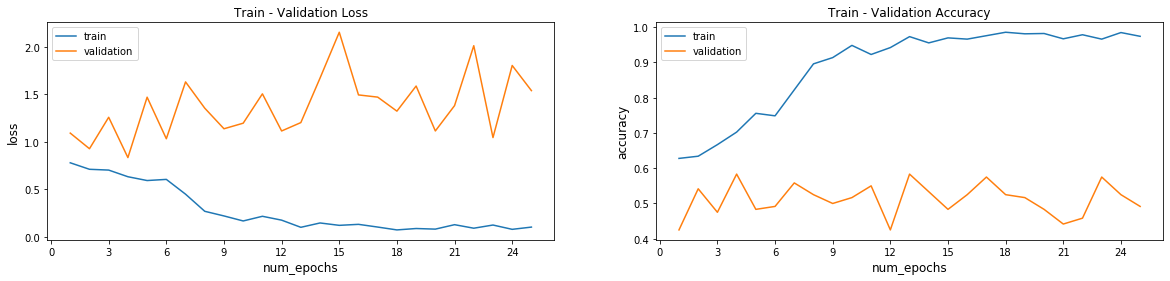

In [8]:
# follow Google coding standards for imports
import copy
import multiprocessing
import os
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn import preprocessing
from torch.optim import lr_scheduler
from zmq.devices import device
from tqdm import tqdm
#from custom_dataset_npy import CustomDatasetNPY
#from net import Net
import pickle
import matplotlib

multiprocessing.set_start_method("spawn", True)

# try to run resnet34 architecture

# look at first: https://pytorch.org/hub/pytorch_vision_resnet/

# look at second: https://stackoverflow.com/questions/23202132/splitting-an-rgb-image-to-r-g-b-channels-python/23208666
class Model(object):
    """Deep learning model for image recognition.

    Loads dataset and neural network hyperparameters. 
    

    Typical usage example:

    model = Model()
    print(model.dataset_train)

    """

    def __init__(self):
        """Initialize dataset and neural network.

        Traverses train_path and valid_path to load (.npy) images using CustomDataNPY)().
        Creates neural network using Net(). Defines hyperparameters. These hyperparameters may need more work and iteration.
        """
        '''
        # Defines paths for training and validation datasets.
        train_path = "/home/gauravkuppa24/Documents/datasets/MRNet-v1.0/train/coronal"
        valid_path = "/home/gauravkuppa24/Documents/datasets/MRNet-v1.0/valid/axial"
        '''
        # Create Dataset and DataLoader for training and validation dataset
        self.dataset_train = CustomDatasetNPY("train")
        self.train_loader = torch.utils.data.DataLoader(
            self.dataset_train, batch_size=4, shuffle=True  # , num_workers=4
        )
        self.dataset_valid = CustomDatasetNPY("valid")
        self.valid_loader = torch.utils.data.DataLoader(
            self.dataset_valid, batch_size=4, shuffle=True  # , num_workers=4
        )
        self.dataset_sizes = {'train':len(self.dataset_train), 'valid':len(self.dataset_valid)}
        self.dataloaders = {
            'train': self.train_loader,
            'valid': self.valid_loader
        }
        # Create Neural Network with hyperparameters.
        self.net = Net()
        self.optimizer = torch.optim.Adam(
            self.net.parameters(), lr=0.01
        )  # how do you know which optim to use when?
        self.criterion = (
            torch.nn.CrossEntropyLoss()
        )  # how do you know which criterion to use? why do we choose cross entropy loss
        self.exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=7, gamma=0.1
        )
        self.device = torch.device("cpu")

    # TODO(G): make a train() method
    def train(self, net, criterion, optimizer, scheduler, num_epochs=10):
        since = time.time()
        train_loss = []
        train_accuracy = []
        valid_loss = []
        valid_accuracy = []
        self.stats = {"train":[train_loss, train_accuracy],"valid":[valid_loss, valid_accuracy]}
        best_model_wts = copy.deepcopy(net.state_dict())
        best_acc = 0.0

        for epoch in range(num_epochs):
            print("Epoch {}/{}".format(epoch, num_epochs - 1))
            print("-" * 10)
            
            # Each epoch has a training and validation phase
            for phase in ["train", "valid"]:
                if phase == "train":
                    net.train()  # Set model to training mode
                else:
                    net.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for i in tqdm(range(len(self.dataloaders[phase]))):
                    it = iter(self.dataloaders[phase])
                    inputs, labels = it.next()

                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    labels = labels.long()[:,1]

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = net(inputs)
                        _, preds = torch.max(outputs, 1)
                        #print(labels)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = running_corrects.double().item() / self.dataset_sizes[phase]
                self.stats[phase][0].append(epoch_loss)
                self.stats[phase][1].append(epoch_acc)
                print(
                    "{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc)
                )

                # deep copy the model
                if phase == "valid" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(net.state_dict())

            print()

        time_elapsed = time.time() - since
        print(
            "Training complete in {:.0f}m {:.0f}s".format(
                time_elapsed // 60, time_elapsed % 60
            )
        )
        print("Best val Acc: {:4f}".format(best_acc))

        # load best model weights
        net.load_state_dict(best_model_wts)
        return net

    def plot_images(self):
        for imgBunch, groundBunch in self.train_loader:
            print(imgBunch.shape)
            for img in imgBunch:
                print("x", img.shape)
                img = img[2,:,:]
                print("y", img.shape)
                # TODO(g): display img #, ground truth, img index
                plt.imshow(img.view(256, -1), cmap="gray")
                plt.show()

    def plot_results(self, epochs, loss_acc):
        train_loss, train_accuracy, valid_loss, valid_accuracy = loss_acc
        fig = plt.figure(figsize=(20,4))
        ax = fig.add_subplot(1, 2, 1)
        plt.title("Train - Validation Loss")
        plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
        plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
        plt.xlabel('num_epochs', fontsize=12)
        plt.ylabel('loss', fontsize=12)
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        plt.legend(loc='best')
        
        ax = fig.add_subplot(1, 2, 2)
        plt.title("Train - Validation Accuracy")
        plt.plot(list(np.arange(epochs) + 1) , train_accuracy, label='train')
        plt.plot(list(np.arange(epochs) + 1), valid_accuracy, label='validation')
        plt.xlabel('num_epochs', fontsize=12)
        plt.ylabel('accuracy', fontsize=12)
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        plt.legend(loc='best')
        plt.show()

def main():
    model = Model()
    model_ft = torchvision.models.resnet34(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = torch.nn.Linear(num_ftrs, 2)
    model_ft = model_ft.to(torch.device('cpu'))
    model.net = model_ft
    criterion = torch.nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    epochs = 25
    train_loss_pickle = open("train_loss.pickle","wb")
    train_acc_pickle = open("train_acc.pickle","wb")
    valid_loss_pickle = open("train_loss.pickle","wb")
    valid_acc_pickle = open("valid_acc.pickle","wb")
    
    model.train(model.net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)
    train_loss, train_accuracy = model.stats['train']
    valid_loss, valid_accuracy = model.stats['valid']
    pickle.dump(train_loss, train_loss_pickle)
    pickle.dump(train_accuracy, train_acc_pickle)
    pickle.dump(valid_loss, valid_loss_pickle)
    pickle.dump(valid_accuracy, valid_acc_pickle)

    train_acc_pickle.close()
    train_loss_pickle.close()
    valid_acc_pickle.close()
    valid_loss_pickle.close()
    
    loss_acc = [train_loss, train_accuracy, valid_loss, valid_accuracy]

    model.plot_results(epochs, loss_acc)
    


if __name__ == "__main__":
    main()